# Human Performance Monitoring Module (HPMM)

Author: Jiawei Chen, Ruoxin Xiong, Carnegie Mellon University

Email: ruoxinx@andrew.cmu.edu

This module predicts the loss of separation as an indicator of the air traffic controller's operational performance.

Loss of separation is a situation where aircraft fail to maintain minimum distances in controlled airspace.

More information about CatBoost can be found [here](https://arxiv.org/abs/1706.09516)

### Environment Requirements

The required packages are,

- [catboost](https://catboost.ai/docs/installation/python-installation-method-pip-install.html#python-installation-method-pip-install)
- pandas
- numpy
- scikit-learn

## Importing library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.preprocessing
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from catboost import CatBoostClassifier

## Data Preparation

The sample data is collected from controller-in-the-loop simulation experiments during the air traffic control tasks.

In [3]:
df = pd.read_csv('./human_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4515 entries, 0 to 4514
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Ss                  4515 non-null   int64  
 1   condtn              4515 non-null   object 
 2   at_sec              4515 non-null   int64  
 3   traffic_density     4515 non-null   int64  
 4   los_freq            4515 non-null   int64  
 5   los_dur_over5min    4515 non-null   int64  
 6   cum_los_dur         4515 non-null   int64  
 7   query               4515 non-null   object 
 8   ready_latency       4466 non-null   float64
 9   ready_latency_adj   3518 non-null   float64
 10  query_latency       3518 non-null   float64
 11  response_index      3362 non-null   float64
 12  ready_timed_out     4466 non-null   float64
 13  query_timed_out     3518 non-null   float64
 14  stimuli             4466 non-null   object 
 15  response_text       3098 non-null   object 
 16  sa_cor

## Data Process
- Drop specified columns of redundant variables for los prediction. 
    - Here we drop 'Ss', 'condtn', 'los_freq', 'los_dur_over5min', 'query_timed_out', 'ready_timed_out', 'ready_latency_adj', 'cum_los_dur','stimuli', 'response_text', 'condtn_num', 'query'.
- Data imputation with mean valus.
- Define predictor(X) and criterion(Y)
    - Transform 'los_freq' into binary classes (0 - no loss of separation; 1 - losses of separation)

In [4]:
df.drop(columns=['Ss', 'at_sec', 'condtn', 'ready_latency', 'query_latency', 'response_index', 'los_dur_over5min','query_timed_out', 'ready_timed_out', 'ready_latency_adj',
                 'cum_los_dur','stimuli', 'response_text', 'condtn_num', 'query'], inplace=True)

df[df['los_freq'] > 1] = 1

df.fillna(df.mean(), inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4515 entries, 0 to 4514
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   traffic_density     4515 non-null   int64  
 1   los_freq            4515 non-null   int64  
 2   sa_correct          4515 non-null   float64
 3   wl_rating           4515 non-null   float64
 4   interbeat_interval  4515 non-null   float64
 5   rx                  4515 non-null   float64
 6   ry                  4515 non-null   float64
 7   rz                  4515 non-null   float64
 8   eyeblink            4515 non-null   float64
 9   negative            4515 non-null   float64
 10  neutral             4515 non-null   float64
 11  positive            4515 non-null   float64
dtypes: float64(10), int64(2)
memory usage: 423.4 KB


In [5]:
X = df.drop(columns=['los_freq'])
Y = df['los_freq']

# Training and testing los prediction model

- Predict the occurence of losses of separation with catboost model (machine learning based classifier)
- Split the dataset into 80% and 20% for training and testing, respectively.

- The optimal model parameters, including learning rate, depth, and L2 regularization term, are determined based on the grid search.

- Save the best training model named 'catboost_hpmm'.

In [6]:
'''
Dataset split
'''
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

'''
Building model
'''
model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='Accuracy'
)

'''
choose parameters based on grid_search
'''
grid = {'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        } 

model.grid_search(grid, X=X_train, y=y_train, verbose= 2)

0:	learn: 0.8213915	test: 0.8340249	best: 0.8340249 (0)	total: 176ms	remaining: 2m 56s
1:	learn: 0.8248529	test: 0.8395574	best: 0.8395574 (1)	total: 178ms	remaining: 1m 28s
2:	learn: 0.8421599	test: 0.8450899	best: 0.8450899 (2)	total: 180ms	remaining: 59.7s
3:	learn: 0.8383524	test: 0.8520055	best: 0.8520055 (3)	total: 181ms	remaining: 45.1s
4:	learn: 0.8248529	test: 0.8409405	best: 0.8520055 (3)	total: 182ms	remaining: 36.3s
5:	learn: 0.8245067	test: 0.8367911	best: 0.8520055 (3)	total: 184ms	remaining: 30.5s
6:	learn: 0.8355832	test: 0.8381743	best: 0.8520055 (3)	total: 185ms	remaining: 26.3s
7:	learn: 0.8310834	test: 0.8437068	best: 0.8520055 (3)	total: 187ms	remaining: 23.2s
8:	learn: 0.8258913	test: 0.8395574	best: 0.8520055 (3)	total: 188ms	remaining: 20.8s
9:	learn: 0.8300450	test: 0.8423237	best: 0.8520055 (3)	total: 190ms	remaining: 18.8s
10:	learn: 0.8238145	test: 0.8409405	best: 0.8520055 (3)	total: 192ms	remaining: 17.2s
11:	learn: 0.8248529	test: 0.8409405	best: 0.852005

109:	learn: 0.8445829	test: 0.8533887	best: 0.8547718 (99)	total: 347ms	remaining: 2.81s
110:	learn: 0.8449290	test: 0.8520055	best: 0.8547718 (99)	total: 348ms	remaining: 2.79s
111:	learn: 0.8445829	test: 0.8533887	best: 0.8547718 (99)	total: 350ms	remaining: 2.77s
112:	learn: 0.8449290	test: 0.8533887	best: 0.8547718 (99)	total: 351ms	remaining: 2.76s
113:	learn: 0.8452752	test: 0.8561549	best: 0.8561549 (113)	total: 353ms	remaining: 2.74s
114:	learn: 0.8459675	test: 0.8561549	best: 0.8561549 (113)	total: 355ms	remaining: 2.73s
115:	learn: 0.8452752	test: 0.8561549	best: 0.8561549 (113)	total: 356ms	remaining: 2.71s
116:	learn: 0.8456213	test: 0.8547718	best: 0.8561549 (113)	total: 358ms	remaining: 2.7s
117:	learn: 0.8463136	test: 0.8547718	best: 0.8561549 (113)	total: 359ms	remaining: 2.68s
118:	learn: 0.8463136	test: 0.8533887	best: 0.8561549 (113)	total: 361ms	remaining: 2.67s
119:	learn: 0.8459675	test: 0.8533887	best: 0.8561549 (113)	total: 362ms	remaining: 2.66s
120:	learn: 0.8

217:	learn: 0.8504673	test: 0.8506224	best: 0.8561549 (113)	total: 530ms	remaining: 1.9s
218:	learn: 0.8504673	test: 0.8506224	best: 0.8561549 (113)	total: 532ms	remaining: 1.9s
219:	learn: 0.8508134	test: 0.8506224	best: 0.8561549 (113)	total: 534ms	remaining: 1.89s
220:	learn: 0.8515057	test: 0.8506224	best: 0.8561549 (113)	total: 536ms	remaining: 1.89s
221:	learn: 0.8515057	test: 0.8506224	best: 0.8561549 (113)	total: 537ms	remaining: 1.88s
222:	learn: 0.8515057	test: 0.8506224	best: 0.8561549 (113)	total: 539ms	remaining: 1.88s
223:	learn: 0.8515057	test: 0.8506224	best: 0.8561549 (113)	total: 540ms	remaining: 1.87s
224:	learn: 0.8515057	test: 0.8506224	best: 0.8561549 (113)	total: 542ms	remaining: 1.87s
225:	learn: 0.8515057	test: 0.8520055	best: 0.8561549 (113)	total: 544ms	remaining: 1.86s
226:	learn: 0.8515057	test: 0.8520055	best: 0.8561549 (113)	total: 546ms	remaining: 1.86s
227:	learn: 0.8515057	test: 0.8520055	best: 0.8561549 (113)	total: 547ms	remaining: 1.85s
228:	learn: 

333:	learn: 0.8622361	test: 0.8575380	best: 0.8575380 (303)	total: 712ms	remaining: 1.42s
334:	learn: 0.8618899	test: 0.8589212	best: 0.8589212 (334)	total: 714ms	remaining: 1.42s
335:	learn: 0.8618899	test: 0.8589212	best: 0.8589212 (334)	total: 716ms	remaining: 1.41s
336:	learn: 0.8618899	test: 0.8589212	best: 0.8589212 (334)	total: 717ms	remaining: 1.41s
337:	learn: 0.8618899	test: 0.8589212	best: 0.8589212 (334)	total: 719ms	remaining: 1.41s
338:	learn: 0.8622361	test: 0.8589212	best: 0.8589212 (334)	total: 720ms	remaining: 1.4s
339:	learn: 0.8622361	test: 0.8589212	best: 0.8589212 (334)	total: 722ms	remaining: 1.4s
340:	learn: 0.8622361	test: 0.8589212	best: 0.8589212 (334)	total: 723ms	remaining: 1.4s
341:	learn: 0.8622361	test: 0.8589212	best: 0.8589212 (334)	total: 725ms	remaining: 1.4s
342:	learn: 0.8625822	test: 0.8589212	best: 0.8589212 (334)	total: 727ms	remaining: 1.39s
343:	learn: 0.8625822	test: 0.8603043	best: 0.8603043 (343)	total: 728ms	remaining: 1.39s
344:	learn: 0.

451:	learn: 0.8785047	test: 0.8630705	best: 0.8672199 (432)	total: 894ms	remaining: 1.08s
452:	learn: 0.8791970	test: 0.8630705	best: 0.8672199 (432)	total: 896ms	remaining: 1.08s
453:	learn: 0.8791970	test: 0.8630705	best: 0.8672199 (432)	total: 897ms	remaining: 1.08s
454:	learn: 0.8791970	test: 0.8630705	best: 0.8672199 (432)	total: 899ms	remaining: 1.08s
455:	learn: 0.8791970	test: 0.8630705	best: 0.8672199 (432)	total: 901ms	remaining: 1.07s
456:	learn: 0.8802354	test: 0.8630705	best: 0.8672199 (432)	total: 902ms	remaining: 1.07s
457:	learn: 0.8798892	test: 0.8630705	best: 0.8672199 (432)	total: 904ms	remaining: 1.07s
458:	learn: 0.8798892	test: 0.8644537	best: 0.8672199 (432)	total: 905ms	remaining: 1.07s
459:	learn: 0.8798892	test: 0.8644537	best: 0.8672199 (432)	total: 907ms	remaining: 1.06s
460:	learn: 0.8798892	test: 0.8644537	best: 0.8672199 (432)	total: 908ms	remaining: 1.06s
461:	learn: 0.8798892	test: 0.8644537	best: 0.8672199 (432)	total: 910ms	remaining: 1.06s
462:	learn

572:	learn: 0.8885427	test: 0.8672199	best: 0.8672199 (432)	total: 1.08s	remaining: 803ms
573:	learn: 0.8888889	test: 0.8672199	best: 0.8672199 (432)	total: 1.08s	remaining: 801ms
574:	learn: 0.8888889	test: 0.8686030	best: 0.8686030 (574)	total: 1.08s	remaining: 799ms
575:	learn: 0.8888889	test: 0.8686030	best: 0.8686030 (574)	total: 1.08s	remaining: 797ms
576:	learn: 0.8888889	test: 0.8686030	best: 0.8686030 (574)	total: 1.08s	remaining: 795ms
577:	learn: 0.8895812	test: 0.8686030	best: 0.8686030 (574)	total: 1.09s	remaining: 793ms
578:	learn: 0.8895812	test: 0.8686030	best: 0.8686030 (574)	total: 1.09s	remaining: 791ms
579:	learn: 0.8895812	test: 0.8686030	best: 0.8686030 (574)	total: 1.09s	remaining: 789ms
580:	learn: 0.8892350	test: 0.8686030	best: 0.8686030 (574)	total: 1.09s	remaining: 787ms
581:	learn: 0.8892350	test: 0.8686030	best: 0.8686030 (574)	total: 1.09s	remaining: 785ms
582:	learn: 0.8892350	test: 0.8672199	best: 0.8686030 (574)	total: 1.09s	remaining: 782ms
583:	learn

690:	learn: 0.8965040	test: 0.8672199	best: 0.8699862 (591)	total: 1.26s	remaining: 563ms
691:	learn: 0.8961578	test: 0.8672199	best: 0.8699862 (591)	total: 1.26s	remaining: 561ms
692:	learn: 0.8965040	test: 0.8672199	best: 0.8699862 (591)	total: 1.26s	remaining: 559ms
693:	learn: 0.8965040	test: 0.8672199	best: 0.8699862 (591)	total: 1.26s	remaining: 557ms
694:	learn: 0.8965040	test: 0.8672199	best: 0.8699862 (591)	total: 1.26s	remaining: 556ms
695:	learn: 0.8965040	test: 0.8686030	best: 0.8699862 (591)	total: 1.27s	remaining: 554ms
696:	learn: 0.8971963	test: 0.8686030	best: 0.8699862 (591)	total: 1.27s	remaining: 552ms
697:	learn: 0.8971963	test: 0.8686030	best: 0.8699862 (591)	total: 1.27s	remaining: 550ms
698:	learn: 0.8975424	test: 0.8686030	best: 0.8699862 (591)	total: 1.27s	remaining: 548ms
699:	learn: 0.8975424	test: 0.8686030	best: 0.8699862 (591)	total: 1.27s	remaining: 546ms
700:	learn: 0.8975424	test: 0.8672199	best: 0.8699862 (591)	total: 1.27s	remaining: 544ms
701:	learn

811:	learn: 0.9010038	test: 0.8699862	best: 0.8727524 (765)	total: 1.44s	remaining: 334ms
812:	learn: 0.9010038	test: 0.8699862	best: 0.8727524 (765)	total: 1.44s	remaining: 332ms
813:	learn: 0.9016961	test: 0.8699862	best: 0.8727524 (765)	total: 1.45s	remaining: 330ms
814:	learn: 0.9013499	test: 0.8699862	best: 0.8727524 (765)	total: 1.45s	remaining: 329ms
815:	learn: 0.9010038	test: 0.8699862	best: 0.8727524 (765)	total: 1.45s	remaining: 327ms
816:	learn: 0.9010038	test: 0.8713693	best: 0.8727524 (765)	total: 1.45s	remaining: 325ms
817:	learn: 0.9016961	test: 0.8713693	best: 0.8727524 (765)	total: 1.45s	remaining: 323ms
818:	learn: 0.9013499	test: 0.8713693	best: 0.8727524 (765)	total: 1.45s	remaining: 321ms
819:	learn: 0.9010038	test: 0.8713693	best: 0.8727524 (765)	total: 1.46s	remaining: 319ms
820:	learn: 0.9010038	test: 0.8713693	best: 0.8727524 (765)	total: 1.46s	remaining: 318ms
821:	learn: 0.9010038	test: 0.8713693	best: 0.8727524 (765)	total: 1.46s	remaining: 316ms
822:	learn

930:	learn: 0.9065421	test: 0.8727524	best: 0.8741355 (879)	total: 1.63s	remaining: 120ms
931:	learn: 0.9065421	test: 0.8741355	best: 0.8741355 (879)	total: 1.63s	remaining: 119ms
932:	learn: 0.9065421	test: 0.8741355	best: 0.8741355 (879)	total: 1.63s	remaining: 117ms
933:	learn: 0.9068882	test: 0.8741355	best: 0.8741355 (879)	total: 1.63s	remaining: 115ms
934:	learn: 0.9065421	test: 0.8741355	best: 0.8741355 (879)	total: 1.63s	remaining: 113ms
935:	learn: 0.9061959	test: 0.8741355	best: 0.8741355 (879)	total: 1.63s	remaining: 112ms
936:	learn: 0.9068882	test: 0.8741355	best: 0.8741355 (879)	total: 1.63s	remaining: 110ms
937:	learn: 0.9065421	test: 0.8741355	best: 0.8741355 (879)	total: 1.64s	remaining: 108ms
938:	learn: 0.9065421	test: 0.8741355	best: 0.8741355 (879)	total: 1.64s	remaining: 106ms
939:	learn: 0.9072343	test: 0.8741355	best: 0.8741355 (879)	total: 1.64s	remaining: 105ms
940:	learn: 0.9068882	test: 0.8741355	best: 0.8741355 (879)	total: 1.64s	remaining: 103ms
941:	learn

44:	learn: 0.8501211	test: 0.8533887	best: 0.8589212 (30)	total: 69.1ms	remaining: 1.47s
45:	learn: 0.8521980	test: 0.8533887	best: 0.8589212 (30)	total: 70.7ms	remaining: 1.47s
46:	learn: 0.8525441	test: 0.8547718	best: 0.8589212 (30)	total: 72.2ms	remaining: 1.46s
47:	learn: 0.8535826	test: 0.8561549	best: 0.8589212 (30)	total: 73.7ms	remaining: 1.46s
48:	learn: 0.8525441	test: 0.8561549	best: 0.8589212 (30)	total: 75.2ms	remaining: 1.46s
49:	learn: 0.8525441	test: 0.8561549	best: 0.8589212 (30)	total: 76.7ms	remaining: 1.46s
50:	learn: 0.8532364	test: 0.8533887	best: 0.8589212 (30)	total: 78.3ms	remaining: 1.46s
51:	learn: 0.8535826	test: 0.8575380	best: 0.8589212 (30)	total: 79.9ms	remaining: 1.46s
52:	learn: 0.8535826	test: 0.8575380	best: 0.8589212 (30)	total: 81.5ms	remaining: 1.46s
53:	learn: 0.8528903	test: 0.8561549	best: 0.8589212 (30)	total: 83ms	remaining: 1.45s
54:	learn: 0.8532364	test: 0.8575380	best: 0.8589212 (30)	total: 84.6ms	remaining: 1.45s
55:	learn: 0.8528903	te

164:	learn: 0.8999654	test: 0.8699862	best: 0.8741355 (109)	total: 251ms	remaining: 1.27s
165:	learn: 0.9003115	test: 0.8699862	best: 0.8741355 (109)	total: 253ms	remaining: 1.27s
166:	learn: 0.9010038	test: 0.8699862	best: 0.8741355 (109)	total: 254ms	remaining: 1.27s
167:	learn: 0.9016961	test: 0.8686030	best: 0.8741355 (109)	total: 256ms	remaining: 1.27s
168:	learn: 0.9016961	test: 0.8686030	best: 0.8741355 (109)	total: 257ms	remaining: 1.27s
169:	learn: 0.9020422	test: 0.8699862	best: 0.8741355 (109)	total: 259ms	remaining: 1.26s
170:	learn: 0.9013499	test: 0.8699862	best: 0.8741355 (109)	total: 261ms	remaining: 1.26s
171:	learn: 0.9010038	test: 0.8727524	best: 0.8741355 (109)	total: 262ms	remaining: 1.26s
172:	learn: 0.9006577	test: 0.8713693	best: 0.8741355 (109)	total: 264ms	remaining: 1.26s
173:	learn: 0.9003115	test: 0.8699862	best: 0.8741355 (109)	total: 265ms	remaining: 1.26s
174:	learn: 0.9006577	test: 0.8686030	best: 0.8741355 (109)	total: 267ms	remaining: 1.26s
175:	learn

284:	learn: 0.9224645	test: 0.8769018	best: 0.8769018 (283)	total: 434ms	remaining: 1.09s
285:	learn: 0.9231568	test: 0.8755187	best: 0.8769018 (283)	total: 436ms	remaining: 1.09s
286:	learn: 0.9228107	test: 0.8741355	best: 0.8769018 (283)	total: 438ms	remaining: 1.09s
287:	learn: 0.9241952	test: 0.8741355	best: 0.8769018 (283)	total: 439ms	remaining: 1.08s
288:	learn: 0.9248875	test: 0.8727524	best: 0.8769018 (283)	total: 441ms	remaining: 1.08s
289:	learn: 0.9259259	test: 0.8727524	best: 0.8769018 (283)	total: 442ms	remaining: 1.08s
290:	learn: 0.9259259	test: 0.8741355	best: 0.8769018 (283)	total: 444ms	remaining: 1.08s
291:	learn: 0.9252336	test: 0.8741355	best: 0.8769018 (283)	total: 445ms	remaining: 1.08s
292:	learn: 0.9252336	test: 0.8755187	best: 0.8769018 (283)	total: 447ms	remaining: 1.08s
293:	learn: 0.9252336	test: 0.8755187	best: 0.8769018 (283)	total: 448ms	remaining: 1.08s
294:	learn: 0.9255798	test: 0.8755187	best: 0.8769018 (283)	total: 450ms	remaining: 1.07s
295:	learn

402:	learn: 0.9425407	test: 0.8782849	best: 0.8824343 (389)	total: 617ms	remaining: 913ms
403:	learn: 0.9428868	test: 0.8782849	best: 0.8824343 (389)	total: 618ms	remaining: 912ms
404:	learn: 0.9425407	test: 0.8782849	best: 0.8824343 (389)	total: 620ms	remaining: 910ms
405:	learn: 0.9421945	test: 0.8782849	best: 0.8824343 (389)	total: 621ms	remaining: 909ms
406:	learn: 0.9432330	test: 0.8782849	best: 0.8824343 (389)	total: 623ms	remaining: 907ms
407:	learn: 0.9432330	test: 0.8782849	best: 0.8824343 (389)	total: 624ms	remaining: 906ms
408:	learn: 0.9432330	test: 0.8782849	best: 0.8824343 (389)	total: 626ms	remaining: 905ms
409:	learn: 0.9432330	test: 0.8782849	best: 0.8824343 (389)	total: 628ms	remaining: 903ms
410:	learn: 0.9432330	test: 0.8782849	best: 0.8824343 (389)	total: 629ms	remaining: 902ms
411:	learn: 0.9435791	test: 0.8796680	best: 0.8824343 (389)	total: 631ms	remaining: 900ms
412:	learn: 0.9435791	test: 0.8810512	best: 0.8824343 (389)	total: 632ms	remaining: 898ms
413:	learn

523:	learn: 0.9546556	test: 0.8810512	best: 0.8824343 (389)	total: 800ms	remaining: 727ms
524:	learn: 0.9546556	test: 0.8810512	best: 0.8824343 (389)	total: 802ms	remaining: 725ms
525:	learn: 0.9550017	test: 0.8810512	best: 0.8824343 (389)	total: 803ms	remaining: 724ms
526:	learn: 0.9543094	test: 0.8810512	best: 0.8824343 (389)	total: 805ms	remaining: 722ms
527:	learn: 0.9539633	test: 0.8810512	best: 0.8824343 (389)	total: 806ms	remaining: 721ms
528:	learn: 0.9539633	test: 0.8796680	best: 0.8824343 (389)	total: 808ms	remaining: 719ms
529:	learn: 0.9539633	test: 0.8796680	best: 0.8824343 (389)	total: 810ms	remaining: 718ms
530:	learn: 0.9536172	test: 0.8796680	best: 0.8824343 (389)	total: 811ms	remaining: 717ms
531:	learn: 0.9539633	test: 0.8796680	best: 0.8824343 (389)	total: 813ms	remaining: 715ms
532:	learn: 0.9539633	test: 0.8796680	best: 0.8824343 (389)	total: 814ms	remaining: 714ms
533:	learn: 0.9543094	test: 0.8796680	best: 0.8824343 (389)	total: 816ms	remaining: 712ms
534:	learn

642:	learn: 0.9646937	test: 0.8852006	best: 0.8852006 (566)	total: 982ms	remaining: 545ms
643:	learn: 0.9643475	test: 0.8852006	best: 0.8852006 (566)	total: 983ms	remaining: 543ms
644:	learn: 0.9650398	test: 0.8852006	best: 0.8852006 (566)	total: 985ms	remaining: 542ms
645:	learn: 0.9646937	test: 0.8852006	best: 0.8852006 (566)	total: 986ms	remaining: 541ms
646:	learn: 0.9646937	test: 0.8852006	best: 0.8852006 (566)	total: 988ms	remaining: 539ms
647:	learn: 0.9646937	test: 0.8852006	best: 0.8852006 (566)	total: 990ms	remaining: 538ms
648:	learn: 0.9650398	test: 0.8852006	best: 0.8852006 (566)	total: 991ms	remaining: 536ms
649:	learn: 0.9646937	test: 0.8852006	best: 0.8852006 (566)	total: 993ms	remaining: 535ms
650:	learn: 0.9643475	test: 0.8838174	best: 0.8852006 (566)	total: 995ms	remaining: 533ms
651:	learn: 0.9646937	test: 0.8838174	best: 0.8852006 (566)	total: 996ms	remaining: 532ms
652:	learn: 0.9650398	test: 0.8852006	best: 0.8852006 (566)	total: 998ms	remaining: 530ms
653:	learn

761:	learn: 0.9723088	test: 0.8852006	best: 0.8879668 (733)	total: 1.16s	remaining: 364ms
762:	learn: 0.9723088	test: 0.8852006	best: 0.8879668 (733)	total: 1.17s	remaining: 362ms
763:	learn: 0.9723088	test: 0.8852006	best: 0.8879668 (733)	total: 1.17s	remaining: 361ms
764:	learn: 0.9726549	test: 0.8852006	best: 0.8879668 (733)	total: 1.17s	remaining: 359ms
765:	learn: 0.9730010	test: 0.8852006	best: 0.8879668 (733)	total: 1.17s	remaining: 358ms
766:	learn: 0.9730010	test: 0.8865837	best: 0.8879668 (733)	total: 1.17s	remaining: 356ms
767:	learn: 0.9730010	test: 0.8865837	best: 0.8879668 (733)	total: 1.17s	remaining: 355ms
768:	learn: 0.9730010	test: 0.8865837	best: 0.8879668 (733)	total: 1.18s	remaining: 353ms
769:	learn: 0.9730010	test: 0.8879668	best: 0.8879668 (733)	total: 1.18s	remaining: 352ms
770:	learn: 0.9730010	test: 0.8879668	best: 0.8879668 (733)	total: 1.18s	remaining: 350ms
771:	learn: 0.9730010	test: 0.8879668	best: 0.8879668 (733)	total: 1.18s	remaining: 349ms
772:	learn

874:	learn: 0.9761163	test: 0.8879668	best: 0.8879668 (733)	total: 1.35s	remaining: 193ms
875:	learn: 0.9764624	test: 0.8893499	best: 0.8893499 (875)	total: 1.35s	remaining: 191ms
876:	learn: 0.9768086	test: 0.8893499	best: 0.8893499 (875)	total: 1.35s	remaining: 189ms
877:	learn: 0.9768086	test: 0.8893499	best: 0.8893499 (875)	total: 1.35s	remaining: 188ms
878:	learn: 0.9764624	test: 0.8893499	best: 0.8893499 (875)	total: 1.35s	remaining: 186ms
879:	learn: 0.9771547	test: 0.8879668	best: 0.8893499 (875)	total: 1.35s	remaining: 185ms
880:	learn: 0.9775009	test: 0.8865837	best: 0.8893499 (875)	total: 1.36s	remaining: 183ms
881:	learn: 0.9775009	test: 0.8879668	best: 0.8893499 (875)	total: 1.36s	remaining: 182ms
882:	learn: 0.9775009	test: 0.8879668	best: 0.8893499 (875)	total: 1.36s	remaining: 180ms
883:	learn: 0.9775009	test: 0.8893499	best: 0.8893499 (875)	total: 1.36s	remaining: 179ms
884:	learn: 0.9775009	test: 0.8879668	best: 0.8893499 (875)	total: 1.36s	remaining: 177ms
885:	learn

982:	learn: 0.9830391	test: 0.8852006	best: 0.8907331 (926)	total: 1.53s	remaining: 26.5ms
983:	learn: 0.9830391	test: 0.8852006	best: 0.8907331 (926)	total: 1.53s	remaining: 24.9ms
984:	learn: 0.9830391	test: 0.8852006	best: 0.8907331 (926)	total: 1.53s	remaining: 23.4ms
985:	learn: 0.9830391	test: 0.8865837	best: 0.8907331 (926)	total: 1.53s	remaining: 21.8ms
986:	learn: 0.9833853	test: 0.8865837	best: 0.8907331 (926)	total: 1.54s	remaining: 20.2ms
987:	learn: 0.9833853	test: 0.8865837	best: 0.8907331 (926)	total: 1.54s	remaining: 18.7ms
988:	learn: 0.9837314	test: 0.8865837	best: 0.8907331 (926)	total: 1.54s	remaining: 17.1ms
989:	learn: 0.9837314	test: 0.8879668	best: 0.8907331 (926)	total: 1.54s	remaining: 15.6ms
990:	learn: 0.9837314	test: 0.8879668	best: 0.8907331 (926)	total: 1.54s	remaining: 14ms
991:	learn: 0.9840775	test: 0.8879668	best: 0.8907331 (926)	total: 1.54s	remaining: 12.5ms
992:	learn: 0.9844237	test: 0.8865837	best: 0.8907331 (926)	total: 1.55s	remaining: 10.9ms
9

99:	learn: 0.9096573	test: 0.8769018	best: 0.8796680 (88)	total: 153ms	remaining: 1.38s
100:	learn: 0.9093112	test: 0.8782849	best: 0.8796680 (88)	total: 155ms	remaining: 1.38s
101:	learn: 0.9100035	test: 0.8782849	best: 0.8796680 (88)	total: 157ms	remaining: 1.38s
102:	learn: 0.9100035	test: 0.8782849	best: 0.8796680 (88)	total: 158ms	remaining: 1.38s
103:	learn: 0.9100035	test: 0.8782849	best: 0.8796680 (88)	total: 160ms	remaining: 1.38s
104:	learn: 0.9113880	test: 0.8769018	best: 0.8796680 (88)	total: 161ms	remaining: 1.38s
105:	learn: 0.9117342	test: 0.8782849	best: 0.8796680 (88)	total: 163ms	remaining: 1.37s
106:	learn: 0.9110419	test: 0.8782849	best: 0.8796680 (88)	total: 165ms	remaining: 1.37s
107:	learn: 0.9110419	test: 0.8755187	best: 0.8796680 (88)	total: 166ms	remaining: 1.37s
108:	learn: 0.9117342	test: 0.8755187	best: 0.8796680 (88)	total: 168ms	remaining: 1.37s
109:	learn: 0.9120803	test: 0.8755187	best: 0.8796680 (88)	total: 170ms	remaining: 1.37s
110:	learn: 0.9117342	

218:	learn: 0.9442714	test: 0.8769018	best: 0.8810512 (213)	total: 337ms	remaining: 1.2s
219:	learn: 0.9446175	test: 0.8782849	best: 0.8810512 (213)	total: 339ms	remaining: 1.2s
220:	learn: 0.9446175	test: 0.8782849	best: 0.8810512 (213)	total: 340ms	remaining: 1.2s
221:	learn: 0.9460021	test: 0.8782849	best: 0.8810512 (213)	total: 342ms	remaining: 1.2s
222:	learn: 0.9460021	test: 0.8782849	best: 0.8810512 (213)	total: 343ms	remaining: 1.2s
223:	learn: 0.9460021	test: 0.8782849	best: 0.8810512 (213)	total: 345ms	remaining: 1.19s
224:	learn: 0.9463482	test: 0.8796680	best: 0.8810512 (213)	total: 346ms	remaining: 1.19s
225:	learn: 0.9456559	test: 0.8782849	best: 0.8810512 (213)	total: 348ms	remaining: 1.19s
226:	learn: 0.9460021	test: 0.8782849	best: 0.8810512 (213)	total: 350ms	remaining: 1.19s
227:	learn: 0.9460021	test: 0.8782849	best: 0.8810512 (213)	total: 351ms	remaining: 1.19s
228:	learn: 0.9456559	test: 0.8782849	best: 0.8810512 (213)	total: 353ms	remaining: 1.19s
229:	learn: 0.9

332:	learn: 0.9650398	test: 0.8782849	best: 0.8838174 (235)	total: 518ms	remaining: 1.04s
333:	learn: 0.9650398	test: 0.8782849	best: 0.8838174 (235)	total: 519ms	remaining: 1.03s
334:	learn: 0.9650398	test: 0.8796680	best: 0.8838174 (235)	total: 521ms	remaining: 1.03s
335:	learn: 0.9646937	test: 0.8782849	best: 0.8838174 (235)	total: 523ms	remaining: 1.03s
336:	learn: 0.9657321	test: 0.8782849	best: 0.8838174 (235)	total: 524ms	remaining: 1.03s
337:	learn: 0.9660782	test: 0.8796680	best: 0.8838174 (235)	total: 526ms	remaining: 1.03s
338:	learn: 0.9660782	test: 0.8796680	best: 0.8838174 (235)	total: 528ms	remaining: 1.03s
339:	learn: 0.9657321	test: 0.8796680	best: 0.8838174 (235)	total: 529ms	remaining: 1.03s
340:	learn: 0.9657321	test: 0.8796680	best: 0.8838174 (235)	total: 531ms	remaining: 1.02s
341:	learn: 0.9653859	test: 0.8796680	best: 0.8838174 (235)	total: 532ms	remaining: 1.02s
342:	learn: 0.9653859	test: 0.8796680	best: 0.8838174 (235)	total: 534ms	remaining: 1.02s
343:	learn

446:	learn: 0.9792316	test: 0.8741355	best: 0.8838174 (235)	total: 700ms	remaining: 866ms
447:	learn: 0.9795777	test: 0.8741355	best: 0.8838174 (235)	total: 702ms	remaining: 865ms
448:	learn: 0.9792316	test: 0.8727524	best: 0.8838174 (235)	total: 703ms	remaining: 863ms
449:	learn: 0.9799238	test: 0.8741355	best: 0.8838174 (235)	total: 705ms	remaining: 862ms
450:	learn: 0.9799238	test: 0.8755187	best: 0.8838174 (235)	total: 707ms	remaining: 860ms
451:	learn: 0.9806161	test: 0.8741355	best: 0.8838174 (235)	total: 708ms	remaining: 859ms
452:	learn: 0.9802700	test: 0.8755187	best: 0.8838174 (235)	total: 710ms	remaining: 857ms
453:	learn: 0.9802700	test: 0.8769018	best: 0.8838174 (235)	total: 711ms	remaining: 856ms
454:	learn: 0.9799238	test: 0.8741355	best: 0.8838174 (235)	total: 713ms	remaining: 854ms
455:	learn: 0.9799238	test: 0.8741355	best: 0.8838174 (235)	total: 715ms	remaining: 852ms
456:	learn: 0.9802700	test: 0.8741355	best: 0.8838174 (235)	total: 716ms	remaining: 851ms
457:	learn

560:	learn: 0.9913465	test: 0.8824343	best: 0.8879668 (538)	total: 881ms	remaining: 689ms
561:	learn: 0.9910003	test: 0.8810512	best: 0.8879668 (538)	total: 883ms	remaining: 688ms
562:	learn: 0.9910003	test: 0.8810512	best: 0.8879668 (538)	total: 884ms	remaining: 686ms
563:	learn: 0.9910003	test: 0.8824343	best: 0.8879668 (538)	total: 886ms	remaining: 685ms
564:	learn: 0.9910003	test: 0.8810512	best: 0.8879668 (538)	total: 888ms	remaining: 683ms
565:	learn: 0.9913465	test: 0.8810512	best: 0.8879668 (538)	total: 889ms	remaining: 682ms
566:	learn: 0.9913465	test: 0.8824343	best: 0.8879668 (538)	total: 891ms	remaining: 680ms
567:	learn: 0.9916926	test: 0.8824343	best: 0.8879668 (538)	total: 893ms	remaining: 679ms
568:	learn: 0.9913465	test: 0.8810512	best: 0.8879668 (538)	total: 894ms	remaining: 678ms
569:	learn: 0.9913465	test: 0.8810512	best: 0.8879668 (538)	total: 896ms	remaining: 676ms
570:	learn: 0.9920388	test: 0.8796680	best: 0.8879668 (538)	total: 898ms	remaining: 675ms
571:	learn

670:	learn: 0.9958463	test: 0.8838174	best: 0.8879668 (538)	total: 1.06s	remaining: 521ms
671:	learn: 0.9958463	test: 0.8824343	best: 0.8879668 (538)	total: 1.06s	remaining: 520ms
672:	learn: 0.9958463	test: 0.8824343	best: 0.8879668 (538)	total: 1.07s	remaining: 518ms
673:	learn: 0.9958463	test: 0.8824343	best: 0.8879668 (538)	total: 1.07s	remaining: 517ms
674:	learn: 0.9958463	test: 0.8824343	best: 0.8879668 (538)	total: 1.07s	remaining: 515ms
675:	learn: 0.9961925	test: 0.8810512	best: 0.8879668 (538)	total: 1.07s	remaining: 513ms
676:	learn: 0.9961925	test: 0.8810512	best: 0.8879668 (538)	total: 1.07s	remaining: 512ms
677:	learn: 0.9961925	test: 0.8824343	best: 0.8879668 (538)	total: 1.07s	remaining: 510ms
678:	learn: 0.9968847	test: 0.8824343	best: 0.8879668 (538)	total: 1.08s	remaining: 509ms
679:	learn: 0.9968847	test: 0.8824343	best: 0.8879668 (538)	total: 1.08s	remaining: 507ms
680:	learn: 0.9968847	test: 0.8824343	best: 0.8879668 (538)	total: 1.08s	remaining: 506ms
681:	learn

784:	learn: 0.9986154	test: 0.8796680	best: 0.8879668 (538)	total: 1.24s	remaining: 341ms
785:	learn: 0.9986154	test: 0.8796680	best: 0.8879668 (538)	total: 1.25s	remaining: 339ms
786:	learn: 0.9986154	test: 0.8796680	best: 0.8879668 (538)	total: 1.25s	remaining: 338ms
787:	learn: 0.9986154	test: 0.8810512	best: 0.8879668 (538)	total: 1.25s	remaining: 336ms
788:	learn: 0.9986154	test: 0.8810512	best: 0.8879668 (538)	total: 1.25s	remaining: 335ms
789:	learn: 0.9986154	test: 0.8810512	best: 0.8879668 (538)	total: 1.25s	remaining: 333ms
790:	learn: 0.9986154	test: 0.8810512	best: 0.8879668 (538)	total: 1.25s	remaining: 331ms
791:	learn: 0.9986154	test: 0.8810512	best: 0.8879668 (538)	total: 1.25s	remaining: 330ms
792:	learn: 0.9986154	test: 0.8810512	best: 0.8879668 (538)	total: 1.26s	remaining: 328ms
793:	learn: 0.9986154	test: 0.8810512	best: 0.8879668 (538)	total: 1.26s	remaining: 327ms
794:	learn: 0.9986154	test: 0.8810512	best: 0.8879668 (538)	total: 1.26s	remaining: 325ms
795:	learn

900:	learn: 0.9993077	test: 0.8838174	best: 0.8879668 (538)	total: 1.43s	remaining: 157ms
901:	learn: 0.9993077	test: 0.8838174	best: 0.8879668 (538)	total: 1.43s	remaining: 155ms
902:	learn: 0.9993077	test: 0.8852006	best: 0.8879668 (538)	total: 1.43s	remaining: 154ms
903:	learn: 0.9993077	test: 0.8852006	best: 0.8879668 (538)	total: 1.43s	remaining: 152ms
904:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (538)	total: 1.43s	remaining: 150ms
905:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (538)	total: 1.44s	remaining: 149ms
906:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (538)	total: 1.44s	remaining: 147ms
907:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (538)	total: 1.44s	remaining: 146ms
908:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (538)	total: 1.44s	remaining: 144ms
909:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (538)	total: 1.44s	remaining: 143ms
910:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (538)	total: 1.44s	remaining: 141ms
911:	learn

13:	learn: 0.8348910	test: 0.8423237	best: 0.8520055 (3)	total: 23.6ms	remaining: 1.66s
14:	learn: 0.8341987	test: 0.8450899	best: 0.8520055 (3)	total: 25.2ms	remaining: 1.66s
15:	learn: 0.8335064	test: 0.8450899	best: 0.8520055 (3)	total: 26.9ms	remaining: 1.65s
16:	learn: 0.8265836	test: 0.8437068	best: 0.8520055 (3)	total: 28.5ms	remaining: 1.65s
17:	learn: 0.8293527	test: 0.8464730	best: 0.8520055 (3)	total: 30.1ms	remaining: 1.64s
18:	learn: 0.8328141	test: 0.8478562	best: 0.8520055 (3)	total: 31.8ms	remaining: 1.64s
19:	learn: 0.8324680	test: 0.8478562	best: 0.8520055 (3)	total: 33.4ms	remaining: 1.64s
20:	learn: 0.8321218	test: 0.8464730	best: 0.8520055 (3)	total: 35.2ms	remaining: 1.64s
21:	learn: 0.8328141	test: 0.8464730	best: 0.8520055 (3)	total: 37ms	remaining: 1.64s
22:	learn: 0.8352371	test: 0.8478562	best: 0.8520055 (3)	total: 38.5ms	remaining: 1.64s
23:	learn: 0.8324680	test: 0.8478562	best: 0.8520055 (3)	total: 40.2ms	remaining: 1.63s
24:	learn: 0.8324680	test: 0.84508

127:	learn: 0.8380062	test: 0.8478562	best: 0.8520055 (3)	total: 206ms	remaining: 1.4s
128:	learn: 0.8383524	test: 0.8478562	best: 0.8520055 (3)	total: 208ms	remaining: 1.4s
129:	learn: 0.8386985	test: 0.8478562	best: 0.8520055 (3)	total: 209ms	remaining: 1.4s
130:	learn: 0.8386985	test: 0.8478562	best: 0.8520055 (3)	total: 211ms	remaining: 1.4s
131:	learn: 0.8390447	test: 0.8478562	best: 0.8520055 (3)	total: 212ms	remaining: 1.4s
132:	learn: 0.8390447	test: 0.8478562	best: 0.8520055 (3)	total: 214ms	remaining: 1.39s
133:	learn: 0.8397369	test: 0.8478562	best: 0.8520055 (3)	total: 215ms	remaining: 1.39s
134:	learn: 0.8400831	test: 0.8478562	best: 0.8520055 (3)	total: 217ms	remaining: 1.39s
135:	learn: 0.8400831	test: 0.8478562	best: 0.8520055 (3)	total: 218ms	remaining: 1.39s
136:	learn: 0.8404292	test: 0.8464730	best: 0.8520055 (3)	total: 220ms	remaining: 1.39s
137:	learn: 0.8400831	test: 0.8464730	best: 0.8520055 (3)	total: 222ms	remaining: 1.38s
138:	learn: 0.8411215	test: 0.8478562

244:	learn: 0.8515057	test: 0.8561549	best: 0.8575380 (241)	total: 388ms	remaining: 1.2s
245:	learn: 0.8515057	test: 0.8561549	best: 0.8575380 (241)	total: 390ms	remaining: 1.19s
246:	learn: 0.8515057	test: 0.8561549	best: 0.8575380 (241)	total: 391ms	remaining: 1.19s
247:	learn: 0.8515057	test: 0.8561549	best: 0.8575380 (241)	total: 393ms	remaining: 1.19s
248:	learn: 0.8515057	test: 0.8561549	best: 0.8575380 (241)	total: 394ms	remaining: 1.19s
249:	learn: 0.8515057	test: 0.8561549	best: 0.8575380 (241)	total: 396ms	remaining: 1.19s
250:	learn: 0.8515057	test: 0.8561549	best: 0.8575380 (241)	total: 397ms	remaining: 1.19s
251:	learn: 0.8518519	test: 0.8561549	best: 0.8575380 (241)	total: 399ms	remaining: 1.18s
252:	learn: 0.8521980	test: 0.8561549	best: 0.8575380 (241)	total: 400ms	remaining: 1.18s
253:	learn: 0.8528903	test: 0.8561549	best: 0.8575380 (241)	total: 402ms	remaining: 1.18s
254:	learn: 0.8528903	test: 0.8561549	best: 0.8575380 (241)	total: 404ms	remaining: 1.18s
255:	learn:

363:	learn: 0.8632745	test: 0.8603043	best: 0.8616874 (337)	total: 571ms	remaining: 998ms
364:	learn: 0.8632745	test: 0.8603043	best: 0.8616874 (337)	total: 573ms	remaining: 996ms
365:	learn: 0.8636206	test: 0.8603043	best: 0.8616874 (337)	total: 574ms	remaining: 995ms
366:	learn: 0.8639668	test: 0.8603043	best: 0.8616874 (337)	total: 576ms	remaining: 993ms
367:	learn: 0.8639668	test: 0.8603043	best: 0.8616874 (337)	total: 577ms	remaining: 992ms
368:	learn: 0.8639668	test: 0.8603043	best: 0.8616874 (337)	total: 579ms	remaining: 990ms
369:	learn: 0.8639668	test: 0.8603043	best: 0.8616874 (337)	total: 581ms	remaining: 989ms
370:	learn: 0.8639668	test: 0.8603043	best: 0.8616874 (337)	total: 582ms	remaining: 987ms
371:	learn: 0.8643129	test: 0.8603043	best: 0.8616874 (337)	total: 584ms	remaining: 986ms
372:	learn: 0.8643129	test: 0.8603043	best: 0.8616874 (337)	total: 585ms	remaining: 984ms
373:	learn: 0.8643129	test: 0.8603043	best: 0.8616874 (337)	total: 587ms	remaining: 982ms
374:	learn

482:	learn: 0.8767740	test: 0.8672199	best: 0.8672199 (482)	total: 754ms	remaining: 807ms
483:	learn: 0.8767740	test: 0.8672199	best: 0.8672199 (482)	total: 756ms	remaining: 805ms
484:	learn: 0.8767740	test: 0.8672199	best: 0.8672199 (482)	total: 757ms	remaining: 804ms
485:	learn: 0.8767740	test: 0.8672199	best: 0.8672199 (482)	total: 759ms	remaining: 802ms
486:	learn: 0.8767740	test: 0.8672199	best: 0.8672199 (482)	total: 760ms	remaining: 801ms
487:	learn: 0.8771201	test: 0.8686030	best: 0.8686030 (487)	total: 762ms	remaining: 799ms
488:	learn: 0.8771201	test: 0.8686030	best: 0.8686030 (487)	total: 763ms	remaining: 798ms
489:	learn: 0.8771201	test: 0.8686030	best: 0.8686030 (487)	total: 765ms	remaining: 796ms
490:	learn: 0.8767740	test: 0.8686030	best: 0.8686030 (487)	total: 767ms	remaining: 795ms
491:	learn: 0.8767740	test: 0.8686030	best: 0.8686030 (487)	total: 768ms	remaining: 793ms
492:	learn: 0.8767740	test: 0.8686030	best: 0.8686030 (487)	total: 770ms	remaining: 792ms
493:	learn

601:	learn: 0.8854275	test: 0.8713693	best: 0.8713693 (572)	total: 936ms	remaining: 619ms
602:	learn: 0.8854275	test: 0.8713693	best: 0.8713693 (572)	total: 938ms	remaining: 617ms
603:	learn: 0.8854275	test: 0.8713693	best: 0.8713693 (572)	total: 939ms	remaining: 616ms
604:	learn: 0.8857736	test: 0.8713693	best: 0.8713693 (572)	total: 941ms	remaining: 614ms
605:	learn: 0.8857736	test: 0.8713693	best: 0.8713693 (572)	total: 943ms	remaining: 613ms
606:	learn: 0.8861198	test: 0.8713693	best: 0.8713693 (572)	total: 944ms	remaining: 611ms
607:	learn: 0.8854275	test: 0.8713693	best: 0.8713693 (572)	total: 946ms	remaining: 610ms
608:	learn: 0.8857736	test: 0.8713693	best: 0.8713693 (572)	total: 947ms	remaining: 608ms
609:	learn: 0.8857736	test: 0.8713693	best: 0.8713693 (572)	total: 949ms	remaining: 607ms
610:	learn: 0.8864659	test: 0.8713693	best: 0.8713693 (572)	total: 950ms	remaining: 605ms
611:	learn: 0.8864659	test: 0.8713693	best: 0.8713693 (572)	total: 952ms	remaining: 603ms
612:	learn

718:	learn: 0.8944271	test: 0.8741355	best: 0.8755187 (673)	total: 1.12s	remaining: 437ms
719:	learn: 0.8947733	test: 0.8741355	best: 0.8755187 (673)	total: 1.12s	remaining: 436ms
720:	learn: 0.8947733	test: 0.8741355	best: 0.8755187 (673)	total: 1.12s	remaining: 434ms
721:	learn: 0.8947733	test: 0.8741355	best: 0.8755187 (673)	total: 1.12s	remaining: 433ms
722:	learn: 0.8947733	test: 0.8741355	best: 0.8755187 (673)	total: 1.13s	remaining: 431ms
723:	learn: 0.8947733	test: 0.8741355	best: 0.8755187 (673)	total: 1.13s	remaining: 429ms
724:	learn: 0.8947733	test: 0.8727524	best: 0.8755187 (673)	total: 1.13s	remaining: 428ms
725:	learn: 0.8951194	test: 0.8727524	best: 0.8755187 (673)	total: 1.13s	remaining: 426ms
726:	learn: 0.8954656	test: 0.8741355	best: 0.8755187 (673)	total: 1.13s	remaining: 425ms
727:	learn: 0.8958117	test: 0.8741355	best: 0.8755187 (673)	total: 1.13s	remaining: 423ms
728:	learn: 0.8958117	test: 0.8741355	best: 0.8755187 (673)	total: 1.13s	remaining: 422ms
729:	learn

835:	learn: 0.9003115	test: 0.8755187	best: 0.8755187 (673)	total: 1.3s	remaining: 255ms
836:	learn: 0.9003115	test: 0.8755187	best: 0.8755187 (673)	total: 1.3s	remaining: 254ms
837:	learn: 0.9003115	test: 0.8755187	best: 0.8755187 (673)	total: 1.3s	remaining: 252ms
838:	learn: 0.9003115	test: 0.8769018	best: 0.8769018 (838)	total: 1.3s	remaining: 250ms
839:	learn: 0.9003115	test: 0.8769018	best: 0.8769018 (838)	total: 1.31s	remaining: 249ms
840:	learn: 0.8999654	test: 0.8755187	best: 0.8769018 (838)	total: 1.31s	remaining: 247ms
841:	learn: 0.9003115	test: 0.8741355	best: 0.8769018 (838)	total: 1.31s	remaining: 246ms
842:	learn: 0.9003115	test: 0.8755187	best: 0.8769018 (838)	total: 1.31s	remaining: 244ms
843:	learn: 0.9003115	test: 0.8741355	best: 0.8769018 (838)	total: 1.31s	remaining: 243ms
844:	learn: 0.9003115	test: 0.8755187	best: 0.8769018 (838)	total: 1.31s	remaining: 241ms
845:	learn: 0.9003115	test: 0.8727524	best: 0.8769018 (838)	total: 1.32s	remaining: 240ms
846:	learn: 0.

951:	learn: 0.9041191	test: 0.8782849	best: 0.8782849 (949)	total: 1.48s	remaining: 74.7ms
952:	learn: 0.9041191	test: 0.8782849	best: 0.8782849 (949)	total: 1.48s	remaining: 73.1ms
953:	learn: 0.9044652	test: 0.8782849	best: 0.8782849 (949)	total: 1.48s	remaining: 71.6ms
954:	learn: 0.9044652	test: 0.8782849	best: 0.8782849 (949)	total: 1.49s	remaining: 70ms
955:	learn: 0.9044652	test: 0.8769018	best: 0.8782849 (949)	total: 1.49s	remaining: 68.5ms
956:	learn: 0.9048114	test: 0.8769018	best: 0.8782849 (949)	total: 1.49s	remaining: 66.9ms
957:	learn: 0.9048114	test: 0.8769018	best: 0.8782849 (949)	total: 1.49s	remaining: 65.4ms
958:	learn: 0.9048114	test: 0.8769018	best: 0.8782849 (949)	total: 1.49s	remaining: 63.8ms
959:	learn: 0.9051575	test: 0.8769018	best: 0.8782849 (949)	total: 1.49s	remaining: 62.3ms
960:	learn: 0.9048114	test: 0.8769018	best: 0.8782849 (949)	total: 1.5s	remaining: 60.7ms
961:	learn: 0.9048114	test: 0.8769018	best: 0.8782849 (949)	total: 1.5s	remaining: 59.1ms
962

63:	learn: 0.8587747	test: 0.8533887	best: 0.8603043 (43)	total: 105ms	remaining: 1.53s
64:	learn: 0.8591208	test: 0.8533887	best: 0.8603043 (43)	total: 106ms	remaining: 1.53s
65:	learn: 0.8601592	test: 0.8547718	best: 0.8603043 (43)	total: 108ms	remaining: 1.53s
66:	learn: 0.8608515	test: 0.8547718	best: 0.8603043 (43)	total: 109ms	remaining: 1.52s
67:	learn: 0.8611976	test: 0.8547718	best: 0.8603043 (43)	total: 111ms	remaining: 1.52s
68:	learn: 0.8611976	test: 0.8561549	best: 0.8603043 (43)	total: 112ms	remaining: 1.52s
69:	learn: 0.8618899	test: 0.8575380	best: 0.8603043 (43)	total: 114ms	remaining: 1.51s
70:	learn: 0.8622361	test: 0.8575380	best: 0.8603043 (43)	total: 116ms	remaining: 1.51s
71:	learn: 0.8639668	test: 0.8575380	best: 0.8603043 (43)	total: 117ms	remaining: 1.51s
72:	learn: 0.8636206	test: 0.8575380	best: 0.8603043 (43)	total: 119ms	remaining: 1.51s
73:	learn: 0.8646591	test: 0.8575380	best: 0.8603043 (43)	total: 121ms	remaining: 1.51s
74:	learn: 0.8650052	test: 0.858

177:	learn: 0.9010038	test: 0.8727524	best: 0.8782849 (130)	total: 286ms	remaining: 1.32s
178:	learn: 0.9010038	test: 0.8727524	best: 0.8782849 (130)	total: 288ms	remaining: 1.32s
179:	learn: 0.9003115	test: 0.8727524	best: 0.8782849 (130)	total: 289ms	remaining: 1.32s
180:	learn: 0.9013499	test: 0.8727524	best: 0.8782849 (130)	total: 291ms	remaining: 1.31s
181:	learn: 0.9006577	test: 0.8727524	best: 0.8782849 (130)	total: 292ms	remaining: 1.31s
182:	learn: 0.9013499	test: 0.8727524	best: 0.8782849 (130)	total: 294ms	remaining: 1.31s
183:	learn: 0.9016961	test: 0.8727524	best: 0.8782849 (130)	total: 295ms	remaining: 1.31s
184:	learn: 0.9013499	test: 0.8741355	best: 0.8782849 (130)	total: 297ms	remaining: 1.31s
185:	learn: 0.9016961	test: 0.8741355	best: 0.8782849 (130)	total: 299ms	remaining: 1.31s
186:	learn: 0.9023884	test: 0.8741355	best: 0.8782849 (130)	total: 300ms	remaining: 1.3s
187:	learn: 0.9023884	test: 0.8741355	best: 0.8782849 (130)	total: 302ms	remaining: 1.3s
188:	learn: 

295:	learn: 0.9214261	test: 0.8824343	best: 0.8838174 (262)	total: 469ms	remaining: 1.11s
296:	learn: 0.9221184	test: 0.8810512	best: 0.8838174 (262)	total: 471ms	remaining: 1.11s
297:	learn: 0.9224645	test: 0.8810512	best: 0.8838174 (262)	total: 472ms	remaining: 1.11s
298:	learn: 0.9224645	test: 0.8810512	best: 0.8838174 (262)	total: 474ms	remaining: 1.11s
299:	learn: 0.9224645	test: 0.8810512	best: 0.8838174 (262)	total: 476ms	remaining: 1.11s
300:	learn: 0.9224645	test: 0.8810512	best: 0.8838174 (262)	total: 477ms	remaining: 1.11s
301:	learn: 0.9221184	test: 0.8824343	best: 0.8838174 (262)	total: 479ms	remaining: 1.11s
302:	learn: 0.9228107	test: 0.8838174	best: 0.8838174 (262)	total: 480ms	remaining: 1.1s
303:	learn: 0.9231568	test: 0.8824343	best: 0.8838174 (262)	total: 482ms	remaining: 1.1s
304:	learn: 0.9231568	test: 0.8824343	best: 0.8838174 (262)	total: 483ms	remaining: 1.1s
305:	learn: 0.9224645	test: 0.8824343	best: 0.8838174 (262)	total: 485ms	remaining: 1.1s
306:	learn: 0.

412:	learn: 0.9411561	test: 0.8838174	best: 0.8865837 (355)	total: 651ms	remaining: 926ms
413:	learn: 0.9404638	test: 0.8838174	best: 0.8865837 (355)	total: 653ms	remaining: 924ms
414:	learn: 0.9411561	test: 0.8824343	best: 0.8865837 (355)	total: 654ms	remaining: 922ms
415:	learn: 0.9401177	test: 0.8824343	best: 0.8865837 (355)	total: 656ms	remaining: 921ms
416:	learn: 0.9404638	test: 0.8824343	best: 0.8865837 (355)	total: 658ms	remaining: 920ms
417:	learn: 0.9397715	test: 0.8824343	best: 0.8865837 (355)	total: 659ms	remaining: 918ms
418:	learn: 0.9397715	test: 0.8824343	best: 0.8865837 (355)	total: 661ms	remaining: 916ms
419:	learn: 0.9397715	test: 0.8824343	best: 0.8865837 (355)	total: 663ms	remaining: 915ms
420:	learn: 0.9404638	test: 0.8838174	best: 0.8865837 (355)	total: 664ms	remaining: 914ms
421:	learn: 0.9401177	test: 0.8838174	best: 0.8865837 (355)	total: 666ms	remaining: 912ms
422:	learn: 0.9397715	test: 0.8838174	best: 0.8865837 (355)	total: 667ms	remaining: 910ms
423:	learn

529:	learn: 0.9494635	test: 0.8879668	best: 0.8921162 (477)	total: 834ms	remaining: 740ms
530:	learn: 0.9494635	test: 0.8893499	best: 0.8921162 (477)	total: 836ms	remaining: 739ms
531:	learn: 0.9494635	test: 0.8907331	best: 0.8921162 (477)	total: 838ms	remaining: 737ms
532:	learn: 0.9494635	test: 0.8907331	best: 0.8921162 (477)	total: 839ms	remaining: 736ms
533:	learn: 0.9484251	test: 0.8907331	best: 0.8921162 (477)	total: 841ms	remaining: 734ms
534:	learn: 0.9487712	test: 0.8907331	best: 0.8921162 (477)	total: 843ms	remaining: 732ms
535:	learn: 0.9487712	test: 0.8907331	best: 0.8921162 (477)	total: 844ms	remaining: 731ms
536:	learn: 0.9491173	test: 0.8907331	best: 0.8921162 (477)	total: 846ms	remaining: 729ms
537:	learn: 0.9491173	test: 0.8907331	best: 0.8921162 (477)	total: 847ms	remaining: 728ms
538:	learn: 0.9491173	test: 0.8907331	best: 0.8921162 (477)	total: 849ms	remaining: 726ms
539:	learn: 0.9494635	test: 0.8907331	best: 0.8921162 (477)	total: 851ms	remaining: 725ms
540:	learn

643:	learn: 0.9563863	test: 0.8934993	best: 0.8934993 (639)	total: 1.01s	remaining: 562ms
644:	learn: 0.9563863	test: 0.8934993	best: 0.8934993 (639)	total: 1.02s	remaining: 560ms
645:	learn: 0.9567324	test: 0.8934993	best: 0.8934993 (639)	total: 1.02s	remaining: 558ms
646:	learn: 0.9567324	test: 0.8934993	best: 0.8934993 (639)	total: 1.02s	remaining: 557ms
647:	learn: 0.9567324	test: 0.8934993	best: 0.8934993 (639)	total: 1.02s	remaining: 555ms
648:	learn: 0.9567324	test: 0.8934993	best: 0.8934993 (639)	total: 1.02s	remaining: 554ms
649:	learn: 0.9570786	test: 0.8934993	best: 0.8934993 (639)	total: 1.02s	remaining: 552ms
650:	learn: 0.9570786	test: 0.8934993	best: 0.8934993 (639)	total: 1.03s	remaining: 551ms
651:	learn: 0.9570786	test: 0.8934993	best: 0.8934993 (639)	total: 1.03s	remaining: 549ms
652:	learn: 0.9570786	test: 0.8934993	best: 0.8934993 (639)	total: 1.03s	remaining: 548ms
653:	learn: 0.9574247	test: 0.8934993	best: 0.8934993 (639)	total: 1.03s	remaining: 546ms
654:	learn

755:	learn: 0.9629630	test: 0.8865837	best: 0.8948824 (654)	total: 1.2s	remaining: 387ms
756:	learn: 0.9629630	test: 0.8865837	best: 0.8948824 (654)	total: 1.2s	remaining: 385ms
757:	learn: 0.9629630	test: 0.8879668	best: 0.8948824 (654)	total: 1.2s	remaining: 384ms
758:	learn: 0.9633091	test: 0.8879668	best: 0.8948824 (654)	total: 1.2s	remaining: 382ms
759:	learn: 0.9629630	test: 0.8879668	best: 0.8948824 (654)	total: 1.2s	remaining: 380ms
760:	learn: 0.9626168	test: 0.8879668	best: 0.8948824 (654)	total: 1.21s	remaining: 379ms
761:	learn: 0.9626168	test: 0.8879668	best: 0.8948824 (654)	total: 1.21s	remaining: 377ms
762:	learn: 0.9629630	test: 0.8879668	best: 0.8948824 (654)	total: 1.21s	remaining: 376ms
763:	learn: 0.9629630	test: 0.8879668	best: 0.8948824 (654)	total: 1.21s	remaining: 374ms
764:	learn: 0.9626168	test: 0.8879668	best: 0.8948824 (654)	total: 1.21s	remaining: 373ms
765:	learn: 0.9626168	test: 0.8893499	best: 0.8948824 (654)	total: 1.21s	remaining: 371ms
766:	learn: 0.9

869:	learn: 0.9695396	test: 0.8907331	best: 0.8948824 (654)	total: 1.38s	remaining: 206ms
870:	learn: 0.9695396	test: 0.8907331	best: 0.8948824 (654)	total: 1.38s	remaining: 205ms
871:	learn: 0.9698858	test: 0.8907331	best: 0.8948824 (654)	total: 1.38s	remaining: 203ms
872:	learn: 0.9698858	test: 0.8907331	best: 0.8948824 (654)	total: 1.38s	remaining: 201ms
873:	learn: 0.9698858	test: 0.8907331	best: 0.8948824 (654)	total: 1.39s	remaining: 200ms
874:	learn: 0.9698858	test: 0.8907331	best: 0.8948824 (654)	total: 1.39s	remaining: 198ms
875:	learn: 0.9698858	test: 0.8907331	best: 0.8948824 (654)	total: 1.39s	remaining: 197ms
876:	learn: 0.9698858	test: 0.8893499	best: 0.8948824 (654)	total: 1.39s	remaining: 195ms
877:	learn: 0.9702319	test: 0.8893499	best: 0.8948824 (654)	total: 1.39s	remaining: 193ms
878:	learn: 0.9709242	test: 0.8893499	best: 0.8948824 (654)	total: 1.39s	remaining: 192ms
879:	learn: 0.9705781	test: 0.8893499	best: 0.8948824 (654)	total: 1.4s	remaining: 190ms
880:	learn:

987:	learn: 0.9768086	test: 0.8907331	best: 0.8948824 (654)	total: 1.56s	remaining: 19ms
988:	learn: 0.9768086	test: 0.8921162	best: 0.8948824 (654)	total: 1.56s	remaining: 17.4ms
989:	learn: 0.9768086	test: 0.8907331	best: 0.8948824 (654)	total: 1.56s	remaining: 15.8ms
990:	learn: 0.9768086	test: 0.8893499	best: 0.8948824 (654)	total: 1.57s	remaining: 14.2ms
991:	learn: 0.9768086	test: 0.8907331	best: 0.8948824 (654)	total: 1.57s	remaining: 12.7ms
992:	learn: 0.9768086	test: 0.8907331	best: 0.8948824 (654)	total: 1.57s	remaining: 11.1ms
993:	learn: 0.9768086	test: 0.8907331	best: 0.8948824 (654)	total: 1.57s	remaining: 9.49ms
994:	learn: 0.9768086	test: 0.8907331	best: 0.8948824 (654)	total: 1.57s	remaining: 7.91ms
995:	learn: 0.9768086	test: 0.8907331	best: 0.8948824 (654)	total: 1.57s	remaining: 6.33ms
996:	learn: 0.9768086	test: 0.8907331	best: 0.8948824 (654)	total: 1.58s	remaining: 4.74ms
997:	learn: 0.9768086	test: 0.8907331	best: 0.8948824 (654)	total: 1.58s	remaining: 3.16ms
9

102:	learn: 0.9037729	test: 0.8796680	best: 0.8796680 (99)	total: 160ms	remaining: 1.39s
103:	learn: 0.9041191	test: 0.8796680	best: 0.8796680 (99)	total: 162ms	remaining: 1.39s
104:	learn: 0.9048114	test: 0.8824343	best: 0.8824343 (104)	total: 163ms	remaining: 1.39s
105:	learn: 0.9051575	test: 0.8824343	best: 0.8824343 (104)	total: 165ms	remaining: 1.39s
106:	learn: 0.9058498	test: 0.8810512	best: 0.8824343 (104)	total: 166ms	remaining: 1.39s
107:	learn: 0.9058498	test: 0.8796680	best: 0.8824343 (104)	total: 168ms	remaining: 1.39s
108:	learn: 0.9079266	test: 0.8796680	best: 0.8824343 (104)	total: 170ms	remaining: 1.39s
109:	learn: 0.9082728	test: 0.8796680	best: 0.8824343 (104)	total: 171ms	remaining: 1.38s
110:	learn: 0.9075805	test: 0.8769018	best: 0.8824343 (104)	total: 173ms	remaining: 1.38s
111:	learn: 0.9082728	test: 0.8782849	best: 0.8824343 (104)	total: 174ms	remaining: 1.38s
112:	learn: 0.9089650	test: 0.8796680	best: 0.8824343 (104)	total: 176ms	remaining: 1.38s
113:	learn: 

221:	learn: 0.9418484	test: 0.8865837	best: 0.8893499 (195)	total: 344ms	remaining: 1.21s
222:	learn: 0.9415022	test: 0.8852006	best: 0.8893499 (195)	total: 346ms	remaining: 1.21s
223:	learn: 0.9421945	test: 0.8907331	best: 0.8907331 (223)	total: 347ms	remaining: 1.2s
224:	learn: 0.9421945	test: 0.8907331	best: 0.8907331 (223)	total: 349ms	remaining: 1.2s
225:	learn: 0.9421945	test: 0.8907331	best: 0.8907331 (223)	total: 351ms	remaining: 1.2s
226:	learn: 0.9418484	test: 0.8893499	best: 0.8907331 (223)	total: 352ms	remaining: 1.2s
227:	learn: 0.9418484	test: 0.8893499	best: 0.8907331 (223)	total: 354ms	remaining: 1.2s
228:	learn: 0.9421945	test: 0.8893499	best: 0.8907331 (223)	total: 356ms	remaining: 1.2s
229:	learn: 0.9418484	test: 0.8893499	best: 0.8907331 (223)	total: 357ms	remaining: 1.2s
230:	learn: 0.9432330	test: 0.8865837	best: 0.8907331 (223)	total: 359ms	remaining: 1.19s
231:	learn: 0.9439252	test: 0.8879668	best: 0.8907331 (223)	total: 360ms	remaining: 1.19s
232:	learn: 0.944

337:	learn: 0.9581170	test: 0.8879668	best: 0.8934993 (327)	total: 526ms	remaining: 1.03s
338:	learn: 0.9581170	test: 0.8865837	best: 0.8934993 (327)	total: 528ms	remaining: 1.03s
339:	learn: 0.9584631	test: 0.8879668	best: 0.8934993 (327)	total: 530ms	remaining: 1.03s
340:	learn: 0.9588093	test: 0.8907331	best: 0.8934993 (327)	total: 531ms	remaining: 1.03s
341:	learn: 0.9588093	test: 0.8879668	best: 0.8934993 (327)	total: 533ms	remaining: 1.02s
342:	learn: 0.9584631	test: 0.8879668	best: 0.8934993 (327)	total: 534ms	remaining: 1.02s
343:	learn: 0.9588093	test: 0.8879668	best: 0.8934993 (327)	total: 536ms	remaining: 1.02s
344:	learn: 0.9591554	test: 0.8879668	best: 0.8934993 (327)	total: 538ms	remaining: 1.02s
345:	learn: 0.9595016	test: 0.8879668	best: 0.8934993 (327)	total: 539ms	remaining: 1.02s
346:	learn: 0.9598477	test: 0.8879668	best: 0.8934993 (327)	total: 541ms	remaining: 1.02s
347:	learn: 0.9598477	test: 0.8879668	best: 0.8934993 (327)	total: 542ms	remaining: 1.01s
348:	learn

455:	learn: 0.9712703	test: 0.8893499	best: 0.8934993 (327)	total: 710ms	remaining: 847ms
456:	learn: 0.9712703	test: 0.8893499	best: 0.8934993 (327)	total: 712ms	remaining: 845ms
457:	learn: 0.9712703	test: 0.8893499	best: 0.8934993 (327)	total: 713ms	remaining: 844ms
458:	learn: 0.9716165	test: 0.8893499	best: 0.8934993 (327)	total: 715ms	remaining: 842ms
459:	learn: 0.9716165	test: 0.8907331	best: 0.8934993 (327)	total: 716ms	remaining: 841ms
460:	learn: 0.9712703	test: 0.8893499	best: 0.8934993 (327)	total: 718ms	remaining: 839ms
461:	learn: 0.9712703	test: 0.8893499	best: 0.8934993 (327)	total: 719ms	remaining: 838ms
462:	learn: 0.9716165	test: 0.8893499	best: 0.8934993 (327)	total: 721ms	remaining: 836ms
463:	learn: 0.9712703	test: 0.8893499	best: 0.8934993 (327)	total: 723ms	remaining: 835ms
464:	learn: 0.9716165	test: 0.8893499	best: 0.8934993 (327)	total: 724ms	remaining: 833ms
465:	learn: 0.9716165	test: 0.8879668	best: 0.8934993 (327)	total: 726ms	remaining: 832ms
466:	learn

571:	learn: 0.9820007	test: 0.8921162	best: 0.8934993 (327)	total: 892ms	remaining: 667ms
572:	learn: 0.9820007	test: 0.8921162	best: 0.8934993 (327)	total: 893ms	remaining: 666ms
573:	learn: 0.9820007	test: 0.8921162	best: 0.8934993 (327)	total: 895ms	remaining: 664ms
574:	learn: 0.9820007	test: 0.8921162	best: 0.8934993 (327)	total: 897ms	remaining: 663ms
575:	learn: 0.9823468	test: 0.8921162	best: 0.8934993 (327)	total: 898ms	remaining: 661ms
576:	learn: 0.9823468	test: 0.8921162	best: 0.8934993 (327)	total: 900ms	remaining: 660ms
577:	learn: 0.9823468	test: 0.8921162	best: 0.8934993 (327)	total: 901ms	remaining: 658ms
578:	learn: 0.9823468	test: 0.8907331	best: 0.8934993 (327)	total: 903ms	remaining: 657ms
579:	learn: 0.9823468	test: 0.8907331	best: 0.8934993 (327)	total: 905ms	remaining: 655ms
580:	learn: 0.9823468	test: 0.8907331	best: 0.8934993 (327)	total: 906ms	remaining: 653ms
581:	learn: 0.9823468	test: 0.8907331	best: 0.8934993 (327)	total: 908ms	remaining: 652ms
582:	learn

686:	learn: 0.9913465	test: 0.8865837	best: 0.8934993 (327)	total: 1.07s	remaining: 490ms
687:	learn: 0.9913465	test: 0.8865837	best: 0.8934993 (327)	total: 1.08s	remaining: 488ms
688:	learn: 0.9913465	test: 0.8865837	best: 0.8934993 (327)	total: 1.08s	remaining: 487ms
689:	learn: 0.9913465	test: 0.8865837	best: 0.8934993 (327)	total: 1.08s	remaining: 485ms
690:	learn: 0.9913465	test: 0.8852006	best: 0.8934993 (327)	total: 1.08s	remaining: 484ms
691:	learn: 0.9913465	test: 0.8865837	best: 0.8934993 (327)	total: 1.08s	remaining: 482ms
692:	learn: 0.9913465	test: 0.8852006	best: 0.8934993 (327)	total: 1.08s	remaining: 480ms
693:	learn: 0.9916926	test: 0.8865837	best: 0.8934993 (327)	total: 1.09s	remaining: 479ms
694:	learn: 0.9916926	test: 0.8852006	best: 0.8934993 (327)	total: 1.09s	remaining: 477ms
695:	learn: 0.9916926	test: 0.8865837	best: 0.8934993 (327)	total: 1.09s	remaining: 476ms
696:	learn: 0.9916926	test: 0.8879668	best: 0.8934993 (327)	total: 1.09s	remaining: 474ms
697:	learn

801:	learn: 0.9968847	test: 0.8921162	best: 0.8934993 (327)	total: 1.26s	remaining: 310ms
802:	learn: 0.9968847	test: 0.8921162	best: 0.8934993 (327)	total: 1.26s	remaining: 309ms
803:	learn: 0.9965386	test: 0.8934993	best: 0.8934993 (327)	total: 1.26s	remaining: 307ms
804:	learn: 0.9965386	test: 0.8921162	best: 0.8934993 (327)	total: 1.26s	remaining: 305ms
805:	learn: 0.9961925	test: 0.8907331	best: 0.8934993 (327)	total: 1.26s	remaining: 304ms
806:	learn: 0.9961925	test: 0.8907331	best: 0.8934993 (327)	total: 1.26s	remaining: 302ms
807:	learn: 0.9961925	test: 0.8907331	best: 0.8934993 (327)	total: 1.26s	remaining: 301ms
808:	learn: 0.9965386	test: 0.8893499	best: 0.8934993 (327)	total: 1.27s	remaining: 299ms
809:	learn: 0.9961925	test: 0.8893499	best: 0.8934993 (327)	total: 1.27s	remaining: 298ms
810:	learn: 0.9961925	test: 0.8921162	best: 0.8934993 (327)	total: 1.27s	remaining: 296ms
811:	learn: 0.9961925	test: 0.8921162	best: 0.8934993 (327)	total: 1.27s	remaining: 295ms
812:	learn

916:	learn: 0.9982693	test: 0.8921162	best: 0.8962656 (899)	total: 1.44s	remaining: 130ms
917:	learn: 0.9982693	test: 0.8907331	best: 0.8962656 (899)	total: 1.44s	remaining: 129ms
918:	learn: 0.9986154	test: 0.8907331	best: 0.8962656 (899)	total: 1.44s	remaining: 127ms
919:	learn: 0.9986154	test: 0.8907331	best: 0.8962656 (899)	total: 1.44s	remaining: 125ms
920:	learn: 0.9986154	test: 0.8907331	best: 0.8962656 (899)	total: 1.44s	remaining: 124ms
921:	learn: 0.9986154	test: 0.8921162	best: 0.8962656 (899)	total: 1.45s	remaining: 122ms
922:	learn: 0.9986154	test: 0.8921162	best: 0.8962656 (899)	total: 1.45s	remaining: 121ms
923:	learn: 0.9986154	test: 0.8934993	best: 0.8962656 (899)	total: 1.45s	remaining: 119ms
924:	learn: 0.9986154	test: 0.8921162	best: 0.8962656 (899)	total: 1.45s	remaining: 118ms
925:	learn: 0.9986154	test: 0.8907331	best: 0.8962656 (899)	total: 1.45s	remaining: 116ms
926:	learn: 0.9986154	test: 0.8907331	best: 0.8962656 (899)	total: 1.45s	remaining: 114ms
927:	learn

31:	learn: 0.8303911	test: 0.8450899	best: 0.8520055 (3)	total: 49.2ms	remaining: 1.49s
32:	learn: 0.8307373	test: 0.8437068	best: 0.8520055 (3)	total: 50.8ms	remaining: 1.49s
33:	learn: 0.8303911	test: 0.8437068	best: 0.8520055 (3)	total: 52.3ms	remaining: 1.49s
34:	learn: 0.8314296	test: 0.8437068	best: 0.8520055 (3)	total: 53.9ms	remaining: 1.49s
35:	learn: 0.8310834	test: 0.8464730	best: 0.8520055 (3)	total: 55.4ms	remaining: 1.48s
36:	learn: 0.8321218	test: 0.8450899	best: 0.8520055 (3)	total: 57ms	remaining: 1.48s
37:	learn: 0.8321218	test: 0.8450899	best: 0.8520055 (3)	total: 58.5ms	remaining: 1.48s
38:	learn: 0.8324680	test: 0.8450899	best: 0.8520055 (3)	total: 60.3ms	remaining: 1.49s
39:	learn: 0.8310834	test: 0.8437068	best: 0.8520055 (3)	total: 61.8ms	remaining: 1.48s
40:	learn: 0.8296989	test: 0.8423237	best: 0.8520055 (3)	total: 63.3ms	remaining: 1.48s
41:	learn: 0.8286604	test: 0.8437068	best: 0.8520055 (3)	total: 64.9ms	remaining: 1.48s
42:	learn: 0.8290066	test: 0.84508

149:	learn: 0.8466597	test: 0.8506224	best: 0.8547718 (96)	total: 232ms	remaining: 1.32s
150:	learn: 0.8463136	test: 0.8492393	best: 0.8547718 (96)	total: 234ms	remaining: 1.32s
151:	learn: 0.8459675	test: 0.8492393	best: 0.8547718 (96)	total: 236ms	remaining: 1.31s
152:	learn: 0.8463136	test: 0.8492393	best: 0.8547718 (96)	total: 237ms	remaining: 1.31s
153:	learn: 0.8463136	test: 0.8506224	best: 0.8547718 (96)	total: 239ms	remaining: 1.31s
154:	learn: 0.8463136	test: 0.8506224	best: 0.8547718 (96)	total: 240ms	remaining: 1.31s
155:	learn: 0.8463136	test: 0.8506224	best: 0.8547718 (96)	total: 242ms	remaining: 1.31s
156:	learn: 0.8463136	test: 0.8492393	best: 0.8547718 (96)	total: 243ms	remaining: 1.31s
157:	learn: 0.8466597	test: 0.8478562	best: 0.8547718 (96)	total: 245ms	remaining: 1.3s
158:	learn: 0.8466597	test: 0.8478562	best: 0.8547718 (96)	total: 247ms	remaining: 1.3s
159:	learn: 0.8466597	test: 0.8478562	best: 0.8547718 (96)	total: 248ms	remaining: 1.3s
160:	learn: 0.8470059	te

266:	learn: 0.8525441	test: 0.8561549	best: 0.8561549 (226)	total: 415ms	remaining: 1.14s
267:	learn: 0.8535826	test: 0.8561549	best: 0.8561549 (226)	total: 417ms	remaining: 1.14s
268:	learn: 0.8535826	test: 0.8561549	best: 0.8561549 (226)	total: 419ms	remaining: 1.14s
269:	learn: 0.8539287	test: 0.8561549	best: 0.8561549 (226)	total: 420ms	remaining: 1.14s
270:	learn: 0.8542748	test: 0.8561549	best: 0.8561549 (226)	total: 422ms	remaining: 1.13s
271:	learn: 0.8542748	test: 0.8561549	best: 0.8561549 (226)	total: 423ms	remaining: 1.13s
272:	learn: 0.8546210	test: 0.8561549	best: 0.8561549 (226)	total: 425ms	remaining: 1.13s
273:	learn: 0.8546210	test: 0.8561549	best: 0.8561549 (226)	total: 426ms	remaining: 1.13s
274:	learn: 0.8542748	test: 0.8561549	best: 0.8561549 (226)	total: 428ms	remaining: 1.13s
275:	learn: 0.8539287	test: 0.8561549	best: 0.8561549 (226)	total: 430ms	remaining: 1.13s
276:	learn: 0.8539287	test: 0.8561549	best: 0.8561549 (226)	total: 431ms	remaining: 1.13s
277:	learn

381:	learn: 0.8646591	test: 0.8630705	best: 0.8644537 (371)	total: 597ms	remaining: 966ms
382:	learn: 0.8646591	test: 0.8630705	best: 0.8644537 (371)	total: 599ms	remaining: 964ms
383:	learn: 0.8653513	test: 0.8630705	best: 0.8644537 (371)	total: 600ms	remaining: 963ms
384:	learn: 0.8653513	test: 0.8630705	best: 0.8644537 (371)	total: 602ms	remaining: 962ms
385:	learn: 0.8650052	test: 0.8630705	best: 0.8644537 (371)	total: 604ms	remaining: 960ms
386:	learn: 0.8653513	test: 0.8630705	best: 0.8644537 (371)	total: 605ms	remaining: 959ms
387:	learn: 0.8656975	test: 0.8630705	best: 0.8644537 (371)	total: 607ms	remaining: 957ms
388:	learn: 0.8656975	test: 0.8630705	best: 0.8644537 (371)	total: 608ms	remaining: 956ms
389:	learn: 0.8653513	test: 0.8630705	best: 0.8644537 (371)	total: 610ms	remaining: 954ms
390:	learn: 0.8653513	test: 0.8630705	best: 0.8644537 (371)	total: 612ms	remaining: 953ms
391:	learn: 0.8656975	test: 0.8630705	best: 0.8644537 (371)	total: 613ms	remaining: 951ms
392:	learn

498:	learn: 0.8795431	test: 0.8630705	best: 0.8644537 (371)	total: 779ms	remaining: 782ms
499:	learn: 0.8795431	test: 0.8630705	best: 0.8644537 (371)	total: 780ms	remaining: 780ms
500:	learn: 0.8805815	test: 0.8630705	best: 0.8644537 (371)	total: 782ms	remaining: 779ms
501:	learn: 0.8802354	test: 0.8630705	best: 0.8644537 (371)	total: 784ms	remaining: 777ms
502:	learn: 0.8802354	test: 0.8630705	best: 0.8644537 (371)	total: 785ms	remaining: 776ms
503:	learn: 0.8805815	test: 0.8630705	best: 0.8644537 (371)	total: 787ms	remaining: 774ms
504:	learn: 0.8802354	test: 0.8630705	best: 0.8644537 (371)	total: 788ms	remaining: 773ms
505:	learn: 0.8798892	test: 0.8630705	best: 0.8644537 (371)	total: 790ms	remaining: 771ms
506:	learn: 0.8798892	test: 0.8630705	best: 0.8644537 (371)	total: 792ms	remaining: 770ms
507:	learn: 0.8795431	test: 0.8630705	best: 0.8644537 (371)	total: 793ms	remaining: 768ms
508:	learn: 0.8795431	test: 0.8630705	best: 0.8644537 (371)	total: 795ms	remaining: 767ms
509:	learn

617:	learn: 0.8899273	test: 0.8699862	best: 0.8699862 (603)	total: 963ms	remaining: 595ms
618:	learn: 0.8899273	test: 0.8699862	best: 0.8699862 (603)	total: 965ms	remaining: 594ms
619:	learn: 0.8906196	test: 0.8699862	best: 0.8699862 (603)	total: 966ms	remaining: 592ms
620:	learn: 0.8902735	test: 0.8699862	best: 0.8699862 (603)	total: 968ms	remaining: 591ms
621:	learn: 0.8909657	test: 0.8699862	best: 0.8699862 (603)	total: 969ms	remaining: 589ms
622:	learn: 0.8909657	test: 0.8699862	best: 0.8699862 (603)	total: 971ms	remaining: 588ms
623:	learn: 0.8909657	test: 0.8699862	best: 0.8699862 (603)	total: 973ms	remaining: 586ms
624:	learn: 0.8909657	test: 0.8699862	best: 0.8699862 (603)	total: 974ms	remaining: 584ms
625:	learn: 0.8909657	test: 0.8699862	best: 0.8699862 (603)	total: 976ms	remaining: 583ms
626:	learn: 0.8909657	test: 0.8699862	best: 0.8699862 (603)	total: 977ms	remaining: 581ms
627:	learn: 0.8909657	test: 0.8713693	best: 0.8713693 (627)	total: 979ms	remaining: 580ms
628:	learn

735:	learn: 0.8978885	test: 0.8755187	best: 0.8782849 (717)	total: 1.14s	remaining: 411ms
736:	learn: 0.8971963	test: 0.8755187	best: 0.8782849 (717)	total: 1.15s	remaining: 409ms
737:	learn: 0.8971963	test: 0.8755187	best: 0.8782849 (717)	total: 1.15s	remaining: 408ms
738:	learn: 0.8971963	test: 0.8755187	best: 0.8782849 (717)	total: 1.15s	remaining: 406ms
739:	learn: 0.8982347	test: 0.8755187	best: 0.8782849 (717)	total: 1.15s	remaining: 405ms
740:	learn: 0.8985808	test: 0.8755187	best: 0.8782849 (717)	total: 1.15s	remaining: 403ms
741:	learn: 0.8985808	test: 0.8755187	best: 0.8782849 (717)	total: 1.15s	remaining: 401ms
742:	learn: 0.8982347	test: 0.8755187	best: 0.8782849 (717)	total: 1.16s	remaining: 400ms
743:	learn: 0.8982347	test: 0.8755187	best: 0.8782849 (717)	total: 1.16s	remaining: 398ms
744:	learn: 0.8982347	test: 0.8769018	best: 0.8782849 (717)	total: 1.16s	remaining: 397ms
745:	learn: 0.8982347	test: 0.8755187	best: 0.8782849 (717)	total: 1.16s	remaining: 395ms
746:	learn

852:	learn: 0.9023884	test: 0.8727524	best: 0.8782849 (717)	total: 1.33s	remaining: 229ms
853:	learn: 0.9020422	test: 0.8727524	best: 0.8782849 (717)	total: 1.33s	remaining: 227ms
854:	learn: 0.9020422	test: 0.8727524	best: 0.8782849 (717)	total: 1.33s	remaining: 226ms
855:	learn: 0.9020422	test: 0.8727524	best: 0.8782849 (717)	total: 1.33s	remaining: 224ms
856:	learn: 0.9020422	test: 0.8713693	best: 0.8782849 (717)	total: 1.33s	remaining: 223ms
857:	learn: 0.9020422	test: 0.8727524	best: 0.8782849 (717)	total: 1.33s	remaining: 221ms
858:	learn: 0.9016961	test: 0.8727524	best: 0.8782849 (717)	total: 1.34s	remaining: 219ms
859:	learn: 0.9016961	test: 0.8727524	best: 0.8782849 (717)	total: 1.34s	remaining: 218ms
860:	learn: 0.9013499	test: 0.8727524	best: 0.8782849 (717)	total: 1.34s	remaining: 217ms
861:	learn: 0.9013499	test: 0.8727524	best: 0.8782849 (717)	total: 1.34s	remaining: 215ms
862:	learn: 0.9013499	test: 0.8727524	best: 0.8782849 (717)	total: 1.34s	remaining: 213ms
863:	learn

961:	learn: 0.9044652	test: 0.8741355	best: 0.8782849 (717)	total: 1.51s	remaining: 59.7ms
962:	learn: 0.9041191	test: 0.8741355	best: 0.8782849 (717)	total: 1.51s	remaining: 58.1ms
963:	learn: 0.9044652	test: 0.8741355	best: 0.8782849 (717)	total: 1.51s	remaining: 56.5ms
964:	learn: 0.9044652	test: 0.8741355	best: 0.8782849 (717)	total: 1.51s	remaining: 55ms
965:	learn: 0.9044652	test: 0.8741355	best: 0.8782849 (717)	total: 1.52s	remaining: 53.4ms
966:	learn: 0.9044652	test: 0.8741355	best: 0.8782849 (717)	total: 1.52s	remaining: 51.8ms
967:	learn: 0.9048114	test: 0.8741355	best: 0.8782849 (717)	total: 1.52s	remaining: 50.2ms
968:	learn: 0.9048114	test: 0.8741355	best: 0.8782849 (717)	total: 1.52s	remaining: 48.7ms
969:	learn: 0.9048114	test: 0.8727524	best: 0.8782849 (717)	total: 1.52s	remaining: 47.1ms
970:	learn: 0.9048114	test: 0.8727524	best: 0.8782849 (717)	total: 1.52s	remaining: 45.5ms
971:	learn: 0.9048114	test: 0.8741355	best: 0.8782849 (717)	total: 1.53s	remaining: 44ms
972

76:	learn: 0.8656975	test: 0.8658368	best: 0.8658368 (73)	total: 121ms	remaining: 1.46s
77:	learn: 0.8674282	test: 0.8658368	best: 0.8658368 (73)	total: 123ms	remaining: 1.46s
78:	learn: 0.8663898	test: 0.8686030	best: 0.8686030 (78)	total: 125ms	remaining: 1.46s
79:	learn: 0.8684666	test: 0.8658368	best: 0.8686030 (78)	total: 127ms	remaining: 1.46s
80:	learn: 0.8695050	test: 0.8658368	best: 0.8686030 (78)	total: 128ms	remaining: 1.46s
81:	learn: 0.8695050	test: 0.8672199	best: 0.8686030 (78)	total: 130ms	remaining: 1.46s
82:	learn: 0.8698512	test: 0.8672199	best: 0.8686030 (78)	total: 132ms	remaining: 1.45s
83:	learn: 0.8705434	test: 0.8644537	best: 0.8686030 (78)	total: 133ms	remaining: 1.45s
84:	learn: 0.8708896	test: 0.8672199	best: 0.8686030 (78)	total: 135ms	remaining: 1.45s
85:	learn: 0.8705434	test: 0.8686030	best: 0.8686030 (78)	total: 136ms	remaining: 1.45s
86:	learn: 0.8705434	test: 0.8644537	best: 0.8686030 (78)	total: 138ms	remaining: 1.45s
87:	learn: 0.8726203	test: 0.867

191:	learn: 0.9044652	test: 0.8741355	best: 0.8782849 (155)	total: 304ms	remaining: 1.28s
192:	learn: 0.9048114	test: 0.8741355	best: 0.8782849 (155)	total: 306ms	remaining: 1.28s
193:	learn: 0.9041191	test: 0.8727524	best: 0.8782849 (155)	total: 307ms	remaining: 1.28s
194:	learn: 0.9048114	test: 0.8727524	best: 0.8782849 (155)	total: 309ms	remaining: 1.27s
195:	learn: 0.9055036	test: 0.8741355	best: 0.8782849 (155)	total: 310ms	remaining: 1.27s
196:	learn: 0.9058498	test: 0.8741355	best: 0.8782849 (155)	total: 312ms	remaining: 1.27s
197:	learn: 0.9048114	test: 0.8741355	best: 0.8782849 (155)	total: 314ms	remaining: 1.27s
198:	learn: 0.9044652	test: 0.8741355	best: 0.8782849 (155)	total: 315ms	remaining: 1.27s
199:	learn: 0.9041191	test: 0.8741355	best: 0.8782849 (155)	total: 317ms	remaining: 1.27s
200:	learn: 0.9030807	test: 0.8741355	best: 0.8782849 (155)	total: 318ms	remaining: 1.26s
201:	learn: 0.9041191	test: 0.8741355	best: 0.8782849 (155)	total: 320ms	remaining: 1.26s
202:	learn

307:	learn: 0.9186570	test: 0.8810512	best: 0.8824343 (287)	total: 487ms	remaining: 1.09s
308:	learn: 0.9190031	test: 0.8824343	best: 0.8824343 (287)	total: 488ms	remaining: 1.09s
309:	learn: 0.9196954	test: 0.8852006	best: 0.8852006 (309)	total: 490ms	remaining: 1.09s
310:	learn: 0.9196954	test: 0.8852006	best: 0.8852006 (309)	total: 492ms	remaining: 1.09s
311:	learn: 0.9203877	test: 0.8852006	best: 0.8852006 (309)	total: 493ms	remaining: 1.09s
312:	learn: 0.9207338	test: 0.8852006	best: 0.8852006 (309)	total: 495ms	remaining: 1.09s
313:	learn: 0.9207338	test: 0.8852006	best: 0.8852006 (309)	total: 497ms	remaining: 1.08s
314:	learn: 0.9210800	test: 0.8852006	best: 0.8852006 (309)	total: 498ms	remaining: 1.08s
315:	learn: 0.9210800	test: 0.8852006	best: 0.8852006 (309)	total: 500ms	remaining: 1.08s
316:	learn: 0.9210800	test: 0.8838174	best: 0.8852006 (309)	total: 501ms	remaining: 1.08s
317:	learn: 0.9203877	test: 0.8838174	best: 0.8852006 (309)	total: 503ms	remaining: 1.08s
318:	learn

423:	learn: 0.9383870	test: 0.8810512	best: 0.8852006 (309)	total: 670ms	remaining: 910ms
424:	learn: 0.9387331	test: 0.8810512	best: 0.8852006 (309)	total: 672ms	remaining: 909ms
425:	learn: 0.9387331	test: 0.8810512	best: 0.8852006 (309)	total: 673ms	remaining: 907ms
426:	learn: 0.9390793	test: 0.8810512	best: 0.8852006 (309)	total: 675ms	remaining: 906ms
427:	learn: 0.9383870	test: 0.8810512	best: 0.8852006 (309)	total: 676ms	remaining: 904ms
428:	learn: 0.9390793	test: 0.8810512	best: 0.8852006 (309)	total: 678ms	remaining: 902ms
429:	learn: 0.9390793	test: 0.8810512	best: 0.8852006 (309)	total: 680ms	remaining: 901ms
430:	learn: 0.9390793	test: 0.8810512	best: 0.8852006 (309)	total: 681ms	remaining: 899ms
431:	learn: 0.9387331	test: 0.8810512	best: 0.8852006 (309)	total: 683ms	remaining: 898ms
432:	learn: 0.9387331	test: 0.8824343	best: 0.8852006 (309)	total: 684ms	remaining: 896ms
433:	learn: 0.9387331	test: 0.8824343	best: 0.8852006 (309)	total: 686ms	remaining: 894ms
434:	learn

536:	learn: 0.9484251	test: 0.8838174	best: 0.8879668 (470)	total: 852ms	remaining: 735ms
537:	learn: 0.9484251	test: 0.8838174	best: 0.8879668 (470)	total: 854ms	remaining: 733ms
538:	learn: 0.9480789	test: 0.8838174	best: 0.8879668 (470)	total: 856ms	remaining: 732ms
539:	learn: 0.9480789	test: 0.8852006	best: 0.8879668 (470)	total: 857ms	remaining: 730ms
540:	learn: 0.9480789	test: 0.8852006	best: 0.8879668 (470)	total: 859ms	remaining: 729ms
541:	learn: 0.9480789	test: 0.8852006	best: 0.8879668 (470)	total: 860ms	remaining: 727ms
542:	learn: 0.9480789	test: 0.8852006	best: 0.8879668 (470)	total: 862ms	remaining: 725ms
543:	learn: 0.9477328	test: 0.8852006	best: 0.8879668 (470)	total: 863ms	remaining: 724ms
544:	learn: 0.9477328	test: 0.8852006	best: 0.8879668 (470)	total: 865ms	remaining: 722ms
545:	learn: 0.9480789	test: 0.8852006	best: 0.8879668 (470)	total: 867ms	remaining: 721ms
546:	learn: 0.9487712	test: 0.8852006	best: 0.8879668 (470)	total: 868ms	remaining: 719ms
547:	learn

652:	learn: 0.9567324	test: 0.8838174	best: 0.8879668 (470)	total: 1.03s	remaining: 550ms
653:	learn: 0.9567324	test: 0.8824343	best: 0.8879668 (470)	total: 1.04s	remaining: 549ms
654:	learn: 0.9567324	test: 0.8824343	best: 0.8879668 (470)	total: 1.04s	remaining: 547ms
655:	learn: 0.9567324	test: 0.8824343	best: 0.8879668 (470)	total: 1.04s	remaining: 546ms
656:	learn: 0.9567324	test: 0.8824343	best: 0.8879668 (470)	total: 1.04s	remaining: 544ms
657:	learn: 0.9567324	test: 0.8824343	best: 0.8879668 (470)	total: 1.04s	remaining: 543ms
658:	learn: 0.9567324	test: 0.8824343	best: 0.8879668 (470)	total: 1.05s	remaining: 541ms
659:	learn: 0.9570786	test: 0.8824343	best: 0.8879668 (470)	total: 1.05s	remaining: 540ms
660:	learn: 0.9570786	test: 0.8824343	best: 0.8879668 (470)	total: 1.05s	remaining: 538ms
661:	learn: 0.9570786	test: 0.8824343	best: 0.8879668 (470)	total: 1.05s	remaining: 537ms
662:	learn: 0.9570786	test: 0.8838174	best: 0.8879668 (470)	total: 1.05s	remaining: 535ms
663:	learn

760:	learn: 0.9626168	test: 0.8824343	best: 0.8879668 (470)	total: 1.22s	remaining: 382ms
761:	learn: 0.9626168	test: 0.8824343	best: 0.8879668 (470)	total: 1.22s	remaining: 381ms
762:	learn: 0.9626168	test: 0.8824343	best: 0.8879668 (470)	total: 1.22s	remaining: 379ms
763:	learn: 0.9626168	test: 0.8824343	best: 0.8879668 (470)	total: 1.22s	remaining: 378ms
764:	learn: 0.9629630	test: 0.8824343	best: 0.8879668 (470)	total: 1.22s	remaining: 376ms
765:	learn: 0.9629630	test: 0.8824343	best: 0.8879668 (470)	total: 1.23s	remaining: 374ms
766:	learn: 0.9629630	test: 0.8838174	best: 0.8879668 (470)	total: 1.23s	remaining: 373ms
767:	learn: 0.9629630	test: 0.8838174	best: 0.8879668 (470)	total: 1.23s	remaining: 372ms
768:	learn: 0.9622707	test: 0.8852006	best: 0.8879668 (470)	total: 1.23s	remaining: 370ms
769:	learn: 0.9622707	test: 0.8852006	best: 0.8879668 (470)	total: 1.23s	remaining: 368ms
770:	learn: 0.9626168	test: 0.8838174	best: 0.8879668 (470)	total: 1.23s	remaining: 367ms
771:	learn

875:	learn: 0.9646937	test: 0.8838174	best: 0.8879668 (470)	total: 1.4s	remaining: 198ms
876:	learn: 0.9646937	test: 0.8838174	best: 0.8879668 (470)	total: 1.4s	remaining: 197ms
877:	learn: 0.9646937	test: 0.8824343	best: 0.8879668 (470)	total: 1.4s	remaining: 195ms
878:	learn: 0.9650398	test: 0.8824343	best: 0.8879668 (470)	total: 1.41s	remaining: 193ms
879:	learn: 0.9650398	test: 0.8838174	best: 0.8879668 (470)	total: 1.41s	remaining: 192ms
880:	learn: 0.9653859	test: 0.8838174	best: 0.8879668 (470)	total: 1.41s	remaining: 190ms
881:	learn: 0.9653859	test: 0.8838174	best: 0.8879668 (470)	total: 1.41s	remaining: 189ms
882:	learn: 0.9653859	test: 0.8824343	best: 0.8879668 (470)	total: 1.41s	remaining: 187ms
883:	learn: 0.9657321	test: 0.8824343	best: 0.8879668 (470)	total: 1.41s	remaining: 185ms
884:	learn: 0.9657321	test: 0.8838174	best: 0.8879668 (470)	total: 1.42s	remaining: 184ms
885:	learn: 0.9657321	test: 0.8838174	best: 0.8879668 (470)	total: 1.42s	remaining: 182ms
886:	learn: 0

991:	learn: 0.9688474	test: 0.8852006	best: 0.8879668 (470)	total: 1.58s	remaining: 12.8ms
992:	learn: 0.9691935	test: 0.8852006	best: 0.8879668 (470)	total: 1.58s	remaining: 11.2ms
993:	learn: 0.9695396	test: 0.8852006	best: 0.8879668 (470)	total: 1.59s	remaining: 9.58ms
994:	learn: 0.9702319	test: 0.8865837	best: 0.8879668 (470)	total: 1.59s	remaining: 7.98ms
995:	learn: 0.9698858	test: 0.8865837	best: 0.8879668 (470)	total: 1.59s	remaining: 6.38ms
996:	learn: 0.9702319	test: 0.8865837	best: 0.8879668 (470)	total: 1.59s	remaining: 4.79ms
997:	learn: 0.9702319	test: 0.8852006	best: 0.8879668 (470)	total: 1.59s	remaining: 3.19ms
998:	learn: 0.9702319	test: 0.8838174	best: 0.8879668 (470)	total: 1.59s	remaining: 1.6ms
999:	learn: 0.9702319	test: 0.8838174	best: 0.8879668 (470)	total: 1.6s	remaining: 0us

bestTest = 0.887966805
bestIteration = 470

0:	learn: 0.8213915	test: 0.8340249	best: 0.8340249 (0)	total: 1.83ms	remaining: 1.83s
1:	learn: 0.8255452	test: 0.8381743	best: 0.8381743 (1

101:	learn: 0.9055036	test: 0.8796680	best: 0.8838174 (96)	total: 167ms	remaining: 1.47s
102:	learn: 0.9051575	test: 0.8796680	best: 0.8838174 (96)	total: 168ms	remaining: 1.47s
103:	learn: 0.9055036	test: 0.8810512	best: 0.8838174 (96)	total: 170ms	remaining: 1.47s
104:	learn: 0.9061959	test: 0.8810512	best: 0.8838174 (96)	total: 172ms	remaining: 1.46s
105:	learn: 0.9065421	test: 0.8810512	best: 0.8838174 (96)	total: 174ms	remaining: 1.46s
106:	learn: 0.9065421	test: 0.8810512	best: 0.8838174 (96)	total: 175ms	remaining: 1.46s
107:	learn: 0.9068882	test: 0.8810512	best: 0.8838174 (96)	total: 177ms	remaining: 1.46s
108:	learn: 0.9068882	test: 0.8810512	best: 0.8838174 (96)	total: 179ms	remaining: 1.46s
109:	learn: 0.9065421	test: 0.8824343	best: 0.8838174 (96)	total: 180ms	remaining: 1.46s
110:	learn: 0.9079266	test: 0.8838174	best: 0.8838174 (96)	total: 182ms	remaining: 1.46s
111:	learn: 0.9068882	test: 0.8838174	best: 0.8838174 (96)	total: 184ms	remaining: 1.46s
112:	learn: 0.9075805

214:	learn: 0.9380408	test: 0.8852006	best: 0.8893499 (156)	total: 350ms	remaining: 1.28s
215:	learn: 0.9383870	test: 0.8852006	best: 0.8893499 (156)	total: 352ms	remaining: 1.28s
216:	learn: 0.9390793	test: 0.8852006	best: 0.8893499 (156)	total: 354ms	remaining: 1.27s
217:	learn: 0.9387331	test: 0.8852006	best: 0.8893499 (156)	total: 355ms	remaining: 1.27s
218:	learn: 0.9387331	test: 0.8852006	best: 0.8893499 (156)	total: 357ms	remaining: 1.27s
219:	learn: 0.9387331	test: 0.8865837	best: 0.8893499 (156)	total: 358ms	remaining: 1.27s
220:	learn: 0.9390793	test: 0.8865837	best: 0.8893499 (156)	total: 360ms	remaining: 1.27s
221:	learn: 0.9387331	test: 0.8865837	best: 0.8893499 (156)	total: 361ms	remaining: 1.27s
222:	learn: 0.9373486	test: 0.8852006	best: 0.8893499 (156)	total: 363ms	remaining: 1.26s
223:	learn: 0.9380408	test: 0.8865837	best: 0.8893499 (156)	total: 365ms	remaining: 1.26s
224:	learn: 0.9383870	test: 0.8865837	best: 0.8893499 (156)	total: 366ms	remaining: 1.26s
225:	learn

330:	learn: 0.9556940	test: 0.8907331	best: 0.8921162 (282)	total: 532ms	remaining: 1.08s
331:	learn: 0.9553479	test: 0.8907331	best: 0.8921162 (282)	total: 534ms	remaining: 1.07s
332:	learn: 0.9553479	test: 0.8865837	best: 0.8921162 (282)	total: 536ms	remaining: 1.07s
333:	learn: 0.9553479	test: 0.8865837	best: 0.8921162 (282)	total: 537ms	remaining: 1.07s
334:	learn: 0.9546556	test: 0.8865837	best: 0.8921162 (282)	total: 539ms	remaining: 1.07s
335:	learn: 0.9546556	test: 0.8865837	best: 0.8921162 (282)	total: 540ms	remaining: 1.07s
336:	learn: 0.9550017	test: 0.8865837	best: 0.8921162 (282)	total: 542ms	remaining: 1.07s
337:	learn: 0.9553479	test: 0.8865837	best: 0.8921162 (282)	total: 544ms	remaining: 1.06s
338:	learn: 0.9560402	test: 0.8865837	best: 0.8921162 (282)	total: 545ms	remaining: 1.06s
339:	learn: 0.9553479	test: 0.8865837	best: 0.8921162 (282)	total: 547ms	remaining: 1.06s
340:	learn: 0.9556940	test: 0.8865837	best: 0.8921162 (282)	total: 548ms	remaining: 1.06s
341:	learn

447:	learn: 0.9695396	test: 0.8852006	best: 0.8921162 (282)	total: 715ms	remaining: 881ms
448:	learn: 0.9695396	test: 0.8865837	best: 0.8921162 (282)	total: 717ms	remaining: 880ms
449:	learn: 0.9698858	test: 0.8865837	best: 0.8921162 (282)	total: 719ms	remaining: 878ms
450:	learn: 0.9691935	test: 0.8865837	best: 0.8921162 (282)	total: 720ms	remaining: 877ms
451:	learn: 0.9691935	test: 0.8865837	best: 0.8921162 (282)	total: 722ms	remaining: 875ms
452:	learn: 0.9695396	test: 0.8852006	best: 0.8921162 (282)	total: 723ms	remaining: 874ms
453:	learn: 0.9695396	test: 0.8852006	best: 0.8921162 (282)	total: 725ms	remaining: 872ms
454:	learn: 0.9705781	test: 0.8852006	best: 0.8921162 (282)	total: 727ms	remaining: 870ms
455:	learn: 0.9705781	test: 0.8852006	best: 0.8921162 (282)	total: 728ms	remaining: 869ms
456:	learn: 0.9702319	test: 0.8852006	best: 0.8921162 (282)	total: 730ms	remaining: 867ms
457:	learn: 0.9698858	test: 0.8838174	best: 0.8921162 (282)	total: 731ms	remaining: 865ms
458:	learn

562:	learn: 0.9781931	test: 0.8769018	best: 0.8921162 (282)	total: 897ms	remaining: 697ms
563:	learn: 0.9781931	test: 0.8782849	best: 0.8921162 (282)	total: 899ms	remaining: 695ms
564:	learn: 0.9781931	test: 0.8769018	best: 0.8921162 (282)	total: 901ms	remaining: 693ms
565:	learn: 0.9785393	test: 0.8782849	best: 0.8921162 (282)	total: 902ms	remaining: 692ms
566:	learn: 0.9785393	test: 0.8782849	best: 0.8921162 (282)	total: 904ms	remaining: 690ms
567:	learn: 0.9785393	test: 0.8782849	best: 0.8921162 (282)	total: 906ms	remaining: 689ms
568:	learn: 0.9785393	test: 0.8782849	best: 0.8921162 (282)	total: 907ms	remaining: 687ms
569:	learn: 0.9788854	test: 0.8782849	best: 0.8921162 (282)	total: 909ms	remaining: 686ms
570:	learn: 0.9788854	test: 0.8782849	best: 0.8921162 (282)	total: 910ms	remaining: 684ms
571:	learn: 0.9788854	test: 0.8782849	best: 0.8921162 (282)	total: 912ms	remaining: 682ms
572:	learn: 0.9788854	test: 0.8782849	best: 0.8921162 (282)	total: 914ms	remaining: 681ms
573:	learn

677:	learn: 0.9858082	test: 0.8852006	best: 0.8921162 (282)	total: 1.08s	remaining: 514ms
678:	learn: 0.9861544	test: 0.8852006	best: 0.8921162 (282)	total: 1.08s	remaining: 512ms
679:	learn: 0.9861544	test: 0.8838174	best: 0.8921162 (282)	total: 1.08s	remaining: 510ms
680:	learn: 0.9865005	test: 0.8838174	best: 0.8921162 (282)	total: 1.09s	remaining: 509ms
681:	learn: 0.9865005	test: 0.8838174	best: 0.8921162 (282)	total: 1.09s	remaining: 507ms
682:	learn: 0.9865005	test: 0.8838174	best: 0.8921162 (282)	total: 1.09s	remaining: 506ms
683:	learn: 0.9865005	test: 0.8838174	best: 0.8921162 (282)	total: 1.09s	remaining: 504ms
684:	learn: 0.9865005	test: 0.8838174	best: 0.8921162 (282)	total: 1.09s	remaining: 503ms
685:	learn: 0.9865005	test: 0.8838174	best: 0.8921162 (282)	total: 1.09s	remaining: 501ms
686:	learn: 0.9865005	test: 0.8838174	best: 0.8921162 (282)	total: 1.09s	remaining: 499ms
687:	learn: 0.9861544	test: 0.8838174	best: 0.8921162 (282)	total: 1.1s	remaining: 498ms
688:	learn:

792:	learn: 0.9934233	test: 0.8852006	best: 0.8921162 (282)	total: 1.26s	remaining: 330ms
793:	learn: 0.9934233	test: 0.8852006	best: 0.8921162 (282)	total: 1.26s	remaining: 328ms
794:	learn: 0.9930772	test: 0.8852006	best: 0.8921162 (282)	total: 1.27s	remaining: 327ms
795:	learn: 0.9930772	test: 0.8852006	best: 0.8921162 (282)	total: 1.27s	remaining: 325ms
796:	learn: 0.9934233	test: 0.8838174	best: 0.8921162 (282)	total: 1.27s	remaining: 324ms
797:	learn: 0.9934233	test: 0.8838174	best: 0.8921162 (282)	total: 1.27s	remaining: 322ms
798:	learn: 0.9934233	test: 0.8852006	best: 0.8921162 (282)	total: 1.27s	remaining: 320ms
799:	learn: 0.9934233	test: 0.8852006	best: 0.8921162 (282)	total: 1.27s	remaining: 319ms
800:	learn: 0.9937695	test: 0.8838174	best: 0.8921162 (282)	total: 1.28s	remaining: 317ms
801:	learn: 0.9937695	test: 0.8838174	best: 0.8921162 (282)	total: 1.28s	remaining: 316ms
802:	learn: 0.9937695	test: 0.8824343	best: 0.8921162 (282)	total: 1.28s	remaining: 314ms
803:	learn

906:	learn: 0.9961925	test: 0.8865837	best: 0.8921162 (282)	total: 1.45s	remaining: 148ms
907:	learn: 0.9961925	test: 0.8865837	best: 0.8921162 (282)	total: 1.45s	remaining: 147ms
908:	learn: 0.9961925	test: 0.8852006	best: 0.8921162 (282)	total: 1.45s	remaining: 145ms
909:	learn: 0.9965386	test: 0.8865837	best: 0.8921162 (282)	total: 1.45s	remaining: 143ms
910:	learn: 0.9965386	test: 0.8852006	best: 0.8921162 (282)	total: 1.45s	remaining: 142ms
911:	learn: 0.9965386	test: 0.8852006	best: 0.8921162 (282)	total: 1.45s	remaining: 140ms
912:	learn: 0.9961925	test: 0.8852006	best: 0.8921162 (282)	total: 1.45s	remaining: 139ms
913:	learn: 0.9958463	test: 0.8852006	best: 0.8921162 (282)	total: 1.46s	remaining: 137ms
914:	learn: 0.9958463	test: 0.8852006	best: 0.8921162 (282)	total: 1.46s	remaining: 135ms
915:	learn: 0.9958463	test: 0.8852006	best: 0.8921162 (282)	total: 1.46s	remaining: 134ms
916:	learn: 0.9958463	test: 0.8852006	best: 0.8921162 (282)	total: 1.46s	remaining: 132ms
917:	learn

21:	learn: 0.8314296	test: 0.8423237	best: 0.8506224 (3)	total: 36.9ms	remaining: 1.64s
22:	learn: 0.8328141	test: 0.8437068	best: 0.8506224 (3)	total: 39.1ms	remaining: 1.66s
23:	learn: 0.8317757	test: 0.8423237	best: 0.8506224 (3)	total: 40.8ms	remaining: 1.66s
24:	learn: 0.8283143	test: 0.8437068	best: 0.8506224 (3)	total: 42.5ms	remaining: 1.66s
25:	learn: 0.8283143	test: 0.8437068	best: 0.8506224 (3)	total: 44.1ms	remaining: 1.65s
26:	learn: 0.8300450	test: 0.8437068	best: 0.8506224 (3)	total: 45.7ms	remaining: 1.65s
27:	learn: 0.8303911	test: 0.8450899	best: 0.8506224 (3)	total: 47.3ms	remaining: 1.64s
28:	learn: 0.8310834	test: 0.8478562	best: 0.8506224 (3)	total: 48.9ms	remaining: 1.64s
29:	learn: 0.8303911	test: 0.8450899	best: 0.8506224 (3)	total: 50.5ms	remaining: 1.63s
30:	learn: 0.8310834	test: 0.8437068	best: 0.8506224 (3)	total: 52.1ms	remaining: 1.63s
31:	learn: 0.8310834	test: 0.8437068	best: 0.8506224 (3)	total: 54ms	remaining: 1.63s
32:	learn: 0.8310834	test: 0.84370

136:	learn: 0.8466597	test: 0.8533887	best: 0.8547718 (127)	total: 218ms	remaining: 1.38s
137:	learn: 0.8470059	test: 0.8533887	best: 0.8547718 (127)	total: 220ms	remaining: 1.38s
138:	learn: 0.8470059	test: 0.8533887	best: 0.8547718 (127)	total: 222ms	remaining: 1.38s
139:	learn: 0.8470059	test: 0.8520055	best: 0.8547718 (127)	total: 224ms	remaining: 1.37s
140:	learn: 0.8466597	test: 0.8520055	best: 0.8547718 (127)	total: 225ms	remaining: 1.37s
141:	learn: 0.8466597	test: 0.8520055	best: 0.8547718 (127)	total: 227ms	remaining: 1.37s
142:	learn: 0.8466597	test: 0.8520055	best: 0.8547718 (127)	total: 228ms	remaining: 1.37s
143:	learn: 0.8466597	test: 0.8520055	best: 0.8547718 (127)	total: 230ms	remaining: 1.37s
144:	learn: 0.8463136	test: 0.8506224	best: 0.8547718 (127)	total: 232ms	remaining: 1.36s
145:	learn: 0.8476982	test: 0.8533887	best: 0.8547718 (127)	total: 233ms	remaining: 1.36s
146:	learn: 0.8473520	test: 0.8533887	best: 0.8547718 (127)	total: 235ms	remaining: 1.36s
147:	learn

252:	learn: 0.8515057	test: 0.8547718	best: 0.8547718 (127)	total: 401ms	remaining: 1.18s
253:	learn: 0.8518519	test: 0.8547718	best: 0.8547718 (127)	total: 403ms	remaining: 1.18s
254:	learn: 0.8525441	test: 0.8547718	best: 0.8547718 (127)	total: 404ms	remaining: 1.18s
255:	learn: 0.8525441	test: 0.8547718	best: 0.8547718 (127)	total: 406ms	remaining: 1.18s
256:	learn: 0.8525441	test: 0.8547718	best: 0.8547718 (127)	total: 408ms	remaining: 1.18s
257:	learn: 0.8521980	test: 0.8547718	best: 0.8547718 (127)	total: 409ms	remaining: 1.18s
258:	learn: 0.8525441	test: 0.8547718	best: 0.8547718 (127)	total: 411ms	remaining: 1.18s
259:	learn: 0.8525441	test: 0.8547718	best: 0.8547718 (127)	total: 413ms	remaining: 1.17s
260:	learn: 0.8528903	test: 0.8547718	best: 0.8547718 (127)	total: 414ms	remaining: 1.17s
261:	learn: 0.8528903	test: 0.8547718	best: 0.8547718 (127)	total: 416ms	remaining: 1.17s
262:	learn: 0.8528903	test: 0.8547718	best: 0.8547718 (127)	total: 418ms	remaining: 1.17s
263:	learn

368:	learn: 0.8650052	test: 0.8603043	best: 0.8603043 (283)	total: 584ms	remaining: 998ms
369:	learn: 0.8653513	test: 0.8589212	best: 0.8603043 (283)	total: 585ms	remaining: 997ms
370:	learn: 0.8653513	test: 0.8589212	best: 0.8603043 (283)	total: 587ms	remaining: 996ms
371:	learn: 0.8656975	test: 0.8603043	best: 0.8603043 (283)	total: 589ms	remaining: 994ms
372:	learn: 0.8656975	test: 0.8589212	best: 0.8603043 (283)	total: 591ms	remaining: 993ms
373:	learn: 0.8656975	test: 0.8589212	best: 0.8603043 (283)	total: 592ms	remaining: 991ms
374:	learn: 0.8656975	test: 0.8589212	best: 0.8603043 (283)	total: 594ms	remaining: 990ms
375:	learn: 0.8670820	test: 0.8616874	best: 0.8616874 (375)	total: 596ms	remaining: 988ms
376:	learn: 0.8667359	test: 0.8616874	best: 0.8616874 (375)	total: 597ms	remaining: 987ms
377:	learn: 0.8674282	test: 0.8630705	best: 0.8630705 (377)	total: 599ms	remaining: 985ms
378:	learn: 0.8670820	test: 0.8630705	best: 0.8630705 (377)	total: 600ms	remaining: 984ms
379:	learn

483:	learn: 0.8760817	test: 0.8686030	best: 0.8686030 (474)	total: 767ms	remaining: 817ms
484:	learn: 0.8764278	test: 0.8686030	best: 0.8686030 (474)	total: 769ms	remaining: 816ms
485:	learn: 0.8764278	test: 0.8686030	best: 0.8686030 (474)	total: 770ms	remaining: 815ms
486:	learn: 0.8764278	test: 0.8686030	best: 0.8686030 (474)	total: 772ms	remaining: 813ms
487:	learn: 0.8764278	test: 0.8686030	best: 0.8686030 (474)	total: 773ms	remaining: 811ms
488:	learn: 0.8764278	test: 0.8686030	best: 0.8686030 (474)	total: 775ms	remaining: 810ms
489:	learn: 0.8764278	test: 0.8686030	best: 0.8686030 (474)	total: 777ms	remaining: 808ms
490:	learn: 0.8767740	test: 0.8686030	best: 0.8686030 (474)	total: 778ms	remaining: 807ms
491:	learn: 0.8771201	test: 0.8686030	best: 0.8686030 (474)	total: 780ms	remaining: 805ms
492:	learn: 0.8767740	test: 0.8686030	best: 0.8686030 (474)	total: 782ms	remaining: 804ms
493:	learn: 0.8778124	test: 0.8686030	best: 0.8686030 (474)	total: 783ms	remaining: 802ms
494:	learn

599:	learn: 0.8895812	test: 0.8672199	best: 0.8699862 (562)	total: 948ms	remaining: 632ms
600:	learn: 0.8895812	test: 0.8672199	best: 0.8699862 (562)	total: 950ms	remaining: 631ms
601:	learn: 0.8895812	test: 0.8672199	best: 0.8699862 (562)	total: 952ms	remaining: 629ms
602:	learn: 0.8892350	test: 0.8672199	best: 0.8699862 (562)	total: 953ms	remaining: 628ms
603:	learn: 0.8899273	test: 0.8672199	best: 0.8699862 (562)	total: 955ms	remaining: 626ms
604:	learn: 0.8906196	test: 0.8672199	best: 0.8699862 (562)	total: 957ms	remaining: 625ms
605:	learn: 0.8906196	test: 0.8672199	best: 0.8699862 (562)	total: 958ms	remaining: 623ms
606:	learn: 0.8906196	test: 0.8672199	best: 0.8699862 (562)	total: 960ms	remaining: 621ms
607:	learn: 0.8906196	test: 0.8672199	best: 0.8699862 (562)	total: 961ms	remaining: 620ms
608:	learn: 0.8899273	test: 0.8672199	best: 0.8699862 (562)	total: 963ms	remaining: 618ms
609:	learn: 0.8899273	test: 0.8672199	best: 0.8699862 (562)	total: 965ms	remaining: 617ms
610:	learn

716:	learn: 0.8968501	test: 0.8713693	best: 0.8713693 (686)	total: 1.13s	remaining: 447ms
717:	learn: 0.8968501	test: 0.8713693	best: 0.8713693 (686)	total: 1.13s	remaining: 445ms
718:	learn: 0.8971963	test: 0.8713693	best: 0.8713693 (686)	total: 1.14s	remaining: 444ms
719:	learn: 0.8968501	test: 0.8727524	best: 0.8727524 (719)	total: 1.14s	remaining: 442ms
720:	learn: 0.8965040	test: 0.8727524	best: 0.8727524 (719)	total: 1.14s	remaining: 441ms
721:	learn: 0.8968501	test: 0.8727524	best: 0.8727524 (719)	total: 1.14s	remaining: 439ms
722:	learn: 0.8968501	test: 0.8727524	best: 0.8727524 (719)	total: 1.14s	remaining: 438ms
723:	learn: 0.8965040	test: 0.8741355	best: 0.8741355 (723)	total: 1.14s	remaining: 436ms
724:	learn: 0.8965040	test: 0.8741355	best: 0.8741355 (723)	total: 1.15s	remaining: 434ms
725:	learn: 0.8968501	test: 0.8741355	best: 0.8741355 (723)	total: 1.15s	remaining: 433ms
726:	learn: 0.8968501	test: 0.8741355	best: 0.8741355 (723)	total: 1.15s	remaining: 431ms
727:	learn

825:	learn: 0.8996192	test: 0.8755187	best: 0.8769018 (757)	total: 1.31s	remaining: 277ms
826:	learn: 0.8996192	test: 0.8769018	best: 0.8769018 (757)	total: 1.31s	remaining: 275ms
827:	learn: 0.8996192	test: 0.8755187	best: 0.8769018 (757)	total: 1.32s	remaining: 274ms
828:	learn: 0.8996192	test: 0.8755187	best: 0.8769018 (757)	total: 1.32s	remaining: 272ms
829:	learn: 0.8996192	test: 0.8755187	best: 0.8769018 (757)	total: 1.32s	remaining: 270ms
830:	learn: 0.8999654	test: 0.8755187	best: 0.8769018 (757)	total: 1.32s	remaining: 269ms
831:	learn: 0.8999654	test: 0.8755187	best: 0.8769018 (757)	total: 1.32s	remaining: 267ms
832:	learn: 0.8996192	test: 0.8769018	best: 0.8769018 (757)	total: 1.32s	remaining: 266ms
833:	learn: 0.9003115	test: 0.8755187	best: 0.8769018 (757)	total: 1.33s	remaining: 264ms
834:	learn: 0.8999654	test: 0.8755187	best: 0.8769018 (757)	total: 1.33s	remaining: 262ms
835:	learn: 0.9003115	test: 0.8755187	best: 0.8769018 (757)	total: 1.33s	remaining: 261ms
836:	learn

936:	learn: 0.9037729	test: 0.8796680	best: 0.8810512 (907)	total: 1.5s	remaining: 101ms
937:	learn: 0.9037729	test: 0.8796680	best: 0.8810512 (907)	total: 1.5s	remaining: 99ms
938:	learn: 0.9041191	test: 0.8796680	best: 0.8810512 (907)	total: 1.5s	remaining: 97.4ms
939:	learn: 0.9041191	test: 0.8796680	best: 0.8810512 (907)	total: 1.5s	remaining: 95.8ms
940:	learn: 0.9037729	test: 0.8796680	best: 0.8810512 (907)	total: 1.5s	remaining: 94.2ms
941:	learn: 0.9041191	test: 0.8796680	best: 0.8810512 (907)	total: 1.5s	remaining: 92.6ms
942:	learn: 0.9044652	test: 0.8796680	best: 0.8810512 (907)	total: 1.5s	remaining: 91ms
943:	learn: 0.9044652	test: 0.8796680	best: 0.8810512 (907)	total: 1.51s	remaining: 89.4ms
944:	learn: 0.9044652	test: 0.8796680	best: 0.8810512 (907)	total: 1.51s	remaining: 87.8ms
945:	learn: 0.9044652	test: 0.8796680	best: 0.8810512 (907)	total: 1.51s	remaining: 86.2ms
946:	learn: 0.9044652	test: 0.8796680	best: 0.8810512 (907)	total: 1.51s	remaining: 84.6ms
947:	learn:

49:	learn: 0.8532364	test: 0.8533887	best: 0.8561549 (43)	total: 80.7ms	remaining: 1.53s
50:	learn: 0.8532364	test: 0.8547718	best: 0.8561549 (43)	total: 82.7ms	remaining: 1.54s
51:	learn: 0.8549671	test: 0.8547718	best: 0.8561549 (43)	total: 84.3ms	remaining: 1.54s
52:	learn: 0.8549671	test: 0.8589212	best: 0.8589212 (52)	total: 85.9ms	remaining: 1.53s
53:	learn: 0.8556594	test: 0.8589212	best: 0.8589212 (52)	total: 87.4ms	remaining: 1.53s
54:	learn: 0.8566978	test: 0.8589212	best: 0.8589212 (52)	total: 89ms	remaining: 1.53s
55:	learn: 0.8566978	test: 0.8589212	best: 0.8589212 (52)	total: 90.7ms	remaining: 1.53s
56:	learn: 0.8549671	test: 0.8575380	best: 0.8589212 (52)	total: 92.5ms	remaining: 1.53s
57:	learn: 0.8556594	test: 0.8589212	best: 0.8589212 (52)	total: 94.1ms	remaining: 1.53s
58:	learn: 0.8560055	test: 0.8589212	best: 0.8589212 (52)	total: 95.7ms	remaining: 1.52s
59:	learn: 0.8563517	test: 0.8589212	best: 0.8589212 (52)	total: 97.2ms	remaining: 1.52s
60:	learn: 0.8563517	te

163:	learn: 0.8965040	test: 0.8686030	best: 0.8686030 (163)	total: 263ms	remaining: 1.34s
164:	learn: 0.8961578	test: 0.8672199	best: 0.8686030 (163)	total: 265ms	remaining: 1.34s
165:	learn: 0.8961578	test: 0.8672199	best: 0.8686030 (163)	total: 266ms	remaining: 1.34s
166:	learn: 0.8961578	test: 0.8672199	best: 0.8686030 (163)	total: 268ms	remaining: 1.33s
167:	learn: 0.8965040	test: 0.8672199	best: 0.8686030 (163)	total: 269ms	remaining: 1.33s
168:	learn: 0.8971963	test: 0.8672199	best: 0.8686030 (163)	total: 271ms	remaining: 1.33s
169:	learn: 0.8975424	test: 0.8686030	best: 0.8686030 (163)	total: 273ms	remaining: 1.33s
170:	learn: 0.8985808	test: 0.8699862	best: 0.8699862 (170)	total: 274ms	remaining: 1.33s
171:	learn: 0.8989270	test: 0.8686030	best: 0.8699862 (170)	total: 276ms	remaining: 1.33s
172:	learn: 0.8989270	test: 0.8672199	best: 0.8699862 (170)	total: 278ms	remaining: 1.33s
173:	learn: 0.8996192	test: 0.8672199	best: 0.8699862 (170)	total: 279ms	remaining: 1.32s
174:	learn

278:	learn: 0.9151956	test: 0.8713693	best: 0.8727524 (232)	total: 444ms	remaining: 1.15s
279:	learn: 0.9151956	test: 0.8713693	best: 0.8727524 (232)	total: 446ms	remaining: 1.15s
280:	learn: 0.9155417	test: 0.8713693	best: 0.8727524 (232)	total: 448ms	remaining: 1.15s
281:	learn: 0.9148494	test: 0.8713693	best: 0.8727524 (232)	total: 449ms	remaining: 1.14s
282:	learn: 0.9155417	test: 0.8713693	best: 0.8727524 (232)	total: 451ms	remaining: 1.14s
283:	learn: 0.9155417	test: 0.8727524	best: 0.8727524 (232)	total: 453ms	remaining: 1.14s
284:	learn: 0.9155417	test: 0.8727524	best: 0.8727524 (232)	total: 454ms	remaining: 1.14s
285:	learn: 0.9162340	test: 0.8741355	best: 0.8741355 (285)	total: 456ms	remaining: 1.14s
286:	learn: 0.9165801	test: 0.8741355	best: 0.8741355 (285)	total: 457ms	remaining: 1.14s
287:	learn: 0.9165801	test: 0.8741355	best: 0.8741355 (285)	total: 459ms	remaining: 1.13s
288:	learn: 0.9158879	test: 0.8727524	best: 0.8741355 (285)	total: 461ms	remaining: 1.13s
289:	learn

395:	learn: 0.9328487	test: 0.8769018	best: 0.8810512 (383)	total: 627ms	remaining: 957ms
396:	learn: 0.9325026	test: 0.8782849	best: 0.8810512 (383)	total: 629ms	remaining: 956ms
397:	learn: 0.9328487	test: 0.8782849	best: 0.8810512 (383)	total: 631ms	remaining: 954ms
398:	learn: 0.9325026	test: 0.8769018	best: 0.8810512 (383)	total: 632ms	remaining: 953ms
399:	learn: 0.9328487	test: 0.8769018	best: 0.8810512 (383)	total: 634ms	remaining: 951ms
400:	learn: 0.9328487	test: 0.8782849	best: 0.8810512 (383)	total: 636ms	remaining: 950ms
401:	learn: 0.9331949	test: 0.8796680	best: 0.8810512 (383)	total: 637ms	remaining: 948ms
402:	learn: 0.9335410	test: 0.8782849	best: 0.8810512 (383)	total: 639ms	remaining: 946ms
403:	learn: 0.9335410	test: 0.8769018	best: 0.8810512 (383)	total: 640ms	remaining: 945ms
404:	learn: 0.9335410	test: 0.8782849	best: 0.8810512 (383)	total: 642ms	remaining: 943ms
405:	learn: 0.9331949	test: 0.8782849	best: 0.8810512 (383)	total: 644ms	remaining: 942ms
406:	learn

510:	learn: 0.9453098	test: 0.8852006	best: 0.8879668 (454)	total: 810ms	remaining: 775ms
511:	learn: 0.9449637	test: 0.8852006	best: 0.8879668 (454)	total: 812ms	remaining: 774ms
512:	learn: 0.9449637	test: 0.8824343	best: 0.8879668 (454)	total: 814ms	remaining: 772ms
513:	learn: 0.9449637	test: 0.8824343	best: 0.8879668 (454)	total: 815ms	remaining: 771ms
514:	learn: 0.9453098	test: 0.8838174	best: 0.8879668 (454)	total: 817ms	remaining: 770ms
515:	learn: 0.9456559	test: 0.8838174	best: 0.8879668 (454)	total: 819ms	remaining: 768ms
516:	learn: 0.9456559	test: 0.8824343	best: 0.8879668 (454)	total: 820ms	remaining: 766ms
517:	learn: 0.9456559	test: 0.8824343	best: 0.8879668 (454)	total: 822ms	remaining: 765ms
518:	learn: 0.9460021	test: 0.8838174	best: 0.8879668 (454)	total: 823ms	remaining: 763ms
519:	learn: 0.9460021	test: 0.8838174	best: 0.8879668 (454)	total: 825ms	remaining: 762ms
520:	learn: 0.9460021	test: 0.8824343	best: 0.8879668 (454)	total: 827ms	remaining: 760ms
521:	learn

624:	learn: 0.9529249	test: 0.8865837	best: 0.8879668 (454)	total: 993ms	remaining: 596ms
625:	learn: 0.9525787	test: 0.8865837	best: 0.8879668 (454)	total: 995ms	remaining: 595ms
626:	learn: 0.9532710	test: 0.8865837	best: 0.8879668 (454)	total: 997ms	remaining: 593ms
627:	learn: 0.9529249	test: 0.8865837	best: 0.8879668 (454)	total: 999ms	remaining: 592ms
628:	learn: 0.9532710	test: 0.8865837	best: 0.8879668 (454)	total: 1s	remaining: 590ms
629:	learn: 0.9532710	test: 0.8865837	best: 0.8879668 (454)	total: 1s	remaining: 588ms
630:	learn: 0.9532710	test: 0.8865837	best: 0.8879668 (454)	total: 1s	remaining: 587ms
631:	learn: 0.9532710	test: 0.8865837	best: 0.8879668 (454)	total: 1s	remaining: 585ms
632:	learn: 0.9536172	test: 0.8865837	best: 0.8879668 (454)	total: 1.01s	remaining: 584ms
633:	learn: 0.9532710	test: 0.8865837	best: 0.8879668 (454)	total: 1.01s	remaining: 582ms
634:	learn: 0.9532710	test: 0.8865837	best: 0.8879668 (454)	total: 1.01s	remaining: 581ms
635:	learn: 0.9532710	

738:	learn: 0.9570786	test: 0.8824343	best: 0.8893499 (667)	total: 1.18s	remaining: 415ms
739:	learn: 0.9574247	test: 0.8824343	best: 0.8893499 (667)	total: 1.18s	remaining: 414ms
740:	learn: 0.9577709	test: 0.8824343	best: 0.8893499 (667)	total: 1.18s	remaining: 412ms
741:	learn: 0.9577709	test: 0.8824343	best: 0.8893499 (667)	total: 1.18s	remaining: 410ms
742:	learn: 0.9577709	test: 0.8824343	best: 0.8893499 (667)	total: 1.18s	remaining: 409ms
743:	learn: 0.9577709	test: 0.8824343	best: 0.8893499 (667)	total: 1.18s	remaining: 407ms
744:	learn: 0.9577709	test: 0.8824343	best: 0.8893499 (667)	total: 1.19s	remaining: 406ms
745:	learn: 0.9574247	test: 0.8824343	best: 0.8893499 (667)	total: 1.19s	remaining: 404ms
746:	learn: 0.9577709	test: 0.8824343	best: 0.8893499 (667)	total: 1.19s	remaining: 403ms
747:	learn: 0.9577709	test: 0.8824343	best: 0.8893499 (667)	total: 1.19s	remaining: 401ms
748:	learn: 0.9577709	test: 0.8824343	best: 0.8893499 (667)	total: 1.19s	remaining: 399ms
749:	learn

853:	learn: 0.9629630	test: 0.8782849	best: 0.8893499 (667)	total: 1.36s	remaining: 232ms
854:	learn: 0.9629630	test: 0.8782849	best: 0.8893499 (667)	total: 1.36s	remaining: 231ms
855:	learn: 0.9626168	test: 0.8782849	best: 0.8893499 (667)	total: 1.36s	remaining: 229ms
856:	learn: 0.9626168	test: 0.8782849	best: 0.8893499 (667)	total: 1.36s	remaining: 227ms
857:	learn: 0.9626168	test: 0.8782849	best: 0.8893499 (667)	total: 1.36s	remaining: 226ms
858:	learn: 0.9626168	test: 0.8782849	best: 0.8893499 (667)	total: 1.36s	remaining: 224ms
859:	learn: 0.9629630	test: 0.8782849	best: 0.8893499 (667)	total: 1.37s	remaining: 223ms
860:	learn: 0.9629630	test: 0.8782849	best: 0.8893499 (667)	total: 1.37s	remaining: 221ms
861:	learn: 0.9629630	test: 0.8782849	best: 0.8893499 (667)	total: 1.37s	remaining: 219ms
862:	learn: 0.9629630	test: 0.8782849	best: 0.8893499 (667)	total: 1.37s	remaining: 218ms
863:	learn: 0.9629630	test: 0.8769018	best: 0.8893499 (667)	total: 1.37s	remaining: 216ms
864:	learn

969:	learn: 0.9671166	test: 0.8810512	best: 0.8893499 (667)	total: 1.54s	remaining: 47.6ms
970:	learn: 0.9671166	test: 0.8824343	best: 0.8893499 (667)	total: 1.54s	remaining: 46ms
971:	learn: 0.9671166	test: 0.8824343	best: 0.8893499 (667)	total: 1.54s	remaining: 44.5ms
972:	learn: 0.9671166	test: 0.8824343	best: 0.8893499 (667)	total: 1.54s	remaining: 42.9ms
973:	learn: 0.9671166	test: 0.8824343	best: 0.8893499 (667)	total: 1.55s	remaining: 41.3ms
974:	learn: 0.9671166	test: 0.8824343	best: 0.8893499 (667)	total: 1.55s	remaining: 39.7ms
975:	learn: 0.9671166	test: 0.8824343	best: 0.8893499 (667)	total: 1.55s	remaining: 38.1ms
976:	learn: 0.9671166	test: 0.8824343	best: 0.8893499 (667)	total: 1.55s	remaining: 36.5ms
977:	learn: 0.9671166	test: 0.8824343	best: 0.8893499 (667)	total: 1.55s	remaining: 34.9ms
978:	learn: 0.9674628	test: 0.8824343	best: 0.8893499 (667)	total: 1.55s	remaining: 33.4ms
979:	learn: 0.9674628	test: 0.8824343	best: 0.8893499 (667)	total: 1.56s	remaining: 31.8ms
9

83:	learn: 0.8916580	test: 0.8741355	best: 0.8741355 (83)	total: 134ms	remaining: 1.46s
84:	learn: 0.8906196	test: 0.8741355	best: 0.8741355 (83)	total: 135ms	remaining: 1.46s
85:	learn: 0.8906196	test: 0.8741355	best: 0.8741355 (83)	total: 137ms	remaining: 1.46s
86:	learn: 0.8909657	test: 0.8755187	best: 0.8755187 (86)	total: 139ms	remaining: 1.45s
87:	learn: 0.8909657	test: 0.8755187	best: 0.8755187 (86)	total: 140ms	remaining: 1.45s
88:	learn: 0.8913119	test: 0.8755187	best: 0.8755187 (86)	total: 142ms	remaining: 1.45s
89:	learn: 0.8916580	test: 0.8755187	best: 0.8755187 (86)	total: 144ms	remaining: 1.45s
90:	learn: 0.8913119	test: 0.8755187	best: 0.8755187 (86)	total: 145ms	remaining: 1.45s
91:	learn: 0.8909657	test: 0.8782849	best: 0.8782849 (91)	total: 147ms	remaining: 1.45s
92:	learn: 0.8916580	test: 0.8782849	best: 0.8782849 (91)	total: 149ms	remaining: 1.45s
93:	learn: 0.8923503	test: 0.8782849	best: 0.8782849 (91)	total: 150ms	remaining: 1.45s
94:	learn: 0.8937349	test: 0.878

192:	learn: 0.9259259	test: 0.8824343	best: 0.8838174 (146)	total: 315ms	remaining: 1.32s
193:	learn: 0.9259259	test: 0.8824343	best: 0.8838174 (146)	total: 317ms	remaining: 1.32s
194:	learn: 0.9252336	test: 0.8824343	best: 0.8838174 (146)	total: 319ms	remaining: 1.32s
195:	learn: 0.9262721	test: 0.8824343	best: 0.8838174 (146)	total: 321ms	remaining: 1.31s
196:	learn: 0.9262721	test: 0.8824343	best: 0.8838174 (146)	total: 322ms	remaining: 1.31s
197:	learn: 0.9269643	test: 0.8838174	best: 0.8838174 (146)	total: 324ms	remaining: 1.31s
198:	learn: 0.9283489	test: 0.8852006	best: 0.8852006 (198)	total: 326ms	remaining: 1.31s
199:	learn: 0.9280028	test: 0.8852006	best: 0.8852006 (198)	total: 327ms	remaining: 1.31s
200:	learn: 0.9286951	test: 0.8838174	best: 0.8852006 (198)	total: 329ms	remaining: 1.31s
201:	learn: 0.9290412	test: 0.8838174	best: 0.8852006 (198)	total: 330ms	remaining: 1.3s
202:	learn: 0.9297335	test: 0.8824343	best: 0.8852006 (198)	total: 332ms	remaining: 1.3s
203:	learn: 

306:	learn: 0.9491173	test: 0.8852006	best: 0.8893499 (269)	total: 498ms	remaining: 1.12s
307:	learn: 0.9491173	test: 0.8838174	best: 0.8893499 (269)	total: 500ms	remaining: 1.12s
308:	learn: 0.9491173	test: 0.8838174	best: 0.8893499 (269)	total: 501ms	remaining: 1.12s
309:	learn: 0.9491173	test: 0.8838174	best: 0.8893499 (269)	total: 503ms	remaining: 1.12s
310:	learn: 0.9487712	test: 0.8838174	best: 0.8893499 (269)	total: 504ms	remaining: 1.12s
311:	learn: 0.9494635	test: 0.8838174	best: 0.8893499 (269)	total: 506ms	remaining: 1.11s
312:	learn: 0.9498096	test: 0.8852006	best: 0.8893499 (269)	total: 508ms	remaining: 1.11s
313:	learn: 0.9505019	test: 0.8838174	best: 0.8893499 (269)	total: 509ms	remaining: 1.11s
314:	learn: 0.9505019	test: 0.8838174	best: 0.8893499 (269)	total: 511ms	remaining: 1.11s
315:	learn: 0.9511942	test: 0.8838174	best: 0.8893499 (269)	total: 512ms	remaining: 1.11s
316:	learn: 0.9515403	test: 0.8838174	best: 0.8893499 (269)	total: 514ms	remaining: 1.11s
317:	learn

420:	learn: 0.9605400	test: 0.8907331	best: 0.8948824 (415)	total: 679ms	remaining: 934ms
421:	learn: 0.9608861	test: 0.8907331	best: 0.8948824 (415)	total: 681ms	remaining: 933ms
422:	learn: 0.9608861	test: 0.8907331	best: 0.8948824 (415)	total: 683ms	remaining: 931ms
423:	learn: 0.9601938	test: 0.8907331	best: 0.8948824 (415)	total: 684ms	remaining: 930ms
424:	learn: 0.9608861	test: 0.8907331	best: 0.8948824 (415)	total: 686ms	remaining: 928ms
425:	learn: 0.9605400	test: 0.8879668	best: 0.8948824 (415)	total: 688ms	remaining: 927ms
426:	learn: 0.9605400	test: 0.8879668	best: 0.8948824 (415)	total: 689ms	remaining: 925ms
427:	learn: 0.9605400	test: 0.8879668	best: 0.8948824 (415)	total: 691ms	remaining: 923ms
428:	learn: 0.9605400	test: 0.8893499	best: 0.8948824 (415)	total: 692ms	remaining: 922ms
429:	learn: 0.9605400	test: 0.8893499	best: 0.8948824 (415)	total: 694ms	remaining: 920ms
430:	learn: 0.9612323	test: 0.8893499	best: 0.8948824 (415)	total: 696ms	remaining: 919ms
431:	learn

536:	learn: 0.9698858	test: 0.8865837	best: 0.8948824 (415)	total: 863ms	remaining: 744ms
537:	learn: 0.9702319	test: 0.8865837	best: 0.8948824 (415)	total: 864ms	remaining: 742ms
538:	learn: 0.9702319	test: 0.8852006	best: 0.8948824 (415)	total: 866ms	remaining: 741ms
539:	learn: 0.9705781	test: 0.8852006	best: 0.8948824 (415)	total: 868ms	remaining: 739ms
540:	learn: 0.9702319	test: 0.8852006	best: 0.8948824 (415)	total: 870ms	remaining: 738ms
541:	learn: 0.9705781	test: 0.8852006	best: 0.8948824 (415)	total: 871ms	remaining: 736ms
542:	learn: 0.9705781	test: 0.8852006	best: 0.8948824 (415)	total: 873ms	remaining: 735ms
543:	learn: 0.9705781	test: 0.8852006	best: 0.8948824 (415)	total: 874ms	remaining: 733ms
544:	learn: 0.9705781	test: 0.8865837	best: 0.8948824 (415)	total: 876ms	remaining: 731ms
545:	learn: 0.9705781	test: 0.8865837	best: 0.8948824 (415)	total: 878ms	remaining: 730ms
546:	learn: 0.9709242	test: 0.8865837	best: 0.8948824 (415)	total: 879ms	remaining: 728ms
547:	learn

732:	learn: 0.9851160	test: 0.8879668	best: 0.8948824 (415)	total: 1.23s	remaining: 447ms
733:	learn: 0.9854621	test: 0.8893499	best: 0.8948824 (415)	total: 1.23s	remaining: 445ms
734:	learn: 0.9851160	test: 0.8893499	best: 0.8948824 (415)	total: 1.23s	remaining: 444ms
735:	learn: 0.9851160	test: 0.8893499	best: 0.8948824 (415)	total: 1.23s	remaining: 442ms
736:	learn: 0.9854621	test: 0.8907331	best: 0.8948824 (415)	total: 1.23s	remaining: 440ms
737:	learn: 0.9854621	test: 0.8907331	best: 0.8948824 (415)	total: 1.24s	remaining: 439ms
738:	learn: 0.9851160	test: 0.8921162	best: 0.8948824 (415)	total: 1.24s	remaining: 437ms
739:	learn: 0.9847698	test: 0.8907331	best: 0.8948824 (415)	total: 1.24s	remaining: 435ms
740:	learn: 0.9847698	test: 0.8879668	best: 0.8948824 (415)	total: 1.24s	remaining: 434ms
741:	learn: 0.9847698	test: 0.8893499	best: 0.8948824 (415)	total: 1.24s	remaining: 432ms
742:	learn: 0.9847698	test: 0.8879668	best: 0.8948824 (415)	total: 1.24s	remaining: 430ms
743:	learn

845:	learn: 0.9930772	test: 0.8907331	best: 0.8948824 (415)	total: 1.41s	remaining: 257ms
846:	learn: 0.9937695	test: 0.8907331	best: 0.8948824 (415)	total: 1.41s	remaining: 255ms
847:	learn: 0.9937695	test: 0.8907331	best: 0.8948824 (415)	total: 1.41s	remaining: 253ms
848:	learn: 0.9934233	test: 0.8907331	best: 0.8948824 (415)	total: 1.41s	remaining: 252ms
849:	learn: 0.9934233	test: 0.8907331	best: 0.8948824 (415)	total: 1.42s	remaining: 250ms
850:	learn: 0.9934233	test: 0.8907331	best: 0.8948824 (415)	total: 1.42s	remaining: 248ms
851:	learn: 0.9934233	test: 0.8907331	best: 0.8948824 (415)	total: 1.42s	remaining: 246ms
852:	learn: 0.9934233	test: 0.8921162	best: 0.8948824 (415)	total: 1.42s	remaining: 245ms
853:	learn: 0.9934233	test: 0.8921162	best: 0.8948824 (415)	total: 1.42s	remaining: 243ms
854:	learn: 0.9934233	test: 0.8921162	best: 0.8948824 (415)	total: 1.42s	remaining: 241ms
855:	learn: 0.9934233	test: 0.8921162	best: 0.8948824 (415)	total: 1.43s	remaining: 240ms
856:	learn

961:	learn: 0.9965386	test: 0.8934993	best: 0.8948824 (415)	total: 1.59s	remaining: 62.9ms
962:	learn: 0.9965386	test: 0.8948824	best: 0.8948824 (415)	total: 1.59s	remaining: 61.3ms
963:	learn: 0.9965386	test: 0.8948824	best: 0.8948824 (415)	total: 1.6s	remaining: 59.6ms
964:	learn: 0.9965386	test: 0.8948824	best: 0.8948824 (415)	total: 1.6s	remaining: 58ms
965:	learn: 0.9965386	test: 0.8934993	best: 0.8948824 (415)	total: 1.6s	remaining: 56.3ms
966:	learn: 0.9965386	test: 0.8948824	best: 0.8948824 (415)	total: 1.6s	remaining: 54.7ms
967:	learn: 0.9965386	test: 0.8948824	best: 0.8948824 (415)	total: 1.6s	remaining: 53ms
968:	learn: 0.9965386	test: 0.8948824	best: 0.8948824 (415)	total: 1.6s	remaining: 51.3ms
969:	learn: 0.9965386	test: 0.8948824	best: 0.8948824 (415)	total: 1.61s	remaining: 49.7ms
970:	learn: 0.9965386	test: 0.8948824	best: 0.8948824 (415)	total: 1.61s	remaining: 48ms
971:	learn: 0.9965386	test: 0.8934993	best: 0.8948824 (415)	total: 1.61s	remaining: 46.4ms
972:	learn:

75:	learn: 0.8359294	test: 0.8492393	best: 0.8506224 (3)	total: 119ms	remaining: 1.45s
76:	learn: 0.8366217	test: 0.8506224	best: 0.8506224 (3)	total: 121ms	remaining: 1.45s
77:	learn: 0.8359294	test: 0.8506224	best: 0.8506224 (3)	total: 122ms	remaining: 1.45s
78:	learn: 0.8359294	test: 0.8492393	best: 0.8506224 (3)	total: 124ms	remaining: 1.45s
79:	learn: 0.8359294	test: 0.8478562	best: 0.8506224 (3)	total: 126ms	remaining: 1.45s
80:	learn: 0.8359294	test: 0.8478562	best: 0.8506224 (3)	total: 128ms	remaining: 1.45s
81:	learn: 0.8359294	test: 0.8478562	best: 0.8506224 (3)	total: 129ms	remaining: 1.45s
82:	learn: 0.8362755	test: 0.8478562	best: 0.8506224 (3)	total: 131ms	remaining: 1.44s
83:	learn: 0.8362755	test: 0.8478562	best: 0.8506224 (3)	total: 132ms	remaining: 1.44s
84:	learn: 0.8366217	test: 0.8478562	best: 0.8506224 (3)	total: 134ms	remaining: 1.44s
85:	learn: 0.8369678	test: 0.8478562	best: 0.8506224 (3)	total: 136ms	remaining: 1.44s
86:	learn: 0.8366217	test: 0.8478562	best: 

190:	learn: 0.8494289	test: 0.8520055	best: 0.8575380 (152)	total: 302ms	remaining: 1.28s
191:	learn: 0.8497750	test: 0.8520055	best: 0.8575380 (152)	total: 303ms	remaining: 1.28s
192:	learn: 0.8497750	test: 0.8520055	best: 0.8575380 (152)	total: 305ms	remaining: 1.27s
193:	learn: 0.8497750	test: 0.8520055	best: 0.8575380 (152)	total: 307ms	remaining: 1.27s
194:	learn: 0.8494289	test: 0.8520055	best: 0.8575380 (152)	total: 308ms	remaining: 1.27s
195:	learn: 0.8494289	test: 0.8520055	best: 0.8575380 (152)	total: 310ms	remaining: 1.27s
196:	learn: 0.8497750	test: 0.8533887	best: 0.8575380 (152)	total: 312ms	remaining: 1.27s
197:	learn: 0.8494289	test: 0.8533887	best: 0.8575380 (152)	total: 313ms	remaining: 1.27s
198:	learn: 0.8497750	test: 0.8533887	best: 0.8575380 (152)	total: 315ms	remaining: 1.27s
199:	learn: 0.8490827	test: 0.8533887	best: 0.8575380 (152)	total: 316ms	remaining: 1.26s
200:	learn: 0.8490827	test: 0.8533887	best: 0.8575380 (152)	total: 318ms	remaining: 1.26s
201:	learn

306:	learn: 0.8577362	test: 0.8575380	best: 0.8575380 (152)	total: 484ms	remaining: 1.09s
307:	learn: 0.8577362	test: 0.8575380	best: 0.8575380 (152)	total: 485ms	remaining: 1.09s
308:	learn: 0.8584285	test: 0.8589212	best: 0.8589212 (308)	total: 487ms	remaining: 1.09s
309:	learn: 0.8584285	test: 0.8575380	best: 0.8589212 (308)	total: 489ms	remaining: 1.09s
310:	learn: 0.8598131	test: 0.8589212	best: 0.8589212 (308)	total: 490ms	remaining: 1.09s
311:	learn: 0.8591208	test: 0.8589212	best: 0.8589212 (308)	total: 492ms	remaining: 1.08s
312:	learn: 0.8587747	test: 0.8589212	best: 0.8589212 (308)	total: 494ms	remaining: 1.08s
313:	learn: 0.8587747	test: 0.8589212	best: 0.8589212 (308)	total: 495ms	remaining: 1.08s
314:	learn: 0.8587747	test: 0.8575380	best: 0.8589212 (308)	total: 497ms	remaining: 1.08s
315:	learn: 0.8587747	test: 0.8575380	best: 0.8589212 (308)	total: 498ms	remaining: 1.08s
316:	learn: 0.8594669	test: 0.8575380	best: 0.8589212 (308)	total: 500ms	remaining: 1.08s
317:	learn

423:	learn: 0.8698512	test: 0.8603043	best: 0.8616874 (385)	total: 666ms	remaining: 905ms
424:	learn: 0.8698512	test: 0.8603043	best: 0.8616874 (385)	total: 668ms	remaining: 904ms
425:	learn: 0.8701973	test: 0.8603043	best: 0.8616874 (385)	total: 670ms	remaining: 902ms
426:	learn: 0.8701973	test: 0.8589212	best: 0.8616874 (385)	total: 671ms	remaining: 901ms
427:	learn: 0.8701973	test: 0.8589212	best: 0.8616874 (385)	total: 673ms	remaining: 899ms
428:	learn: 0.8701973	test: 0.8589212	best: 0.8616874 (385)	total: 675ms	remaining: 898ms
429:	learn: 0.8705434	test: 0.8589212	best: 0.8616874 (385)	total: 676ms	remaining: 896ms
430:	learn: 0.8705434	test: 0.8589212	best: 0.8616874 (385)	total: 678ms	remaining: 895ms
431:	learn: 0.8708896	test: 0.8575380	best: 0.8616874 (385)	total: 680ms	remaining: 894ms
432:	learn: 0.8712357	test: 0.8575380	best: 0.8616874 (385)	total: 681ms	remaining: 892ms
433:	learn: 0.8712357	test: 0.8589212	best: 0.8616874 (385)	total: 683ms	remaining: 891ms
434:	learn

540:	learn: 0.8788508	test: 0.8672199	best: 0.8672199 (479)	total: 847ms	remaining: 718ms
541:	learn: 0.8791970	test: 0.8672199	best: 0.8672199 (479)	total: 848ms	remaining: 717ms
542:	learn: 0.8791970	test: 0.8672199	best: 0.8672199 (479)	total: 850ms	remaining: 715ms
543:	learn: 0.8791970	test: 0.8672199	best: 0.8672199 (479)	total: 851ms	remaining: 714ms
544:	learn: 0.8791970	test: 0.8672199	best: 0.8672199 (479)	total: 853ms	remaining: 712ms
545:	learn: 0.8791970	test: 0.8672199	best: 0.8672199 (479)	total: 855ms	remaining: 711ms
546:	learn: 0.8791970	test: 0.8672199	best: 0.8672199 (479)	total: 856ms	remaining: 709ms
547:	learn: 0.8798892	test: 0.8672199	best: 0.8672199 (479)	total: 858ms	remaining: 708ms
548:	learn: 0.8798892	test: 0.8672199	best: 0.8672199 (479)	total: 859ms	remaining: 706ms
549:	learn: 0.8798892	test: 0.8672199	best: 0.8672199 (479)	total: 861ms	remaining: 704ms
550:	learn: 0.8798892	test: 0.8672199	best: 0.8672199 (479)	total: 863ms	remaining: 703ms
551:	learn

660:	learn: 0.8878505	test: 0.8686030	best: 0.8699862 (583)	total: 1.03s	remaining: 529ms
661:	learn: 0.8878505	test: 0.8686030	best: 0.8699862 (583)	total: 1.03s	remaining: 527ms
662:	learn: 0.8881966	test: 0.8686030	best: 0.8699862 (583)	total: 1.03s	remaining: 526ms
663:	learn: 0.8881966	test: 0.8686030	best: 0.8699862 (583)	total: 1.03s	remaining: 524ms
664:	learn: 0.8881966	test: 0.8686030	best: 0.8699862 (583)	total: 1.04s	remaining: 523ms
665:	learn: 0.8885427	test: 0.8686030	best: 0.8699862 (583)	total: 1.04s	remaining: 521ms
666:	learn: 0.8885427	test: 0.8686030	best: 0.8699862 (583)	total: 1.04s	remaining: 520ms
667:	learn: 0.8885427	test: 0.8686030	best: 0.8699862 (583)	total: 1.04s	remaining: 518ms
668:	learn: 0.8885427	test: 0.8686030	best: 0.8699862 (583)	total: 1.04s	remaining: 517ms
669:	learn: 0.8885427	test: 0.8686030	best: 0.8699862 (583)	total: 1.04s	remaining: 515ms
670:	learn: 0.8892350	test: 0.8686030	best: 0.8699862 (583)	total: 1.05s	remaining: 513ms
671:	learn

777:	learn: 0.8947733	test: 0.8713693	best: 0.8727524 (767)	total: 1.21s	remaining: 346ms
778:	learn: 0.8947733	test: 0.8727524	best: 0.8727524 (767)	total: 1.21s	remaining: 344ms
779:	learn: 0.8947733	test: 0.8727524	best: 0.8727524 (767)	total: 1.22s	remaining: 343ms
780:	learn: 0.8951194	test: 0.8727524	best: 0.8727524 (767)	total: 1.22s	remaining: 341ms
781:	learn: 0.8951194	test: 0.8727524	best: 0.8727524 (767)	total: 1.22s	remaining: 340ms
782:	learn: 0.8951194	test: 0.8741355	best: 0.8741355 (782)	total: 1.22s	remaining: 338ms
783:	learn: 0.8951194	test: 0.8741355	best: 0.8741355 (782)	total: 1.22s	remaining: 337ms
784:	learn: 0.8954656	test: 0.8741355	best: 0.8741355 (782)	total: 1.22s	remaining: 335ms
785:	learn: 0.8958117	test: 0.8741355	best: 0.8741355 (782)	total: 1.22s	remaining: 333ms
786:	learn: 0.8961578	test: 0.8741355	best: 0.8741355 (782)	total: 1.23s	remaining: 332ms
787:	learn: 0.8954656	test: 0.8741355	best: 0.8741355 (782)	total: 1.23s	remaining: 330ms
788:	learn

896:	learn: 0.8999654	test: 0.8769018	best: 0.8769018 (841)	total: 1.4s	remaining: 160ms
897:	learn: 0.8999654	test: 0.8769018	best: 0.8769018 (841)	total: 1.4s	remaining: 159ms
898:	learn: 0.8999654	test: 0.8769018	best: 0.8769018 (841)	total: 1.4s	remaining: 157ms
899:	learn: 0.9003115	test: 0.8769018	best: 0.8769018 (841)	total: 1.4s	remaining: 156ms
900:	learn: 0.9003115	test: 0.8769018	best: 0.8769018 (841)	total: 1.4s	remaining: 154ms
901:	learn: 0.9003115	test: 0.8769018	best: 0.8769018 (841)	total: 1.4s	remaining: 152ms
902:	learn: 0.9003115	test: 0.8769018	best: 0.8769018 (841)	total: 1.41s	remaining: 151ms
903:	learn: 0.9006577	test: 0.8769018	best: 0.8769018 (841)	total: 1.41s	remaining: 149ms
904:	learn: 0.9006577	test: 0.8769018	best: 0.8769018 (841)	total: 1.41s	remaining: 148ms
905:	learn: 0.9006577	test: 0.8769018	best: 0.8769018 (841)	total: 1.41s	remaining: 146ms
906:	learn: 0.9010038	test: 0.8769018	best: 0.8769018 (841)	total: 1.41s	remaining: 145ms
907:	learn: 0.90

8:	learn: 0.8283143	test: 0.8395574	best: 0.8395574 (8)	total: 24.4ms	remaining: 2.69s
9:	learn: 0.8348910	test: 0.8423237	best: 0.8423237 (9)	total: 26.2ms	remaining: 2.6s
10:	learn: 0.8348910	test: 0.8450899	best: 0.8450899 (10)	total: 27.9ms	remaining: 2.51s
11:	learn: 0.8321218	test: 0.8437068	best: 0.8450899 (10)	total: 29.5ms	remaining: 2.43s
12:	learn: 0.8324680	test: 0.8423237	best: 0.8450899 (10)	total: 31.2ms	remaining: 2.37s
13:	learn: 0.8303911	test: 0.8437068	best: 0.8450899 (10)	total: 32.9ms	remaining: 2.31s
14:	learn: 0.8324680	test: 0.8437068	best: 0.8450899 (10)	total: 34.5ms	remaining: 2.26s
15:	learn: 0.8341987	test: 0.8464730	best: 0.8464730 (15)	total: 36.1ms	remaining: 2.22s
16:	learn: 0.8341987	test: 0.8437068	best: 0.8464730 (15)	total: 37.7ms	remaining: 2.18s
17:	learn: 0.8366217	test: 0.8437068	best: 0.8464730 (15)	total: 39.4ms	remaining: 2.15s
18:	learn: 0.8352371	test: 0.8450899	best: 0.8464730 (15)	total: 41ms	remaining: 2.12s
19:	learn: 0.8376601	test: 0

123:	learn: 0.8885427	test: 0.8755187	best: 0.8755187 (119)	total: 207ms	remaining: 1.46s
124:	learn: 0.8888889	test: 0.8755187	best: 0.8755187 (119)	total: 209ms	remaining: 1.46s
125:	learn: 0.8895812	test: 0.8755187	best: 0.8755187 (119)	total: 210ms	remaining: 1.46s
126:	learn: 0.8906196	test: 0.8755187	best: 0.8755187 (119)	total: 212ms	remaining: 1.46s
127:	learn: 0.8909657	test: 0.8769018	best: 0.8769018 (127)	total: 213ms	remaining: 1.45s
128:	learn: 0.8913119	test: 0.8769018	best: 0.8769018 (127)	total: 215ms	remaining: 1.45s
129:	learn: 0.8913119	test: 0.8769018	best: 0.8769018 (127)	total: 217ms	remaining: 1.45s
130:	learn: 0.8913119	test: 0.8755187	best: 0.8769018 (127)	total: 218ms	remaining: 1.45s
131:	learn: 0.8916580	test: 0.8741355	best: 0.8769018 (127)	total: 220ms	remaining: 1.45s
132:	learn: 0.8923503	test: 0.8727524	best: 0.8769018 (127)	total: 221ms	remaining: 1.44s
133:	learn: 0.8923503	test: 0.8741355	best: 0.8769018 (127)	total: 223ms	remaining: 1.44s
134:	learn

237:	learn: 0.9110419	test: 0.8755187	best: 0.8782849 (225)	total: 388ms	remaining: 1.24s
238:	learn: 0.9113880	test: 0.8755187	best: 0.8782849 (225)	total: 390ms	remaining: 1.24s
239:	learn: 0.9113880	test: 0.8782849	best: 0.8782849 (225)	total: 392ms	remaining: 1.24s
240:	learn: 0.9113880	test: 0.8782849	best: 0.8782849 (225)	total: 393ms	remaining: 1.24s
241:	learn: 0.9117342	test: 0.8782849	best: 0.8782849 (225)	total: 395ms	remaining: 1.24s
242:	learn: 0.9117342	test: 0.8769018	best: 0.8782849 (225)	total: 397ms	remaining: 1.24s
243:	learn: 0.9113880	test: 0.8741355	best: 0.8782849 (225)	total: 398ms	remaining: 1.23s
244:	learn: 0.9113880	test: 0.8741355	best: 0.8782849 (225)	total: 400ms	remaining: 1.23s
245:	learn: 0.9117342	test: 0.8741355	best: 0.8782849 (225)	total: 402ms	remaining: 1.23s
246:	learn: 0.9117342	test: 0.8755187	best: 0.8782849 (225)	total: 403ms	remaining: 1.23s
247:	learn: 0.9113880	test: 0.8741355	best: 0.8782849 (225)	total: 405ms	remaining: 1.23s
248:	learn

353:	learn: 0.9235029	test: 0.8782849	best: 0.8810512 (320)	total: 572ms	remaining: 1.04s
354:	learn: 0.9238491	test: 0.8769018	best: 0.8810512 (320)	total: 573ms	remaining: 1.04s
355:	learn: 0.9238491	test: 0.8782849	best: 0.8810512 (320)	total: 575ms	remaining: 1.04s
356:	learn: 0.9241952	test: 0.8782849	best: 0.8810512 (320)	total: 577ms	remaining: 1.04s
357:	learn: 0.9238491	test: 0.8782849	best: 0.8810512 (320)	total: 578ms	remaining: 1.04s
358:	learn: 0.9238491	test: 0.8782849	best: 0.8810512 (320)	total: 580ms	remaining: 1.03s
359:	learn: 0.9235029	test: 0.8782849	best: 0.8810512 (320)	total: 582ms	remaining: 1.03s
360:	learn: 0.9238491	test: 0.8782849	best: 0.8810512 (320)	total: 584ms	remaining: 1.03s
361:	learn: 0.9238491	test: 0.8769018	best: 0.8810512 (320)	total: 585ms	remaining: 1.03s
362:	learn: 0.9241952	test: 0.8769018	best: 0.8810512 (320)	total: 587ms	remaining: 1.03s
363:	learn: 0.9248875	test: 0.8782849	best: 0.8810512 (320)	total: 588ms	remaining: 1.03s
364:	learn

469:	learn: 0.9359640	test: 0.8838174	best: 0.8852006 (458)	total: 754ms	remaining: 851ms
470:	learn: 0.9359640	test: 0.8838174	best: 0.8852006 (458)	total: 756ms	remaining: 849ms
471:	learn: 0.9363101	test: 0.8852006	best: 0.8852006 (458)	total: 758ms	remaining: 848ms
472:	learn: 0.9363101	test: 0.8852006	best: 0.8852006 (458)	total: 759ms	remaining: 846ms
473:	learn: 0.9359640	test: 0.8852006	best: 0.8852006 (458)	total: 761ms	remaining: 845ms
474:	learn: 0.9370024	test: 0.8852006	best: 0.8852006 (458)	total: 763ms	remaining: 843ms
475:	learn: 0.9366563	test: 0.8852006	best: 0.8852006 (458)	total: 764ms	remaining: 841ms
476:	learn: 0.9366563	test: 0.8852006	best: 0.8852006 (458)	total: 766ms	remaining: 840ms
477:	learn: 0.9370024	test: 0.8852006	best: 0.8852006 (458)	total: 767ms	remaining: 838ms
478:	learn: 0.9370024	test: 0.8852006	best: 0.8852006 (458)	total: 769ms	remaining: 837ms
479:	learn: 0.9370024	test: 0.8838174	best: 0.8852006 (458)	total: 771ms	remaining: 835ms
480:	learn

586:	learn: 0.9460021	test: 0.8852006	best: 0.8879668 (547)	total: 937ms	remaining: 659ms
587:	learn: 0.9460021	test: 0.8852006	best: 0.8879668 (547)	total: 939ms	remaining: 658ms
588:	learn: 0.9460021	test: 0.8852006	best: 0.8879668 (547)	total: 940ms	remaining: 656ms
589:	learn: 0.9456559	test: 0.8852006	best: 0.8879668 (547)	total: 942ms	remaining: 655ms
590:	learn: 0.9460021	test: 0.8852006	best: 0.8879668 (547)	total: 943ms	remaining: 653ms
591:	learn: 0.9460021	test: 0.8838174	best: 0.8879668 (547)	total: 945ms	remaining: 651ms
592:	learn: 0.9460021	test: 0.8838174	best: 0.8879668 (547)	total: 947ms	remaining: 650ms
593:	learn: 0.9460021	test: 0.8838174	best: 0.8879668 (547)	total: 948ms	remaining: 648ms
594:	learn: 0.9463482	test: 0.8838174	best: 0.8879668 (547)	total: 950ms	remaining: 646ms
595:	learn: 0.9463482	test: 0.8838174	best: 0.8879668 (547)	total: 951ms	remaining: 645ms
596:	learn: 0.9463482	test: 0.8838174	best: 0.8879668 (547)	total: 953ms	remaining: 643ms
597:	learn

701:	learn: 0.9508480	test: 0.8838174	best: 0.8879668 (547)	total: 1.12s	remaining: 475ms
702:	learn: 0.9508480	test: 0.8838174	best: 0.8879668 (547)	total: 1.12s	remaining: 473ms
703:	learn: 0.9515403	test: 0.8838174	best: 0.8879668 (547)	total: 1.12s	remaining: 471ms
704:	learn: 0.9515403	test: 0.8838174	best: 0.8879668 (547)	total: 1.12s	remaining: 470ms
705:	learn: 0.9515403	test: 0.8838174	best: 0.8879668 (547)	total: 1.12s	remaining: 468ms
706:	learn: 0.9515403	test: 0.8838174	best: 0.8879668 (547)	total: 1.13s	remaining: 467ms
707:	learn: 0.9518865	test: 0.8838174	best: 0.8879668 (547)	total: 1.13s	remaining: 465ms
708:	learn: 0.9522326	test: 0.8838174	best: 0.8879668 (547)	total: 1.13s	remaining: 463ms
709:	learn: 0.9522326	test: 0.8838174	best: 0.8879668 (547)	total: 1.13s	remaining: 462ms
710:	learn: 0.9522326	test: 0.8838174	best: 0.8879668 (547)	total: 1.13s	remaining: 460ms
711:	learn: 0.9518865	test: 0.8838174	best: 0.8879668 (547)	total: 1.13s	remaining: 459ms
712:	learn

819:	learn: 0.9570786	test: 0.8852006	best: 0.8879668 (547)	total: 1.3s	remaining: 286ms
820:	learn: 0.9570786	test: 0.8852006	best: 0.8879668 (547)	total: 1.3s	remaining: 284ms
821:	learn: 0.9570786	test: 0.8852006	best: 0.8879668 (547)	total: 1.3s	remaining: 283ms
822:	learn: 0.9570786	test: 0.8852006	best: 0.8879668 (547)	total: 1.31s	remaining: 281ms
823:	learn: 0.9570786	test: 0.8852006	best: 0.8879668 (547)	total: 1.31s	remaining: 279ms
824:	learn: 0.9574247	test: 0.8852006	best: 0.8879668 (547)	total: 1.31s	remaining: 278ms
825:	learn: 0.9577709	test: 0.8852006	best: 0.8879668 (547)	total: 1.31s	remaining: 276ms
826:	learn: 0.9577709	test: 0.8852006	best: 0.8879668 (547)	total: 1.31s	remaining: 275ms
827:	learn: 0.9581170	test: 0.8852006	best: 0.8879668 (547)	total: 1.31s	remaining: 273ms
828:	learn: 0.9584631	test: 0.8852006	best: 0.8879668 (547)	total: 1.32s	remaining: 272ms
829:	learn: 0.9584631	test: 0.8852006	best: 0.8879668 (547)	total: 1.32s	remaining: 270ms
830:	learn: 0

926:	learn: 0.9622707	test: 0.8865837	best: 0.8907331 (855)	total: 1.48s	remaining: 117ms
927:	learn: 0.9622707	test: 0.8865837	best: 0.8907331 (855)	total: 1.48s	remaining: 115ms
928:	learn: 0.9626168	test: 0.8865837	best: 0.8907331 (855)	total: 1.49s	remaining: 114ms
929:	learn: 0.9626168	test: 0.8865837	best: 0.8907331 (855)	total: 1.49s	remaining: 112ms
930:	learn: 0.9626168	test: 0.8865837	best: 0.8907331 (855)	total: 1.49s	remaining: 110ms
931:	learn: 0.9629630	test: 0.8865837	best: 0.8907331 (855)	total: 1.49s	remaining: 109ms
932:	learn: 0.9626168	test: 0.8865837	best: 0.8907331 (855)	total: 1.49s	remaining: 107ms
933:	learn: 0.9626168	test: 0.8865837	best: 0.8907331 (855)	total: 1.49s	remaining: 106ms
934:	learn: 0.9626168	test: 0.8865837	best: 0.8907331 (855)	total: 1.5s	remaining: 104ms
935:	learn: 0.9626168	test: 0.8865837	best: 0.8907331 (855)	total: 1.5s	remaining: 102ms
936:	learn: 0.9622707	test: 0.8865837	best: 0.8907331 (855)	total: 1.5s	remaining: 101ms
937:	learn: 0

41:	learn: 0.8629283	test: 0.8533887	best: 0.8603043 (34)	total: 66ms	remaining: 1.51s
42:	learn: 0.8650052	test: 0.8575380	best: 0.8603043 (34)	total: 67.7ms	remaining: 1.51s
43:	learn: 0.8653513	test: 0.8575380	best: 0.8603043 (34)	total: 69.3ms	remaining: 1.5s
44:	learn: 0.8670820	test: 0.8547718	best: 0.8603043 (34)	total: 71.1ms	remaining: 1.51s
45:	learn: 0.8695050	test: 0.8533887	best: 0.8603043 (34)	total: 72.8ms	remaining: 1.51s
46:	learn: 0.8698512	test: 0.8533887	best: 0.8603043 (34)	total: 74.4ms	remaining: 1.51s
47:	learn: 0.8705434	test: 0.8547718	best: 0.8603043 (34)	total: 76ms	remaining: 1.51s
48:	learn: 0.8691589	test: 0.8547718	best: 0.8603043 (34)	total: 77.5ms	remaining: 1.5s
49:	learn: 0.8701973	test: 0.8561549	best: 0.8603043 (34)	total: 79.1ms	remaining: 1.5s
50:	learn: 0.8719280	test: 0.8589212	best: 0.8603043 (34)	total: 80.7ms	remaining: 1.5s
51:	learn: 0.8733126	test: 0.8589212	best: 0.8603043 (34)	total: 82.3ms	remaining: 1.5s
52:	learn: 0.8733126	test: 0.8

157:	learn: 0.9179647	test: 0.8810512	best: 0.8824343 (154)	total: 248ms	remaining: 1.32s
158:	learn: 0.9186570	test: 0.8796680	best: 0.8824343 (154)	total: 249ms	remaining: 1.32s
159:	learn: 0.9190031	test: 0.8796680	best: 0.8824343 (154)	total: 251ms	remaining: 1.32s
160:	learn: 0.9200415	test: 0.8796680	best: 0.8824343 (154)	total: 253ms	remaining: 1.32s
161:	learn: 0.9200415	test: 0.8796680	best: 0.8824343 (154)	total: 254ms	remaining: 1.31s
162:	learn: 0.9200415	test: 0.8796680	best: 0.8824343 (154)	total: 256ms	remaining: 1.31s
163:	learn: 0.9196954	test: 0.8782849	best: 0.8824343 (154)	total: 257ms	remaining: 1.31s
164:	learn: 0.9203877	test: 0.8741355	best: 0.8824343 (154)	total: 259ms	remaining: 1.31s
165:	learn: 0.9207338	test: 0.8782849	best: 0.8824343 (154)	total: 260ms	remaining: 1.31s
166:	learn: 0.9207338	test: 0.8782849	best: 0.8824343 (154)	total: 262ms	remaining: 1.3s
167:	learn: 0.9207338	test: 0.8782849	best: 0.8824343 (154)	total: 263ms	remaining: 1.3s
168:	learn: 

274:	learn: 0.9421945	test: 0.8755187	best: 0.8852006 (226)	total: 431ms	remaining: 1.14s
275:	learn: 0.9418484	test: 0.8755187	best: 0.8852006 (226)	total: 433ms	remaining: 1.14s
276:	learn: 0.9421945	test: 0.8755187	best: 0.8852006 (226)	total: 435ms	remaining: 1.13s
277:	learn: 0.9421945	test: 0.8782849	best: 0.8852006 (226)	total: 436ms	remaining: 1.13s
278:	learn: 0.9432330	test: 0.8782849	best: 0.8852006 (226)	total: 438ms	remaining: 1.13s
279:	learn: 0.9432330	test: 0.8782849	best: 0.8852006 (226)	total: 440ms	remaining: 1.13s
280:	learn: 0.9432330	test: 0.8782849	best: 0.8852006 (226)	total: 441ms	remaining: 1.13s
281:	learn: 0.9432330	test: 0.8782849	best: 0.8852006 (226)	total: 443ms	remaining: 1.13s
282:	learn: 0.9425407	test: 0.8769018	best: 0.8852006 (226)	total: 445ms	remaining: 1.13s
283:	learn: 0.9425407	test: 0.8769018	best: 0.8852006 (226)	total: 446ms	remaining: 1.12s
284:	learn: 0.9435791	test: 0.8810512	best: 0.8852006 (226)	total: 448ms	remaining: 1.12s
285:	learn

389:	learn: 0.9570786	test: 0.8810512	best: 0.8852006 (226)	total: 613ms	remaining: 959ms
390:	learn: 0.9570786	test: 0.8824343	best: 0.8852006 (226)	total: 615ms	remaining: 957ms
391:	learn: 0.9574247	test: 0.8810512	best: 0.8852006 (226)	total: 616ms	remaining: 956ms
392:	learn: 0.9574247	test: 0.8810512	best: 0.8852006 (226)	total: 618ms	remaining: 954ms
393:	learn: 0.9574247	test: 0.8810512	best: 0.8852006 (226)	total: 620ms	remaining: 953ms
394:	learn: 0.9581170	test: 0.8810512	best: 0.8852006 (226)	total: 621ms	remaining: 952ms
395:	learn: 0.9581170	test: 0.8810512	best: 0.8852006 (226)	total: 623ms	remaining: 950ms
396:	learn: 0.9588093	test: 0.8796680	best: 0.8852006 (226)	total: 624ms	remaining: 948ms
397:	learn: 0.9588093	test: 0.8796680	best: 0.8852006 (226)	total: 626ms	remaining: 947ms
398:	learn: 0.9588093	test: 0.8796680	best: 0.8852006 (226)	total: 628ms	remaining: 945ms
399:	learn: 0.9588093	test: 0.8796680	best: 0.8852006 (226)	total: 629ms	remaining: 944ms
400:	learn

508:	learn: 0.9664244	test: 0.8782849	best: 0.8852006 (226)	total: 797ms	remaining: 768ms
509:	learn: 0.9667705	test: 0.8782849	best: 0.8852006 (226)	total: 798ms	remaining: 767ms
510:	learn: 0.9667705	test: 0.8782849	best: 0.8852006 (226)	total: 800ms	remaining: 766ms
511:	learn: 0.9671166	test: 0.8782849	best: 0.8852006 (226)	total: 802ms	remaining: 764ms
512:	learn: 0.9671166	test: 0.8782849	best: 0.8852006 (226)	total: 803ms	remaining: 763ms
513:	learn: 0.9674628	test: 0.8769018	best: 0.8852006 (226)	total: 805ms	remaining: 761ms
514:	learn: 0.9681551	test: 0.8796680	best: 0.8852006 (226)	total: 807ms	remaining: 760ms
515:	learn: 0.9685012	test: 0.8782849	best: 0.8852006 (226)	total: 808ms	remaining: 758ms
516:	learn: 0.9685012	test: 0.8782849	best: 0.8852006 (226)	total: 810ms	remaining: 756ms
517:	learn: 0.9691935	test: 0.8810512	best: 0.8852006 (226)	total: 811ms	remaining: 755ms
518:	learn: 0.9691935	test: 0.8810512	best: 0.8852006 (226)	total: 813ms	remaining: 753ms
519:	learn

624:	learn: 0.9761163	test: 0.8769018	best: 0.8852006 (226)	total: 978ms	remaining: 587ms
625:	learn: 0.9764624	test: 0.8782849	best: 0.8852006 (226)	total: 980ms	remaining: 586ms
626:	learn: 0.9764624	test: 0.8741355	best: 0.8852006 (226)	total: 982ms	remaining: 584ms
627:	learn: 0.9761163	test: 0.8741355	best: 0.8852006 (226)	total: 984ms	remaining: 583ms
628:	learn: 0.9761163	test: 0.8755187	best: 0.8852006 (226)	total: 985ms	remaining: 581ms
629:	learn: 0.9761163	test: 0.8769018	best: 0.8852006 (226)	total: 987ms	remaining: 579ms
630:	learn: 0.9761163	test: 0.8782849	best: 0.8852006 (226)	total: 988ms	remaining: 578ms
631:	learn: 0.9764624	test: 0.8782849	best: 0.8852006 (226)	total: 990ms	remaining: 576ms
632:	learn: 0.9764624	test: 0.8782849	best: 0.8852006 (226)	total: 992ms	remaining: 575ms
633:	learn: 0.9771547	test: 0.8796680	best: 0.8852006 (226)	total: 993ms	remaining: 573ms
634:	learn: 0.9771547	test: 0.8755187	best: 0.8852006 (226)	total: 995ms	remaining: 572ms
635:	learn

736:	learn: 0.9833853	test: 0.8824343	best: 0.8852006 (226)	total: 1.16s	remaining: 415ms
737:	learn: 0.9830391	test: 0.8824343	best: 0.8852006 (226)	total: 1.16s	remaining: 413ms
738:	learn: 0.9833853	test: 0.8824343	best: 0.8852006 (226)	total: 1.17s	remaining: 412ms
739:	learn: 0.9833853	test: 0.8824343	best: 0.8852006 (226)	total: 1.17s	remaining: 410ms
740:	learn: 0.9830391	test: 0.8824343	best: 0.8852006 (226)	total: 1.17s	remaining: 408ms
741:	learn: 0.9833853	test: 0.8824343	best: 0.8852006 (226)	total: 1.17s	remaining: 407ms
742:	learn: 0.9830391	test: 0.8824343	best: 0.8852006 (226)	total: 1.17s	remaining: 405ms
743:	learn: 0.9837314	test: 0.8824343	best: 0.8852006 (226)	total: 1.17s	remaining: 404ms
744:	learn: 0.9837314	test: 0.8810512	best: 0.8852006 (226)	total: 1.17s	remaining: 402ms
745:	learn: 0.9837314	test: 0.8824343	best: 0.8852006 (226)	total: 1.18s	remaining: 401ms
746:	learn: 0.9837314	test: 0.8824343	best: 0.8852006 (226)	total: 1.18s	remaining: 399ms
747:	learn

849:	learn: 0.9899619	test: 0.8838174	best: 0.8852006 (226)	total: 1.34s	remaining: 237ms
850:	learn: 0.9896158	test: 0.8838174	best: 0.8852006 (226)	total: 1.34s	remaining: 235ms
851:	learn: 0.9903081	test: 0.8838174	best: 0.8852006 (226)	total: 1.34s	remaining: 234ms
852:	learn: 0.9903081	test: 0.8824343	best: 0.8852006 (226)	total: 1.35s	remaining: 232ms
853:	learn: 0.9903081	test: 0.8824343	best: 0.8852006 (226)	total: 1.35s	remaining: 231ms
854:	learn: 0.9903081	test: 0.8824343	best: 0.8852006 (226)	total: 1.35s	remaining: 229ms
855:	learn: 0.9903081	test: 0.8824343	best: 0.8852006 (226)	total: 1.35s	remaining: 227ms
856:	learn: 0.9903081	test: 0.8824343	best: 0.8852006 (226)	total: 1.35s	remaining: 226ms
857:	learn: 0.9903081	test: 0.8824343	best: 0.8852006 (226)	total: 1.35s	remaining: 224ms
858:	learn: 0.9899619	test: 0.8824343	best: 0.8852006 (226)	total: 1.36s	remaining: 223ms
859:	learn: 0.9903081	test: 0.8824343	best: 0.8852006 (226)	total: 1.36s	remaining: 221ms
860:	learn

965:	learn: 0.9944618	test: 0.8838174	best: 0.8852006 (226)	total: 1.52s	remaining: 53.7ms
966:	learn: 0.9944618	test: 0.8838174	best: 0.8852006 (226)	total: 1.53s	remaining: 52.1ms
967:	learn: 0.9944618	test: 0.8838174	best: 0.8852006 (226)	total: 1.53s	remaining: 50.5ms
968:	learn: 0.9944618	test: 0.8824343	best: 0.8852006 (226)	total: 1.53s	remaining: 49ms
969:	learn: 0.9941156	test: 0.8824343	best: 0.8852006 (226)	total: 1.53s	remaining: 47.4ms
970:	learn: 0.9944618	test: 0.8824343	best: 0.8852006 (226)	total: 1.53s	remaining: 45.8ms
971:	learn: 0.9944618	test: 0.8824343	best: 0.8852006 (226)	total: 1.53s	remaining: 44.2ms
972:	learn: 0.9944618	test: 0.8824343	best: 0.8852006 (226)	total: 1.54s	remaining: 42.7ms
973:	learn: 0.9944618	test: 0.8824343	best: 0.8852006 (226)	total: 1.54s	remaining: 41.1ms
974:	learn: 0.9944618	test: 0.8824343	best: 0.8852006 (226)	total: 1.54s	remaining: 39.5ms
975:	learn: 0.9944618	test: 0.8824343	best: 0.8852006 (226)	total: 1.54s	remaining: 37.9ms
9

141:	learn: 0.8650052	test: 0.8575380	best: 0.8589212 (136)	total: 310ms	remaining: 1.87s
142:	learn: 0.8643129	test: 0.8575380	best: 0.8589212 (136)	total: 312ms	remaining: 1.87s
143:	learn: 0.8646591	test: 0.8561549	best: 0.8589212 (136)	total: 314ms	remaining: 1.87s
144:	learn: 0.8653513	test: 0.8547718	best: 0.8589212 (136)	total: 317ms	remaining: 1.87s
145:	learn: 0.8660436	test: 0.8561549	best: 0.8589212 (136)	total: 319ms	remaining: 1.86s
146:	learn: 0.8660436	test: 0.8589212	best: 0.8589212 (136)	total: 321ms	remaining: 1.86s
147:	learn: 0.8660436	test: 0.8575380	best: 0.8589212 (136)	total: 323ms	remaining: 1.86s
148:	learn: 0.8660436	test: 0.8589212	best: 0.8589212 (136)	total: 325ms	remaining: 1.86s
149:	learn: 0.8660436	test: 0.8589212	best: 0.8589212 (136)	total: 327ms	remaining: 1.85s
150:	learn: 0.8660436	test: 0.8589212	best: 0.8589212 (136)	total: 329ms	remaining: 1.85s
151:	learn: 0.8663898	test: 0.8603043	best: 0.8603043 (151)	total: 332ms	remaining: 1.85s
152:	learn

317:	learn: 0.9013499	test: 0.8755187	best: 0.8755187 (285)	total: 678ms	remaining: 1.45s
318:	learn: 0.9013499	test: 0.8769018	best: 0.8769018 (318)	total: 680ms	remaining: 1.45s
319:	learn: 0.9010038	test: 0.8769018	best: 0.8769018 (318)	total: 682ms	remaining: 1.45s
320:	learn: 0.9016961	test: 0.8769018	best: 0.8769018 (318)	total: 685ms	remaining: 1.45s
321:	learn: 0.9016961	test: 0.8769018	best: 0.8769018 (318)	total: 687ms	remaining: 1.45s
322:	learn: 0.9020422	test: 0.8769018	best: 0.8769018 (318)	total: 689ms	remaining: 1.44s
323:	learn: 0.9020422	test: 0.8769018	best: 0.8769018 (318)	total: 691ms	remaining: 1.44s
324:	learn: 0.9027345	test: 0.8769018	best: 0.8769018 (318)	total: 693ms	remaining: 1.44s
325:	learn: 0.9027345	test: 0.8755187	best: 0.8769018 (318)	total: 695ms	remaining: 1.44s
326:	learn: 0.9027345	test: 0.8769018	best: 0.8769018 (318)	total: 697ms	remaining: 1.43s
327:	learn: 0.9023884	test: 0.8755187	best: 0.8769018 (318)	total: 699ms	remaining: 1.43s
328:	learn

487:	learn: 0.9151956	test: 0.8796680	best: 0.8824343 (413)	total: 1.04s	remaining: 1.09s
488:	learn: 0.9155417	test: 0.8796680	best: 0.8824343 (413)	total: 1.04s	remaining: 1.09s
489:	learn: 0.9158879	test: 0.8796680	best: 0.8824343 (413)	total: 1.05s	remaining: 1.09s
490:	learn: 0.9155417	test: 0.8796680	best: 0.8824343 (413)	total: 1.05s	remaining: 1.09s
491:	learn: 0.9155417	test: 0.8796680	best: 0.8824343 (413)	total: 1.05s	remaining: 1.08s
492:	learn: 0.9155417	test: 0.8796680	best: 0.8824343 (413)	total: 1.05s	remaining: 1.08s
493:	learn: 0.9158879	test: 0.8796680	best: 0.8824343 (413)	total: 1.05s	remaining: 1.08s
494:	learn: 0.9162340	test: 0.8782849	best: 0.8824343 (413)	total: 1.06s	remaining: 1.08s
495:	learn: 0.9162340	test: 0.8782849	best: 0.8824343 (413)	total: 1.06s	remaining: 1.08s
496:	learn: 0.9162340	test: 0.8782849	best: 0.8824343 (413)	total: 1.06s	remaining: 1.07s
497:	learn: 0.9162340	test: 0.8782849	best: 0.8824343 (413)	total: 1.06s	remaining: 1.07s
498:	learn

664:	learn: 0.9262721	test: 0.8796680	best: 0.8824343 (413)	total: 1.41s	remaining: 710ms
665:	learn: 0.9262721	test: 0.8796680	best: 0.8824343 (413)	total: 1.41s	remaining: 708ms
666:	learn: 0.9259259	test: 0.8796680	best: 0.8824343 (413)	total: 1.41s	remaining: 706ms
667:	learn: 0.9259259	test: 0.8796680	best: 0.8824343 (413)	total: 1.42s	remaining: 704ms
668:	learn: 0.9262721	test: 0.8796680	best: 0.8824343 (413)	total: 1.42s	remaining: 702ms
669:	learn: 0.9266182	test: 0.8796680	best: 0.8824343 (413)	total: 1.42s	remaining: 700ms
670:	learn: 0.9262721	test: 0.8796680	best: 0.8824343 (413)	total: 1.42s	remaining: 697ms
671:	learn: 0.9266182	test: 0.8796680	best: 0.8824343 (413)	total: 1.42s	remaining: 695ms
672:	learn: 0.9262721	test: 0.8796680	best: 0.8824343 (413)	total: 1.43s	remaining: 693ms
673:	learn: 0.9262721	test: 0.8796680	best: 0.8824343 (413)	total: 1.43s	remaining: 691ms
674:	learn: 0.9262721	test: 0.8796680	best: 0.8824343 (413)	total: 1.43s	remaining: 689ms
675:	learn

842:	learn: 0.9376947	test: 0.8838174	best: 0.8852006 (819)	total: 1.78s	remaining: 331ms
843:	learn: 0.9376947	test: 0.8838174	best: 0.8852006 (819)	total: 1.78s	remaining: 329ms
844:	learn: 0.9376947	test: 0.8838174	best: 0.8852006 (819)	total: 1.78s	remaining: 327ms
845:	learn: 0.9376947	test: 0.8838174	best: 0.8852006 (819)	total: 1.78s	remaining: 325ms
846:	learn: 0.9376947	test: 0.8838174	best: 0.8852006 (819)	total: 1.79s	remaining: 323ms
847:	learn: 0.9376947	test: 0.8838174	best: 0.8852006 (819)	total: 1.79s	remaining: 321ms
848:	learn: 0.9376947	test: 0.8838174	best: 0.8852006 (819)	total: 1.79s	remaining: 318ms
849:	learn: 0.9380408	test: 0.8838174	best: 0.8852006 (819)	total: 1.79s	remaining: 316ms
850:	learn: 0.9380408	test: 0.8838174	best: 0.8852006 (819)	total: 1.79s	remaining: 314ms
851:	learn: 0.9380408	test: 0.8838174	best: 0.8852006 (819)	total: 1.8s	remaining: 312ms
852:	learn: 0.9380408	test: 0.8838174	best: 0.8852006 (819)	total: 1.8s	remaining: 310ms
853:	learn: 

17:	learn: 0.8546210	test: 0.8547718	best: 0.8547718 (17)	total: 38ms	remaining: 2.07s
18:	learn: 0.8556594	test: 0.8547718	best: 0.8547718 (17)	total: 40.2ms	remaining: 2.08s
19:	learn: 0.8553133	test: 0.8533887	best: 0.8547718 (17)	total: 42.4ms	remaining: 2.08s
20:	learn: 0.8563517	test: 0.8575380	best: 0.8575380 (20)	total: 44.7ms	remaining: 2.08s
21:	learn: 0.8577362	test: 0.8561549	best: 0.8575380 (20)	total: 46.8ms	remaining: 2.08s
22:	learn: 0.8611976	test: 0.8575380	best: 0.8575380 (20)	total: 49ms	remaining: 2.08s
23:	learn: 0.8611976	test: 0.8575380	best: 0.8575380 (20)	total: 51.1ms	remaining: 2.08s
24:	learn: 0.8625822	test: 0.8575380	best: 0.8575380 (20)	total: 53.1ms	remaining: 2.07s
25:	learn: 0.8615438	test: 0.8575380	best: 0.8575380 (20)	total: 55.2ms	remaining: 2.07s
26:	learn: 0.8636206	test: 0.8533887	best: 0.8575380 (20)	total: 57.3ms	remaining: 2.06s
27:	learn: 0.8646591	test: 0.8533887	best: 0.8575380 (20)	total: 59.6ms	remaining: 2.07s
28:	learn: 0.8643129	test

189:	learn: 0.9408100	test: 0.8879668	best: 0.8879668 (153)	total: 404ms	remaining: 1.72s
190:	learn: 0.9411561	test: 0.8893499	best: 0.8893499 (190)	total: 406ms	remaining: 1.72s
191:	learn: 0.9421945	test: 0.8879668	best: 0.8893499 (190)	total: 408ms	remaining: 1.72s
192:	learn: 0.9418484	test: 0.8879668	best: 0.8893499 (190)	total: 411ms	remaining: 1.72s
193:	learn: 0.9418484	test: 0.8879668	best: 0.8893499 (190)	total: 413ms	remaining: 1.71s
194:	learn: 0.9425407	test: 0.8893499	best: 0.8893499 (190)	total: 415ms	remaining: 1.71s
195:	learn: 0.9442714	test: 0.8893499	best: 0.8893499 (190)	total: 417ms	remaining: 1.71s
196:	learn: 0.9449637	test: 0.8893499	best: 0.8893499 (190)	total: 419ms	remaining: 1.71s
197:	learn: 0.9449637	test: 0.8879668	best: 0.8893499 (190)	total: 421ms	remaining: 1.71s
198:	learn: 0.9446175	test: 0.8893499	best: 0.8893499 (190)	total: 423ms	remaining: 1.7s
199:	learn: 0.9446175	test: 0.8893499	best: 0.8893499 (190)	total: 425ms	remaining: 1.7s
200:	learn: 

354:	learn: 0.9775009	test: 0.8893499	best: 0.8948824 (261)	total: 771ms	remaining: 1.4s
355:	learn: 0.9771547	test: 0.8907331	best: 0.8948824 (261)	total: 773ms	remaining: 1.4s
356:	learn: 0.9768086	test: 0.8893499	best: 0.8948824 (261)	total: 775ms	remaining: 1.4s
357:	learn: 0.9761163	test: 0.8893499	best: 0.8948824 (261)	total: 777ms	remaining: 1.39s
358:	learn: 0.9768086	test: 0.8893499	best: 0.8948824 (261)	total: 779ms	remaining: 1.39s
359:	learn: 0.9775009	test: 0.8893499	best: 0.8948824 (261)	total: 782ms	remaining: 1.39s
360:	learn: 0.9781931	test: 0.8907331	best: 0.8948824 (261)	total: 784ms	remaining: 1.39s
361:	learn: 0.9785393	test: 0.8893499	best: 0.8948824 (261)	total: 786ms	remaining: 1.39s
362:	learn: 0.9792316	test: 0.8879668	best: 0.8948824 (261)	total: 788ms	remaining: 1.38s
363:	learn: 0.9792316	test: 0.8879668	best: 0.8948824 (261)	total: 790ms	remaining: 1.38s
364:	learn: 0.9792316	test: 0.8865837	best: 0.8948824 (261)	total: 792ms	remaining: 1.38s
365:	learn: 0

523:	learn: 0.9958463	test: 0.8865837	best: 0.8962656 (448)	total: 1.14s	remaining: 1.03s
524:	learn: 0.9958463	test: 0.8865837	best: 0.8962656 (448)	total: 1.14s	remaining: 1.03s
525:	learn: 0.9958463	test: 0.8852006	best: 0.8962656 (448)	total: 1.14s	remaining: 1.03s
526:	learn: 0.9958463	test: 0.8865837	best: 0.8962656 (448)	total: 1.15s	remaining: 1.03s
527:	learn: 0.9958463	test: 0.8865837	best: 0.8962656 (448)	total: 1.15s	remaining: 1.02s
528:	learn: 0.9958463	test: 0.8865837	best: 0.8962656 (448)	total: 1.15s	remaining: 1.02s
529:	learn: 0.9958463	test: 0.8865837	best: 0.8962656 (448)	total: 1.15s	remaining: 1.02s
530:	learn: 0.9958463	test: 0.8865837	best: 0.8962656 (448)	total: 1.15s	remaining: 1.02s
531:	learn: 0.9958463	test: 0.8893499	best: 0.8962656 (448)	total: 1.16s	remaining: 1.02s
532:	learn: 0.9958463	test: 0.8879668	best: 0.8962656 (448)	total: 1.16s	remaining: 1.01s
533:	learn: 0.9958463	test: 0.8865837	best: 0.8962656 (448)	total: 1.16s	remaining: 1.01s
534:	learn

694:	learn: 0.9989616	test: 0.8865837	best: 0.8962656 (448)	total: 1.5s	remaining: 660ms
695:	learn: 0.9989616	test: 0.8865837	best: 0.8962656 (448)	total: 1.51s	remaining: 658ms
696:	learn: 0.9989616	test: 0.8865837	best: 0.8962656 (448)	total: 1.51s	remaining: 656ms
697:	learn: 0.9989616	test: 0.8879668	best: 0.8962656 (448)	total: 1.51s	remaining: 654ms
698:	learn: 0.9989616	test: 0.8865837	best: 0.8962656 (448)	total: 1.51s	remaining: 652ms
699:	learn: 0.9989616	test: 0.8865837	best: 0.8962656 (448)	total: 1.51s	remaining: 649ms
700:	learn: 0.9989616	test: 0.8865837	best: 0.8962656 (448)	total: 1.52s	remaining: 647ms
701:	learn: 0.9989616	test: 0.8879668	best: 0.8962656 (448)	total: 1.52s	remaining: 645ms
702:	learn: 0.9989616	test: 0.8879668	best: 0.8962656 (448)	total: 1.52s	remaining: 643ms
703:	learn: 0.9986154	test: 0.8879668	best: 0.8962656 (448)	total: 1.52s	remaining: 641ms
704:	learn: 0.9986154	test: 0.8879668	best: 0.8962656 (448)	total: 1.52s	remaining: 638ms
705:	learn:

866:	learn: 0.9996539	test: 0.8934993	best: 0.8962656 (448)	total: 1.87s	remaining: 287ms
867:	learn: 0.9996539	test: 0.8934993	best: 0.8962656 (448)	total: 1.87s	remaining: 285ms
868:	learn: 0.9996539	test: 0.8934993	best: 0.8962656 (448)	total: 1.88s	remaining: 283ms
869:	learn: 0.9996539	test: 0.8934993	best: 0.8962656 (448)	total: 1.88s	remaining: 281ms
870:	learn: 0.9996539	test: 0.8934993	best: 0.8962656 (448)	total: 1.88s	remaining: 278ms
871:	learn: 0.9996539	test: 0.8934993	best: 0.8962656 (448)	total: 1.88s	remaining: 276ms
872:	learn: 0.9996539	test: 0.8934993	best: 0.8962656 (448)	total: 1.88s	remaining: 274ms
873:	learn: 0.9996539	test: 0.8934993	best: 0.8962656 (448)	total: 1.89s	remaining: 272ms
874:	learn: 0.9996539	test: 0.8934993	best: 0.8962656 (448)	total: 1.89s	remaining: 270ms
875:	learn: 0.9996539	test: 0.8934993	best: 0.8962656 (448)	total: 1.89s	remaining: 268ms
876:	learn: 0.9996539	test: 0.8934993	best: 0.8962656 (448)	total: 1.89s	remaining: 265ms
877:	learn

31:	learn: 0.8978885	test: 0.8699862	best: 0.8699862 (31)	total: 70.2ms	remaining: 2.12s
32:	learn: 0.8982347	test: 0.8727524	best: 0.8727524 (32)	total: 72.5ms	remaining: 2.12s
33:	learn: 0.8985808	test: 0.8686030	best: 0.8727524 (32)	total: 74.7ms	remaining: 2.12s
34:	learn: 0.9016961	test: 0.8686030	best: 0.8727524 (32)	total: 76.8ms	remaining: 2.12s
35:	learn: 0.9020422	test: 0.8686030	best: 0.8727524 (32)	total: 78.9ms	remaining: 2.11s
36:	learn: 0.9020422	test: 0.8699862	best: 0.8727524 (32)	total: 81ms	remaining: 2.11s
37:	learn: 0.9030807	test: 0.8713693	best: 0.8727524 (32)	total: 83.3ms	remaining: 2.11s
38:	learn: 0.9041191	test: 0.8699862	best: 0.8727524 (32)	total: 85.5ms	remaining: 2.1s
39:	learn: 0.9048114	test: 0.8699862	best: 0.8727524 (32)	total: 87.8ms	remaining: 2.11s
40:	learn: 0.9048114	test: 0.8713693	best: 0.8727524 (32)	total: 89.9ms	remaining: 2.1s
41:	learn: 0.9041191	test: 0.8699862	best: 0.8727524 (32)	total: 92ms	remaining: 2.1s
42:	learn: 0.9055036	test: 0

190:	learn: 0.9844237	test: 0.8893499	best: 0.8962656 (135)	total: 433ms	remaining: 1.83s
191:	learn: 0.9844237	test: 0.8893499	best: 0.8962656 (135)	total: 436ms	remaining: 1.83s
192:	learn: 0.9851160	test: 0.8907331	best: 0.8962656 (135)	total: 438ms	remaining: 1.83s
193:	learn: 0.9851160	test: 0.8907331	best: 0.8962656 (135)	total: 440ms	remaining: 1.83s
194:	learn: 0.9854621	test: 0.8907331	best: 0.8962656 (135)	total: 443ms	remaining: 1.83s
195:	learn: 0.9854621	test: 0.8921162	best: 0.8962656 (135)	total: 445ms	remaining: 1.82s
196:	learn: 0.9861544	test: 0.8921162	best: 0.8962656 (135)	total: 447ms	remaining: 1.82s
197:	learn: 0.9861544	test: 0.8921162	best: 0.8962656 (135)	total: 450ms	remaining: 1.82s
198:	learn: 0.9861544	test: 0.8921162	best: 0.8962656 (135)	total: 452ms	remaining: 1.82s
199:	learn: 0.9861544	test: 0.8907331	best: 0.8962656 (135)	total: 454ms	remaining: 1.82s
200:	learn: 0.9868467	test: 0.8907331	best: 0.8962656 (135)	total: 456ms	remaining: 1.81s
201:	learn

352:	learn: 0.9989616	test: 0.8990318	best: 0.9004149 (334)	total: 797ms	remaining: 1.46s
353:	learn: 0.9989616	test: 0.9004149	best: 0.9004149 (334)	total: 800ms	remaining: 1.46s
354:	learn: 0.9989616	test: 0.8990318	best: 0.9004149 (334)	total: 802ms	remaining: 1.46s
355:	learn: 0.9989616	test: 0.9004149	best: 0.9004149 (334)	total: 805ms	remaining: 1.46s
356:	learn: 0.9989616	test: 0.9004149	best: 0.9004149 (334)	total: 807ms	remaining: 1.45s
357:	learn: 0.9989616	test: 0.9017981	best: 0.9017981 (357)	total: 809ms	remaining: 1.45s
358:	learn: 0.9993077	test: 0.9004149	best: 0.9017981 (357)	total: 811ms	remaining: 1.45s
359:	learn: 0.9993077	test: 0.8990318	best: 0.9017981 (357)	total: 813ms	remaining: 1.45s
360:	learn: 0.9993077	test: 0.8990318	best: 0.9017981 (357)	total: 816ms	remaining: 1.44s
361:	learn: 0.9993077	test: 0.8976487	best: 0.9017981 (357)	total: 818ms	remaining: 1.44s
362:	learn: 0.9993077	test: 0.8976487	best: 0.9017981 (357)	total: 820ms	remaining: 1.44s
363:	learn

512:	learn: 0.9996539	test: 0.9017981	best: 0.9045643 (483)	total: 1.16s	remaining: 1.1s
513:	learn: 0.9996539	test: 0.9017981	best: 0.9045643 (483)	total: 1.16s	remaining: 1.1s
514:	learn: 0.9996539	test: 0.9004149	best: 0.9045643 (483)	total: 1.17s	remaining: 1.1s
515:	learn: 0.9996539	test: 0.9004149	best: 0.9045643 (483)	total: 1.17s	remaining: 1.09s
516:	learn: 0.9996539	test: 0.9004149	best: 0.9045643 (483)	total: 1.17s	remaining: 1.09s
517:	learn: 0.9996539	test: 0.9004149	best: 0.9045643 (483)	total: 1.17s	remaining: 1.09s
518:	learn: 0.9996539	test: 0.9004149	best: 0.9045643 (483)	total: 1.17s	remaining: 1.09s
519:	learn: 0.9996539	test: 0.9004149	best: 0.9045643 (483)	total: 1.18s	remaining: 1.09s
520:	learn: 0.9996539	test: 0.9004149	best: 0.9045643 (483)	total: 1.18s	remaining: 1.08s
521:	learn: 0.9996539	test: 0.9004149	best: 0.9045643 (483)	total: 1.18s	remaining: 1.08s
522:	learn: 0.9996539	test: 0.8990318	best: 0.9045643 (483)	total: 1.18s	remaining: 1.08s
523:	learn: 0

676:	learn: 0.9996539	test: 0.9031812	best: 0.9045643 (483)	total: 1.52s	remaining: 728ms
677:	learn: 0.9996539	test: 0.9031812	best: 0.9045643 (483)	total: 1.53s	remaining: 726ms
678:	learn: 0.9996539	test: 0.9031812	best: 0.9045643 (483)	total: 1.53s	remaining: 723ms
679:	learn: 0.9996539	test: 0.9031812	best: 0.9045643 (483)	total: 1.53s	remaining: 721ms
680:	learn: 0.9996539	test: 0.9031812	best: 0.9045643 (483)	total: 1.53s	remaining: 719ms
681:	learn: 0.9996539	test: 0.9031812	best: 0.9045643 (483)	total: 1.54s	remaining: 717ms
682:	learn: 0.9996539	test: 0.9045643	best: 0.9045643 (483)	total: 1.54s	remaining: 714ms
683:	learn: 0.9996539	test: 0.9045643	best: 0.9045643 (483)	total: 1.54s	remaining: 712ms
684:	learn: 0.9996539	test: 0.9045643	best: 0.9045643 (483)	total: 1.54s	remaining: 710ms
685:	learn: 0.9996539	test: 0.9045643	best: 0.9045643 (483)	total: 1.54s	remaining: 707ms
686:	learn: 0.9996539	test: 0.9031812	best: 0.9045643 (483)	total: 1.55s	remaining: 705ms
687:	learn

842:	learn: 0.9996539	test: 0.9004149	best: 0.9045643 (483)	total: 1.89s	remaining: 352ms
843:	learn: 0.9996539	test: 0.9004149	best: 0.9045643 (483)	total: 1.89s	remaining: 350ms
844:	learn: 0.9996539	test: 0.8990318	best: 0.9045643 (483)	total: 1.9s	remaining: 348ms
845:	learn: 0.9996539	test: 0.8990318	best: 0.9045643 (483)	total: 1.9s	remaining: 346ms
846:	learn: 0.9996539	test: 0.8990318	best: 0.9045643 (483)	total: 1.9s	remaining: 343ms
847:	learn: 0.9996539	test: 0.8990318	best: 0.9045643 (483)	total: 1.9s	remaining: 341ms
848:	learn: 0.9996539	test: 0.8990318	best: 0.9045643 (483)	total: 1.91s	remaining: 339ms
849:	learn: 0.9996539	test: 0.8990318	best: 0.9045643 (483)	total: 1.91s	remaining: 337ms
850:	learn: 0.9996539	test: 0.8990318	best: 0.9045643 (483)	total: 1.91s	remaining: 334ms
851:	learn: 0.9996539	test: 0.8990318	best: 0.9045643 (483)	total: 1.91s	remaining: 332ms
852:	learn: 0.9996539	test: 0.8976487	best: 0.9045643 (483)	total: 1.91s	remaining: 330ms
853:	learn: 0.

1:	learn: 0.8321218	test: 0.8381743	best: 0.8381743 (1)	total: 17ms	remaining: 8.5s
2:	learn: 0.8303911	test: 0.8464730	best: 0.8464730 (2)	total: 19.3ms	remaining: 6.43s
3:	learn: 0.8293527	test: 0.8395574	best: 0.8464730 (2)	total: 21.5ms	remaining: 5.36s
4:	learn: 0.8317757	test: 0.8409405	best: 0.8464730 (2)	total: 24ms	remaining: 4.77s
5:	learn: 0.8300450	test: 0.8409405	best: 0.8464730 (2)	total: 26.1ms	remaining: 4.32s
6:	learn: 0.8310834	test: 0.8409405	best: 0.8464730 (2)	total: 28.4ms	remaining: 4.02s
7:	learn: 0.8348910	test: 0.8423237	best: 0.8464730 (2)	total: 30.7ms	remaining: 3.8s
8:	learn: 0.8348910	test: 0.8450899	best: 0.8464730 (2)	total: 33ms	remaining: 3.63s
9:	learn: 0.8390447	test: 0.8492393	best: 0.8492393 (9)	total: 35.3ms	remaining: 3.49s
10:	learn: 0.8328141	test: 0.8437068	best: 0.8492393 (9)	total: 37.4ms	remaining: 3.37s
11:	learn: 0.8352371	test: 0.8437068	best: 0.8492393 (9)	total: 39.8ms	remaining: 3.28s
12:	learn: 0.8359294	test: 0.8437068	best: 0.8492

166:	learn: 0.8667359	test: 0.8672199	best: 0.8686030 (157)	total: 384ms	remaining: 1.92s
167:	learn: 0.8674282	test: 0.8658368	best: 0.8686030 (157)	total: 387ms	remaining: 1.92s
168:	learn: 0.8674282	test: 0.8644537	best: 0.8686030 (157)	total: 389ms	remaining: 1.91s
169:	learn: 0.8670820	test: 0.8644537	best: 0.8686030 (157)	total: 391ms	remaining: 1.91s
170:	learn: 0.8670820	test: 0.8644537	best: 0.8686030 (157)	total: 393ms	remaining: 1.91s
171:	learn: 0.8674282	test: 0.8630705	best: 0.8686030 (157)	total: 395ms	remaining: 1.9s
172:	learn: 0.8674282	test: 0.8616874	best: 0.8686030 (157)	total: 397ms	remaining: 1.9s
173:	learn: 0.8681205	test: 0.8616874	best: 0.8686030 (157)	total: 400ms	remaining: 1.9s
174:	learn: 0.8674282	test: 0.8630705	best: 0.8686030 (157)	total: 402ms	remaining: 1.89s
175:	learn: 0.8677743	test: 0.8616874	best: 0.8686030 (157)	total: 404ms	remaining: 1.89s
176:	learn: 0.8677743	test: 0.8630705	best: 0.8686030 (157)	total: 406ms	remaining: 1.89s
177:	learn: 0

333:	learn: 0.8968501	test: 0.8755187	best: 0.8755187 (302)	total: 749ms	remaining: 1.49s
334:	learn: 0.8968501	test: 0.8755187	best: 0.8755187 (302)	total: 751ms	remaining: 1.49s
335:	learn: 0.8975424	test: 0.8755187	best: 0.8755187 (302)	total: 754ms	remaining: 1.49s
336:	learn: 0.8978885	test: 0.8755187	best: 0.8755187 (302)	total: 756ms	remaining: 1.49s
337:	learn: 0.8978885	test: 0.8769018	best: 0.8769018 (337)	total: 758ms	remaining: 1.49s
338:	learn: 0.8978885	test: 0.8769018	best: 0.8769018 (337)	total: 760ms	remaining: 1.48s
339:	learn: 0.8978885	test: 0.8769018	best: 0.8769018 (337)	total: 763ms	remaining: 1.48s
340:	learn: 0.8978885	test: 0.8769018	best: 0.8769018 (337)	total: 765ms	remaining: 1.48s
341:	learn: 0.8978885	test: 0.8769018	best: 0.8769018 (337)	total: 767ms	remaining: 1.48s
342:	learn: 0.8982347	test: 0.8755187	best: 0.8769018 (337)	total: 769ms	remaining: 1.47s
343:	learn: 0.8978885	test: 0.8755187	best: 0.8769018 (337)	total: 771ms	remaining: 1.47s
344:	learn

504:	learn: 0.9082728	test: 0.8755187	best: 0.8782849 (400)	total: 1.11s	remaining: 1.09s
505:	learn: 0.9079266	test: 0.8755187	best: 0.8782849 (400)	total: 1.12s	remaining: 1.09s
506:	learn: 0.9079266	test: 0.8755187	best: 0.8782849 (400)	total: 1.12s	remaining: 1.09s
507:	learn: 0.9079266	test: 0.8755187	best: 0.8782849 (400)	total: 1.12s	remaining: 1.08s
508:	learn: 0.9075805	test: 0.8769018	best: 0.8782849 (400)	total: 1.12s	remaining: 1.08s
509:	learn: 0.9079266	test: 0.8769018	best: 0.8782849 (400)	total: 1.12s	remaining: 1.08s
510:	learn: 0.9082728	test: 0.8782849	best: 0.8782849 (400)	total: 1.13s	remaining: 1.08s
511:	learn: 0.9082728	test: 0.8782849	best: 0.8782849 (400)	total: 1.13s	remaining: 1.08s
512:	learn: 0.9082728	test: 0.8782849	best: 0.8782849 (400)	total: 1.13s	remaining: 1.07s
513:	learn: 0.9079266	test: 0.8782849	best: 0.8782849 (400)	total: 1.13s	remaining: 1.07s
514:	learn: 0.9089650	test: 0.8782849	best: 0.8782849 (400)	total: 1.14s	remaining: 1.07s
515:	learn

677:	learn: 0.9210800	test: 0.8796680	best: 0.8824343 (533)	total: 1.48s	remaining: 703ms
678:	learn: 0.9214261	test: 0.8796680	best: 0.8824343 (533)	total: 1.48s	remaining: 700ms
679:	learn: 0.9214261	test: 0.8782849	best: 0.8824343 (533)	total: 1.48s	remaining: 698ms
680:	learn: 0.9214261	test: 0.8782849	best: 0.8824343 (533)	total: 1.49s	remaining: 696ms
681:	learn: 0.9214261	test: 0.8782849	best: 0.8824343 (533)	total: 1.49s	remaining: 694ms
682:	learn: 0.9214261	test: 0.8782849	best: 0.8824343 (533)	total: 1.49s	remaining: 692ms
683:	learn: 0.9217722	test: 0.8796680	best: 0.8824343 (533)	total: 1.49s	remaining: 689ms
684:	learn: 0.9217722	test: 0.8796680	best: 0.8824343 (533)	total: 1.49s	remaining: 687ms
685:	learn: 0.9214261	test: 0.8782849	best: 0.8824343 (533)	total: 1.5s	remaining: 685ms
686:	learn: 0.9214261	test: 0.8782849	best: 0.8824343 (533)	total: 1.5s	remaining: 683ms
687:	learn: 0.9214261	test: 0.8796680	best: 0.8824343 (533)	total: 1.5s	remaining: 681ms
688:	learn: 0

849:	learn: 0.9314642	test: 0.8824343	best: 0.8865837 (822)	total: 1.84s	remaining: 325ms
850:	learn: 0.9314642	test: 0.8824343	best: 0.8865837 (822)	total: 1.85s	remaining: 323ms
851:	learn: 0.9321565	test: 0.8824343	best: 0.8865837 (822)	total: 1.85s	remaining: 321ms
852:	learn: 0.9321565	test: 0.8810512	best: 0.8865837 (822)	total: 1.85s	remaining: 319ms
853:	learn: 0.9321565	test: 0.8810512	best: 0.8865837 (822)	total: 1.85s	remaining: 317ms
854:	learn: 0.9321565	test: 0.8810512	best: 0.8865837 (822)	total: 1.85s	remaining: 315ms
855:	learn: 0.9325026	test: 0.8824343	best: 0.8865837 (822)	total: 1.86s	remaining: 312ms
856:	learn: 0.9325026	test: 0.8838174	best: 0.8865837 (822)	total: 1.86s	remaining: 310ms
857:	learn: 0.9328487	test: 0.8852006	best: 0.8865837 (822)	total: 1.86s	remaining: 308ms
858:	learn: 0.9328487	test: 0.8852006	best: 0.8865837 (822)	total: 1.86s	remaining: 306ms
859:	learn: 0.9328487	test: 0.8852006	best: 0.8865837 (822)	total: 1.86s	remaining: 304ms
860:	learn

11:	learn: 0.8463136	test: 0.8492393	best: 0.8533887 (8)	total: 43.5ms	remaining: 3.58s
12:	learn: 0.8431983	test: 0.8520055	best: 0.8533887 (8)	total: 45.8ms	remaining: 3.48s
13:	learn: 0.8487366	test: 0.8520055	best: 0.8533887 (8)	total: 48.3ms	remaining: 3.4s
14:	learn: 0.8501211	test: 0.8533887	best: 0.8533887 (8)	total: 50.5ms	remaining: 3.31s
15:	learn: 0.8511596	test: 0.8506224	best: 0.8533887 (8)	total: 52.8ms	remaining: 3.25s
16:	learn: 0.8532364	test: 0.8533887	best: 0.8533887 (8)	total: 55.2ms	remaining: 3.19s
17:	learn: 0.8535826	test: 0.8561549	best: 0.8561549 (17)	total: 57.5ms	remaining: 3.14s
18:	learn: 0.8539287	test: 0.8575380	best: 0.8575380 (18)	total: 59.8ms	remaining: 3.09s
19:	learn: 0.8549671	test: 0.8547718	best: 0.8575380 (18)	total: 62ms	remaining: 3.04s
20:	learn: 0.8570440	test: 0.8533887	best: 0.8575380 (18)	total: 64.4ms	remaining: 3s
21:	learn: 0.8570440	test: 0.8547718	best: 0.8575380 (18)	total: 66.6ms	remaining: 2.96s
22:	learn: 0.8611976	test: 0.8630

172:	learn: 0.9280028	test: 0.8852006	best: 0.8879668 (154)	total: 407ms	remaining: 1.95s
173:	learn: 0.9280028	test: 0.8824343	best: 0.8879668 (154)	total: 410ms	remaining: 1.95s
174:	learn: 0.9283489	test: 0.8810512	best: 0.8879668 (154)	total: 412ms	remaining: 1.94s
175:	learn: 0.9290412	test: 0.8810512	best: 0.8879668 (154)	total: 414ms	remaining: 1.94s
176:	learn: 0.9286951	test: 0.8796680	best: 0.8879668 (154)	total: 417ms	remaining: 1.94s
177:	learn: 0.9286951	test: 0.8796680	best: 0.8879668 (154)	total: 419ms	remaining: 1.94s
178:	learn: 0.9300796	test: 0.8796680	best: 0.8879668 (154)	total: 421ms	remaining: 1.93s
179:	learn: 0.9300796	test: 0.8810512	best: 0.8879668 (154)	total: 424ms	remaining: 1.93s
180:	learn: 0.9300796	test: 0.8810512	best: 0.8879668 (154)	total: 426ms	remaining: 1.93s
181:	learn: 0.9318103	test: 0.8810512	best: 0.8879668 (154)	total: 428ms	remaining: 1.92s
182:	learn: 0.9321565	test: 0.8824343	best: 0.8879668 (154)	total: 431ms	remaining: 1.92s
183:	learn

333:	learn: 0.9601938	test: 0.8921162	best: 0.8948824 (313)	total: 771ms	remaining: 1.54s
334:	learn: 0.9612323	test: 0.8921162	best: 0.8948824 (313)	total: 773ms	remaining: 1.53s
335:	learn: 0.9612323	test: 0.8921162	best: 0.8948824 (313)	total: 776ms	remaining: 1.53s
336:	learn: 0.9615784	test: 0.8934993	best: 0.8948824 (313)	total: 778ms	remaining: 1.53s
337:	learn: 0.9619245	test: 0.8934993	best: 0.8948824 (313)	total: 780ms	remaining: 1.53s
338:	learn: 0.9622707	test: 0.8934993	best: 0.8948824 (313)	total: 783ms	remaining: 1.52s
339:	learn: 0.9633091	test: 0.8934993	best: 0.8948824 (313)	total: 785ms	remaining: 1.52s
340:	learn: 0.9633091	test: 0.8934993	best: 0.8948824 (313)	total: 787ms	remaining: 1.52s
341:	learn: 0.9633091	test: 0.8934993	best: 0.8948824 (313)	total: 789ms	remaining: 1.52s
342:	learn: 0.9636552	test: 0.8921162	best: 0.8948824 (313)	total: 792ms	remaining: 1.52s
343:	learn: 0.9636552	test: 0.8934993	best: 0.8948824 (313)	total: 794ms	remaining: 1.51s
344:	learn

501:	learn: 0.9858082	test: 0.8907331	best: 0.8948824 (313)	total: 1.14s	remaining: 1.13s
502:	learn: 0.9861544	test: 0.8907331	best: 0.8948824 (313)	total: 1.14s	remaining: 1.13s
503:	learn: 0.9865005	test: 0.8907331	best: 0.8948824 (313)	total: 1.14s	remaining: 1.12s
504:	learn: 0.9861544	test: 0.8921162	best: 0.8948824 (313)	total: 1.14s	remaining: 1.12s
505:	learn: 0.9861544	test: 0.8921162	best: 0.8948824 (313)	total: 1.15s	remaining: 1.12s
506:	learn: 0.9865005	test: 0.8921162	best: 0.8948824 (313)	total: 1.15s	remaining: 1.12s
507:	learn: 0.9868467	test: 0.8921162	best: 0.8948824 (313)	total: 1.15s	remaining: 1.11s
508:	learn: 0.9875389	test: 0.8921162	best: 0.8948824 (313)	total: 1.15s	remaining: 1.11s
509:	learn: 0.9871928	test: 0.8921162	best: 0.8948824 (313)	total: 1.15s	remaining: 1.11s
510:	learn: 0.9882312	test: 0.8921162	best: 0.8948824 (313)	total: 1.16s	remaining: 1.11s
511:	learn: 0.9878851	test: 0.8921162	best: 0.8948824 (313)	total: 1.16s	remaining: 1.1s
512:	learn:

664:	learn: 0.9955002	test: 0.8921162	best: 0.8948824 (313)	total: 1.5s	remaining: 758ms
665:	learn: 0.9955002	test: 0.8921162	best: 0.8948824 (313)	total: 1.51s	remaining: 756ms
666:	learn: 0.9955002	test: 0.8921162	best: 0.8948824 (313)	total: 1.51s	remaining: 753ms
667:	learn: 0.9955002	test: 0.8921162	best: 0.8948824 (313)	total: 1.51s	remaining: 751ms
668:	learn: 0.9955002	test: 0.8921162	best: 0.8948824 (313)	total: 1.51s	remaining: 749ms
669:	learn: 0.9955002	test: 0.8921162	best: 0.8948824 (313)	total: 1.51s	remaining: 746ms
670:	learn: 0.9955002	test: 0.8921162	best: 0.8948824 (313)	total: 1.52s	remaining: 744ms
671:	learn: 0.9955002	test: 0.8921162	best: 0.8948824 (313)	total: 1.52s	remaining: 742ms
672:	learn: 0.9955002	test: 0.8921162	best: 0.8948824 (313)	total: 1.52s	remaining: 740ms
673:	learn: 0.9955002	test: 0.8921162	best: 0.8948824 (313)	total: 1.52s	remaining: 737ms
674:	learn: 0.9955002	test: 0.8921162	best: 0.8948824 (313)	total: 1.53s	remaining: 735ms
675:	learn:

833:	learn: 0.9986154	test: 0.8948824	best: 0.8962656 (727)	total: 1.87s	remaining: 372ms
834:	learn: 0.9986154	test: 0.8948824	best: 0.8962656 (727)	total: 1.87s	remaining: 370ms
835:	learn: 0.9986154	test: 0.8948824	best: 0.8962656 (727)	total: 1.87s	remaining: 368ms
836:	learn: 0.9986154	test: 0.8948824	best: 0.8962656 (727)	total: 1.88s	remaining: 365ms
837:	learn: 0.9986154	test: 0.8962656	best: 0.8962656 (727)	total: 1.88s	remaining: 363ms
838:	learn: 0.9986154	test: 0.8962656	best: 0.8962656 (727)	total: 1.88s	remaining: 361ms
839:	learn: 0.9986154	test: 0.8962656	best: 0.8962656 (727)	total: 1.88s	remaining: 359ms
840:	learn: 0.9986154	test: 0.8962656	best: 0.8962656 (727)	total: 1.89s	remaining: 356ms
841:	learn: 0.9986154	test: 0.8962656	best: 0.8962656 (727)	total: 1.89s	remaining: 354ms
842:	learn: 0.9986154	test: 0.8962656	best: 0.8962656 (727)	total: 1.89s	remaining: 352ms
843:	learn: 0.9986154	test: 0.8962656	best: 0.8962656 (727)	total: 1.89s	remaining: 350ms
844:	learn

1:	learn: 0.8321218	test: 0.8381743	best: 0.8381743 (1)	total: 4.99ms	remaining: 2.49s
2:	learn: 0.8352371	test: 0.8423237	best: 0.8423237 (2)	total: 7.49ms	remaining: 2.49s
3:	learn: 0.8362755	test: 0.8395574	best: 0.8423237 (2)	total: 9.73ms	remaining: 2.42s
4:	learn: 0.8404292	test: 0.8492393	best: 0.8492393 (4)	total: 11.9ms	remaining: 2.36s
5:	learn: 0.8414676	test: 0.8506224	best: 0.8506224 (5)	total: 14.1ms	remaining: 2.33s
6:	learn: 0.8425061	test: 0.8520055	best: 0.8520055 (6)	total: 16.3ms	remaining: 2.31s
7:	learn: 0.8532364	test: 0.8547718	best: 0.8547718 (7)	total: 18.6ms	remaining: 2.3s
8:	learn: 0.8560055	test: 0.8575380	best: 0.8575380 (8)	total: 20.9ms	remaining: 2.3s
9:	learn: 0.8566978	test: 0.8561549	best: 0.8575380 (8)	total: 23.1ms	remaining: 2.29s
10:	learn: 0.8556594	test: 0.8520055	best: 0.8575380 (8)	total: 25.4ms	remaining: 2.28s
11:	learn: 0.8598131	test: 0.8575380	best: 0.8575380 (8)	total: 27.5ms	remaining: 2.27s
12:	learn: 0.8611976	test: 0.8630705	best: 

169:	learn: 0.9612323	test: 0.8893499	best: 0.8948824 (146)	total: 369ms	remaining: 1.8s
170:	learn: 0.9622707	test: 0.8907331	best: 0.8948824 (146)	total: 371ms	remaining: 1.8s
171:	learn: 0.9629630	test: 0.8907331	best: 0.8948824 (146)	total: 373ms	remaining: 1.8s
172:	learn: 0.9626168	test: 0.8893499	best: 0.8948824 (146)	total: 375ms	remaining: 1.79s
173:	learn: 0.9640014	test: 0.8893499	best: 0.8948824 (146)	total: 378ms	remaining: 1.79s
174:	learn: 0.9643475	test: 0.8893499	best: 0.8948824 (146)	total: 380ms	remaining: 1.79s
175:	learn: 0.9650398	test: 0.8893499	best: 0.8948824 (146)	total: 382ms	remaining: 1.79s
176:	learn: 0.9653859	test: 0.8893499	best: 0.8948824 (146)	total: 384ms	remaining: 1.78s
177:	learn: 0.9653859	test: 0.8893499	best: 0.8948824 (146)	total: 386ms	remaining: 1.78s
178:	learn: 0.9653859	test: 0.8893499	best: 0.8948824 (146)	total: 388ms	remaining: 1.78s
179:	learn: 0.9650398	test: 0.8893499	best: 0.8948824 (146)	total: 391ms	remaining: 1.78s
180:	learn: 0

339:	learn: 0.9965386	test: 0.8893499	best: 0.8948824 (146)	total: 736ms	remaining: 1.43s
340:	learn: 0.9965386	test: 0.8893499	best: 0.8948824 (146)	total: 738ms	remaining: 1.43s
341:	learn: 0.9965386	test: 0.8893499	best: 0.8948824 (146)	total: 740ms	remaining: 1.42s
342:	learn: 0.9965386	test: 0.8893499	best: 0.8948824 (146)	total: 743ms	remaining: 1.42s
343:	learn: 0.9965386	test: 0.8907331	best: 0.8948824 (146)	total: 745ms	remaining: 1.42s
344:	learn: 0.9968847	test: 0.8893499	best: 0.8948824 (146)	total: 747ms	remaining: 1.42s
345:	learn: 0.9968847	test: 0.8879668	best: 0.8948824 (146)	total: 749ms	remaining: 1.42s
346:	learn: 0.9968847	test: 0.8907331	best: 0.8948824 (146)	total: 752ms	remaining: 1.41s
347:	learn: 0.9968847	test: 0.8879668	best: 0.8948824 (146)	total: 754ms	remaining: 1.41s
348:	learn: 0.9968847	test: 0.8865837	best: 0.8948824 (146)	total: 756ms	remaining: 1.41s
349:	learn: 0.9968847	test: 0.8879668	best: 0.8948824 (146)	total: 758ms	remaining: 1.41s
350:	learn

506:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (146)	total: 1.1s	remaining: 1.07s
507:	learn: 0.9996539	test: 0.8893499	best: 0.8948824 (146)	total: 1.1s	remaining: 1.07s
508:	learn: 0.9996539	test: 0.8893499	best: 0.8948824 (146)	total: 1.11s	remaining: 1.07s
509:	learn: 0.9996539	test: 0.8893499	best: 0.8948824 (146)	total: 1.11s	remaining: 1.07s
510:	learn: 0.9996539	test: 0.8893499	best: 0.8948824 (146)	total: 1.11s	remaining: 1.06s
511:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (146)	total: 1.11s	remaining: 1.06s
512:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (146)	total: 1.12s	remaining: 1.06s
513:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (146)	total: 1.12s	remaining: 1.06s
514:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (146)	total: 1.12s	remaining: 1.05s
515:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (146)	total: 1.12s	remaining: 1.05s
516:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (146)	total: 1.13s	remaining: 1.05s
517:	learn: 

677:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (146)	total: 1.47s	remaining: 698ms
678:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (146)	total: 1.47s	remaining: 696ms
679:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (146)	total: 1.47s	remaining: 694ms
680:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (146)	total: 1.48s	remaining: 692ms
681:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (146)	total: 1.48s	remaining: 690ms
682:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (146)	total: 1.48s	remaining: 688ms
683:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (146)	total: 1.48s	remaining: 685ms
684:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (146)	total: 1.49s	remaining: 683ms
685:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (146)	total: 1.49s	remaining: 681ms
686:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (146)	total: 1.49s	remaining: 679ms
687:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (146)	total: 1.49s	remaining: 677ms
688:	learn

848:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (146)	total: 1.84s	remaining: 327ms
849:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (146)	total: 1.84s	remaining: 325ms
850:	learn: 0.9996539	test: 0.8893499	best: 0.8948824 (146)	total: 1.84s	remaining: 323ms
851:	learn: 0.9996539	test: 0.8893499	best: 0.8948824 (146)	total: 1.84s	remaining: 320ms
852:	learn: 0.9996539	test: 0.8893499	best: 0.8948824 (146)	total: 1.85s	remaining: 318ms
853:	learn: 0.9996539	test: 0.8893499	best: 0.8948824 (146)	total: 1.85s	remaining: 316ms
854:	learn: 0.9996539	test: 0.8893499	best: 0.8948824 (146)	total: 1.85s	remaining: 314ms
855:	learn: 0.9996539	test: 0.8893499	best: 0.8948824 (146)	total: 1.85s	remaining: 312ms
856:	learn: 0.9996539	test: 0.8893499	best: 0.8948824 (146)	total: 1.85s	remaining: 310ms
857:	learn: 0.9996539	test: 0.8893499	best: 0.8948824 (146)	total: 1.86s	remaining: 307ms
858:	learn: 0.9996539	test: 0.8893499	best: 0.8948824 (146)	total: 1.86s	remaining: 305ms
859:	learn

16:	learn: 0.8359294	test: 0.8464730	best: 0.8492393 (9)	total: 36.5ms	remaining: 2.11s
17:	learn: 0.8373139	test: 0.8464730	best: 0.8492393 (9)	total: 39.1ms	remaining: 2.13s
18:	learn: 0.8366217	test: 0.8506224	best: 0.8506224 (18)	total: 41.5ms	remaining: 2.14s
19:	learn: 0.8366217	test: 0.8520055	best: 0.8520055 (19)	total: 43.7ms	remaining: 2.14s
20:	learn: 0.8359294	test: 0.8478562	best: 0.8520055 (19)	total: 45.8ms	remaining: 2.13s
21:	learn: 0.8355832	test: 0.8492393	best: 0.8520055 (19)	total: 47.9ms	remaining: 2.13s
22:	learn: 0.8373139	test: 0.8520055	best: 0.8520055 (19)	total: 50.1ms	remaining: 2.13s
23:	learn: 0.8383524	test: 0.8506224	best: 0.8520055 (19)	total: 52.3ms	remaining: 2.13s
24:	learn: 0.8390447	test: 0.8492393	best: 0.8520055 (19)	total: 54.4ms	remaining: 2.12s
25:	learn: 0.8400831	test: 0.8506224	best: 0.8520055 (19)	total: 56.6ms	remaining: 2.12s
26:	learn: 0.8421599	test: 0.8506224	best: 0.8520055 (19)	total: 58.8ms	remaining: 2.12s
27:	learn: 0.8421599	te

186:	learn: 0.8688127	test: 0.8616874	best: 0.8616874 (151)	total: 404ms	remaining: 1.75s
187:	learn: 0.8691589	test: 0.8603043	best: 0.8616874 (151)	total: 406ms	remaining: 1.75s
188:	learn: 0.8691589	test: 0.8603043	best: 0.8616874 (151)	total: 408ms	remaining: 1.75s
189:	learn: 0.8691589	test: 0.8603043	best: 0.8616874 (151)	total: 410ms	remaining: 1.75s
190:	learn: 0.8695050	test: 0.8616874	best: 0.8616874 (151)	total: 413ms	remaining: 1.75s
191:	learn: 0.8695050	test: 0.8603043	best: 0.8616874 (151)	total: 415ms	remaining: 1.75s
192:	learn: 0.8698512	test: 0.8616874	best: 0.8616874 (151)	total: 417ms	remaining: 1.74s
193:	learn: 0.8701973	test: 0.8616874	best: 0.8616874 (151)	total: 419ms	remaining: 1.74s
194:	learn: 0.8705434	test: 0.8616874	best: 0.8616874 (151)	total: 421ms	remaining: 1.74s
195:	learn: 0.8705434	test: 0.8603043	best: 0.8616874 (151)	total: 424ms	remaining: 1.74s
196:	learn: 0.8705434	test: 0.8616874	best: 0.8616874 (151)	total: 426ms	remaining: 1.74s
197:	learn

354:	learn: 0.8958117	test: 0.8741355	best: 0.8741355 (324)	total: 772ms	remaining: 1.4s
355:	learn: 0.8958117	test: 0.8741355	best: 0.8741355 (324)	total: 774ms	remaining: 1.4s
356:	learn: 0.8958117	test: 0.8741355	best: 0.8741355 (324)	total: 776ms	remaining: 1.4s
357:	learn: 0.8958117	test: 0.8741355	best: 0.8741355 (324)	total: 779ms	remaining: 1.4s
358:	learn: 0.8958117	test: 0.8741355	best: 0.8741355 (324)	total: 781ms	remaining: 1.39s
359:	learn: 0.8958117	test: 0.8741355	best: 0.8741355 (324)	total: 783ms	remaining: 1.39s
360:	learn: 0.8961578	test: 0.8755187	best: 0.8755187 (360)	total: 785ms	remaining: 1.39s
361:	learn: 0.8961578	test: 0.8755187	best: 0.8755187 (360)	total: 787ms	remaining: 1.39s
362:	learn: 0.8965040	test: 0.8741355	best: 0.8755187 (360)	total: 790ms	remaining: 1.39s
363:	learn: 0.8965040	test: 0.8741355	best: 0.8755187 (360)	total: 792ms	remaining: 1.38s
364:	learn: 0.8965040	test: 0.8741355	best: 0.8755187 (360)	total: 794ms	remaining: 1.38s
365:	learn: 0.

514:	learn: 0.9068882	test: 0.8727524	best: 0.8755187 (360)	total: 1.14s	remaining: 1.07s
515:	learn: 0.9068882	test: 0.8727524	best: 0.8755187 (360)	total: 1.14s	remaining: 1.07s
516:	learn: 0.9072343	test: 0.8727524	best: 0.8755187 (360)	total: 1.14s	remaining: 1.06s
517:	learn: 0.9072343	test: 0.8741355	best: 0.8755187 (360)	total: 1.14s	remaining: 1.06s
518:	learn: 0.9075805	test: 0.8741355	best: 0.8755187 (360)	total: 1.14s	remaining: 1.06s
519:	learn: 0.9075805	test: 0.8741355	best: 0.8755187 (360)	total: 1.15s	remaining: 1.06s
520:	learn: 0.9072343	test: 0.8741355	best: 0.8755187 (360)	total: 1.15s	remaining: 1.06s
521:	learn: 0.9072343	test: 0.8727524	best: 0.8755187 (360)	total: 1.15s	remaining: 1.05s
522:	learn: 0.9082728	test: 0.8741355	best: 0.8755187 (360)	total: 1.15s	remaining: 1.05s
523:	learn: 0.9082728	test: 0.8741355	best: 0.8755187 (360)	total: 1.16s	remaining: 1.05s
524:	learn: 0.9086189	test: 0.8741355	best: 0.8755187 (360)	total: 1.16s	remaining: 1.05s
525:	learn

686:	learn: 0.9186570	test: 0.8755187	best: 0.8769018 (566)	total: 1.5s	remaining: 685ms
687:	learn: 0.9186570	test: 0.8755187	best: 0.8769018 (566)	total: 1.51s	remaining: 683ms
688:	learn: 0.9186570	test: 0.8755187	best: 0.8769018 (566)	total: 1.51s	remaining: 681ms
689:	learn: 0.9186570	test: 0.8755187	best: 0.8769018 (566)	total: 1.51s	remaining: 679ms
690:	learn: 0.9186570	test: 0.8755187	best: 0.8769018 (566)	total: 1.51s	remaining: 676ms
691:	learn: 0.9186570	test: 0.8755187	best: 0.8769018 (566)	total: 1.51s	remaining: 674ms
692:	learn: 0.9186570	test: 0.8755187	best: 0.8769018 (566)	total: 1.52s	remaining: 672ms
693:	learn: 0.9190031	test: 0.8755187	best: 0.8769018 (566)	total: 1.52s	remaining: 670ms
694:	learn: 0.9190031	test: 0.8755187	best: 0.8769018 (566)	total: 1.52s	remaining: 668ms
695:	learn: 0.9190031	test: 0.8755187	best: 0.8769018 (566)	total: 1.52s	remaining: 665ms
696:	learn: 0.9190031	test: 0.8755187	best: 0.8769018 (566)	total: 1.53s	remaining: 663ms
697:	learn:

857:	learn: 0.9273105	test: 0.8824343	best: 0.8838174 (855)	total: 1.87s	remaining: 310ms
858:	learn: 0.9273105	test: 0.8824343	best: 0.8838174 (855)	total: 1.87s	remaining: 308ms
859:	learn: 0.9273105	test: 0.8824343	best: 0.8838174 (855)	total: 1.88s	remaining: 305ms
860:	learn: 0.9273105	test: 0.8824343	best: 0.8838174 (855)	total: 1.88s	remaining: 303ms
861:	learn: 0.9276566	test: 0.8824343	best: 0.8838174 (855)	total: 1.88s	remaining: 301ms
862:	learn: 0.9276566	test: 0.8824343	best: 0.8838174 (855)	total: 1.88s	remaining: 299ms
863:	learn: 0.9276566	test: 0.8824343	best: 0.8838174 (855)	total: 1.89s	remaining: 297ms
864:	learn: 0.9276566	test: 0.8824343	best: 0.8838174 (855)	total: 1.89s	remaining: 295ms
865:	learn: 0.9276566	test: 0.8824343	best: 0.8838174 (855)	total: 1.89s	remaining: 292ms
866:	learn: 0.9276566	test: 0.8824343	best: 0.8838174 (855)	total: 1.89s	remaining: 290ms
867:	learn: 0.9276566	test: 0.8824343	best: 0.8838174 (855)	total: 1.89s	remaining: 288ms
868:	learn

26:	learn: 0.8573901	test: 0.8561549	best: 0.8561549 (26)	total: 58.7ms	remaining: 2.11s
27:	learn: 0.8591208	test: 0.8575380	best: 0.8575380 (27)	total: 61.1ms	remaining: 2.12s
28:	learn: 0.8584285	test: 0.8575380	best: 0.8575380 (27)	total: 63.3ms	remaining: 2.12s
29:	learn: 0.8615438	test: 0.8603043	best: 0.8603043 (29)	total: 65.4ms	remaining: 2.11s
30:	learn: 0.8591208	test: 0.8603043	best: 0.8603043 (29)	total: 67.5ms	remaining: 2.11s
31:	learn: 0.8580824	test: 0.8561549	best: 0.8603043 (29)	total: 69.7ms	remaining: 2.11s
32:	learn: 0.8591208	test: 0.8575380	best: 0.8603043 (29)	total: 72ms	remaining: 2.11s
33:	learn: 0.8611976	test: 0.8561549	best: 0.8603043 (29)	total: 74ms	remaining: 2.1s
34:	learn: 0.8622361	test: 0.8547718	best: 0.8603043 (29)	total: 76.2ms	remaining: 2.1s
35:	learn: 0.8646591	test: 0.8561549	best: 0.8603043 (29)	total: 78.3ms	remaining: 2.1s
36:	learn: 0.8667359	test: 0.8589212	best: 0.8603043 (29)	total: 80.4ms	remaining: 2.09s
37:	learn: 0.8691589	test: 0

197:	learn: 0.9338872	test: 0.8838174	best: 0.8893499 (149)	total: 425ms	remaining: 1.72s
198:	learn: 0.9335410	test: 0.8838174	best: 0.8893499 (149)	total: 427ms	remaining: 1.72s
199:	learn: 0.9342333	test: 0.8838174	best: 0.8893499 (149)	total: 430ms	remaining: 1.72s
200:	learn: 0.9342333	test: 0.8824343	best: 0.8893499 (149)	total: 432ms	remaining: 1.72s
201:	learn: 0.9342333	test: 0.8838174	best: 0.8893499 (149)	total: 434ms	remaining: 1.72s
202:	learn: 0.9345794	test: 0.8838174	best: 0.8893499 (149)	total: 436ms	remaining: 1.71s
203:	learn: 0.9345794	test: 0.8838174	best: 0.8893499 (149)	total: 439ms	remaining: 1.71s
204:	learn: 0.9345794	test: 0.8852006	best: 0.8893499 (149)	total: 441ms	remaining: 1.71s
205:	learn: 0.9349256	test: 0.8852006	best: 0.8893499 (149)	total: 443ms	remaining: 1.71s
206:	learn: 0.9349256	test: 0.8838174	best: 0.8893499 (149)	total: 445ms	remaining: 1.7s
207:	learn: 0.9349256	test: 0.8852006	best: 0.8893499 (149)	total: 447ms	remaining: 1.7s
208:	learn: 

369:	learn: 0.9608861	test: 0.8934993	best: 0.8962656 (322)	total: 792ms	remaining: 1.35s
370:	learn: 0.9608861	test: 0.8934993	best: 0.8962656 (322)	total: 795ms	remaining: 1.35s
371:	learn: 0.9612323	test: 0.8934993	best: 0.8962656 (322)	total: 797ms	remaining: 1.34s
372:	learn: 0.9612323	test: 0.8934993	best: 0.8962656 (322)	total: 799ms	remaining: 1.34s
373:	learn: 0.9615784	test: 0.8948824	best: 0.8962656 (322)	total: 802ms	remaining: 1.34s
374:	learn: 0.9622707	test: 0.8948824	best: 0.8962656 (322)	total: 804ms	remaining: 1.34s
375:	learn: 0.9626168	test: 0.8948824	best: 0.8962656 (322)	total: 806ms	remaining: 1.34s
376:	learn: 0.9626168	test: 0.8934993	best: 0.8962656 (322)	total: 808ms	remaining: 1.33s
377:	learn: 0.9622707	test: 0.8934993	best: 0.8962656 (322)	total: 810ms	remaining: 1.33s
378:	learn: 0.9626168	test: 0.8921162	best: 0.8962656 (322)	total: 813ms	remaining: 1.33s
379:	learn: 0.9636552	test: 0.8921162	best: 0.8962656 (322)	total: 815ms	remaining: 1.33s
380:	learn

537:	learn: 0.9830391	test: 0.8921162	best: 0.8976487 (398)	total: 1.16s	remaining: 996ms
538:	learn: 0.9830391	test: 0.8934993	best: 0.8976487 (398)	total: 1.16s	remaining: 994ms
539:	learn: 0.9830391	test: 0.8934993	best: 0.8976487 (398)	total: 1.16s	remaining: 992ms
540:	learn: 0.9830391	test: 0.8934993	best: 0.8976487 (398)	total: 1.17s	remaining: 990ms
541:	learn: 0.9833853	test: 0.8934993	best: 0.8976487 (398)	total: 1.17s	remaining: 987ms
542:	learn: 0.9833853	test: 0.8921162	best: 0.8976487 (398)	total: 1.17s	remaining: 985ms
543:	learn: 0.9830391	test: 0.8921162	best: 0.8976487 (398)	total: 1.17s	remaining: 983ms
544:	learn: 0.9833853	test: 0.8921162	best: 0.8976487 (398)	total: 1.18s	remaining: 981ms
545:	learn: 0.9833853	test: 0.8907331	best: 0.8976487 (398)	total: 1.18s	remaining: 979ms
546:	learn: 0.9833853	test: 0.8907331	best: 0.8976487 (398)	total: 1.18s	remaining: 977ms
547:	learn: 0.9833853	test: 0.8934993	best: 0.8976487 (398)	total: 1.18s	remaining: 975ms
548:	learn

707:	learn: 0.9944618	test: 0.8948824	best: 0.8976487 (398)	total: 1.53s	remaining: 629ms
708:	learn: 0.9944618	test: 0.8948824	best: 0.8976487 (398)	total: 1.53s	remaining: 627ms
709:	learn: 0.9944618	test: 0.8948824	best: 0.8976487 (398)	total: 1.53s	remaining: 625ms
710:	learn: 0.9944618	test: 0.8948824	best: 0.8976487 (398)	total: 1.53s	remaining: 623ms
711:	learn: 0.9944618	test: 0.8948824	best: 0.8976487 (398)	total: 1.53s	remaining: 621ms
712:	learn: 0.9944618	test: 0.8948824	best: 0.8976487 (398)	total: 1.54s	remaining: 619ms
713:	learn: 0.9944618	test: 0.8948824	best: 0.8976487 (398)	total: 1.54s	remaining: 617ms
714:	learn: 0.9944618	test: 0.8948824	best: 0.8976487 (398)	total: 1.54s	remaining: 615ms
715:	learn: 0.9944618	test: 0.8948824	best: 0.8976487 (398)	total: 1.54s	remaining: 612ms
716:	learn: 0.9944618	test: 0.8948824	best: 0.8976487 (398)	total: 1.55s	remaining: 610ms
717:	learn: 0.9944618	test: 0.8934993	best: 0.8976487 (398)	total: 1.55s	remaining: 608ms
718:	learn

868:	learn: 0.9975770	test: 0.8948824	best: 0.8976487 (398)	total: 1.89s	remaining: 285ms
869:	learn: 0.9975770	test: 0.8948824	best: 0.8976487 (398)	total: 1.89s	remaining: 283ms
870:	learn: 0.9975770	test: 0.8948824	best: 0.8976487 (398)	total: 1.89s	remaining: 280ms
871:	learn: 0.9975770	test: 0.8948824	best: 0.8976487 (398)	total: 1.9s	remaining: 278ms
872:	learn: 0.9975770	test: 0.8948824	best: 0.8976487 (398)	total: 1.9s	remaining: 276ms
873:	learn: 0.9975770	test: 0.8948824	best: 0.8976487 (398)	total: 1.9s	remaining: 274ms
874:	learn: 0.9975770	test: 0.8948824	best: 0.8976487 (398)	total: 1.9s	remaining: 272ms
875:	learn: 0.9975770	test: 0.8948824	best: 0.8976487 (398)	total: 1.9s	remaining: 270ms
876:	learn: 0.9975770	test: 0.8948824	best: 0.8976487 (398)	total: 1.91s	remaining: 267ms
877:	learn: 0.9975770	test: 0.8948824	best: 0.8976487 (398)	total: 1.91s	remaining: 265ms
878:	learn: 0.9975770	test: 0.8948824	best: 0.8976487 (398)	total: 1.91s	remaining: 263ms
879:	learn: 0.9

33:	learn: 0.8947733	test: 0.8755187	best: 0.8755187 (30)	total: 74.3ms	remaining: 2.11s
34:	learn: 0.8968501	test: 0.8727524	best: 0.8755187 (30)	total: 76.4ms	remaining: 2.11s
35:	learn: 0.8961578	test: 0.8741355	best: 0.8755187 (30)	total: 78.6ms	remaining: 2.1s
36:	learn: 0.8968501	test: 0.8755187	best: 0.8755187 (30)	total: 80.9ms	remaining: 2.1s
37:	learn: 0.8992731	test: 0.8741355	best: 0.8755187 (30)	total: 83ms	remaining: 2.1s
38:	learn: 0.8989270	test: 0.8769018	best: 0.8769018 (38)	total: 85.2ms	remaining: 2.1s
39:	learn: 0.9003115	test: 0.8769018	best: 0.8769018 (38)	total: 87.2ms	remaining: 2.09s
40:	learn: 0.9006577	test: 0.8769018	best: 0.8769018 (38)	total: 89.3ms	remaining: 2.09s
41:	learn: 0.9016961	test: 0.8755187	best: 0.8769018 (38)	total: 91.4ms	remaining: 2.08s
42:	learn: 0.9010038	test: 0.8769018	best: 0.8769018 (38)	total: 93.6ms	remaining: 2.08s
43:	learn: 0.9034268	test: 0.8755187	best: 0.8769018 (38)	total: 95.8ms	remaining: 2.08s
44:	learn: 0.9030807	test: 

199:	learn: 0.9646937	test: 0.8907331	best: 0.8962656 (106)	total: 440ms	remaining: 1.76s
200:	learn: 0.9664244	test: 0.8921162	best: 0.8962656 (106)	total: 442ms	remaining: 1.76s
201:	learn: 0.9667705	test: 0.8921162	best: 0.8962656 (106)	total: 445ms	remaining: 1.76s
202:	learn: 0.9664244	test: 0.8921162	best: 0.8962656 (106)	total: 447ms	remaining: 1.75s
203:	learn: 0.9674628	test: 0.8921162	best: 0.8962656 (106)	total: 449ms	remaining: 1.75s
204:	learn: 0.9674628	test: 0.8907331	best: 0.8962656 (106)	total: 451ms	remaining: 1.75s
205:	learn: 0.9674628	test: 0.8921162	best: 0.8962656 (106)	total: 454ms	remaining: 1.75s
206:	learn: 0.9681551	test: 0.8907331	best: 0.8962656 (106)	total: 456ms	remaining: 1.75s
207:	learn: 0.9678089	test: 0.8893499	best: 0.8962656 (106)	total: 458ms	remaining: 1.74s
208:	learn: 0.9681551	test: 0.8907331	best: 0.8962656 (106)	total: 460ms	remaining: 1.74s
209:	learn: 0.9688474	test: 0.8893499	best: 0.8962656 (106)	total: 463ms	remaining: 1.74s
210:	learn

348:	learn: 0.9934233	test: 0.8990318	best: 0.9017981 (339)	total: 805ms	remaining: 1.5s
349:	learn: 0.9930772	test: 0.9004149	best: 0.9017981 (339)	total: 807ms	remaining: 1.5s
350:	learn: 0.9934233	test: 0.9004149	best: 0.9017981 (339)	total: 810ms	remaining: 1.5s
351:	learn: 0.9934233	test: 0.9017981	best: 0.9017981 (339)	total: 813ms	remaining: 1.5s
352:	learn: 0.9937695	test: 0.9017981	best: 0.9017981 (339)	total: 815ms	remaining: 1.49s
353:	learn: 0.9937695	test: 0.9017981	best: 0.9017981 (339)	total: 817ms	remaining: 1.49s
354:	learn: 0.9937695	test: 0.9004149	best: 0.9017981 (339)	total: 820ms	remaining: 1.49s
355:	learn: 0.9934233	test: 0.9017981	best: 0.9017981 (339)	total: 822ms	remaining: 1.49s
356:	learn: 0.9934233	test: 0.9017981	best: 0.9017981 (339)	total: 824ms	remaining: 1.48s
357:	learn: 0.9937695	test: 0.9017981	best: 0.9017981 (339)	total: 826ms	remaining: 1.48s
358:	learn: 0.9941156	test: 0.9017981	best: 0.9017981 (339)	total: 829ms	remaining: 1.48s
359:	learn: 0.

514:	learn: 0.9993077	test: 0.9031812	best: 0.9059474 (396)	total: 1.17s	remaining: 1.1s
515:	learn: 0.9993077	test: 0.9031812	best: 0.9059474 (396)	total: 1.17s	remaining: 1.1s
516:	learn: 0.9993077	test: 0.9031812	best: 0.9059474 (396)	total: 1.18s	remaining: 1.1s
517:	learn: 0.9993077	test: 0.9031812	best: 0.9059474 (396)	total: 1.18s	remaining: 1.1s
518:	learn: 0.9993077	test: 0.9031812	best: 0.9059474 (396)	total: 1.18s	remaining: 1.09s
519:	learn: 0.9993077	test: 0.9045643	best: 0.9059474 (396)	total: 1.18s	remaining: 1.09s
520:	learn: 0.9993077	test: 0.9045643	best: 0.9059474 (396)	total: 1.19s	remaining: 1.09s
521:	learn: 0.9993077	test: 0.9045643	best: 0.9059474 (396)	total: 1.19s	remaining: 1.09s
522:	learn: 0.9993077	test: 0.9017981	best: 0.9059474 (396)	total: 1.19s	remaining: 1.08s
523:	learn: 0.9993077	test: 0.9031812	best: 0.9059474 (396)	total: 1.19s	remaining: 1.08s
524:	learn: 0.9993077	test: 0.9031812	best: 0.9059474 (396)	total: 1.19s	remaining: 1.08s
525:	learn: 0.

683:	learn: 0.9996539	test: 0.9031812	best: 0.9059474 (396)	total: 1.54s	remaining: 711ms
684:	learn: 0.9996539	test: 0.9031812	best: 0.9059474 (396)	total: 1.54s	remaining: 709ms
685:	learn: 0.9996539	test: 0.9031812	best: 0.9059474 (396)	total: 1.54s	remaining: 707ms
686:	learn: 0.9996539	test: 0.9031812	best: 0.9059474 (396)	total: 1.55s	remaining: 705ms
687:	learn: 0.9996539	test: 0.9031812	best: 0.9059474 (396)	total: 1.55s	remaining: 702ms
688:	learn: 0.9996539	test: 0.9017981	best: 0.9059474 (396)	total: 1.55s	remaining: 700ms
689:	learn: 0.9996539	test: 0.9017981	best: 0.9059474 (396)	total: 1.55s	remaining: 698ms
690:	learn: 0.9996539	test: 0.9031812	best: 0.9059474 (396)	total: 1.55s	remaining: 695ms
691:	learn: 0.9996539	test: 0.9031812	best: 0.9059474 (396)	total: 1.56s	remaining: 693ms
692:	learn: 0.9996539	test: 0.9031812	best: 0.9059474 (396)	total: 1.56s	remaining: 691ms
693:	learn: 0.9996539	test: 0.9004149	best: 0.9059474 (396)	total: 1.56s	remaining: 689ms
694:	learn

845:	learn: 0.9996539	test: 0.8990318	best: 0.9059474 (396)	total: 1.91s	remaining: 347ms
846:	learn: 0.9996539	test: 0.8976487	best: 0.9059474 (396)	total: 1.91s	remaining: 345ms
847:	learn: 0.9996539	test: 0.8976487	best: 0.9059474 (396)	total: 1.91s	remaining: 342ms
848:	learn: 0.9996539	test: 0.8976487	best: 0.9059474 (396)	total: 1.91s	remaining: 340ms
849:	learn: 0.9996539	test: 0.8976487	best: 0.9059474 (396)	total: 1.91s	remaining: 338ms
850:	learn: 0.9996539	test: 0.8976487	best: 0.9059474 (396)	total: 1.92s	remaining: 336ms
851:	learn: 0.9996539	test: 0.8976487	best: 0.9059474 (396)	total: 1.92s	remaining: 333ms
852:	learn: 0.9996539	test: 0.8976487	best: 0.9059474 (396)	total: 1.92s	remaining: 331ms
853:	learn: 0.9996539	test: 0.8976487	best: 0.9059474 (396)	total: 1.92s	remaining: 329ms
854:	learn: 0.9996539	test: 0.8962656	best: 0.9059474 (396)	total: 1.93s	remaining: 327ms
855:	learn: 0.9996539	test: 0.8962656	best: 0.9059474 (396)	total: 1.93s	remaining: 324ms
856:	learn

2:	learn: 0.8300450	test: 0.8464730	best: 0.8464730 (2)	total: 22.8ms	remaining: 7.58s
3:	learn: 0.8293527	test: 0.8409405	best: 0.8464730 (2)	total: 25.1ms	remaining: 6.24s
4:	learn: 0.8303911	test: 0.8409405	best: 0.8464730 (2)	total: 27.4ms	remaining: 5.45s
5:	learn: 0.8293527	test: 0.8409405	best: 0.8464730 (2)	total: 29.5ms	remaining: 4.89s
6:	learn: 0.8314296	test: 0.8409405	best: 0.8464730 (2)	total: 31.7ms	remaining: 4.5s
7:	learn: 0.8345448	test: 0.8437068	best: 0.8464730 (2)	total: 33.9ms	remaining: 4.21s
8:	learn: 0.8345448	test: 0.8437068	best: 0.8464730 (2)	total: 36ms	remaining: 3.97s
9:	learn: 0.8380062	test: 0.8492393	best: 0.8492393 (9)	total: 38.2ms	remaining: 3.78s
10:	learn: 0.8321218	test: 0.8423237	best: 0.8492393 (9)	total: 40.3ms	remaining: 3.62s
11:	learn: 0.8345448	test: 0.8409405	best: 0.8492393 (9)	total: 42.5ms	remaining: 3.5s
12:	learn: 0.8352371	test: 0.8423237	best: 0.8492393 (9)	total: 44.9ms	remaining: 3.4s
13:	learn: 0.8352371	test: 0.8450899	best: 0.

172:	learn: 0.8660436	test: 0.8616874	best: 0.8616874 (164)	total: 389ms	remaining: 1.86s
173:	learn: 0.8660436	test: 0.8616874	best: 0.8616874 (164)	total: 392ms	remaining: 1.86s
174:	learn: 0.8660436	test: 0.8630705	best: 0.8630705 (174)	total: 394ms	remaining: 1.86s
175:	learn: 0.8663898	test: 0.8616874	best: 0.8630705 (174)	total: 396ms	remaining: 1.85s
176:	learn: 0.8663898	test: 0.8630705	best: 0.8630705 (174)	total: 398ms	remaining: 1.85s
177:	learn: 0.8667359	test: 0.8630705	best: 0.8630705 (174)	total: 400ms	remaining: 1.85s
178:	learn: 0.8663898	test: 0.8630705	best: 0.8630705 (174)	total: 403ms	remaining: 1.85s
179:	learn: 0.8670820	test: 0.8630705	best: 0.8630705 (174)	total: 405ms	remaining: 1.84s
180:	learn: 0.8674282	test: 0.8630705	best: 0.8630705 (174)	total: 407ms	remaining: 1.84s
181:	learn: 0.8670820	test: 0.8630705	best: 0.8630705 (174)	total: 409ms	remaining: 1.84s
182:	learn: 0.8670820	test: 0.8644537	best: 0.8644537 (182)	total: 411ms	remaining: 1.83s
183:	learn

338:	learn: 0.8916580	test: 0.8713693	best: 0.8713693 (294)	total: 756ms	remaining: 1.47s
339:	learn: 0.8923503	test: 0.8727524	best: 0.8727524 (339)	total: 758ms	remaining: 1.47s
340:	learn: 0.8920042	test: 0.8727524	best: 0.8727524 (339)	total: 760ms	remaining: 1.47s
341:	learn: 0.8920042	test: 0.8727524	best: 0.8727524 (339)	total: 762ms	remaining: 1.47s
342:	learn: 0.8920042	test: 0.8727524	best: 0.8727524 (339)	total: 765ms	remaining: 1.47s
343:	learn: 0.8923503	test: 0.8713693	best: 0.8727524 (339)	total: 767ms	remaining: 1.46s
344:	learn: 0.8920042	test: 0.8727524	best: 0.8727524 (339)	total: 769ms	remaining: 1.46s
345:	learn: 0.8923503	test: 0.8727524	best: 0.8727524 (339)	total: 771ms	remaining: 1.46s
346:	learn: 0.8926964	test: 0.8727524	best: 0.8727524 (339)	total: 774ms	remaining: 1.46s
347:	learn: 0.8930426	test: 0.8727524	best: 0.8727524 (339)	total: 776ms	remaining: 1.45s
348:	learn: 0.8933887	test: 0.8727524	best: 0.8727524 (339)	total: 778ms	remaining: 1.45s
349:	learn

511:	learn: 0.9051575	test: 0.8755187	best: 0.8755187 (367)	total: 1.12s	remaining: 1.07s
512:	learn: 0.9055036	test: 0.8755187	best: 0.8755187 (367)	total: 1.13s	remaining: 1.07s
513:	learn: 0.9051575	test: 0.8755187	best: 0.8755187 (367)	total: 1.13s	remaining: 1.07s
514:	learn: 0.9055036	test: 0.8741355	best: 0.8755187 (367)	total: 1.13s	remaining: 1.06s
515:	learn: 0.9055036	test: 0.8741355	best: 0.8755187 (367)	total: 1.13s	remaining: 1.06s
516:	learn: 0.9051575	test: 0.8741355	best: 0.8755187 (367)	total: 1.14s	remaining: 1.06s
517:	learn: 0.9051575	test: 0.8741355	best: 0.8755187 (367)	total: 1.14s	remaining: 1.06s
518:	learn: 0.9055036	test: 0.8741355	best: 0.8755187 (367)	total: 1.14s	remaining: 1.06s
519:	learn: 0.9051575	test: 0.8741355	best: 0.8755187 (367)	total: 1.14s	remaining: 1.05s
520:	learn: 0.9051575	test: 0.8741355	best: 0.8755187 (367)	total: 1.14s	remaining: 1.05s
521:	learn: 0.9048114	test: 0.8741355	best: 0.8755187 (367)	total: 1.15s	remaining: 1.05s
522:	learn

676:	learn: 0.9148494	test: 0.8769018	best: 0.8782849 (662)	total: 1.49s	remaining: 712ms
677:	learn: 0.9148494	test: 0.8769018	best: 0.8782849 (662)	total: 1.49s	remaining: 709ms
678:	learn: 0.9148494	test: 0.8755187	best: 0.8782849 (662)	total: 1.5s	remaining: 707ms
679:	learn: 0.9148494	test: 0.8755187	best: 0.8782849 (662)	total: 1.5s	remaining: 705ms
680:	learn: 0.9151956	test: 0.8755187	best: 0.8782849 (662)	total: 1.5s	remaining: 703ms
681:	learn: 0.9151956	test: 0.8755187	best: 0.8782849 (662)	total: 1.5s	remaining: 701ms
682:	learn: 0.9151956	test: 0.8755187	best: 0.8782849 (662)	total: 1.5s	remaining: 698ms
683:	learn: 0.9151956	test: 0.8755187	best: 0.8782849 (662)	total: 1.51s	remaining: 696ms
684:	learn: 0.9151956	test: 0.8755187	best: 0.8782849 (662)	total: 1.51s	remaining: 694ms
685:	learn: 0.9151956	test: 0.8755187	best: 0.8782849 (662)	total: 1.51s	remaining: 692ms
686:	learn: 0.9151956	test: 0.8755187	best: 0.8782849 (662)	total: 1.51s	remaining: 689ms
687:	learn: 0.9

846:	learn: 0.9248875	test: 0.8852006	best: 0.8852006 (846)	total: 1.86s	remaining: 335ms
847:	learn: 0.9248875	test: 0.8852006	best: 0.8852006 (846)	total: 1.86s	remaining: 333ms
848:	learn: 0.9248875	test: 0.8852006	best: 0.8852006 (846)	total: 1.86s	remaining: 331ms
849:	learn: 0.9248875	test: 0.8852006	best: 0.8852006 (846)	total: 1.86s	remaining: 329ms
850:	learn: 0.9248875	test: 0.8852006	best: 0.8852006 (846)	total: 1.86s	remaining: 327ms
851:	learn: 0.9248875	test: 0.8852006	best: 0.8852006 (846)	total: 1.87s	remaining: 324ms
852:	learn: 0.9248875	test: 0.8852006	best: 0.8852006 (846)	total: 1.87s	remaining: 322ms
853:	learn: 0.9252336	test: 0.8852006	best: 0.8852006 (846)	total: 1.87s	remaining: 320ms
854:	learn: 0.9252336	test: 0.8852006	best: 0.8852006 (846)	total: 1.87s	remaining: 318ms
855:	learn: 0.9252336	test: 0.8852006	best: 0.8852006 (846)	total: 1.88s	remaining: 316ms
856:	learn: 0.9255798	test: 0.8852006	best: 0.8852006 (846)	total: 1.88s	remaining: 313ms
857:	learn

17:	learn: 0.8483904	test: 0.8506224	best: 0.8506224 (6)	total: 39.8ms	remaining: 2.17s
18:	learn: 0.8490827	test: 0.8506224	best: 0.8506224 (6)	total: 42.1ms	remaining: 2.17s
19:	learn: 0.8518519	test: 0.8478562	best: 0.8506224 (6)	total: 44.3ms	remaining: 2.17s
20:	learn: 0.8521980	test: 0.8478562	best: 0.8506224 (6)	total: 46.5ms	remaining: 2.17s
21:	learn: 0.8518519	test: 0.8478562	best: 0.8506224 (6)	total: 48.7ms	remaining: 2.16s
22:	learn: 0.8573901	test: 0.8561549	best: 0.8561549 (22)	total: 51ms	remaining: 2.17s
23:	learn: 0.8601592	test: 0.8603043	best: 0.8603043 (23)	total: 53.3ms	remaining: 2.17s
24:	learn: 0.8570440	test: 0.8547718	best: 0.8603043 (23)	total: 55.5ms	remaining: 2.17s
25:	learn: 0.8577362	test: 0.8575380	best: 0.8603043 (23)	total: 57.7ms	remaining: 2.16s
26:	learn: 0.8615438	test: 0.8603043	best: 0.8603043 (23)	total: 59.9ms	remaining: 2.16s
27:	learn: 0.8608515	test: 0.8575380	best: 0.8603043 (23)	total: 62.1ms	remaining: 2.15s
28:	learn: 0.8611976	test: 0

185:	learn: 0.9280028	test: 0.8838174	best: 0.8893499 (168)	total: 407ms	remaining: 1.78s
186:	learn: 0.9269643	test: 0.8824343	best: 0.8893499 (168)	total: 409ms	remaining: 1.78s
187:	learn: 0.9262721	test: 0.8838174	best: 0.8893499 (168)	total: 411ms	remaining: 1.78s
188:	learn: 0.9276566	test: 0.8838174	best: 0.8893499 (168)	total: 413ms	remaining: 1.77s
189:	learn: 0.9280028	test: 0.8824343	best: 0.8893499 (168)	total: 416ms	remaining: 1.77s
190:	learn: 0.9280028	test: 0.8824343	best: 0.8893499 (168)	total: 418ms	remaining: 1.77s
191:	learn: 0.9286951	test: 0.8852006	best: 0.8893499 (168)	total: 420ms	remaining: 1.77s
192:	learn: 0.9293873	test: 0.8852006	best: 0.8893499 (168)	total: 422ms	remaining: 1.76s
193:	learn: 0.9283489	test: 0.8852006	best: 0.8893499 (168)	total: 424ms	remaining: 1.76s
194:	learn: 0.9286951	test: 0.8852006	best: 0.8893499 (168)	total: 426ms	remaining: 1.76s
195:	learn: 0.9300796	test: 0.8852006	best: 0.8893499 (168)	total: 429ms	remaining: 1.76s
196:	learn

355:	learn: 0.9550017	test: 0.8948824	best: 0.8948824 (350)	total: 774ms	remaining: 1.4s
356:	learn: 0.9550017	test: 0.8948824	best: 0.8948824 (350)	total: 776ms	remaining: 1.4s
357:	learn: 0.9553479	test: 0.8948824	best: 0.8948824 (350)	total: 779ms	remaining: 1.4s
358:	learn: 0.9553479	test: 0.8948824	best: 0.8948824 (350)	total: 781ms	remaining: 1.39s
359:	learn: 0.9553479	test: 0.8948824	best: 0.8948824 (350)	total: 783ms	remaining: 1.39s
360:	learn: 0.9556940	test: 0.8948824	best: 0.8948824 (350)	total: 785ms	remaining: 1.39s
361:	learn: 0.9560402	test: 0.8948824	best: 0.8948824 (350)	total: 788ms	remaining: 1.39s
362:	learn: 0.9560402	test: 0.8948824	best: 0.8948824 (350)	total: 790ms	remaining: 1.39s
363:	learn: 0.9560402	test: 0.8948824	best: 0.8948824 (350)	total: 792ms	remaining: 1.38s
364:	learn: 0.9560402	test: 0.8948824	best: 0.8948824 (350)	total: 794ms	remaining: 1.38s
365:	learn: 0.9563863	test: 0.8948824	best: 0.8948824 (350)	total: 796ms	remaining: 1.38s
366:	learn: 0

524:	learn: 0.9736933	test: 0.8921162	best: 0.8962656 (514)	total: 1.14s	remaining: 1.03s
525:	learn: 0.9733472	test: 0.8921162	best: 0.8962656 (514)	total: 1.14s	remaining: 1.03s
526:	learn: 0.9733472	test: 0.8921162	best: 0.8962656 (514)	total: 1.15s	remaining: 1.03s
527:	learn: 0.9736933	test: 0.8921162	best: 0.8962656 (514)	total: 1.15s	remaining: 1.02s
528:	learn: 0.9736933	test: 0.8921162	best: 0.8962656 (514)	total: 1.15s	remaining: 1.02s
529:	learn: 0.9736933	test: 0.8921162	best: 0.8962656 (514)	total: 1.15s	remaining: 1.02s
530:	learn: 0.9740395	test: 0.8921162	best: 0.8962656 (514)	total: 1.15s	remaining: 1.02s
531:	learn: 0.9747317	test: 0.8921162	best: 0.8962656 (514)	total: 1.16s	remaining: 1.02s
532:	learn: 0.9747317	test: 0.8934993	best: 0.8962656 (514)	total: 1.16s	remaining: 1.01s
533:	learn: 0.9747317	test: 0.8934993	best: 0.8962656 (514)	total: 1.16s	remaining: 1.01s
534:	learn: 0.9747317	test: 0.8948824	best: 0.8962656 (514)	total: 1.16s	remaining: 1.01s
535:	learn

687:	learn: 0.9868467	test: 0.8976487	best: 0.8990318 (659)	total: 1.51s	remaining: 684ms
688:	learn: 0.9868467	test: 0.8976487	best: 0.8990318 (659)	total: 1.51s	remaining: 682ms
689:	learn: 0.9871928	test: 0.8976487	best: 0.8990318 (659)	total: 1.51s	remaining: 680ms
690:	learn: 0.9871928	test: 0.8976487	best: 0.8990318 (659)	total: 1.51s	remaining: 678ms
691:	learn: 0.9875389	test: 0.8976487	best: 0.8990318 (659)	total: 1.52s	remaining: 675ms
692:	learn: 0.9875389	test: 0.8976487	best: 0.8990318 (659)	total: 1.52s	remaining: 673ms
693:	learn: 0.9875389	test: 0.8976487	best: 0.8990318 (659)	total: 1.52s	remaining: 671ms
694:	learn: 0.9875389	test: 0.8990318	best: 0.8990318 (659)	total: 1.52s	remaining: 669ms
695:	learn: 0.9875389	test: 0.8990318	best: 0.8990318 (659)	total: 1.53s	remaining: 667ms
696:	learn: 0.9875389	test: 0.8990318	best: 0.8990318 (659)	total: 1.53s	remaining: 664ms
697:	learn: 0.9875389	test: 0.8990318	best: 0.8990318 (659)	total: 1.53s	remaining: 662ms
698:	learn

855:	learn: 0.9948079	test: 0.9017981	best: 0.9017981 (819)	total: 1.87s	remaining: 315ms
856:	learn: 0.9951540	test: 0.9017981	best: 0.9017981 (819)	total: 1.88s	remaining: 313ms
857:	learn: 0.9951540	test: 0.9017981	best: 0.9017981 (819)	total: 1.88s	remaining: 311ms
858:	learn: 0.9951540	test: 0.9017981	best: 0.9017981 (819)	total: 1.88s	remaining: 309ms
859:	learn: 0.9951540	test: 0.9017981	best: 0.9017981 (819)	total: 1.88s	remaining: 307ms
860:	learn: 0.9951540	test: 0.9017981	best: 0.9017981 (819)	total: 1.89s	remaining: 304ms
861:	learn: 0.9951540	test: 0.9017981	best: 0.9017981 (819)	total: 1.89s	remaining: 302ms
862:	learn: 0.9955002	test: 0.9004149	best: 0.9017981 (819)	total: 1.89s	remaining: 300ms
863:	learn: 0.9955002	test: 0.9017981	best: 0.9017981 (819)	total: 1.89s	remaining: 298ms
864:	learn: 0.9958463	test: 0.9017981	best: 0.9017981 (819)	total: 1.89s	remaining: 296ms
865:	learn: 0.9961925	test: 0.9017981	best: 0.9017981 (819)	total: 1.9s	remaining: 293ms
866:	learn:

23:	learn: 0.8826584	test: 0.8658368	best: 0.8672199 (19)	total: 54ms	remaining: 2.2s
24:	learn: 0.8833506	test: 0.8686030	best: 0.8686030 (24)	total: 56.7ms	remaining: 2.21s
25:	learn: 0.8850813	test: 0.8686030	best: 0.8686030 (24)	total: 58.9ms	remaining: 2.21s
26:	learn: 0.8864659	test: 0.8727524	best: 0.8727524 (26)	total: 61.2ms	remaining: 2.2s
27:	learn: 0.8875043	test: 0.8727524	best: 0.8727524 (26)	total: 63.5ms	remaining: 2.2s
28:	learn: 0.8899273	test: 0.8741355	best: 0.8741355 (28)	total: 65.7ms	remaining: 2.2s
29:	learn: 0.8892350	test: 0.8769018	best: 0.8769018 (29)	total: 67.9ms	remaining: 2.2s
30:	learn: 0.8888889	test: 0.8769018	best: 0.8769018 (29)	total: 70.3ms	remaining: 2.2s
31:	learn: 0.8906196	test: 0.8796680	best: 0.8796680 (31)	total: 72.5ms	remaining: 2.19s
32:	learn: 0.8926964	test: 0.8796680	best: 0.8796680 (31)	total: 74.8ms	remaining: 2.19s
33:	learn: 0.8940810	test: 0.8824343	best: 0.8824343 (33)	total: 77ms	remaining: 2.19s
34:	learn: 0.8961578	test: 0.88

190:	learn: 0.9584631	test: 0.8934993	best: 0.8962656 (119)	total: 420ms	remaining: 1.78s
191:	learn: 0.9591554	test: 0.8934993	best: 0.8962656 (119)	total: 423ms	remaining: 1.78s
192:	learn: 0.9591554	test: 0.8921162	best: 0.8962656 (119)	total: 425ms	remaining: 1.78s
193:	learn: 0.9595016	test: 0.8921162	best: 0.8962656 (119)	total: 427ms	remaining: 1.77s
194:	learn: 0.9601938	test: 0.8934993	best: 0.8962656 (119)	total: 429ms	remaining: 1.77s
195:	learn: 0.9605400	test: 0.8948824	best: 0.8962656 (119)	total: 432ms	remaining: 1.77s
196:	learn: 0.9605400	test: 0.8948824	best: 0.8962656 (119)	total: 434ms	remaining: 1.77s
197:	learn: 0.9605400	test: 0.8948824	best: 0.8962656 (119)	total: 436ms	remaining: 1.76s
198:	learn: 0.9615784	test: 0.8962656	best: 0.8962656 (119)	total: 438ms	remaining: 1.76s
199:	learn: 0.9612323	test: 0.8976487	best: 0.8976487 (199)	total: 440ms	remaining: 1.76s
200:	learn: 0.9612323	test: 0.8976487	best: 0.8976487 (199)	total: 442ms	remaining: 1.76s
201:	learn

360:	learn: 0.9896158	test: 0.8934993	best: 0.8990318 (202)	total: 788ms	remaining: 1.39s
361:	learn: 0.9896158	test: 0.8948824	best: 0.8990318 (202)	total: 790ms	remaining: 1.39s
362:	learn: 0.9896158	test: 0.8948824	best: 0.8990318 (202)	total: 793ms	remaining: 1.39s
363:	learn: 0.9896158	test: 0.8962656	best: 0.8990318 (202)	total: 795ms	remaining: 1.39s
364:	learn: 0.9896158	test: 0.8962656	best: 0.8990318 (202)	total: 797ms	remaining: 1.39s
365:	learn: 0.9896158	test: 0.8962656	best: 0.8990318 (202)	total: 799ms	remaining: 1.38s
366:	learn: 0.9896158	test: 0.8976487	best: 0.8990318 (202)	total: 801ms	remaining: 1.38s
367:	learn: 0.9899619	test: 0.8962656	best: 0.8990318 (202)	total: 804ms	remaining: 1.38s
368:	learn: 0.9906542	test: 0.8948824	best: 0.8990318 (202)	total: 806ms	remaining: 1.38s
369:	learn: 0.9906542	test: 0.8934993	best: 0.8990318 (202)	total: 808ms	remaining: 1.38s
370:	learn: 0.9903081	test: 0.8948824	best: 0.8990318 (202)	total: 810ms	remaining: 1.37s
371:	learn

528:	learn: 0.9982693	test: 0.8893499	best: 0.9004149 (383)	total: 1.15s	remaining: 1.03s
529:	learn: 0.9982693	test: 0.8907331	best: 0.9004149 (383)	total: 1.16s	remaining: 1.02s
530:	learn: 0.9986154	test: 0.8879668	best: 0.9004149 (383)	total: 1.16s	remaining: 1.02s
531:	learn: 0.9986154	test: 0.8865837	best: 0.9004149 (383)	total: 1.16s	remaining: 1.02s
532:	learn: 0.9986154	test: 0.8865837	best: 0.9004149 (383)	total: 1.16s	remaining: 1.02s
533:	learn: 0.9986154	test: 0.8865837	best: 0.9004149 (383)	total: 1.16s	remaining: 1.02s
534:	learn: 0.9986154	test: 0.8865837	best: 0.9004149 (383)	total: 1.17s	remaining: 1.01s
535:	learn: 0.9986154	test: 0.8865837	best: 0.9004149 (383)	total: 1.17s	remaining: 1.01s
536:	learn: 0.9986154	test: 0.8893499	best: 0.9004149 (383)	total: 1.17s	remaining: 1.01s
537:	learn: 0.9986154	test: 0.8893499	best: 0.9004149 (383)	total: 1.17s	remaining: 1.01s
538:	learn: 0.9986154	test: 0.8879668	best: 0.9004149 (383)	total: 1.18s	remaining: 1s
539:	learn: 0

698:	learn: 0.9996539	test: 0.8865837	best: 0.9004149 (383)	total: 1.52s	remaining: 655ms
699:	learn: 0.9996539	test: 0.8893499	best: 0.9004149 (383)	total: 1.52s	remaining: 653ms
700:	learn: 0.9996539	test: 0.8893499	best: 0.9004149 (383)	total: 1.53s	remaining: 651ms
701:	learn: 0.9996539	test: 0.8893499	best: 0.9004149 (383)	total: 1.53s	remaining: 649ms
702:	learn: 0.9996539	test: 0.8893499	best: 0.9004149 (383)	total: 1.53s	remaining: 647ms
703:	learn: 0.9996539	test: 0.8907331	best: 0.9004149 (383)	total: 1.53s	remaining: 645ms
704:	learn: 0.9996539	test: 0.8893499	best: 0.9004149 (383)	total: 1.53s	remaining: 642ms
705:	learn: 0.9996539	test: 0.8907331	best: 0.9004149 (383)	total: 1.54s	remaining: 640ms
706:	learn: 0.9996539	test: 0.8907331	best: 0.9004149 (383)	total: 1.54s	remaining: 638ms
707:	learn: 0.9996539	test: 0.8907331	best: 0.9004149 (383)	total: 1.54s	remaining: 636ms
708:	learn: 0.9996539	test: 0.8907331	best: 0.9004149 (383)	total: 1.54s	remaining: 634ms
709:	learn

866:	learn: 0.9996539	test: 0.8921162	best: 0.9004149 (383)	total: 1.89s	remaining: 290ms
867:	learn: 0.9996539	test: 0.8921162	best: 0.9004149 (383)	total: 1.89s	remaining: 288ms
868:	learn: 0.9996539	test: 0.8921162	best: 0.9004149 (383)	total: 1.89s	remaining: 285ms
869:	learn: 0.9996539	test: 0.8921162	best: 0.9004149 (383)	total: 1.9s	remaining: 283ms
870:	learn: 0.9996539	test: 0.8921162	best: 0.9004149 (383)	total: 1.9s	remaining: 281ms
871:	learn: 0.9996539	test: 0.8921162	best: 0.9004149 (383)	total: 1.9s	remaining: 279ms
872:	learn: 0.9996539	test: 0.8921162	best: 0.9004149 (383)	total: 1.9s	remaining: 277ms
873:	learn: 0.9996539	test: 0.8934993	best: 0.9004149 (383)	total: 1.9s	remaining: 274ms
874:	learn: 0.9996539	test: 0.8934993	best: 0.9004149 (383)	total: 1.91s	remaining: 272ms
875:	learn: 0.9996539	test: 0.8921162	best: 0.9004149 (383)	total: 1.91s	remaining: 270ms
876:	learn: 0.9996539	test: 0.8921162	best: 0.9004149 (383)	total: 1.91s	remaining: 268ms
877:	learn: 0.9

31:	learn: 0.8376601	test: 0.8492393	best: 0.8506224 (26)	total: 70.6ms	remaining: 2.13s
32:	learn: 0.8386985	test: 0.8492393	best: 0.8506224 (26)	total: 73.1ms	remaining: 2.14s
33:	learn: 0.8386985	test: 0.8547718	best: 0.8547718 (33)	total: 75.4ms	remaining: 2.14s
34:	learn: 0.8386985	test: 0.8520055	best: 0.8547718 (33)	total: 77.6ms	remaining: 2.14s
35:	learn: 0.8386985	test: 0.8520055	best: 0.8547718 (33)	total: 79.8ms	remaining: 2.13s
36:	learn: 0.8390447	test: 0.8520055	best: 0.8547718 (33)	total: 82ms	remaining: 2.13s
37:	learn: 0.8386985	test: 0.8520055	best: 0.8547718 (33)	total: 84.3ms	remaining: 2.13s
38:	learn: 0.8386985	test: 0.8506224	best: 0.8547718 (33)	total: 86.5ms	remaining: 2.13s
39:	learn: 0.8393908	test: 0.8533887	best: 0.8547718 (33)	total: 88.6ms	remaining: 2.13s
40:	learn: 0.8393908	test: 0.8520055	best: 0.8547718 (33)	total: 90.8ms	remaining: 2.12s
41:	learn: 0.8386985	test: 0.8547718	best: 0.8547718 (33)	total: 93.1ms	remaining: 2.12s
42:	learn: 0.8400831	te

198:	learn: 0.8684666	test: 0.8616874	best: 0.8644537 (191)	total: 438ms	remaining: 1.76s
199:	learn: 0.8684666	test: 0.8616874	best: 0.8644537 (191)	total: 440ms	remaining: 1.76s
200:	learn: 0.8684666	test: 0.8644537	best: 0.8644537 (191)	total: 442ms	remaining: 1.76s
201:	learn: 0.8684666	test: 0.8644537	best: 0.8644537 (191)	total: 444ms	remaining: 1.75s
202:	learn: 0.8684666	test: 0.8630705	best: 0.8644537 (191)	total: 446ms	remaining: 1.75s
203:	learn: 0.8684666	test: 0.8630705	best: 0.8644537 (191)	total: 449ms	remaining: 1.75s
204:	learn: 0.8684666	test: 0.8644537	best: 0.8644537 (191)	total: 451ms	remaining: 1.75s
205:	learn: 0.8688127	test: 0.8644537	best: 0.8644537 (191)	total: 453ms	remaining: 1.75s
206:	learn: 0.8688127	test: 0.8616874	best: 0.8644537 (191)	total: 455ms	remaining: 1.74s
207:	learn: 0.8684666	test: 0.8630705	best: 0.8644537 (191)	total: 458ms	remaining: 1.74s
208:	learn: 0.8688127	test: 0.8630705	best: 0.8644537 (191)	total: 460ms	remaining: 1.74s
209:	learn

365:	learn: 0.8926964	test: 0.8727524	best: 0.8741355 (347)	total: 804ms	remaining: 1.39s
366:	learn: 0.8923503	test: 0.8741355	best: 0.8741355 (347)	total: 806ms	remaining: 1.39s
367:	learn: 0.8923503	test: 0.8741355	best: 0.8741355 (347)	total: 808ms	remaining: 1.39s
368:	learn: 0.8926964	test: 0.8727524	best: 0.8741355 (347)	total: 810ms	remaining: 1.39s
369:	learn: 0.8930426	test: 0.8727524	best: 0.8741355 (347)	total: 813ms	remaining: 1.38s
370:	learn: 0.8926964	test: 0.8727524	best: 0.8741355 (347)	total: 815ms	remaining: 1.38s
371:	learn: 0.8930426	test: 0.8727524	best: 0.8741355 (347)	total: 817ms	remaining: 1.38s
372:	learn: 0.8944271	test: 0.8727524	best: 0.8741355 (347)	total: 819ms	remaining: 1.38s
373:	learn: 0.8940810	test: 0.8727524	best: 0.8741355 (347)	total: 821ms	remaining: 1.37s
374:	learn: 0.8947733	test: 0.8713693	best: 0.8741355 (347)	total: 823ms	remaining: 1.37s
375:	learn: 0.8940810	test: 0.8713693	best: 0.8741355 (347)	total: 825ms	remaining: 1.37s
376:	learn

534:	learn: 0.9055036	test: 0.8741355	best: 0.8741355 (347)	total: 1.17s	remaining: 1.02s
535:	learn: 0.9055036	test: 0.8741355	best: 0.8741355 (347)	total: 1.17s	remaining: 1.01s
536:	learn: 0.9055036	test: 0.8741355	best: 0.8741355 (347)	total: 1.17s	remaining: 1.01s
537:	learn: 0.9055036	test: 0.8741355	best: 0.8741355 (347)	total: 1.18s	remaining: 1.01s
538:	learn: 0.9055036	test: 0.8741355	best: 0.8741355 (347)	total: 1.18s	remaining: 1.01s
539:	learn: 0.9055036	test: 0.8741355	best: 0.8741355 (347)	total: 1.18s	remaining: 1.01s
540:	learn: 0.9055036	test: 0.8741355	best: 0.8741355 (347)	total: 1.18s	remaining: 1s
541:	learn: 0.9058498	test: 0.8741355	best: 0.8741355 (347)	total: 1.19s	remaining: 1s
542:	learn: 0.9058498	test: 0.8741355	best: 0.8741355 (347)	total: 1.19s	remaining: 1000ms
543:	learn: 0.9058498	test: 0.8741355	best: 0.8741355 (347)	total: 1.19s	remaining: 998ms
544:	learn: 0.9058498	test: 0.8741355	best: 0.8741355 (347)	total: 1.19s	remaining: 996ms
545:	learn: 0.9

703:	learn: 0.9155417	test: 0.8755187	best: 0.8769018 (561)	total: 1.54s	remaining: 646ms
704:	learn: 0.9151956	test: 0.8755187	best: 0.8769018 (561)	total: 1.54s	remaining: 644ms
705:	learn: 0.9155417	test: 0.8755187	best: 0.8769018 (561)	total: 1.54s	remaining: 642ms
706:	learn: 0.9158879	test: 0.8755187	best: 0.8769018 (561)	total: 1.54s	remaining: 640ms
707:	learn: 0.9158879	test: 0.8755187	best: 0.8769018 (561)	total: 1.54s	remaining: 637ms
708:	learn: 0.9155417	test: 0.8755187	best: 0.8769018 (561)	total: 1.55s	remaining: 635ms
709:	learn: 0.9158879	test: 0.8755187	best: 0.8769018 (561)	total: 1.55s	remaining: 633ms
710:	learn: 0.9158879	test: 0.8755187	best: 0.8769018 (561)	total: 1.55s	remaining: 631ms
711:	learn: 0.9158879	test: 0.8755187	best: 0.8769018 (561)	total: 1.55s	remaining: 629ms
712:	learn: 0.9162340	test: 0.8755187	best: 0.8769018 (561)	total: 1.56s	remaining: 627ms
713:	learn: 0.9165801	test: 0.8755187	best: 0.8769018 (561)	total: 1.56s	remaining: 624ms
714:	learn

872:	learn: 0.9228107	test: 0.8810512	best: 0.8810512 (825)	total: 1.9s	remaining: 277ms
873:	learn: 0.9228107	test: 0.8824343	best: 0.8824343 (873)	total: 1.91s	remaining: 275ms
874:	learn: 0.9228107	test: 0.8824343	best: 0.8824343 (873)	total: 1.91s	remaining: 273ms
875:	learn: 0.9228107	test: 0.8824343	best: 0.8824343 (873)	total: 1.91s	remaining: 270ms
876:	learn: 0.9224645	test: 0.8824343	best: 0.8824343 (873)	total: 1.91s	remaining: 268ms
877:	learn: 0.9224645	test: 0.8824343	best: 0.8824343 (873)	total: 1.91s	remaining: 266ms
878:	learn: 0.9224645	test: 0.8824343	best: 0.8824343 (873)	total: 1.92s	remaining: 264ms
879:	learn: 0.9231568	test: 0.8824343	best: 0.8824343 (873)	total: 1.92s	remaining: 262ms
880:	learn: 0.9238491	test: 0.8824343	best: 0.8824343 (873)	total: 1.92s	remaining: 259ms
881:	learn: 0.9241952	test: 0.8824343	best: 0.8824343 (873)	total: 1.92s	remaining: 257ms
882:	learn: 0.9241952	test: 0.8824343	best: 0.8824343 (873)	total: 1.93s	remaining: 255ms
883:	learn:

40:	learn: 0.8629283	test: 0.8616874	best: 0.8616874 (40)	total: 88.4ms	remaining: 2.07s
41:	learn: 0.8656975	test: 0.8616874	best: 0.8616874 (40)	total: 90.6ms	remaining: 2.06s
42:	learn: 0.8663898	test: 0.8630705	best: 0.8630705 (42)	total: 92.8ms	remaining: 2.07s
43:	learn: 0.8674282	test: 0.8630705	best: 0.8630705 (42)	total: 95.2ms	remaining: 2.07s
44:	learn: 0.8691589	test: 0.8630705	best: 0.8630705 (42)	total: 97.3ms	remaining: 2.06s
45:	learn: 0.8705434	test: 0.8630705	best: 0.8630705 (42)	total: 99.4ms	remaining: 2.06s
46:	learn: 0.8698512	test: 0.8630705	best: 0.8630705 (42)	total: 102ms	remaining: 2.07s
47:	learn: 0.8719280	test: 0.8630705	best: 0.8630705 (42)	total: 104ms	remaining: 2.07s
48:	learn: 0.8736587	test: 0.8616874	best: 0.8630705 (42)	total: 106ms	remaining: 2.06s
49:	learn: 0.8753894	test: 0.8630705	best: 0.8630705 (42)	total: 109ms	remaining: 2.06s
50:	learn: 0.8757355	test: 0.8616874	best: 0.8630705 (42)	total: 111ms	remaining: 2.06s
51:	learn: 0.8764278	test:

209:	learn: 0.9314642	test: 0.8879668	best: 0.8893499 (207)	total: 456ms	remaining: 1.72s
210:	learn: 0.9314642	test: 0.8879668	best: 0.8893499 (207)	total: 459ms	remaining: 1.72s
211:	learn: 0.9318103	test: 0.8879668	best: 0.8893499 (207)	total: 461ms	remaining: 1.71s
212:	learn: 0.9321565	test: 0.8879668	best: 0.8893499 (207)	total: 463ms	remaining: 1.71s
213:	learn: 0.9328487	test: 0.8879668	best: 0.8893499 (207)	total: 465ms	remaining: 1.71s
214:	learn: 0.9328487	test: 0.8879668	best: 0.8893499 (207)	total: 468ms	remaining: 1.71s
215:	learn: 0.9325026	test: 0.8879668	best: 0.8893499 (207)	total: 470ms	remaining: 1.71s
216:	learn: 0.9328487	test: 0.8879668	best: 0.8893499 (207)	total: 472ms	remaining: 1.7s
217:	learn: 0.9335410	test: 0.8879668	best: 0.8893499 (207)	total: 474ms	remaining: 1.7s
218:	learn: 0.9331949	test: 0.8879668	best: 0.8893499 (207)	total: 477ms	remaining: 1.7s
219:	learn: 0.9328487	test: 0.8893499	best: 0.8893499 (207)	total: 479ms	remaining: 1.7s
220:	learn: 0.

379:	learn: 0.9563863	test: 0.8921162	best: 0.8948824 (341)	total: 823ms	remaining: 1.34s
380:	learn: 0.9560402	test: 0.8907331	best: 0.8948824 (341)	total: 825ms	remaining: 1.34s
381:	learn: 0.9560402	test: 0.8907331	best: 0.8948824 (341)	total: 827ms	remaining: 1.34s
382:	learn: 0.9560402	test: 0.8907331	best: 0.8948824 (341)	total: 829ms	remaining: 1.34s
383:	learn: 0.9563863	test: 0.8907331	best: 0.8948824 (341)	total: 831ms	remaining: 1.33s
384:	learn: 0.9563863	test: 0.8893499	best: 0.8948824 (341)	total: 834ms	remaining: 1.33s
385:	learn: 0.9567324	test: 0.8893499	best: 0.8948824 (341)	total: 836ms	remaining: 1.33s
386:	learn: 0.9570786	test: 0.8893499	best: 0.8948824 (341)	total: 838ms	remaining: 1.33s
387:	learn: 0.9570786	test: 0.8893499	best: 0.8948824 (341)	total: 840ms	remaining: 1.32s
388:	learn: 0.9570786	test: 0.8893499	best: 0.8948824 (341)	total: 842ms	remaining: 1.32s
389:	learn: 0.9567324	test: 0.8879668	best: 0.8948824 (341)	total: 844ms	remaining: 1.32s
390:	learn

551:	learn: 0.9719626	test: 0.8879668	best: 0.8948824 (341)	total: 1.19s	remaining: 966ms
552:	learn: 0.9719626	test: 0.8879668	best: 0.8948824 (341)	total: 1.19s	remaining: 965ms
553:	learn: 0.9719626	test: 0.8879668	best: 0.8948824 (341)	total: 1.2s	remaining: 962ms
554:	learn: 0.9723088	test: 0.8893499	best: 0.8948824 (341)	total: 1.2s	remaining: 960ms
555:	learn: 0.9730010	test: 0.8893499	best: 0.8948824 (341)	total: 1.2s	remaining: 958ms
556:	learn: 0.9730010	test: 0.8907331	best: 0.8948824 (341)	total: 1.2s	remaining: 956ms
557:	learn: 0.9736933	test: 0.8907331	best: 0.8948824 (341)	total: 1.2s	remaining: 954ms
558:	learn: 0.9740395	test: 0.8907331	best: 0.8948824 (341)	total: 1.21s	remaining: 952ms
559:	learn: 0.9740395	test: 0.8907331	best: 0.8948824 (341)	total: 1.21s	remaining: 950ms
560:	learn: 0.9747317	test: 0.8907331	best: 0.8948824 (341)	total: 1.21s	remaining: 947ms
561:	learn: 0.9743856	test: 0.8907331	best: 0.8948824 (341)	total: 1.21s	remaining: 945ms
562:	learn: 0.9

720:	learn: 0.9851160	test: 0.8934993	best: 0.8948824 (341)	total: 1.56s	remaining: 603ms
721:	learn: 0.9851160	test: 0.8934993	best: 0.8948824 (341)	total: 1.56s	remaining: 601ms
722:	learn: 0.9851160	test: 0.8934993	best: 0.8948824 (341)	total: 1.56s	remaining: 599ms
723:	learn: 0.9851160	test: 0.8934993	best: 0.8948824 (341)	total: 1.56s	remaining: 596ms
724:	learn: 0.9854621	test: 0.8934993	best: 0.8948824 (341)	total: 1.57s	remaining: 594ms
725:	learn: 0.9854621	test: 0.8934993	best: 0.8948824 (341)	total: 1.57s	remaining: 592ms
726:	learn: 0.9851160	test: 0.8934993	best: 0.8948824 (341)	total: 1.57s	remaining: 590ms
727:	learn: 0.9851160	test: 0.8934993	best: 0.8948824 (341)	total: 1.57s	remaining: 588ms
728:	learn: 0.9851160	test: 0.8934993	best: 0.8948824 (341)	total: 1.57s	remaining: 586ms
729:	learn: 0.9858082	test: 0.8921162	best: 0.8948824 (341)	total: 1.58s	remaining: 583ms
730:	learn: 0.9858082	test: 0.8921162	best: 0.8948824 (341)	total: 1.58s	remaining: 581ms
731:	learn

887:	learn: 0.9930772	test: 0.8879668	best: 0.8948824 (341)	total: 1.92s	remaining: 242ms
888:	learn: 0.9930772	test: 0.8879668	best: 0.8948824 (341)	total: 1.92s	remaining: 240ms
889:	learn: 0.9930772	test: 0.8879668	best: 0.8948824 (341)	total: 1.93s	remaining: 238ms
890:	learn: 0.9930772	test: 0.8879668	best: 0.8948824 (341)	total: 1.93s	remaining: 236ms
891:	learn: 0.9930772	test: 0.8879668	best: 0.8948824 (341)	total: 1.93s	remaining: 234ms
892:	learn: 0.9930772	test: 0.8879668	best: 0.8948824 (341)	total: 1.93s	remaining: 232ms
893:	learn: 0.9930772	test: 0.8879668	best: 0.8948824 (341)	total: 1.94s	remaining: 230ms
894:	learn: 0.9930772	test: 0.8879668	best: 0.8948824 (341)	total: 1.94s	remaining: 227ms
895:	learn: 0.9930772	test: 0.8879668	best: 0.8948824 (341)	total: 1.94s	remaining: 225ms
896:	learn: 0.9930772	test: 0.8893499	best: 0.8948824 (341)	total: 1.94s	remaining: 223ms
897:	learn: 0.9930772	test: 0.8893499	best: 0.8948824 (341)	total: 1.94s	remaining: 221ms
898:	learn

56:	learn: 0.9065421	test: 0.8699862	best: 0.8741355 (36)	total: 124ms	remaining: 2.04s
57:	learn: 0.9068882	test: 0.8713693	best: 0.8741355 (36)	total: 126ms	remaining: 2.05s
58:	learn: 0.9068882	test: 0.8741355	best: 0.8741355 (36)	total: 128ms	remaining: 2.05s
59:	learn: 0.9068882	test: 0.8741355	best: 0.8741355 (36)	total: 131ms	remaining: 2.04s
60:	learn: 0.9086189	test: 0.8741355	best: 0.8741355 (36)	total: 133ms	remaining: 2.04s
61:	learn: 0.9072343	test: 0.8741355	best: 0.8741355 (36)	total: 135ms	remaining: 2.04s
62:	learn: 0.9072343	test: 0.8727524	best: 0.8741355 (36)	total: 137ms	remaining: 2.04s
63:	learn: 0.9086189	test: 0.8727524	best: 0.8741355 (36)	total: 139ms	remaining: 2.04s
64:	learn: 0.9086189	test: 0.8741355	best: 0.8741355 (36)	total: 141ms	remaining: 2.04s
65:	learn: 0.9100035	test: 0.8713693	best: 0.8741355 (36)	total: 144ms	remaining: 2.03s
66:	learn: 0.9103496	test: 0.8741355	best: 0.8741355 (36)	total: 146ms	remaining: 2.03s
67:	learn: 0.9110419	test: 0.874

224:	learn: 0.9657321	test: 0.8921162	best: 0.8934993 (141)	total: 491ms	remaining: 1.69s
225:	learn: 0.9653859	test: 0.8893499	best: 0.8934993 (141)	total: 494ms	remaining: 1.69s
226:	learn: 0.9650398	test: 0.8893499	best: 0.8934993 (141)	total: 496ms	remaining: 1.69s
227:	learn: 0.9657321	test: 0.8893499	best: 0.8934993 (141)	total: 499ms	remaining: 1.69s
228:	learn: 0.9660782	test: 0.8907331	best: 0.8934993 (141)	total: 501ms	remaining: 1.69s
229:	learn: 0.9657321	test: 0.8907331	best: 0.8934993 (141)	total: 503ms	remaining: 1.68s
230:	learn: 0.9653859	test: 0.8893499	best: 0.8934993 (141)	total: 505ms	remaining: 1.68s
231:	learn: 0.9657321	test: 0.8879668	best: 0.8934993 (141)	total: 507ms	remaining: 1.68s
232:	learn: 0.9660782	test: 0.8893499	best: 0.8934993 (141)	total: 510ms	remaining: 1.68s
233:	learn: 0.9664244	test: 0.8879668	best: 0.8934993 (141)	total: 512ms	remaining: 1.68s
234:	learn: 0.9664244	test: 0.8893499	best: 0.8934993 (141)	total: 514ms	remaining: 1.67s
235:	learn

393:	learn: 0.9892696	test: 0.8893499	best: 0.8934993 (141)	total: 858ms	remaining: 1.32s
394:	learn: 0.9892696	test: 0.8893499	best: 0.8934993 (141)	total: 860ms	remaining: 1.32s
395:	learn: 0.9896158	test: 0.8921162	best: 0.8934993 (141)	total: 863ms	remaining: 1.31s
396:	learn: 0.9896158	test: 0.8921162	best: 0.8934993 (141)	total: 865ms	remaining: 1.31s
397:	learn: 0.9896158	test: 0.8921162	best: 0.8934993 (141)	total: 867ms	remaining: 1.31s
398:	learn: 0.9896158	test: 0.8921162	best: 0.8934993 (141)	total: 869ms	remaining: 1.31s
399:	learn: 0.9892696	test: 0.8921162	best: 0.8934993 (141)	total: 872ms	remaining: 1.31s
400:	learn: 0.9896158	test: 0.8921162	best: 0.8934993 (141)	total: 874ms	remaining: 1.3s
401:	learn: 0.9896158	test: 0.8907331	best: 0.8934993 (141)	total: 876ms	remaining: 1.3s
402:	learn: 0.9896158	test: 0.8907331	best: 0.8934993 (141)	total: 878ms	remaining: 1.3s
403:	learn: 0.9899619	test: 0.8921162	best: 0.8934993 (141)	total: 880ms	remaining: 1.3s
404:	learn: 0.

562:	learn: 0.9986154	test: 0.8893499	best: 0.8948824 (479)	total: 1.22s	remaining: 951ms
563:	learn: 0.9986154	test: 0.8893499	best: 0.8948824 (479)	total: 1.23s	remaining: 948ms
564:	learn: 0.9986154	test: 0.8893499	best: 0.8948824 (479)	total: 1.23s	remaining: 946ms
565:	learn: 0.9986154	test: 0.8907331	best: 0.8948824 (479)	total: 1.23s	remaining: 944ms
566:	learn: 0.9986154	test: 0.8907331	best: 0.8948824 (479)	total: 1.23s	remaining: 942ms
567:	learn: 0.9986154	test: 0.8893499	best: 0.8948824 (479)	total: 1.24s	remaining: 940ms
568:	learn: 0.9986154	test: 0.8879668	best: 0.8948824 (479)	total: 1.24s	remaining: 938ms
569:	learn: 0.9986154	test: 0.8865837	best: 0.8948824 (479)	total: 1.24s	remaining: 936ms
570:	learn: 0.9986154	test: 0.8865837	best: 0.8948824 (479)	total: 1.24s	remaining: 934ms
571:	learn: 0.9986154	test: 0.8865837	best: 0.8948824 (479)	total: 1.24s	remaining: 931ms
572:	learn: 0.9986154	test: 0.8893499	best: 0.8948824 (479)	total: 1.25s	remaining: 929ms
573:	learn

732:	learn: 0.9993077	test: 0.8934993	best: 0.8948824 (479)	total: 1.59s	remaining: 580ms
733:	learn: 0.9993077	test: 0.8934993	best: 0.8948824 (479)	total: 1.59s	remaining: 577ms
734:	learn: 0.9993077	test: 0.8934993	best: 0.8948824 (479)	total: 1.59s	remaining: 575ms
735:	learn: 0.9993077	test: 0.8921162	best: 0.8948824 (479)	total: 1.6s	remaining: 573ms
736:	learn: 0.9993077	test: 0.8907331	best: 0.8948824 (479)	total: 1.6s	remaining: 571ms
737:	learn: 0.9993077	test: 0.8921162	best: 0.8948824 (479)	total: 1.6s	remaining: 569ms
738:	learn: 0.9993077	test: 0.8921162	best: 0.8948824 (479)	total: 1.6s	remaining: 567ms
739:	learn: 0.9993077	test: 0.8921162	best: 0.8948824 (479)	total: 1.61s	remaining: 564ms
740:	learn: 0.9993077	test: 0.8907331	best: 0.8948824 (479)	total: 1.61s	remaining: 562ms
741:	learn: 0.9993077	test: 0.8921162	best: 0.8948824 (479)	total: 1.61s	remaining: 560ms
742:	learn: 0.9993077	test: 0.8921162	best: 0.8948824 (479)	total: 1.61s	remaining: 558ms
743:	learn: 0.

904:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (479)	total: 1.96s	remaining: 206ms
905:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (479)	total: 1.96s	remaining: 204ms
906:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (479)	total: 1.96s	remaining: 201ms
907:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (479)	total: 1.97s	remaining: 199ms
908:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (479)	total: 1.97s	remaining: 197ms
909:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (479)	total: 1.97s	remaining: 195ms
910:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (479)	total: 1.97s	remaining: 193ms
911:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (479)	total: 1.97s	remaining: 191ms
912:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (479)	total: 1.98s	remaining: 188ms
913:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (479)	total: 1.98s	remaining: 186ms
914:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (479)	total: 1.98s	remaining: 184ms
915:	learn

13:	learn: 0.8695050	test: 0.8547718	best: 0.8561549 (11)	total: 162ms	remaining: 11.4s
14:	learn: 0.8708896	test: 0.8561549	best: 0.8561549 (11)	total: 176ms	remaining: 11.6s
15:	learn: 0.8736587	test: 0.8547718	best: 0.8561549 (11)	total: 190ms	remaining: 11.7s
16:	learn: 0.8736587	test: 0.8506224	best: 0.8561549 (11)	total: 204ms	remaining: 11.8s
17:	learn: 0.8729664	test: 0.8520055	best: 0.8561549 (11)	total: 217ms	remaining: 11.9s
18:	learn: 0.8753894	test: 0.8547718	best: 0.8561549 (11)	total: 231ms	remaining: 11.9s
19:	learn: 0.8760817	test: 0.8533887	best: 0.8561549 (11)	total: 245ms	remaining: 12s
20:	learn: 0.8760817	test: 0.8603043	best: 0.8603043 (20)	total: 259ms	remaining: 12.1s
21:	learn: 0.8781585	test: 0.8603043	best: 0.8603043 (20)	total: 273ms	remaining: 12.1s
22:	learn: 0.8788508	test: 0.8644537	best: 0.8644537 (22)	total: 287ms	remaining: 12.2s
23:	learn: 0.8805815	test: 0.8644537	best: 0.8644537 (22)	total: 301ms	remaining: 12.2s
24:	learn: 0.8830045	test: 0.86307

110:	learn: 0.9165801	test: 0.8741355	best: 0.8755187 (105)	total: 1.57s	remaining: 12.6s
111:	learn: 0.9169263	test: 0.8741355	best: 0.8755187 (105)	total: 1.58s	remaining: 12.6s
112:	learn: 0.9169263	test: 0.8755187	best: 0.8755187 (105)	total: 1.6s	remaining: 12.5s
113:	learn: 0.9165801	test: 0.8755187	best: 0.8755187 (105)	total: 1.61s	remaining: 12.5s
114:	learn: 0.9169263	test: 0.8741355	best: 0.8755187 (105)	total: 1.62s	remaining: 12.5s
115:	learn: 0.9172724	test: 0.8741355	best: 0.8755187 (105)	total: 1.64s	remaining: 12.5s
116:	learn: 0.9172724	test: 0.8741355	best: 0.8755187 (105)	total: 1.65s	remaining: 12.5s
117:	learn: 0.9169263	test: 0.8755187	best: 0.8755187 (105)	total: 1.66s	remaining: 12.4s
118:	learn: 0.9169263	test: 0.8755187	best: 0.8755187 (105)	total: 1.68s	remaining: 12.4s
119:	learn: 0.9172724	test: 0.8741355	best: 0.8755187 (105)	total: 1.69s	remaining: 12.4s
120:	learn: 0.9172724	test: 0.8741355	best: 0.8755187 (105)	total: 1.7s	remaining: 12.4s
121:	learn: 

211:	learn: 0.9342333	test: 0.8796680	best: 0.8796680 (198)	total: 2.97s	remaining: 11s
212:	learn: 0.9342333	test: 0.8796680	best: 0.8796680 (198)	total: 2.99s	remaining: 11s
213:	learn: 0.9345794	test: 0.8782849	best: 0.8796680 (198)	total: 3s	remaining: 11s
214:	learn: 0.9345794	test: 0.8769018	best: 0.8796680 (198)	total: 3.02s	remaining: 11s
215:	learn: 0.9349256	test: 0.8755187	best: 0.8796680 (198)	total: 3.03s	remaining: 11s
216:	learn: 0.9356179	test: 0.8755187	best: 0.8796680 (198)	total: 3.04s	remaining: 11s
217:	learn: 0.9356179	test: 0.8769018	best: 0.8796680 (198)	total: 3.06s	remaining: 11s
218:	learn: 0.9356179	test: 0.8769018	best: 0.8796680 (198)	total: 3.07s	remaining: 11s
219:	learn: 0.9366563	test: 0.8769018	best: 0.8796680 (198)	total: 3.09s	remaining: 10.9s
220:	learn: 0.9366563	test: 0.8769018	best: 0.8796680 (198)	total: 3.1s	remaining: 10.9s
221:	learn: 0.9370024	test: 0.8769018	best: 0.8796680 (198)	total: 3.12s	remaining: 10.9s
222:	learn: 0.9373486	test: 0.

312:	learn: 0.9480789	test: 0.8769018	best: 0.8852006 (239)	total: 4.41s	remaining: 9.68s
313:	learn: 0.9480789	test: 0.8769018	best: 0.8852006 (239)	total: 4.43s	remaining: 9.68s
314:	learn: 0.9484251	test: 0.8782849	best: 0.8852006 (239)	total: 4.45s	remaining: 9.67s
315:	learn: 0.9487712	test: 0.8782849	best: 0.8852006 (239)	total: 4.46s	remaining: 9.66s
316:	learn: 0.9491173	test: 0.8782849	best: 0.8852006 (239)	total: 4.47s	remaining: 9.64s
317:	learn: 0.9494635	test: 0.8782849	best: 0.8852006 (239)	total: 4.49s	remaining: 9.63s
318:	learn: 0.9498096	test: 0.8782849	best: 0.8852006 (239)	total: 4.5s	remaining: 9.61s
319:	learn: 0.9498096	test: 0.8782849	best: 0.8852006 (239)	total: 4.51s	remaining: 9.6s
320:	learn: 0.9498096	test: 0.8782849	best: 0.8852006 (239)	total: 4.53s	remaining: 9.58s
321:	learn: 0.9498096	test: 0.8782849	best: 0.8852006 (239)	total: 4.54s	remaining: 9.56s
322:	learn: 0.9498096	test: 0.8782849	best: 0.8852006 (239)	total: 4.55s	remaining: 9.55s
323:	learn: 

413:	learn: 0.9646937	test: 0.8782849	best: 0.8852006 (239)	total: 5.84s	remaining: 8.26s
414:	learn: 0.9646937	test: 0.8782849	best: 0.8852006 (239)	total: 5.85s	remaining: 8.25s
415:	learn: 0.9650398	test: 0.8782849	best: 0.8852006 (239)	total: 5.86s	remaining: 8.23s
416:	learn: 0.9653859	test: 0.8782849	best: 0.8852006 (239)	total: 5.88s	remaining: 8.22s
417:	learn: 0.9653859	test: 0.8782849	best: 0.8852006 (239)	total: 5.89s	remaining: 8.2s
418:	learn: 0.9653859	test: 0.8782849	best: 0.8852006 (239)	total: 5.91s	remaining: 8.19s
419:	learn: 0.9653859	test: 0.8782849	best: 0.8852006 (239)	total: 5.92s	remaining: 8.18s
420:	learn: 0.9653859	test: 0.8769018	best: 0.8852006 (239)	total: 5.93s	remaining: 8.16s
421:	learn: 0.9653859	test: 0.8769018	best: 0.8852006 (239)	total: 5.95s	remaining: 8.15s
422:	learn: 0.9653859	test: 0.8769018	best: 0.8852006 (239)	total: 5.96s	remaining: 8.13s
423:	learn: 0.9653859	test: 0.8769018	best: 0.8852006 (239)	total: 5.98s	remaining: 8.12s
424:	learn:

515:	learn: 0.9768086	test: 0.8810512	best: 0.8852006 (239)	total: 7.25s	remaining: 6.8s
516:	learn: 0.9768086	test: 0.8810512	best: 0.8852006 (239)	total: 7.26s	remaining: 6.79s
517:	learn: 0.9771547	test: 0.8810512	best: 0.8852006 (239)	total: 7.28s	remaining: 6.77s
518:	learn: 0.9768086	test: 0.8796680	best: 0.8852006 (239)	total: 7.29s	remaining: 6.76s
519:	learn: 0.9768086	test: 0.8796680	best: 0.8852006 (239)	total: 7.31s	remaining: 6.75s
520:	learn: 0.9775009	test: 0.8810512	best: 0.8852006 (239)	total: 7.33s	remaining: 6.74s
521:	learn: 0.9775009	test: 0.8810512	best: 0.8852006 (239)	total: 7.34s	remaining: 6.72s
522:	learn: 0.9775009	test: 0.8810512	best: 0.8852006 (239)	total: 7.36s	remaining: 6.71s
523:	learn: 0.9775009	test: 0.8810512	best: 0.8852006 (239)	total: 7.38s	remaining: 6.7s
524:	learn: 0.9778470	test: 0.8810512	best: 0.8852006 (239)	total: 7.39s	remaining: 6.69s
525:	learn: 0.9781931	test: 0.8810512	best: 0.8852006 (239)	total: 7.41s	remaining: 6.67s
526:	learn: 

614:	learn: 0.9844237	test: 0.8824343	best: 0.8852006 (239)	total: 8.64s	remaining: 5.41s
615:	learn: 0.9844237	test: 0.8824343	best: 0.8852006 (239)	total: 8.65s	remaining: 5.39s
616:	learn: 0.9844237	test: 0.8824343	best: 0.8852006 (239)	total: 8.67s	remaining: 5.38s
617:	learn: 0.9844237	test: 0.8824343	best: 0.8852006 (239)	total: 8.68s	remaining: 5.37s
618:	learn: 0.9844237	test: 0.8810512	best: 0.8852006 (239)	total: 8.69s	remaining: 5.35s
619:	learn: 0.9844237	test: 0.8824343	best: 0.8852006 (239)	total: 8.71s	remaining: 5.34s
620:	learn: 0.9844237	test: 0.8824343	best: 0.8852006 (239)	total: 8.72s	remaining: 5.32s
621:	learn: 0.9844237	test: 0.8810512	best: 0.8852006 (239)	total: 8.73s	remaining: 5.31s
622:	learn: 0.9844237	test: 0.8810512	best: 0.8852006 (239)	total: 8.75s	remaining: 5.29s
623:	learn: 0.9847698	test: 0.8810512	best: 0.8852006 (239)	total: 8.76s	remaining: 5.28s
624:	learn: 0.9847698	test: 0.8810512	best: 0.8852006 (239)	total: 8.77s	remaining: 5.26s
625:	learn

714:	learn: 0.9916926	test: 0.8824343	best: 0.8852006 (239)	total: 10s	remaining: 3.99s
715:	learn: 0.9916926	test: 0.8824343	best: 0.8852006 (239)	total: 10s	remaining: 3.98s
716:	learn: 0.9910003	test: 0.8824343	best: 0.8852006 (239)	total: 10.1s	remaining: 3.97s
717:	learn: 0.9910003	test: 0.8824343	best: 0.8852006 (239)	total: 10.1s	remaining: 3.95s
718:	learn: 0.9916926	test: 0.8824343	best: 0.8852006 (239)	total: 10.1s	remaining: 3.94s
719:	learn: 0.9920388	test: 0.8824343	best: 0.8852006 (239)	total: 10.1s	remaining: 3.92s
720:	learn: 0.9920388	test: 0.8824343	best: 0.8852006 (239)	total: 10.1s	remaining: 3.91s
721:	learn: 0.9920388	test: 0.8824343	best: 0.8852006 (239)	total: 10.1s	remaining: 3.9s
722:	learn: 0.9923849	test: 0.8824343	best: 0.8852006 (239)	total: 10.1s	remaining: 3.88s
723:	learn: 0.9927310	test: 0.8824343	best: 0.8852006 (239)	total: 10.1s	remaining: 3.87s
724:	learn: 0.9930772	test: 0.8824343	best: 0.8852006 (239)	total: 10.2s	remaining: 3.85s
725:	learn: 0.9

814:	learn: 0.9961925	test: 0.8810512	best: 0.8852006 (239)	total: 11.4s	remaining: 2.6s
815:	learn: 0.9961925	test: 0.8810512	best: 0.8852006 (239)	total: 11.5s	remaining: 2.58s
816:	learn: 0.9961925	test: 0.8824343	best: 0.8852006 (239)	total: 11.5s	remaining: 2.57s
817:	learn: 0.9961925	test: 0.8824343	best: 0.8852006 (239)	total: 11.5s	remaining: 2.55s
818:	learn: 0.9961925	test: 0.8824343	best: 0.8852006 (239)	total: 11.5s	remaining: 2.54s
819:	learn: 0.9961925	test: 0.8824343	best: 0.8852006 (239)	total: 11.5s	remaining: 2.52s
820:	learn: 0.9961925	test: 0.8824343	best: 0.8852006 (239)	total: 11.5s	remaining: 2.51s
821:	learn: 0.9961925	test: 0.8824343	best: 0.8852006 (239)	total: 11.5s	remaining: 2.5s
822:	learn: 0.9961925	test: 0.8824343	best: 0.8852006 (239)	total: 11.5s	remaining: 2.48s
823:	learn: 0.9961925	test: 0.8824343	best: 0.8852006 (239)	total: 11.6s	remaining: 2.47s
824:	learn: 0.9961925	test: 0.8824343	best: 0.8852006 (239)	total: 11.6s	remaining: 2.45s
825:	learn: 

914:	learn: 0.9982693	test: 0.8810512	best: 0.8852006 (239)	total: 12.8s	remaining: 1.19s
915:	learn: 0.9982693	test: 0.8810512	best: 0.8852006 (239)	total: 12.8s	remaining: 1.18s
916:	learn: 0.9982693	test: 0.8810512	best: 0.8852006 (239)	total: 12.9s	remaining: 1.16s
917:	learn: 0.9982693	test: 0.8810512	best: 0.8852006 (239)	total: 12.9s	remaining: 1.15s
918:	learn: 0.9982693	test: 0.8810512	best: 0.8852006 (239)	total: 12.9s	remaining: 1.14s
919:	learn: 0.9982693	test: 0.8810512	best: 0.8852006 (239)	total: 12.9s	remaining: 1.12s
920:	learn: 0.9982693	test: 0.8810512	best: 0.8852006 (239)	total: 12.9s	remaining: 1.11s
921:	learn: 0.9982693	test: 0.8810512	best: 0.8852006 (239)	total: 12.9s	remaining: 1.09s
922:	learn: 0.9982693	test: 0.8810512	best: 0.8852006 (239)	total: 12.9s	remaining: 1.08s
923:	learn: 0.9982693	test: 0.8810512	best: 0.8852006 (239)	total: 13s	remaining: 1.07s
924:	learn: 0.9982693	test: 0.8810512	best: 0.8852006 (239)	total: 13s	remaining: 1.05s
925:	learn: 0.

14:	learn: 0.9037729	test: 0.8644537	best: 0.8741355 (9)	total: 207ms	remaining: 13.6s
15:	learn: 0.9048114	test: 0.8630705	best: 0.8741355 (9)	total: 222ms	remaining: 13.6s
16:	learn: 0.9068882	test: 0.8658368	best: 0.8741355 (9)	total: 237ms	remaining: 13.7s
17:	learn: 0.9072343	test: 0.8686030	best: 0.8741355 (9)	total: 251ms	remaining: 13.7s
18:	learn: 0.9103496	test: 0.8699862	best: 0.8741355 (9)	total: 266ms	remaining: 13.7s
19:	learn: 0.9113880	test: 0.8699862	best: 0.8741355 (9)	total: 281ms	remaining: 13.8s
20:	learn: 0.9120803	test: 0.8686030	best: 0.8741355 (9)	total: 297ms	remaining: 13.8s
21:	learn: 0.9134649	test: 0.8699862	best: 0.8741355 (9)	total: 315ms	remaining: 14s
22:	learn: 0.9151956	test: 0.8713693	best: 0.8741355 (9)	total: 332ms	remaining: 14.1s
23:	learn: 0.9172724	test: 0.8727524	best: 0.8741355 (9)	total: 348ms	remaining: 14.2s
24:	learn: 0.9172724	test: 0.8686030	best: 0.8741355 (9)	total: 365ms	remaining: 14.2s
25:	learn: 0.9183108	test: 0.8686030	best: 0.

114:	learn: 0.9802700	test: 0.8782849	best: 0.8824343 (91)	total: 1.6s	remaining: 12.3s
115:	learn: 0.9809623	test: 0.8769018	best: 0.8824343 (91)	total: 1.61s	remaining: 12.3s
116:	learn: 0.9813084	test: 0.8769018	best: 0.8824343 (91)	total: 1.63s	remaining: 12.3s
117:	learn: 0.9837314	test: 0.8782849	best: 0.8824343 (91)	total: 1.64s	remaining: 12.3s
118:	learn: 0.9833853	test: 0.8782849	best: 0.8824343 (91)	total: 1.65s	remaining: 12.2s
119:	learn: 0.9837314	test: 0.8782849	best: 0.8824343 (91)	total: 1.66s	remaining: 12.2s
120:	learn: 0.9840775	test: 0.8769018	best: 0.8824343 (91)	total: 1.67s	remaining: 12.2s
121:	learn: 0.9847698	test: 0.8769018	best: 0.8824343 (91)	total: 1.69s	remaining: 12.2s
122:	learn: 0.9851160	test: 0.8769018	best: 0.8824343 (91)	total: 1.7s	remaining: 12.1s
123:	learn: 0.9847698	test: 0.8755187	best: 0.8824343 (91)	total: 1.72s	remaining: 12.1s
124:	learn: 0.9854621	test: 0.8755187	best: 0.8824343 (91)	total: 1.73s	remaining: 12.1s
125:	learn: 0.9861544	t

215:	learn: 0.9993077	test: 0.8769018	best: 0.8824343 (91)	total: 3.01s	remaining: 10.9s
216:	learn: 0.9993077	test: 0.8755187	best: 0.8824343 (91)	total: 3.02s	remaining: 10.9s
217:	learn: 0.9993077	test: 0.8769018	best: 0.8824343 (91)	total: 3.04s	remaining: 10.9s
218:	learn: 0.9993077	test: 0.8796680	best: 0.8824343 (91)	total: 3.05s	remaining: 10.9s
219:	learn: 0.9993077	test: 0.8796680	best: 0.8824343 (91)	total: 3.07s	remaining: 10.9s
220:	learn: 0.9993077	test: 0.8796680	best: 0.8824343 (91)	total: 3.08s	remaining: 10.9s
221:	learn: 0.9993077	test: 0.8796680	best: 0.8824343 (91)	total: 3.1s	remaining: 10.8s
222:	learn: 0.9993077	test: 0.8796680	best: 0.8824343 (91)	total: 3.11s	remaining: 10.8s
223:	learn: 0.9993077	test: 0.8796680	best: 0.8824343 (91)	total: 3.12s	remaining: 10.8s
224:	learn: 0.9993077	test: 0.8796680	best: 0.8824343 (91)	total: 3.14s	remaining: 10.8s
225:	learn: 0.9993077	test: 0.8769018	best: 0.8824343 (91)	total: 3.15s	remaining: 10.8s
226:	learn: 0.9993077	

313:	learn: 0.9996539	test: 0.8810512	best: 0.8852006 (260)	total: 4.4s	remaining: 9.61s
314:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (260)	total: 4.41s	remaining: 9.6s
315:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (260)	total: 4.43s	remaining: 9.58s
316:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (260)	total: 4.44s	remaining: 9.57s
317:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (260)	total: 4.46s	remaining: 9.56s
318:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (260)	total: 4.47s	remaining: 9.54s
319:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (260)	total: 4.48s	remaining: 9.53s
320:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (260)	total: 4.5s	remaining: 9.51s
321:	learn: 0.9996539	test: 0.8810512	best: 0.8852006 (260)	total: 4.51s	remaining: 9.5s
322:	learn: 0.9996539	test: 0.8810512	best: 0.8852006 (260)	total: 4.53s	remaining: 9.49s
323:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (260)	total: 4.54s	remaining: 9.47s
324:	learn: 0.

416:	learn: 0.9996539	test: 0.8852006	best: 0.8852006 (260)	total: 5.81s	remaining: 8.13s
417:	learn: 0.9996539	test: 0.8852006	best: 0.8852006 (260)	total: 5.83s	remaining: 8.11s
418:	learn: 0.9996539	test: 0.8852006	best: 0.8852006 (260)	total: 5.84s	remaining: 8.1s
419:	learn: 0.9996539	test: 0.8852006	best: 0.8852006 (260)	total: 5.85s	remaining: 8.08s
420:	learn: 0.9996539	test: 0.8852006	best: 0.8852006 (260)	total: 5.87s	remaining: 8.07s
421:	learn: 0.9996539	test: 0.8838174	best: 0.8852006 (260)	total: 5.88s	remaining: 8.05s
422:	learn: 0.9996539	test: 0.8852006	best: 0.8852006 (260)	total: 5.89s	remaining: 8.04s
423:	learn: 0.9996539	test: 0.8852006	best: 0.8852006 (260)	total: 5.91s	remaining: 8.03s
424:	learn: 0.9996539	test: 0.8852006	best: 0.8852006 (260)	total: 5.92s	remaining: 8.01s
425:	learn: 0.9996539	test: 0.8838174	best: 0.8852006 (260)	total: 5.93s	remaining: 8s
426:	learn: 0.9996539	test: 0.8838174	best: 0.8852006 (260)	total: 5.95s	remaining: 7.98s
427:	learn: 0.

519:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (505)	total: 7.23s	remaining: 6.67s
520:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (505)	total: 7.24s	remaining: 6.66s
521:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (505)	total: 7.26s	remaining: 6.65s
522:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (505)	total: 7.28s	remaining: 6.64s
523:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (505)	total: 7.29s	remaining: 6.62s
524:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (505)	total: 7.3s	remaining: 6.61s
525:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (505)	total: 7.32s	remaining: 6.59s
526:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (505)	total: 7.33s	remaining: 6.58s
527:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (505)	total: 7.34s	remaining: 6.56s
528:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (505)	total: 7.36s	remaining: 6.55s
529:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (505)	total: 7.37s	remaining: 6.54s
530:	learn:

624:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (505)	total: 8.63s	remaining: 5.18s
625:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (505)	total: 8.64s	remaining: 5.16s
626:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (505)	total: 8.66s	remaining: 5.15s
627:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (505)	total: 8.67s	remaining: 5.14s
628:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (505)	total: 8.68s	remaining: 5.12s
629:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (505)	total: 8.7s	remaining: 5.11s
630:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (505)	total: 8.71s	remaining: 5.09s
631:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (505)	total: 8.72s	remaining: 5.08s
632:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (505)	total: 8.73s	remaining: 5.06s
633:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (505)	total: 8.75s	remaining: 5.05s
634:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (505)	total: 8.76s	remaining: 5.04s
635:	learn:

729:	learn: 0.9996539	test: 0.8879668	best: 0.8879668 (505)	total: 10s	remaining: 3.71s
730:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (505)	total: 10.1s	remaining: 3.7s
731:	learn: 0.9996539	test: 0.8879668	best: 0.8879668 (505)	total: 10.1s	remaining: 3.69s
732:	learn: 0.9996539	test: 0.8893499	best: 0.8893499 (732)	total: 10.1s	remaining: 3.67s
733:	learn: 0.9996539	test: 0.8893499	best: 0.8893499 (732)	total: 10.1s	remaining: 3.66s
734:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 10.1s	remaining: 3.64s
735:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (732)	total: 10.1s	remaining: 3.63s
736:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (732)	total: 10.1s	remaining: 3.62s
737:	learn: 0.9996539	test: 0.8893499	best: 0.8893499 (732)	total: 10.2s	remaining: 3.6s
738:	learn: 0.9996539	test: 0.8893499	best: 0.8893499 (732)	total: 10.2s	remaining: 3.59s
739:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (732)	total: 10.2s	remaining: 3.58s
740:	learn: 0.

831:	learn: 0.9996539	test: 0.8852006	best: 0.8893499 (732)	total: 11.4s	remaining: 2.31s
832:	learn: 0.9996539	test: 0.8852006	best: 0.8893499 (732)	total: 11.4s	remaining: 2.29s
833:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 11.5s	remaining: 2.28s
834:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 11.5s	remaining: 2.27s
835:	learn: 0.9996539	test: 0.8852006	best: 0.8893499 (732)	total: 11.5s	remaining: 2.25s
836:	learn: 0.9996539	test: 0.8852006	best: 0.8893499 (732)	total: 11.5s	remaining: 2.24s
837:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 11.5s	remaining: 2.22s
838:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 11.5s	remaining: 2.21s
839:	learn: 0.9996539	test: 0.8852006	best: 0.8893499 (732)	total: 11.5s	remaining: 2.19s
840:	learn: 0.9996539	test: 0.8852006	best: 0.8893499 (732)	total: 11.5s	remaining: 2.18s
841:	learn: 0.9996539	test: 0.8852006	best: 0.8893499 (732)	total: 11.6s	remaining: 2.17s
842:	learn

923:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (732)	total: 12.6s	remaining: 1.04s
924:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (732)	total: 12.7s	remaining: 1.02s
925:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 12.7s	remaining: 1.01s
926:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 12.7s	remaining: 998ms
927:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 12.7s	remaining: 985ms
928:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 12.7s	remaining: 971ms
929:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 12.7s	remaining: 957ms
930:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 12.7s	remaining: 943ms
931:	learn: 0.9996539	test: 0.8852006	best: 0.8893499 (732)	total: 12.7s	remaining: 930ms
932:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (732)	total: 12.8s	remaining: 916ms
933:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (732)	total: 12.8s	remaining: 902ms
934:	learn

25:	learn: 0.9383870	test: 0.8644537	best: 0.8727524 (22)	total: 357ms	remaining: 13.4s
26:	learn: 0.9415022	test: 0.8658368	best: 0.8727524 (22)	total: 372ms	remaining: 13.4s
27:	learn: 0.9428868	test: 0.8686030	best: 0.8727524 (22)	total: 386ms	remaining: 13.4s
28:	learn: 0.9453098	test: 0.8686030	best: 0.8727524 (22)	total: 401ms	remaining: 13.4s
29:	learn: 0.9470405	test: 0.8672199	best: 0.8727524 (22)	total: 415ms	remaining: 13.4s
30:	learn: 0.9480789	test: 0.8644537	best: 0.8727524 (22)	total: 429ms	remaining: 13.4s
31:	learn: 0.9480789	test: 0.8672199	best: 0.8727524 (22)	total: 444ms	remaining: 13.4s
32:	learn: 0.9511942	test: 0.8630705	best: 0.8727524 (22)	total: 459ms	remaining: 13.4s
33:	learn: 0.9525787	test: 0.8672199	best: 0.8727524 (22)	total: 477ms	remaining: 13.5s
34:	learn: 0.9546556	test: 0.8644537	best: 0.8727524 (22)	total: 494ms	remaining: 13.6s
35:	learn: 0.9563863	test: 0.8644537	best: 0.8727524 (22)	total: 510ms	remaining: 13.7s
36:	learn: 0.9588093	test: 0.864

123:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (90)	total: 1.77s	remaining: 12.5s
124:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (90)	total: 1.78s	remaining: 12.5s
125:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (90)	total: 1.79s	remaining: 12.4s
126:	learn: 0.9996539	test: 0.8796680	best: 0.8796680 (126)	total: 1.8s	remaining: 12.4s
127:	learn: 0.9996539	test: 0.8796680	best: 0.8796680 (126)	total: 1.82s	remaining: 12.4s
128:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (128)	total: 1.83s	remaining: 12.4s
129:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (128)	total: 1.84s	remaining: 12.3s
130:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (128)	total: 1.86s	remaining: 12.3s
131:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (128)	total: 1.87s	remaining: 12.3s
132:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (128)	total: 1.88s	remaining: 12.3s
133:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (128)	total: 1.9s	remaining: 12.3s
134:	learn: 0.9

224:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 3.15s	remaining: 10.9s
225:	learn: 0.9996539	test: 0.8810512	best: 0.8852006 (143)	total: 3.17s	remaining: 10.9s
226:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (143)	total: 3.18s	remaining: 10.8s
227:	learn: 0.9996539	test: 0.8810512	best: 0.8852006 (143)	total: 3.2s	remaining: 10.8s
228:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (143)	total: 3.21s	remaining: 10.8s
229:	learn: 0.9996539	test: 0.8838174	best: 0.8852006 (143)	total: 3.22s	remaining: 10.8s
230:	learn: 0.9996539	test: 0.8838174	best: 0.8852006 (143)	total: 3.24s	remaining: 10.8s
231:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (143)	total: 3.25s	remaining: 10.8s
232:	learn: 0.9996539	test: 0.8810512	best: 0.8852006 (143)	total: 3.27s	remaining: 10.7s
233:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 3.28s	remaining: 10.7s
234:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (143)	total: 3.29s	remaining: 10.7s
235:	learn:

323:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 4.54s	remaining: 9.46s
324:	learn: 0.9996539	test: 0.8810512	best: 0.8852006 (143)	total: 4.55s	remaining: 9.45s
325:	learn: 0.9996539	test: 0.8810512	best: 0.8852006 (143)	total: 4.56s	remaining: 9.44s
326:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (143)	total: 4.58s	remaining: 9.42s
327:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (143)	total: 4.59s	remaining: 9.41s
328:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (143)	total: 4.61s	remaining: 9.39s
329:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (143)	total: 4.62s	remaining: 9.38s
330:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (143)	total: 4.63s	remaining: 9.37s
331:	learn: 0.9996539	test: 0.8810512	best: 0.8852006 (143)	total: 4.65s	remaining: 9.35s
332:	learn: 0.9996539	test: 0.8810512	best: 0.8852006 (143)	total: 4.66s	remaining: 9.34s
333:	learn: 0.9996539	test: 0.8810512	best: 0.8852006 (143)	total: 4.67s	remaining: 9.32s
334:	learn

423:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (143)	total: 5.94s	remaining: 8.07s
424:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (143)	total: 5.96s	remaining: 8.06s
425:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (143)	total: 5.97s	remaining: 8.04s
426:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (143)	total: 5.98s	remaining: 8.03s
427:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (143)	total: 5.99s	remaining: 8.01s
428:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (143)	total: 6.01s	remaining: 7.99s
429:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (143)	total: 6.02s	remaining: 7.98s
430:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 6.03s	remaining: 7.96s
431:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (143)	total: 6.05s	remaining: 7.95s
432:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 6.06s	remaining: 7.94s
433:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (143)	total: 6.07s	remaining: 7.92s
434:	learn

524:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 7.33s	remaining: 6.63s
525:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 7.35s	remaining: 6.62s
526:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 7.36s	remaining: 6.61s
527:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 7.38s	remaining: 6.59s
528:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 7.39s	remaining: 6.58s
529:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 7.41s	remaining: 6.57s
530:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 7.42s	remaining: 6.55s
531:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 7.43s	remaining: 6.54s
532:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 7.45s	remaining: 6.53s
533:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 7.46s	remaining: 6.51s
534:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 7.48s	remaining: 6.5s
535:	learn:

622:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 8.73s	remaining: 5.29s
623:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 8.75s	remaining: 5.27s
624:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 8.76s	remaining: 5.26s
625:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 8.78s	remaining: 5.24s
626:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 8.79s	remaining: 5.23s
627:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 8.8s	remaining: 5.22s
628:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 8.82s	remaining: 5.2s
629:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 8.83s	remaining: 5.19s
630:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 8.85s	remaining: 5.17s
631:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 8.86s	remaining: 5.16s
632:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 8.88s	remaining: 5.14s
633:	learn: 

725:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 10.1s	remaining: 3.83s
726:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 10.2s	remaining: 3.81s
727:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 10.2s	remaining: 3.8s
728:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 10.2s	remaining: 3.79s
729:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 10.2s	remaining: 3.77s
730:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 10.2s	remaining: 3.76s
731:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 10.2s	remaining: 3.74s
732:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 10.2s	remaining: 3.73s
733:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 10.3s	remaining: 3.71s
734:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 10.3s	remaining: 3.7s
735:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 10.3s	remaining: 3.69s
736:	learn: 

823:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 11.5s	remaining: 2.46s
824:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 11.5s	remaining: 2.44s
825:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 11.5s	remaining: 2.43s
826:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 11.6s	remaining: 2.42s
827:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 11.6s	remaining: 2.4s
828:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 11.6s	remaining: 2.39s
829:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 11.6s	remaining: 2.37s
830:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 11.6s	remaining: 2.36s
831:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 11.6s	remaining: 2.35s
832:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 11.6s	remaining: 2.33s
833:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 11.6s	remaining: 2.32s
834:	learn:

922:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 12.9s	remaining: 1.08s
923:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 12.9s	remaining: 1.06s
924:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 12.9s	remaining: 1.05s
925:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 13s	remaining: 1.03s
926:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 13s	remaining: 1.02s
927:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 13s	remaining: 1.01s
928:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (143)	total: 13s	remaining: 993ms
929:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 13s	remaining: 979ms
930:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 13s	remaining: 965ms
931:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 13s	remaining: 951ms
932:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (143)	total: 13.1s	remaining: 937ms
933:	learn: 0.9996539	te

24:	learn: 0.8746971	test: 0.8616874	best: 0.8616874 (17)	total: 335ms	remaining: 13s
25:	learn: 0.8764278	test: 0.8616874	best: 0.8616874 (17)	total: 349ms	remaining: 13.1s
26:	learn: 0.8760817	test: 0.8616874	best: 0.8616874 (17)	total: 363ms	remaining: 13.1s
27:	learn: 0.8785047	test: 0.8658368	best: 0.8658368 (27)	total: 377ms	remaining: 13.1s
28:	learn: 0.8791970	test: 0.8630705	best: 0.8658368 (27)	total: 395ms	remaining: 13.2s
29:	learn: 0.8791970	test: 0.8644537	best: 0.8658368 (27)	total: 412ms	remaining: 13.3s
30:	learn: 0.8791970	test: 0.8658368	best: 0.8658368 (27)	total: 429ms	remaining: 13.4s
31:	learn: 0.8802354	test: 0.8644537	best: 0.8658368 (27)	total: 447ms	remaining: 13.5s
32:	learn: 0.8798892	test: 0.8616874	best: 0.8658368 (27)	total: 464ms	remaining: 13.6s
33:	learn: 0.8816199	test: 0.8658368	best: 0.8658368 (27)	total: 481ms	remaining: 13.7s
34:	learn: 0.8798892	test: 0.8616874	best: 0.8658368 (27)	total: 495ms	remaining: 13.6s
35:	learn: 0.8830045	test: 0.86168

124:	learn: 0.9100035	test: 0.8727524	best: 0.8741355 (120)	total: 1.72s	remaining: 12.1s
125:	learn: 0.9100035	test: 0.8713693	best: 0.8741355 (120)	total: 1.74s	remaining: 12.1s
126:	learn: 0.9100035	test: 0.8713693	best: 0.8741355 (120)	total: 1.75s	remaining: 12s
127:	learn: 0.9106957	test: 0.8713693	best: 0.8741355 (120)	total: 1.76s	remaining: 12s
128:	learn: 0.9110419	test: 0.8727524	best: 0.8741355 (120)	total: 1.78s	remaining: 12s
129:	learn: 0.9110419	test: 0.8727524	best: 0.8741355 (120)	total: 1.79s	remaining: 12s
130:	learn: 0.9106957	test: 0.8727524	best: 0.8741355 (120)	total: 1.81s	remaining: 12s
131:	learn: 0.9113880	test: 0.8727524	best: 0.8741355 (120)	total: 1.82s	remaining: 12s
132:	learn: 0.9106957	test: 0.8713693	best: 0.8741355 (120)	total: 1.83s	remaining: 12s
133:	learn: 0.9110419	test: 0.8699862	best: 0.8741355 (120)	total: 1.85s	remaining: 12s
134:	learn: 0.9113880	test: 0.8699862	best: 0.8741355 (120)	total: 1.86s	remaining: 11.9s
135:	learn: 0.9117342	test

222:	learn: 0.9252336	test: 0.8741355	best: 0.8769018 (175)	total: 3.13s	remaining: 10.9s
223:	learn: 0.9248875	test: 0.8741355	best: 0.8769018 (175)	total: 3.14s	remaining: 10.9s
224:	learn: 0.9245414	test: 0.8741355	best: 0.8769018 (175)	total: 3.15s	remaining: 10.9s
225:	learn: 0.9248875	test: 0.8741355	best: 0.8769018 (175)	total: 3.17s	remaining: 10.9s
226:	learn: 0.9248875	test: 0.8741355	best: 0.8769018 (175)	total: 3.18s	remaining: 10.8s
227:	learn: 0.9255798	test: 0.8741355	best: 0.8769018 (175)	total: 3.2s	remaining: 10.8s
228:	learn: 0.9255798	test: 0.8741355	best: 0.8769018 (175)	total: 3.21s	remaining: 10.8s
229:	learn: 0.9252336	test: 0.8727524	best: 0.8769018 (175)	total: 3.23s	remaining: 10.8s
230:	learn: 0.9255798	test: 0.8741355	best: 0.8769018 (175)	total: 3.24s	remaining: 10.8s
231:	learn: 0.9255798	test: 0.8727524	best: 0.8769018 (175)	total: 3.25s	remaining: 10.8s
232:	learn: 0.9259259	test: 0.8727524	best: 0.8769018 (175)	total: 3.27s	remaining: 10.8s
233:	learn:

319:	learn: 0.9376947	test: 0.8810512	best: 0.8810512 (278)	total: 4.52s	remaining: 9.61s
320:	learn: 0.9380408	test: 0.8810512	best: 0.8810512 (278)	total: 4.54s	remaining: 9.6s
321:	learn: 0.9380408	test: 0.8810512	best: 0.8810512 (278)	total: 4.55s	remaining: 9.59s
322:	learn: 0.9376947	test: 0.8810512	best: 0.8810512 (278)	total: 4.57s	remaining: 9.57s
323:	learn: 0.9380408	test: 0.8810512	best: 0.8810512 (278)	total: 4.58s	remaining: 9.55s
324:	learn: 0.9383870	test: 0.8810512	best: 0.8810512 (278)	total: 4.59s	remaining: 9.54s
325:	learn: 0.9383870	test: 0.8810512	best: 0.8810512 (278)	total: 4.61s	remaining: 9.52s
326:	learn: 0.9383870	test: 0.8810512	best: 0.8810512 (278)	total: 4.62s	remaining: 9.51s
327:	learn: 0.9383870	test: 0.8810512	best: 0.8810512 (278)	total: 4.63s	remaining: 9.49s
328:	learn: 0.9390793	test: 0.8810512	best: 0.8810512 (278)	total: 4.65s	remaining: 9.48s
329:	learn: 0.9390793	test: 0.8810512	best: 0.8810512 (278)	total: 4.66s	remaining: 9.46s
330:	learn:

419:	learn: 0.9456559	test: 0.8782849	best: 0.8824343 (330)	total: 5.89s	remaining: 8.13s
420:	learn: 0.9456559	test: 0.8782849	best: 0.8824343 (330)	total: 5.9s	remaining: 8.12s
421:	learn: 0.9456559	test: 0.8769018	best: 0.8824343 (330)	total: 5.91s	remaining: 8.1s
422:	learn: 0.9460021	test: 0.8769018	best: 0.8824343 (330)	total: 5.93s	remaining: 8.09s
423:	learn: 0.9463482	test: 0.8769018	best: 0.8824343 (330)	total: 5.94s	remaining: 8.07s
424:	learn: 0.9470405	test: 0.8769018	best: 0.8824343 (330)	total: 5.96s	remaining: 8.06s
425:	learn: 0.9473866	test: 0.8769018	best: 0.8824343 (330)	total: 5.97s	remaining: 8.05s
426:	learn: 0.9477328	test: 0.8769018	best: 0.8824343 (330)	total: 5.99s	remaining: 8.03s
427:	learn: 0.9477328	test: 0.8769018	best: 0.8824343 (330)	total: 6s	remaining: 8.02s
428:	learn: 0.9484251	test: 0.8769018	best: 0.8824343 (330)	total: 6.01s	remaining: 8s
429:	learn: 0.9484251	test: 0.8769018	best: 0.8824343 (330)	total: 6.03s	remaining: 7.99s
430:	learn: 0.9494

520:	learn: 0.9605400	test: 0.8824343	best: 0.8824343 (330)	total: 7.25s	remaining: 6.66s
521:	learn: 0.9605400	test: 0.8810512	best: 0.8824343 (330)	total: 7.26s	remaining: 6.65s
522:	learn: 0.9608861	test: 0.8810512	best: 0.8824343 (330)	total: 7.28s	remaining: 6.64s
523:	learn: 0.9608861	test: 0.8810512	best: 0.8824343 (330)	total: 7.29s	remaining: 6.62s
524:	learn: 0.9605400	test: 0.8810512	best: 0.8824343 (330)	total: 7.3s	remaining: 6.61s
525:	learn: 0.9605400	test: 0.8810512	best: 0.8824343 (330)	total: 7.32s	remaining: 6.59s
526:	learn: 0.9608861	test: 0.8824343	best: 0.8824343 (330)	total: 7.33s	remaining: 6.58s
527:	learn: 0.9608861	test: 0.8824343	best: 0.8824343 (330)	total: 7.34s	remaining: 6.57s
528:	learn: 0.9608861	test: 0.8824343	best: 0.8824343 (330)	total: 7.36s	remaining: 6.55s
529:	learn: 0.9608861	test: 0.8810512	best: 0.8824343 (330)	total: 7.37s	remaining: 6.54s
530:	learn: 0.9608861	test: 0.8810512	best: 0.8824343 (330)	total: 7.39s	remaining: 6.53s
531:	learn:

620:	learn: 0.9705781	test: 0.8796680	best: 0.8824343 (330)	total: 8.63s	remaining: 5.26s
621:	learn: 0.9712703	test: 0.8796680	best: 0.8824343 (330)	total: 8.64s	remaining: 5.25s
622:	learn: 0.9712703	test: 0.8796680	best: 0.8824343 (330)	total: 8.65s	remaining: 5.24s
623:	learn: 0.9712703	test: 0.8796680	best: 0.8824343 (330)	total: 8.67s	remaining: 5.22s
624:	learn: 0.9716165	test: 0.8796680	best: 0.8824343 (330)	total: 8.68s	remaining: 5.21s
625:	learn: 0.9716165	test: 0.8796680	best: 0.8824343 (330)	total: 8.69s	remaining: 5.19s
626:	learn: 0.9716165	test: 0.8796680	best: 0.8824343 (330)	total: 8.71s	remaining: 5.18s
627:	learn: 0.9716165	test: 0.8796680	best: 0.8824343 (330)	total: 8.72s	remaining: 5.17s
628:	learn: 0.9716165	test: 0.8796680	best: 0.8824343 (330)	total: 8.73s	remaining: 5.15s
629:	learn: 0.9719626	test: 0.8796680	best: 0.8824343 (330)	total: 8.75s	remaining: 5.14s
630:	learn: 0.9719626	test: 0.8796680	best: 0.8824343 (330)	total: 8.76s	remaining: 5.12s
631:	learn

724:	learn: 0.9806161	test: 0.8769018	best: 0.8824343 (330)	total: 10s	remaining: 3.81s
725:	learn: 0.9806161	test: 0.8755187	best: 0.8824343 (330)	total: 10.1s	remaining: 3.79s
726:	learn: 0.9809623	test: 0.8755187	best: 0.8824343 (330)	total: 10.1s	remaining: 3.78s
727:	learn: 0.9809623	test: 0.8755187	best: 0.8824343 (330)	total: 10.1s	remaining: 3.77s
728:	learn: 0.9809623	test: 0.8755187	best: 0.8824343 (330)	total: 10.1s	remaining: 3.75s
729:	learn: 0.9809623	test: 0.8755187	best: 0.8824343 (330)	total: 10.1s	remaining: 3.74s
730:	learn: 0.9809623	test: 0.8769018	best: 0.8824343 (330)	total: 10.1s	remaining: 3.72s
731:	learn: 0.9809623	test: 0.8755187	best: 0.8824343 (330)	total: 10.1s	remaining: 3.71s
732:	learn: 0.9809623	test: 0.8755187	best: 0.8824343 (330)	total: 10.1s	remaining: 3.7s
733:	learn: 0.9813084	test: 0.8755187	best: 0.8824343 (330)	total: 10.2s	remaining: 3.68s
734:	learn: 0.9816546	test: 0.8755187	best: 0.8824343 (330)	total: 10.2s	remaining: 3.67s
735:	learn: 0

826:	learn: 0.9854621	test: 0.8769018	best: 0.8824343 (330)	total: 11.4s	remaining: 2.39s
827:	learn: 0.9851160	test: 0.8769018	best: 0.8824343 (330)	total: 11.4s	remaining: 2.38s
828:	learn: 0.9854621	test: 0.8769018	best: 0.8824343 (330)	total: 11.5s	remaining: 2.36s
829:	learn: 0.9854621	test: 0.8769018	best: 0.8824343 (330)	total: 11.5s	remaining: 2.35s
830:	learn: 0.9854621	test: 0.8769018	best: 0.8824343 (330)	total: 11.5s	remaining: 2.33s
831:	learn: 0.9858082	test: 0.8769018	best: 0.8824343 (330)	total: 11.5s	remaining: 2.32s
832:	learn: 0.9858082	test: 0.8769018	best: 0.8824343 (330)	total: 11.5s	remaining: 2.31s
833:	learn: 0.9858082	test: 0.8769018	best: 0.8824343 (330)	total: 11.5s	remaining: 2.29s
834:	learn: 0.9858082	test: 0.8769018	best: 0.8824343 (330)	total: 11.5s	remaining: 2.28s
835:	learn: 0.9865005	test: 0.8769018	best: 0.8824343 (330)	total: 11.5s	remaining: 2.27s
836:	learn: 0.9865005	test: 0.8769018	best: 0.8824343 (330)	total: 11.6s	remaining: 2.25s
837:	learn

930:	learn: 0.9920388	test: 0.8824343	best: 0.8824343 (330)	total: 12.8s	remaining: 952ms
931:	learn: 0.9920388	test: 0.8824343	best: 0.8824343 (330)	total: 12.9s	remaining: 938ms
932:	learn: 0.9920388	test: 0.8824343	best: 0.8824343 (330)	total: 12.9s	remaining: 924ms
933:	learn: 0.9920388	test: 0.8824343	best: 0.8824343 (330)	total: 12.9s	remaining: 910ms
934:	learn: 0.9920388	test: 0.8824343	best: 0.8824343 (330)	total: 12.9s	remaining: 897ms
935:	learn: 0.9920388	test: 0.8824343	best: 0.8824343 (330)	total: 12.9s	remaining: 883ms
936:	learn: 0.9920388	test: 0.8824343	best: 0.8824343 (330)	total: 12.9s	remaining: 869ms
937:	learn: 0.9923849	test: 0.8824343	best: 0.8824343 (330)	total: 12.9s	remaining: 855ms
938:	learn: 0.9923849	test: 0.8838174	best: 0.8838174 (938)	total: 13s	remaining: 842ms
939:	learn: 0.9923849	test: 0.8838174	best: 0.8838174 (938)	total: 13s	remaining: 828ms
940:	learn: 0.9923849	test: 0.8824343	best: 0.8838174 (938)	total: 13s	remaining: 814ms
941:	learn: 0.99

36:	learn: 0.9179647	test: 0.8699862	best: 0.8755187 (26)	total: 469ms	remaining: 12.2s
37:	learn: 0.9190031	test: 0.8699862	best: 0.8755187 (26)	total: 484ms	remaining: 12.2s
38:	learn: 0.9183108	test: 0.8699862	best: 0.8755187 (26)	total: 498ms	remaining: 12.3s
39:	learn: 0.9183108	test: 0.8713693	best: 0.8755187 (26)	total: 513ms	remaining: 12.3s
40:	learn: 0.9190031	test: 0.8699862	best: 0.8755187 (26)	total: 528ms	remaining: 12.4s
41:	learn: 0.9200415	test: 0.8713693	best: 0.8755187 (26)	total: 543ms	remaining: 12.4s
42:	learn: 0.9217722	test: 0.8686030	best: 0.8755187 (26)	total: 558ms	remaining: 12.4s
43:	learn: 0.9217722	test: 0.8713693	best: 0.8755187 (26)	total: 573ms	remaining: 12.5s
44:	learn: 0.9221184	test: 0.8699862	best: 0.8755187 (26)	total: 588ms	remaining: 12.5s
45:	learn: 0.9224645	test: 0.8727524	best: 0.8755187 (26)	total: 603ms	remaining: 12.5s
46:	learn: 0.9238491	test: 0.8741355	best: 0.8755187 (26)	total: 617ms	remaining: 12.5s
47:	learn: 0.9241952	test: 0.872

134:	learn: 0.9761163	test: 0.8727524	best: 0.8755187 (26)	total: 1.85s	remaining: 11.9s
135:	learn: 0.9764624	test: 0.8727524	best: 0.8755187 (26)	total: 1.86s	remaining: 11.8s
136:	learn: 0.9764624	test: 0.8741355	best: 0.8755187 (26)	total: 1.88s	remaining: 11.8s
137:	learn: 0.9768086	test: 0.8741355	best: 0.8755187 (26)	total: 1.89s	remaining: 11.8s
138:	learn: 0.9778470	test: 0.8741355	best: 0.8755187 (26)	total: 1.9s	remaining: 11.8s
139:	learn: 0.9778470	test: 0.8727524	best: 0.8755187 (26)	total: 1.91s	remaining: 11.8s
140:	learn: 0.9785393	test: 0.8727524	best: 0.8755187 (26)	total: 1.93s	remaining: 11.7s
141:	learn: 0.9792316	test: 0.8727524	best: 0.8755187 (26)	total: 1.94s	remaining: 11.7s
142:	learn: 0.9785393	test: 0.8727524	best: 0.8755187 (26)	total: 1.95s	remaining: 11.7s
143:	learn: 0.9785393	test: 0.8727524	best: 0.8755187 (26)	total: 1.97s	remaining: 11.7s
144:	learn: 0.9802700	test: 0.8741355	best: 0.8755187 (26)	total: 1.98s	remaining: 11.7s
145:	learn: 0.9802700	

238:	learn: 0.9979232	test: 0.8755187	best: 0.8810512 (168)	total: 3.25s	remaining: 10.3s
239:	learn: 0.9982693	test: 0.8755187	best: 0.8810512 (168)	total: 3.26s	remaining: 10.3s
240:	learn: 0.9982693	test: 0.8741355	best: 0.8810512 (168)	total: 3.28s	remaining: 10.3s
241:	learn: 0.9986154	test: 0.8755187	best: 0.8810512 (168)	total: 3.29s	remaining: 10.3s
242:	learn: 0.9986154	test: 0.8755187	best: 0.8810512 (168)	total: 3.3s	remaining: 10.3s
243:	learn: 0.9982693	test: 0.8769018	best: 0.8810512 (168)	total: 3.32s	remaining: 10.3s
244:	learn: 0.9982693	test: 0.8755187	best: 0.8810512 (168)	total: 3.33s	remaining: 10.3s
245:	learn: 0.9982693	test: 0.8755187	best: 0.8810512 (168)	total: 3.34s	remaining: 10.3s
246:	learn: 0.9982693	test: 0.8741355	best: 0.8810512 (168)	total: 3.36s	remaining: 10.2s
247:	learn: 0.9982693	test: 0.8741355	best: 0.8810512 (168)	total: 3.37s	remaining: 10.2s
248:	learn: 0.9982693	test: 0.8755187	best: 0.8810512 (168)	total: 3.38s	remaining: 10.2s
249:	learn:

339:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (168)	total: 4.66s	remaining: 9.04s
340:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (168)	total: 4.67s	remaining: 9.02s
341:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (168)	total: 4.68s	remaining: 9.01s
342:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (168)	total: 4.7s	remaining: 8.99s
343:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (168)	total: 4.71s	remaining: 8.98s
344:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (168)	total: 4.72s	remaining: 8.96s
345:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 4.73s	remaining: 8.94s
346:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (168)	total: 4.74s	remaining: 8.93s
347:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (168)	total: 4.76s	remaining: 8.91s
348:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (168)	total: 4.77s	remaining: 8.9s
349:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 4.78s	remaining: 8.88s
350:	learn: 

443:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (168)	total: 6.06s	remaining: 7.59s
444:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (168)	total: 6.07s	remaining: 7.57s
445:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (168)	total: 6.09s	remaining: 7.56s
446:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (168)	total: 6.1s	remaining: 7.55s
447:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (168)	total: 6.11s	remaining: 7.53s
448:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 6.13s	remaining: 7.52s
449:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 6.14s	remaining: 7.5s
450:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 6.16s	remaining: 7.49s
451:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 6.17s	remaining: 7.48s
452:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 6.18s	remaining: 7.47s
453:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (168)	total: 6.2s	remaining: 7.45s
454:	learn: 0

546:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (537)	total: 7.46s	remaining: 6.18s
547:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (537)	total: 7.48s	remaining: 6.17s
548:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (537)	total: 7.5s	remaining: 6.16s
549:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (537)	total: 7.51s	remaining: 6.15s
550:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (537)	total: 7.53s	remaining: 6.14s
551:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (551)	total: 7.55s	remaining: 6.13s
552:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (551)	total: 7.56s	remaining: 6.11s
553:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (551)	total: 7.57s	remaining: 6.1s
554:	learn: 0.9996539	test: 0.8824343	best: 0.8838174 (551)	total: 7.59s	remaining: 6.08s
555:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (551)	total: 7.6s	remaining: 6.07s
556:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (551)	total: 7.62s	remaining: 6.06s
557:	learn: 0

651:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 8.88s	remaining: 4.74s
652:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 8.89s	remaining: 4.73s
653:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 8.91s	remaining: 4.71s
654:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 8.92s	remaining: 4.7s
655:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 8.93s	remaining: 4.68s
656:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 8.95s	remaining: 4.67s
657:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 8.96s	remaining: 4.66s
658:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 8.97s	remaining: 4.64s
659:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (551)	total: 8.98s	remaining: 4.63s
660:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (551)	total: 8.99s	remaining: 4.61s
661:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (551)	total: 9.01s	remaining: 4.6s
662:	learn: 

752:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 10.3s	remaining: 3.38s
753:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 10.3s	remaining: 3.36s
754:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 10.3s	remaining: 3.35s
755:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 10.3s	remaining: 3.34s
756:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 10.4s	remaining: 3.32s
757:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 10.4s	remaining: 3.31s
758:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 10.4s	remaining: 3.29s
759:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 10.4s	remaining: 3.28s
760:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 10.4s	remaining: 3.27s
761:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 10.4s	remaining: 3.25s
762:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 10.4s	remaining: 3.24s
763:	learn

856:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 11.7s	remaining: 1.95s
857:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 11.7s	remaining: 1.94s
858:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 11.7s	remaining: 1.93s
859:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 11.7s	remaining: 1.91s
860:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 11.8s	remaining: 1.9s
861:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 11.8s	remaining: 1.88s
862:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 11.8s	remaining: 1.87s
863:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 11.8s	remaining: 1.86s
864:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 11.8s	remaining: 1.84s
865:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 11.8s	remaining: 1.83s
866:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (551)	total: 11.8s	remaining: 1.81s
867:	learn:

961:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 13.1s	remaining: 518ms
962:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 13.1s	remaining: 504ms
963:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 13.1s	remaining: 490ms
964:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 13.1s	remaining: 477ms
965:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 13.2s	remaining: 463ms
966:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 13.2s	remaining: 450ms
967:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 13.2s	remaining: 436ms
968:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 13.2s	remaining: 422ms
969:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 13.2s	remaining: 409ms
970:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 13.2s	remaining: 395ms
971:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (551)	total: 13.2s	remaining: 381ms
972:	learn

61:	learn: 0.9726549	test: 0.8686030	best: 0.8796680 (23)	total: 861ms	remaining: 13s
62:	learn: 0.9740395	test: 0.8727524	best: 0.8796680 (23)	total: 875ms	remaining: 13s
63:	learn: 0.9736933	test: 0.8727524	best: 0.8796680 (23)	total: 889ms	remaining: 13s
64:	learn: 0.9747317	test: 0.8713693	best: 0.8796680 (23)	total: 902ms	remaining: 13s
65:	learn: 0.9764624	test: 0.8741355	best: 0.8796680 (23)	total: 915ms	remaining: 12.9s
66:	learn: 0.9771547	test: 0.8755187	best: 0.8796680 (23)	total: 929ms	remaining: 12.9s
67:	learn: 0.9775009	test: 0.8769018	best: 0.8796680 (23)	total: 945ms	remaining: 12.9s
68:	learn: 0.9781931	test: 0.8755187	best: 0.8796680 (23)	total: 958ms	remaining: 12.9s
69:	learn: 0.9788854	test: 0.8741355	best: 0.8796680 (23)	total: 971ms	remaining: 12.9s
70:	learn: 0.9785393	test: 0.8755187	best: 0.8796680 (23)	total: 984ms	remaining: 12.9s
71:	learn: 0.9788854	test: 0.8769018	best: 0.8796680 (23)	total: 997ms	remaining: 12.8s
72:	learn: 0.9799238	test: 0.8741355	bes

167:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (91)	total: 2.28s	remaining: 11.3s
168:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 2.29s	remaining: 11.3s
169:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 2.31s	remaining: 11.3s
170:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 2.32s	remaining: 11.2s
171:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (91)	total: 2.33s	remaining: 11.2s
172:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 2.35s	remaining: 11.2s
173:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (91)	total: 2.36s	remaining: 11.2s
174:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (91)	total: 2.38s	remaining: 11.2s
175:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (91)	total: 2.39s	remaining: 11.2s
176:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (91)	total: 2.4s	remaining: 11.2s
177:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (91)	total: 2.42s	remaining: 11.2s
178:	learn: 0.9996539	

269:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (91)	total: 3.69s	remaining: 9.97s
270:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (91)	total: 3.7s	remaining: 9.95s
271:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (91)	total: 3.71s	remaining: 9.94s
272:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (91)	total: 3.73s	remaining: 9.93s
273:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (91)	total: 3.74s	remaining: 9.91s
274:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (91)	total: 3.75s	remaining: 9.9s
275:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (91)	total: 3.77s	remaining: 9.89s
276:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (91)	total: 3.79s	remaining: 9.88s
277:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (91)	total: 3.8s	remaining: 9.88s
278:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (91)	total: 3.82s	remaining: 9.87s
279:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (91)	total: 3.84s	remaining: 9.87s
280:	learn: 0.9996539	te

370:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 5.09s	remaining: 8.63s
371:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 5.1s	remaining: 8.61s
372:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 5.11s	remaining: 8.59s
373:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 5.13s	remaining: 8.58s
374:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (91)	total: 5.14s	remaining: 8.56s
375:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 5.15s	remaining: 8.55s
376:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 5.16s	remaining: 8.53s
377:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 5.18s	remaining: 8.52s
378:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 5.19s	remaining: 8.5s
379:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 5.2s	remaining: 8.49s
380:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 5.21s	remaining: 8.47s
381:	learn: 0.9996539	te

472:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 6.46s	remaining: 7.2s
473:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (91)	total: 6.48s	remaining: 7.19s
474:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (91)	total: 6.5s	remaining: 7.18s
475:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (91)	total: 6.51s	remaining: 7.17s
476:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 6.52s	remaining: 7.15s
477:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (91)	total: 6.54s	remaining: 7.14s
478:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 6.55s	remaining: 7.13s
479:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 6.57s	remaining: 7.12s
480:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 6.58s	remaining: 7.1s
481:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 6.59s	remaining: 7.09s
482:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 6.61s	remaining: 7.07s
483:	learn: 0.9996539	te

572:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 7.88s	remaining: 5.87s
573:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 7.89s	remaining: 5.86s
574:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 7.9s	remaining: 5.84s
575:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 7.91s	remaining: 5.83s
576:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 7.93s	remaining: 5.81s
577:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 7.94s	remaining: 5.8s
578:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 7.95s	remaining: 5.78s
579:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 7.96s	remaining: 5.77s
580:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 7.98s	remaining: 5.75s
581:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 7.99s	remaining: 5.74s
582:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 8s	remaining: 5.72s
583:	learn: 0.9996539	test

673:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (91)	total: 9.27s	remaining: 4.49s
674:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (91)	total: 9.29s	remaining: 4.47s
675:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (91)	total: 9.3s	remaining: 4.46s
676:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (91)	total: 9.32s	remaining: 4.45s
677:	learn: 0.9996539	test: 0.8810512	best: 0.8810512 (91)	total: 9.33s	remaining: 4.43s
678:	learn: 0.9996539	test: 0.8810512	best: 0.8810512 (91)	total: 9.35s	remaining: 4.42s
679:	learn: 0.9996539	test: 0.8810512	best: 0.8810512 (91)	total: 9.36s	remaining: 4.4s
680:	learn: 0.9996539	test: 0.8810512	best: 0.8810512 (91)	total: 9.37s	remaining: 4.39s
681:	learn: 0.9996539	test: 0.8810512	best: 0.8810512 (91)	total: 9.39s	remaining: 4.38s
682:	learn: 0.9996539	test: 0.8810512	best: 0.8810512 (91)	total: 9.4s	remaining: 4.36s
683:	learn: 0.9996539	test: 0.8810512	best: 0.8810512 (91)	total: 9.41s	remaining: 4.35s
684:	learn: 0.9996539	te

773:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 10.7s	remaining: 3.12s
774:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 10.7s	remaining: 3.1s
775:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 10.7s	remaining: 3.09s
776:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 10.7s	remaining: 3.08s
777:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 10.7s	remaining: 3.06s
778:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 10.8s	remaining: 3.05s
779:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 10.8s	remaining: 3.04s
780:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 10.8s	remaining: 3.02s
781:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 10.8s	remaining: 3.01s
782:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 10.8s	remaining: 3s
783:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 10.8s	remaining: 2.98s
784:	learn: 0.9996539	tes

870:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 12.1s	remaining: 1.79s
871:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 12.1s	remaining: 1.78s
872:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 12.1s	remaining: 1.76s
873:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 12.1s	remaining: 1.75s
874:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 12.1s	remaining: 1.74s
875:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 12.2s	remaining: 1.72s
876:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 12.2s	remaining: 1.71s
877:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 12.2s	remaining: 1.69s
878:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 12.2s	remaining: 1.68s
879:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 12.2s	remaining: 1.67s
880:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (91)	total: 12.2s	remaining: 1.65s
881:	learn: 0.9996539

973:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 13.5s	remaining: 360ms
974:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 13.5s	remaining: 346ms
975:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 13.5s	remaining: 333ms
976:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 13.5s	remaining: 319ms
977:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 13.6s	remaining: 305ms
978:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 13.6s	remaining: 291ms
979:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 13.6s	remaining: 277ms
980:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 13.6s	remaining: 263ms
981:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 13.6s	remaining: 249ms
982:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 13.6s	remaining: 236ms
983:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (91)	total: 13.6s	remaining: 222ms
984:	learn: 0.9996539

77:	learn: 0.8909657	test: 0.8644537	best: 0.8672199 (61)	total: 1.01s	remaining: 11.9s
78:	learn: 0.8913119	test: 0.8672199	best: 0.8672199 (61)	total: 1.02s	remaining: 11.9s
79:	learn: 0.8913119	test: 0.8658368	best: 0.8672199 (61)	total: 1.03s	remaining: 11.9s
80:	learn: 0.8913119	test: 0.8644537	best: 0.8672199 (61)	total: 1.04s	remaining: 11.9s
81:	learn: 0.8920042	test: 0.8644537	best: 0.8672199 (61)	total: 1.06s	remaining: 11.8s
82:	learn: 0.8926964	test: 0.8644537	best: 0.8672199 (61)	total: 1.07s	remaining: 11.8s
83:	learn: 0.8930426	test: 0.8672199	best: 0.8672199 (61)	total: 1.08s	remaining: 11.8s
84:	learn: 0.8937349	test: 0.8699862	best: 0.8699862 (84)	total: 1.09s	remaining: 11.8s
85:	learn: 0.8937349	test: 0.8686030	best: 0.8699862 (84)	total: 1.11s	remaining: 11.8s
86:	learn: 0.8933887	test: 0.8686030	best: 0.8699862 (84)	total: 1.12s	remaining: 11.8s
87:	learn: 0.8944271	test: 0.8699862	best: 0.8699862 (84)	total: 1.13s	remaining: 11.7s
88:	learn: 0.8947733	test: 0.869

178:	learn: 0.9120803	test: 0.8755187	best: 0.8755187 (178)	total: 2.35s	remaining: 10.8s
179:	learn: 0.9113880	test: 0.8741355	best: 0.8755187 (178)	total: 2.37s	remaining: 10.8s
180:	learn: 0.9120803	test: 0.8755187	best: 0.8755187 (178)	total: 2.38s	remaining: 10.8s
181:	learn: 0.9131187	test: 0.8755187	best: 0.8755187 (178)	total: 2.4s	remaining: 10.8s
182:	learn: 0.9131187	test: 0.8755187	best: 0.8755187 (178)	total: 2.41s	remaining: 10.8s
183:	learn: 0.9134649	test: 0.8755187	best: 0.8755187 (178)	total: 2.42s	remaining: 10.7s
184:	learn: 0.9134649	test: 0.8755187	best: 0.8755187 (178)	total: 2.44s	remaining: 10.7s
185:	learn: 0.9138110	test: 0.8755187	best: 0.8755187 (178)	total: 2.45s	remaining: 10.7s
186:	learn: 0.9141571	test: 0.8755187	best: 0.8755187 (178)	total: 2.46s	remaining: 10.7s
187:	learn: 0.9138110	test: 0.8755187	best: 0.8755187 (178)	total: 2.48s	remaining: 10.7s
188:	learn: 0.9138110	test: 0.8755187	best: 0.8755187 (178)	total: 2.49s	remaining: 10.7s
189:	learn:

280:	learn: 0.9262721	test: 0.8769018	best: 0.8796680 (214)	total: 3.76s	remaining: 9.62s
281:	learn: 0.9262721	test: 0.8769018	best: 0.8796680 (214)	total: 3.77s	remaining: 9.61s
282:	learn: 0.9269643	test: 0.8769018	best: 0.8796680 (214)	total: 3.79s	remaining: 9.6s
283:	learn: 0.9266182	test: 0.8769018	best: 0.8796680 (214)	total: 3.8s	remaining: 9.59s
284:	learn: 0.9266182	test: 0.8769018	best: 0.8796680 (214)	total: 3.82s	remaining: 9.58s
285:	learn: 0.9269643	test: 0.8769018	best: 0.8796680 (214)	total: 3.83s	remaining: 9.57s
286:	learn: 0.9273105	test: 0.8769018	best: 0.8796680 (214)	total: 3.85s	remaining: 9.57s
287:	learn: 0.9273105	test: 0.8769018	best: 0.8796680 (214)	total: 3.87s	remaining: 9.56s
288:	learn: 0.9273105	test: 0.8782849	best: 0.8796680 (214)	total: 3.88s	remaining: 9.55s
289:	learn: 0.9276566	test: 0.8782849	best: 0.8796680 (214)	total: 3.9s	remaining: 9.54s
290:	learn: 0.9276566	test: 0.8782849	best: 0.8796680 (214)	total: 3.91s	remaining: 9.53s
291:	learn: 0

384:	learn: 0.9359640	test: 0.8796680	best: 0.8810512 (297)	total: 5.17s	remaining: 8.26s
385:	learn: 0.9359640	test: 0.8796680	best: 0.8810512 (297)	total: 5.19s	remaining: 8.25s
386:	learn: 0.9363101	test: 0.8796680	best: 0.8810512 (297)	total: 5.21s	remaining: 8.24s
387:	learn: 0.9363101	test: 0.8796680	best: 0.8810512 (297)	total: 5.22s	remaining: 8.23s
388:	learn: 0.9359640	test: 0.8796680	best: 0.8810512 (297)	total: 5.24s	remaining: 8.22s
389:	learn: 0.9366563	test: 0.8796680	best: 0.8810512 (297)	total: 5.25s	remaining: 8.21s
390:	learn: 0.9366563	test: 0.8796680	best: 0.8810512 (297)	total: 5.26s	remaining: 8.2s
391:	learn: 0.9366563	test: 0.8796680	best: 0.8810512 (297)	total: 5.28s	remaining: 8.19s
392:	learn: 0.9366563	test: 0.8796680	best: 0.8810512 (297)	total: 5.29s	remaining: 8.18s
393:	learn: 0.9366563	test: 0.8796680	best: 0.8810512 (297)	total: 5.31s	remaining: 8.17s
394:	learn: 0.9366563	test: 0.8796680	best: 0.8810512 (297)	total: 5.33s	remaining: 8.16s
395:	learn:

480:	learn: 0.9428868	test: 0.8810512	best: 0.8824343 (475)	total: 6.54s	remaining: 7.06s
481:	learn: 0.9432330	test: 0.8810512	best: 0.8824343 (475)	total: 6.55s	remaining: 7.04s
482:	learn: 0.9442714	test: 0.8810512	best: 0.8824343 (475)	total: 6.57s	remaining: 7.03s
483:	learn: 0.9439252	test: 0.8810512	best: 0.8824343 (475)	total: 6.58s	remaining: 7.02s
484:	learn: 0.9446175	test: 0.8810512	best: 0.8824343 (475)	total: 6.59s	remaining: 7s
485:	learn: 0.9449637	test: 0.8810512	best: 0.8824343 (475)	total: 6.61s	remaining: 6.99s
486:	learn: 0.9446175	test: 0.8810512	best: 0.8824343 (475)	total: 6.62s	remaining: 6.98s
487:	learn: 0.9446175	test: 0.8810512	best: 0.8824343 (475)	total: 6.64s	remaining: 6.96s
488:	learn: 0.9446175	test: 0.8810512	best: 0.8824343 (475)	total: 6.65s	remaining: 6.95s
489:	learn: 0.9446175	test: 0.8810512	best: 0.8824343 (475)	total: 6.66s	remaining: 6.93s
490:	learn: 0.9453098	test: 0.8796680	best: 0.8824343 (475)	total: 6.68s	remaining: 6.92s
491:	learn: 0

585:	learn: 0.9550017	test: 0.8796680	best: 0.8824343 (475)	total: 7.96s	remaining: 5.63s
586:	learn: 0.9553479	test: 0.8796680	best: 0.8824343 (475)	total: 7.98s	remaining: 5.61s
587:	learn: 0.9560402	test: 0.8810512	best: 0.8824343 (475)	total: 7.99s	remaining: 5.6s
588:	learn: 0.9560402	test: 0.8810512	best: 0.8824343 (475)	total: 8.01s	remaining: 5.59s
589:	learn: 0.9556940	test: 0.8810512	best: 0.8824343 (475)	total: 8.02s	remaining: 5.57s
590:	learn: 0.9556940	test: 0.8810512	best: 0.8824343 (475)	total: 8.03s	remaining: 5.56s
591:	learn: 0.9553479	test: 0.8810512	best: 0.8824343 (475)	total: 8.05s	remaining: 5.55s
592:	learn: 0.9560402	test: 0.8810512	best: 0.8824343 (475)	total: 8.06s	remaining: 5.53s
593:	learn: 0.9560402	test: 0.8810512	best: 0.8824343 (475)	total: 8.07s	remaining: 5.52s
594:	learn: 0.9563863	test: 0.8810512	best: 0.8824343 (475)	total: 8.09s	remaining: 5.5s
595:	learn: 0.9570786	test: 0.8810512	best: 0.8824343 (475)	total: 8.1s	remaining: 5.49s
596:	learn: 0

687:	learn: 0.9664244	test: 0.8810512	best: 0.8824343 (475)	total: 9.36s	remaining: 4.24s
688:	learn: 0.9664244	test: 0.8810512	best: 0.8824343 (475)	total: 9.37s	remaining: 4.23s
689:	learn: 0.9667705	test: 0.8796680	best: 0.8824343 (475)	total: 9.39s	remaining: 4.22s
690:	learn: 0.9667705	test: 0.8796680	best: 0.8824343 (475)	total: 9.4s	remaining: 4.2s
691:	learn: 0.9667705	test: 0.8810512	best: 0.8824343 (475)	total: 9.41s	remaining: 4.19s
692:	learn: 0.9667705	test: 0.8824343	best: 0.8824343 (475)	total: 9.43s	remaining: 4.18s
693:	learn: 0.9664244	test: 0.8810512	best: 0.8824343 (475)	total: 9.44s	remaining: 4.16s
694:	learn: 0.9664244	test: 0.8810512	best: 0.8824343 (475)	total: 9.46s	remaining: 4.15s
695:	learn: 0.9664244	test: 0.8810512	best: 0.8824343 (475)	total: 9.47s	remaining: 4.14s
696:	learn: 0.9664244	test: 0.8810512	best: 0.8824343 (475)	total: 9.48s	remaining: 4.12s
697:	learn: 0.9667705	test: 0.8810512	best: 0.8824343 (475)	total: 9.5s	remaining: 4.11s
698:	learn: 0

788:	learn: 0.9750779	test: 0.8796680	best: 0.8824343 (475)	total: 10.8s	remaining: 2.87s
789:	learn: 0.9750779	test: 0.8796680	best: 0.8824343 (475)	total: 10.8s	remaining: 2.86s
790:	learn: 0.9750779	test: 0.8796680	best: 0.8824343 (475)	total: 10.8s	remaining: 2.85s
791:	learn: 0.9750779	test: 0.8796680	best: 0.8824343 (475)	total: 10.8s	remaining: 2.84s
792:	learn: 0.9750779	test: 0.8796680	best: 0.8824343 (475)	total: 10.8s	remaining: 2.82s
793:	learn: 0.9754240	test: 0.8796680	best: 0.8824343 (475)	total: 10.8s	remaining: 2.81s
794:	learn: 0.9754240	test: 0.8796680	best: 0.8824343 (475)	total: 10.8s	remaining: 2.8s
795:	learn: 0.9757702	test: 0.8796680	best: 0.8824343 (475)	total: 10.9s	remaining: 2.78s
796:	learn: 0.9754240	test: 0.8796680	best: 0.8824343 (475)	total: 10.9s	remaining: 2.77s
797:	learn: 0.9757702	test: 0.8796680	best: 0.8824343 (475)	total: 10.9s	remaining: 2.75s
798:	learn: 0.9764624	test: 0.8796680	best: 0.8824343 (475)	total: 10.9s	remaining: 2.74s
799:	learn:

888:	learn: 0.9813084	test: 0.8796680	best: 0.8824343 (475)	total: 12.1s	remaining: 1.51s
889:	learn: 0.9813084	test: 0.8782849	best: 0.8824343 (475)	total: 12.1s	remaining: 1.5s
890:	learn: 0.9813084	test: 0.8796680	best: 0.8824343 (475)	total: 12.2s	remaining: 1.49s
891:	learn: 0.9813084	test: 0.8810512	best: 0.8824343 (475)	total: 12.2s	remaining: 1.47s
892:	learn: 0.9809623	test: 0.8810512	best: 0.8824343 (475)	total: 12.2s	remaining: 1.46s
893:	learn: 0.9813084	test: 0.8796680	best: 0.8824343 (475)	total: 12.2s	remaining: 1.45s
894:	learn: 0.9813084	test: 0.8796680	best: 0.8824343 (475)	total: 12.2s	remaining: 1.43s
895:	learn: 0.9813084	test: 0.8796680	best: 0.8824343 (475)	total: 12.2s	remaining: 1.42s
896:	learn: 0.9813084	test: 0.8796680	best: 0.8824343 (475)	total: 12.3s	remaining: 1.41s
897:	learn: 0.9813084	test: 0.8796680	best: 0.8824343 (475)	total: 12.3s	remaining: 1.39s
898:	learn: 0.9813084	test: 0.8796680	best: 0.8824343 (475)	total: 12.3s	remaining: 1.38s
899:	learn:

988:	learn: 0.9847698	test: 0.8782849	best: 0.8824343 (475)	total: 13.5s	remaining: 151ms
989:	learn: 0.9847698	test: 0.8796680	best: 0.8824343 (475)	total: 13.6s	remaining: 137ms
990:	learn: 0.9847698	test: 0.8796680	best: 0.8824343 (475)	total: 13.6s	remaining: 123ms
991:	learn: 0.9844237	test: 0.8782849	best: 0.8824343 (475)	total: 13.6s	remaining: 110ms
992:	learn: 0.9844237	test: 0.8782849	best: 0.8824343 (475)	total: 13.6s	remaining: 95.9ms
993:	learn: 0.9844237	test: 0.8782849	best: 0.8824343 (475)	total: 13.6s	remaining: 82.2ms
994:	learn: 0.9844237	test: 0.8796680	best: 0.8824343 (475)	total: 13.6s	remaining: 68.5ms
995:	learn: 0.9844237	test: 0.8782849	best: 0.8824343 (475)	total: 13.6s	remaining: 54.8ms
996:	learn: 0.9844237	test: 0.8796680	best: 0.8824343 (475)	total: 13.7s	remaining: 41.1ms
997:	learn: 0.9844237	test: 0.8782849	best: 0.8824343 (475)	total: 13.7s	remaining: 27.4ms
998:	learn: 0.9844237	test: 0.8782849	best: 0.8824343 (475)	total: 13.7s	remaining: 13.7ms
999

92:	learn: 0.9415022	test: 0.8741355	best: 0.8769018 (25)	total: 1.23s	remaining: 12s
93:	learn: 0.9432330	test: 0.8727524	best: 0.8769018 (25)	total: 1.24s	remaining: 11.9s
94:	learn: 0.9432330	test: 0.8713693	best: 0.8769018 (25)	total: 1.25s	remaining: 11.9s
95:	learn: 0.9442714	test: 0.8713693	best: 0.8769018 (25)	total: 1.26s	remaining: 11.9s
96:	learn: 0.9442714	test: 0.8727524	best: 0.8769018 (25)	total: 1.28s	remaining: 11.9s
97:	learn: 0.9446175	test: 0.8727524	best: 0.8769018 (25)	total: 1.29s	remaining: 11.9s
98:	learn: 0.9446175	test: 0.8713693	best: 0.8769018 (25)	total: 1.3s	remaining: 11.8s
99:	learn: 0.9453098	test: 0.8727524	best: 0.8769018 (25)	total: 1.31s	remaining: 11.8s
100:	learn: 0.9463482	test: 0.8713693	best: 0.8769018 (25)	total: 1.33s	remaining: 11.8s
101:	learn: 0.9477328	test: 0.8727524	best: 0.8769018 (25)	total: 1.34s	remaining: 11.8s
102:	learn: 0.9484251	test: 0.8713693	best: 0.8769018 (25)	total: 1.35s	remaining: 11.8s
103:	learn: 0.9494635	test: 0.86

198:	learn: 0.9865005	test: 0.8824343	best: 0.8852006 (193)	total: 2.63s	remaining: 10.6s
199:	learn: 0.9865005	test: 0.8838174	best: 0.8852006 (193)	total: 2.64s	remaining: 10.6s
200:	learn: 0.9871928	test: 0.8838174	best: 0.8852006 (193)	total: 2.65s	remaining: 10.5s
201:	learn: 0.9871928	test: 0.8838174	best: 0.8852006 (193)	total: 2.67s	remaining: 10.5s
202:	learn: 0.9871928	test: 0.8810512	best: 0.8852006 (193)	total: 2.68s	remaining: 10.5s
203:	learn: 0.9871928	test: 0.8810512	best: 0.8852006 (193)	total: 2.69s	remaining: 10.5s
204:	learn: 0.9871928	test: 0.8810512	best: 0.8852006 (193)	total: 2.71s	remaining: 10.5s
205:	learn: 0.9875389	test: 0.8810512	best: 0.8852006 (193)	total: 2.72s	remaining: 10.5s
206:	learn: 0.9878851	test: 0.8824343	best: 0.8852006 (193)	total: 2.73s	remaining: 10.5s
207:	learn: 0.9882312	test: 0.8838174	best: 0.8852006 (193)	total: 2.75s	remaining: 10.5s
208:	learn: 0.9885774	test: 0.8838174	best: 0.8852006 (193)	total: 2.76s	remaining: 10.5s
209:	learn

301:	learn: 0.9975770	test: 0.8838174	best: 0.8879668 (217)	total: 4.06s	remaining: 9.38s
302:	learn: 0.9975770	test: 0.8838174	best: 0.8879668 (217)	total: 4.08s	remaining: 9.38s
303:	learn: 0.9975770	test: 0.8824343	best: 0.8879668 (217)	total: 4.1s	remaining: 9.38s
304:	learn: 0.9975770	test: 0.8824343	best: 0.8879668 (217)	total: 4.12s	remaining: 9.38s
305:	learn: 0.9975770	test: 0.8838174	best: 0.8879668 (217)	total: 4.13s	remaining: 9.36s
306:	learn: 0.9975770	test: 0.8852006	best: 0.8879668 (217)	total: 4.14s	remaining: 9.35s
307:	learn: 0.9975770	test: 0.8852006	best: 0.8879668 (217)	total: 4.16s	remaining: 9.34s
308:	learn: 0.9975770	test: 0.8838174	best: 0.8879668 (217)	total: 4.17s	remaining: 9.33s
309:	learn: 0.9975770	test: 0.8824343	best: 0.8879668 (217)	total: 4.19s	remaining: 9.32s
310:	learn: 0.9975770	test: 0.8824343	best: 0.8879668 (217)	total: 4.2s	remaining: 9.31s
311:	learn: 0.9975770	test: 0.8824343	best: 0.8879668 (217)	total: 4.21s	remaining: 9.29s
312:	learn: 

398:	learn: 0.9993077	test: 0.8796680	best: 0.8879668 (217)	total: 5.45s	remaining: 8.21s
399:	learn: 0.9993077	test: 0.8782849	best: 0.8879668 (217)	total: 5.46s	remaining: 8.19s
400:	learn: 0.9993077	test: 0.8782849	best: 0.8879668 (217)	total: 5.47s	remaining: 8.18s
401:	learn: 0.9993077	test: 0.8782849	best: 0.8879668 (217)	total: 5.49s	remaining: 8.16s
402:	learn: 0.9993077	test: 0.8810512	best: 0.8879668 (217)	total: 5.5s	remaining: 8.15s
403:	learn: 0.9993077	test: 0.8810512	best: 0.8879668 (217)	total: 5.51s	remaining: 8.13s
404:	learn: 0.9993077	test: 0.8810512	best: 0.8879668 (217)	total: 5.53s	remaining: 8.12s
405:	learn: 0.9993077	test: 0.8810512	best: 0.8879668 (217)	total: 5.54s	remaining: 8.11s
406:	learn: 0.9993077	test: 0.8810512	best: 0.8879668 (217)	total: 5.55s	remaining: 8.09s
407:	learn: 0.9993077	test: 0.8810512	best: 0.8879668 (217)	total: 5.57s	remaining: 8.08s
408:	learn: 0.9993077	test: 0.8810512	best: 0.8879668 (217)	total: 5.58s	remaining: 8.06s
409:	learn:

497:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 6.86s	remaining: 6.91s
498:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 6.87s	remaining: 6.9s
499:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 6.89s	remaining: 6.89s
500:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 6.9s	remaining: 6.88s
501:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 6.92s	remaining: 6.86s
502:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 6.93s	remaining: 6.85s
503:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 6.95s	remaining: 6.84s
504:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 6.96s	remaining: 6.83s
505:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 6.98s	remaining: 6.81s
506:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 6.99s	remaining: 6.8s
507:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 7.01s	remaining: 6.79s
508:	learn: 0

596:	learn: 0.9996539	test: 0.8727524	best: 0.8879668 (217)	total: 8.26s	remaining: 5.57s
597:	learn: 0.9996539	test: 0.8727524	best: 0.8879668 (217)	total: 8.27s	remaining: 5.56s
598:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 8.28s	remaining: 5.55s
599:	learn: 0.9996539	test: 0.8727524	best: 0.8879668 (217)	total: 8.3s	remaining: 5.53s
600:	learn: 0.9996539	test: 0.8727524	best: 0.8879668 (217)	total: 8.31s	remaining: 5.52s
601:	learn: 0.9996539	test: 0.8727524	best: 0.8879668 (217)	total: 8.33s	remaining: 5.5s
602:	learn: 0.9996539	test: 0.8727524	best: 0.8879668 (217)	total: 8.34s	remaining: 5.49s
603:	learn: 0.9996539	test: 0.8727524	best: 0.8879668 (217)	total: 8.36s	remaining: 5.48s
604:	learn: 0.9996539	test: 0.8727524	best: 0.8879668 (217)	total: 8.37s	remaining: 5.46s
605:	learn: 0.9996539	test: 0.8727524	best: 0.8879668 (217)	total: 8.38s	remaining: 5.45s
606:	learn: 0.9996539	test: 0.8727524	best: 0.8879668 (217)	total: 8.4s	remaining: 5.44s
607:	learn: 0

698:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 9.68s	remaining: 4.17s
699:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 9.7s	remaining: 4.16s
700:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 9.71s	remaining: 4.14s
701:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 9.72s	remaining: 4.13s
702:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 9.74s	remaining: 4.11s
703:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 9.75s	remaining: 4.1s
704:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 9.76s	remaining: 4.08s
705:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 9.78s	remaining: 4.07s
706:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 9.79s	remaining: 4.06s
707:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 9.8s	remaining: 4.04s
708:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 9.82s	remaining: 4.03s
709:	learn: 0

797:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 11.1s	remaining: 2.8s
798:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 11.1s	remaining: 2.79s
799:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 11.1s	remaining: 2.77s
800:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 11.1s	remaining: 2.76s
801:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 11.1s	remaining: 2.75s
802:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 11.1s	remaining: 2.73s
803:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 11.1s	remaining: 2.72s
804:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 11.2s	remaining: 2.7s
805:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 11.2s	remaining: 2.69s
806:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 11.2s	remaining: 2.67s
807:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (217)	total: 11.2s	remaining: 2.66s
808:	learn: 

889:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 12.3s	remaining: 1.52s
890:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 12.3s	remaining: 1.5s
891:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 12.3s	remaining: 1.49s
892:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 12.3s	remaining: 1.48s
893:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 12.3s	remaining: 1.46s
894:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 12.3s	remaining: 1.45s
895:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 12.4s	remaining: 1.43s
896:	learn: 0.9996539	test: 0.8741355	best: 0.8879668 (217)	total: 12.4s	remaining: 1.42s
897:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 12.4s	remaining: 1.41s
898:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 12.4s	remaining: 1.39s
899:	learn: 0.9996539	test: 0.8755187	best: 0.8879668 (217)	total: 12.4s	remaining: 1.38s
900:	learn:

993:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (217)	total: 13.7s	remaining: 82.6ms
994:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (217)	total: 13.7s	remaining: 68.9ms
995:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (217)	total: 13.7s	remaining: 55.1ms
996:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (217)	total: 13.7s	remaining: 41.3ms
997:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (217)	total: 13.7s	remaining: 27.5ms
998:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (217)	total: 13.8s	remaining: 13.8ms
999:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (217)	total: 13.8s	remaining: 0us

bestTest = 0.887966805
bestIteration = 217

0:	learn: 0.8390447	test: 0.8478562	best: 0.8478562 (0)	total: 13.9ms	remaining: 13.8s
1:	learn: 0.8632745	test: 0.8464730	best: 0.8478562 (0)	total: 27.6ms	remaining: 13.8s
2:	learn: 0.8580824	test: 0.8326418	best: 0.8478562 (0)	total: 29.5ms	remaining: 9.8s
3:	learn: 0.8743510	test: 0.8520055	best: 0.8520055 (3)	total

98:	learn: 0.9865005	test: 0.8755187	best: 0.8782849 (20)	total: 1.33s	remaining: 12.1s
99:	learn: 0.9868467	test: 0.8755187	best: 0.8782849 (20)	total: 1.34s	remaining: 12.1s
100:	learn: 0.9871928	test: 0.8769018	best: 0.8782849 (20)	total: 1.36s	remaining: 12.1s
101:	learn: 0.9871928	test: 0.8755187	best: 0.8782849 (20)	total: 1.37s	remaining: 12.1s
102:	learn: 0.9889235	test: 0.8769018	best: 0.8782849 (20)	total: 1.38s	remaining: 12s
103:	learn: 0.9889235	test: 0.8782849	best: 0.8782849 (20)	total: 1.39s	remaining: 12s
104:	learn: 0.9896158	test: 0.8796680	best: 0.8796680 (104)	total: 1.41s	remaining: 12s
105:	learn: 0.9896158	test: 0.8782849	best: 0.8796680 (104)	total: 1.42s	remaining: 12s
106:	learn: 0.9896158	test: 0.8782849	best: 0.8796680 (104)	total: 1.43s	remaining: 12s
107:	learn: 0.9896158	test: 0.8782849	best: 0.8796680 (104)	total: 1.45s	remaining: 12s
108:	learn: 0.9896158	test: 0.8769018	best: 0.8796680 (104)	total: 1.46s	remaining: 11.9s
109:	learn: 0.9910003	test: 0.

205:	learn: 0.9993077	test: 0.8852006	best: 0.8893499 (182)	total: 2.75s	remaining: 10.6s
206:	learn: 0.9993077	test: 0.8852006	best: 0.8893499 (182)	total: 2.76s	remaining: 10.6s
207:	learn: 0.9996539	test: 0.8852006	best: 0.8893499 (182)	total: 2.77s	remaining: 10.6s
208:	learn: 0.9996539	test: 0.8852006	best: 0.8893499 (182)	total: 2.79s	remaining: 10.5s
209:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (182)	total: 2.8s	remaining: 10.5s
210:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (182)	total: 2.81s	remaining: 10.5s
211:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (182)	total: 2.83s	remaining: 10.5s
212:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (182)	total: 2.84s	remaining: 10.5s
213:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (182)	total: 2.85s	remaining: 10.5s
214:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (182)	total: 2.87s	remaining: 10.5s
215:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (182)	total: 2.88s	remaining: 10.5s
216:	learn:

308:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 4.14s	remaining: 9.26s
309:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 4.16s	remaining: 9.25s
310:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 4.17s	remaining: 9.24s
311:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 4.18s	remaining: 9.23s
312:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 4.2s	remaining: 9.22s
313:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 4.21s	remaining: 9.21s
314:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 4.23s	remaining: 9.19s
315:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 4.24s	remaining: 9.18s
316:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 4.26s	remaining: 9.17s
317:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 4.27s	remaining: 9.16s
318:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 4.28s	remaining: 9.14s
319:	learn:

408:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 5.52s	remaining: 7.98s
409:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 5.54s	remaining: 7.96s
410:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 5.55s	remaining: 7.95s
411:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 5.56s	remaining: 7.93s
412:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 5.57s	remaining: 7.92s
413:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 5.58s	remaining: 7.91s
414:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 5.6s	remaining: 7.89s
415:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 5.61s	remaining: 7.88s
416:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 5.62s	remaining: 7.86s
417:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 5.64s	remaining: 7.85s
418:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 5.65s	remaining: 7.84s
419:	learn:

509:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 6.95s	remaining: 6.67s
510:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 6.96s	remaining: 6.66s
511:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 6.98s	remaining: 6.65s
512:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 6.99s	remaining: 6.64s
513:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 7.01s	remaining: 6.62s
514:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 7.02s	remaining: 6.61s
515:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 7.04s	remaining: 6.6s
516:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 7.05s	remaining: 6.59s
517:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 7.07s	remaining: 6.58s
518:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 7.08s	remaining: 6.56s
519:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 7.1s	remaining: 6.55s
520:	learn: 

610:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 8.34s	remaining: 5.31s
611:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 8.35s	remaining: 5.29s
612:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 8.36s	remaining: 5.28s
613:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 8.38s	remaining: 5.26s
614:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 8.39s	remaining: 5.25s
615:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 8.4s	remaining: 5.24s
616:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 8.41s	remaining: 5.22s
617:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 8.43s	remaining: 5.21s
618:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 8.44s	remaining: 5.2s
619:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 8.46s	remaining: 5.18s
620:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 8.47s	remaining: 5.17s
621:	learn: 

713:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 9.73s	remaining: 3.9s
714:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 9.74s	remaining: 3.88s
715:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 9.76s	remaining: 3.87s
716:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 9.77s	remaining: 3.86s
717:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 9.79s	remaining: 3.84s
718:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 9.8s	remaining: 3.83s
719:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 9.81s	remaining: 3.82s
720:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 9.83s	remaining: 3.8s
721:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 9.84s	remaining: 3.79s
722:	learn: 0.9996539	test: 0.8838174	best: 0.8907331 (247)	total: 9.85s	remaining: 3.77s
723:	learn: 0.9996539	test: 0.8852006	best: 0.8907331 (247)	total: 9.87s	remaining: 3.76s
724:	learn: 0

814:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (247)	total: 11.1s	remaining: 2.53s
815:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (247)	total: 11.2s	remaining: 2.52s
816:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (247)	total: 11.2s	remaining: 2.5s
817:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 11.2s	remaining: 2.49s
818:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (247)	total: 11.2s	remaining: 2.48s
819:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (247)	total: 11.2s	remaining: 2.46s
820:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (247)	total: 11.2s	remaining: 2.45s
821:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (247)	total: 11.3s	remaining: 2.44s
822:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 11.3s	remaining: 2.42s
823:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 11.3s	remaining: 2.41s
824:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (247)	total: 11.3s	remaining: 2.4s
825:	learn: 

918:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 12.6s	remaining: 1.11s
919:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 12.6s	remaining: 1.09s
920:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 12.6s	remaining: 1.08s
921:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 12.6s	remaining: 1.06s
922:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 12.6s	remaining: 1.05s
923:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 12.6s	remaining: 1.04s
924:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 12.6s	remaining: 1.02s
925:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 12.7s	remaining: 1.01s
926:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 12.7s	remaining: 997ms
927:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 12.7s	remaining: 984ms
928:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (247)	total: 12.7s	remaining: 970ms
929:	learn

22:	learn: 0.8691589	test: 0.8520055	best: 0.8561549 (8)	total: 275ms	remaining: 11.7s
23:	learn: 0.8688127	test: 0.8533887	best: 0.8561549 (8)	total: 289ms	remaining: 11.7s
24:	learn: 0.8708896	test: 0.8547718	best: 0.8561549 (8)	total: 302ms	remaining: 11.8s
25:	learn: 0.8698512	test: 0.8520055	best: 0.8561549 (8)	total: 316ms	remaining: 11.8s
26:	learn: 0.8701973	test: 0.8561549	best: 0.8561549 (8)	total: 329ms	remaining: 11.9s
27:	learn: 0.8698512	test: 0.8520055	best: 0.8561549 (8)	total: 343ms	remaining: 11.9s
28:	learn: 0.8695050	test: 0.8561549	best: 0.8561549 (8)	total: 357ms	remaining: 11.9s
29:	learn: 0.8705434	test: 0.8575380	best: 0.8575380 (29)	total: 370ms	remaining: 12s
30:	learn: 0.8719280	test: 0.8547718	best: 0.8575380 (29)	total: 384ms	remaining: 12s
31:	learn: 0.8729664	test: 0.8561549	best: 0.8575380 (29)	total: 397ms	remaining: 12s
32:	learn: 0.8719280	test: 0.8547718	best: 0.8575380 (29)	total: 414ms	remaining: 12.1s
33:	learn: 0.8715819	test: 0.8547718	best: 0.

124:	learn: 0.9013499	test: 0.8713693	best: 0.8727524 (122)	total: 1.69s	remaining: 11.9s
125:	learn: 0.9020422	test: 0.8699862	best: 0.8727524 (122)	total: 1.71s	remaining: 11.9s
126:	learn: 0.9020422	test: 0.8713693	best: 0.8727524 (122)	total: 1.72s	remaining: 11.9s
127:	learn: 0.9023884	test: 0.8699862	best: 0.8727524 (122)	total: 1.74s	remaining: 11.9s
128:	learn: 0.9020422	test: 0.8699862	best: 0.8727524 (122)	total: 1.75s	remaining: 11.8s
129:	learn: 0.9023884	test: 0.8713693	best: 0.8727524 (122)	total: 1.77s	remaining: 11.8s
130:	learn: 0.9034268	test: 0.8713693	best: 0.8727524 (122)	total: 1.78s	remaining: 11.8s
131:	learn: 0.9044652	test: 0.8727524	best: 0.8727524 (122)	total: 1.8s	remaining: 11.8s
132:	learn: 0.9030807	test: 0.8727524	best: 0.8727524 (122)	total: 1.81s	remaining: 11.8s
133:	learn: 0.9037729	test: 0.8727524	best: 0.8727524 (122)	total: 1.82s	remaining: 11.8s
134:	learn: 0.9041191	test: 0.8727524	best: 0.8727524 (122)	total: 1.83s	remaining: 11.8s
135:	learn:

226:	learn: 0.9186570	test: 0.8727524	best: 0.8810512 (173)	total: 3.1s	remaining: 10.5s
227:	learn: 0.9186570	test: 0.8713693	best: 0.8810512 (173)	total: 3.11s	remaining: 10.5s
228:	learn: 0.9186570	test: 0.8713693	best: 0.8810512 (173)	total: 3.12s	remaining: 10.5s
229:	learn: 0.9190031	test: 0.8713693	best: 0.8810512 (173)	total: 3.14s	remaining: 10.5s
230:	learn: 0.9190031	test: 0.8755187	best: 0.8810512 (173)	total: 3.15s	remaining: 10.5s
231:	learn: 0.9193493	test: 0.8769018	best: 0.8810512 (173)	total: 3.16s	remaining: 10.5s
232:	learn: 0.9196954	test: 0.8769018	best: 0.8810512 (173)	total: 3.18s	remaining: 10.5s
233:	learn: 0.9196954	test: 0.8769018	best: 0.8810512 (173)	total: 3.19s	remaining: 10.4s
234:	learn: 0.9196954	test: 0.8769018	best: 0.8810512 (173)	total: 3.21s	remaining: 10.4s
235:	learn: 0.9200415	test: 0.8769018	best: 0.8810512 (173)	total: 3.22s	remaining: 10.4s
236:	learn: 0.9203877	test: 0.8769018	best: 0.8810512 (173)	total: 3.23s	remaining: 10.4s
237:	learn:

331:	learn: 0.9297335	test: 0.8796680	best: 0.8810512 (173)	total: 4.51s	remaining: 9.08s
332:	learn: 0.9297335	test: 0.8796680	best: 0.8810512 (173)	total: 4.53s	remaining: 9.07s
333:	learn: 0.9297335	test: 0.8796680	best: 0.8810512 (173)	total: 4.54s	remaining: 9.05s
334:	learn: 0.9297335	test: 0.8796680	best: 0.8810512 (173)	total: 4.55s	remaining: 9.04s
335:	learn: 0.9297335	test: 0.8796680	best: 0.8810512 (173)	total: 4.56s	remaining: 9.02s
336:	learn: 0.9300796	test: 0.8796680	best: 0.8810512 (173)	total: 4.58s	remaining: 9.01s
337:	learn: 0.9300796	test: 0.8796680	best: 0.8810512 (173)	total: 4.59s	remaining: 8.99s
338:	learn: 0.9300796	test: 0.8796680	best: 0.8810512 (173)	total: 4.6s	remaining: 8.97s
339:	learn: 0.9300796	test: 0.8796680	best: 0.8810512 (173)	total: 4.61s	remaining: 8.96s
340:	learn: 0.9300796	test: 0.8796680	best: 0.8810512 (173)	total: 4.63s	remaining: 8.94s
341:	learn: 0.9300796	test: 0.8796680	best: 0.8810512 (173)	total: 4.64s	remaining: 8.93s
342:	learn:

436:	learn: 0.9370024	test: 0.8796680	best: 0.8810512 (173)	total: 5.91s	remaining: 7.61s
437:	learn: 0.9370024	test: 0.8796680	best: 0.8810512 (173)	total: 5.92s	remaining: 7.6s
438:	learn: 0.9370024	test: 0.8796680	best: 0.8810512 (173)	total: 5.94s	remaining: 7.59s
439:	learn: 0.9370024	test: 0.8796680	best: 0.8810512 (173)	total: 5.95s	remaining: 7.57s
440:	learn: 0.9370024	test: 0.8796680	best: 0.8810512 (173)	total: 5.96s	remaining: 7.56s
441:	learn: 0.9370024	test: 0.8796680	best: 0.8810512 (173)	total: 5.98s	remaining: 7.55s
442:	learn: 0.9370024	test: 0.8796680	best: 0.8810512 (173)	total: 5.99s	remaining: 7.54s
443:	learn: 0.9370024	test: 0.8796680	best: 0.8810512 (173)	total: 6.01s	remaining: 7.52s
444:	learn: 0.9373486	test: 0.8796680	best: 0.8810512 (173)	total: 6.02s	remaining: 7.51s
445:	learn: 0.9373486	test: 0.8796680	best: 0.8810512 (173)	total: 6.03s	remaining: 7.5s
446:	learn: 0.9373486	test: 0.8796680	best: 0.8810512 (173)	total: 6.05s	remaining: 7.48s
447:	learn: 

540:	learn: 0.9428868	test: 0.8796680	best: 0.8824343 (452)	total: 7.31s	remaining: 6.2s
541:	learn: 0.9432330	test: 0.8796680	best: 0.8824343 (452)	total: 7.33s	remaining: 6.19s
542:	learn: 0.9435791	test: 0.8796680	best: 0.8824343 (452)	total: 7.34s	remaining: 6.18s
543:	learn: 0.9435791	test: 0.8796680	best: 0.8824343 (452)	total: 7.35s	remaining: 6.16s
544:	learn: 0.9435791	test: 0.8796680	best: 0.8824343 (452)	total: 7.37s	remaining: 6.15s
545:	learn: 0.9439252	test: 0.8796680	best: 0.8824343 (452)	total: 7.38s	remaining: 6.14s
546:	learn: 0.9435791	test: 0.8796680	best: 0.8824343 (452)	total: 7.4s	remaining: 6.13s
547:	learn: 0.9435791	test: 0.8796680	best: 0.8824343 (452)	total: 7.42s	remaining: 6.12s
548:	learn: 0.9439252	test: 0.8796680	best: 0.8824343 (452)	total: 7.43s	remaining: 6.11s
549:	learn: 0.9439252	test: 0.8796680	best: 0.8824343 (452)	total: 7.43s	remaining: 6.08s
550:	learn: 0.9439252	test: 0.8796680	best: 0.8824343 (452)	total: 7.45s	remaining: 6.07s
551:	learn: 

646:	learn: 0.9518865	test: 0.8796680	best: 0.8824343 (452)	total: 8.73s	remaining: 4.76s
647:	learn: 0.9518865	test: 0.8796680	best: 0.8824343 (452)	total: 8.74s	remaining: 4.75s
648:	learn: 0.9522326	test: 0.8796680	best: 0.8824343 (452)	total: 8.76s	remaining: 4.74s
649:	learn: 0.9518865	test: 0.8796680	best: 0.8824343 (452)	total: 8.77s	remaining: 4.72s
650:	learn: 0.9525787	test: 0.8796680	best: 0.8824343 (452)	total: 8.78s	remaining: 4.71s
651:	learn: 0.9525787	test: 0.8796680	best: 0.8824343 (452)	total: 8.8s	remaining: 4.7s
652:	learn: 0.9529249	test: 0.8796680	best: 0.8824343 (452)	total: 8.81s	remaining: 4.68s
653:	learn: 0.9529249	test: 0.8796680	best: 0.8824343 (452)	total: 8.82s	remaining: 4.67s
654:	learn: 0.9529249	test: 0.8796680	best: 0.8824343 (452)	total: 8.84s	remaining: 4.65s
655:	learn: 0.9529249	test: 0.8796680	best: 0.8824343 (452)	total: 8.85s	remaining: 4.64s
656:	learn: 0.9539633	test: 0.8796680	best: 0.8824343 (452)	total: 8.87s	remaining: 4.63s
657:	learn: 

749:	learn: 0.9608861	test: 0.8810512	best: 0.8824343 (452)	total: 10.1s	remaining: 3.38s
750:	learn: 0.9612323	test: 0.8796680	best: 0.8824343 (452)	total: 10.1s	remaining: 3.36s
751:	learn: 0.9612323	test: 0.8796680	best: 0.8824343 (452)	total: 10.2s	remaining: 3.35s
752:	learn: 0.9612323	test: 0.8796680	best: 0.8824343 (452)	total: 10.2s	remaining: 3.34s
753:	learn: 0.9612323	test: 0.8810512	best: 0.8824343 (452)	total: 10.2s	remaining: 3.32s
754:	learn: 0.9612323	test: 0.8810512	best: 0.8824343 (452)	total: 10.2s	remaining: 3.31s
755:	learn: 0.9612323	test: 0.8810512	best: 0.8824343 (452)	total: 10.2s	remaining: 3.3s
756:	learn: 0.9612323	test: 0.8810512	best: 0.8824343 (452)	total: 10.2s	remaining: 3.28s
757:	learn: 0.9615784	test: 0.8810512	best: 0.8824343 (452)	total: 10.2s	remaining: 3.27s
758:	learn: 0.9612323	test: 0.8810512	best: 0.8824343 (452)	total: 10.3s	remaining: 3.25s
759:	learn: 0.9615784	test: 0.8810512	best: 0.8824343 (452)	total: 10.3s	remaining: 3.24s
760:	learn:

852:	learn: 0.9712703	test: 0.8824343	best: 0.8824343 (452)	total: 11.5s	remaining: 1.99s
853:	learn: 0.9712703	test: 0.8824343	best: 0.8824343 (452)	total: 11.5s	remaining: 1.97s
854:	learn: 0.9712703	test: 0.8824343	best: 0.8824343 (452)	total: 11.6s	remaining: 1.96s
855:	learn: 0.9712703	test: 0.8824343	best: 0.8824343 (452)	total: 11.6s	remaining: 1.95s
856:	learn: 0.9716165	test: 0.8824343	best: 0.8824343 (452)	total: 11.6s	remaining: 1.93s
857:	learn: 0.9719626	test: 0.8824343	best: 0.8824343 (452)	total: 11.6s	remaining: 1.92s
858:	learn: 0.9723088	test: 0.8824343	best: 0.8824343 (452)	total: 11.6s	remaining: 1.91s
859:	learn: 0.9723088	test: 0.8824343	best: 0.8824343 (452)	total: 11.6s	remaining: 1.89s
860:	learn: 0.9723088	test: 0.8824343	best: 0.8824343 (452)	total: 11.6s	remaining: 1.88s
861:	learn: 0.9723088	test: 0.8824343	best: 0.8824343 (452)	total: 11.6s	remaining: 1.86s
862:	learn: 0.9723088	test: 0.8824343	best: 0.8824343 (452)	total: 11.7s	remaining: 1.85s
863:	learn

953:	learn: 0.9775009	test: 0.8810512	best: 0.8838174 (876)	total: 12.9s	remaining: 622ms
954:	learn: 0.9778470	test: 0.8810512	best: 0.8838174 (876)	total: 12.9s	remaining: 609ms
955:	learn: 0.9781931	test: 0.8810512	best: 0.8838174 (876)	total: 12.9s	remaining: 595ms
956:	learn: 0.9781931	test: 0.8810512	best: 0.8838174 (876)	total: 12.9s	remaining: 582ms
957:	learn: 0.9781931	test: 0.8810512	best: 0.8838174 (876)	total: 13s	remaining: 568ms
958:	learn: 0.9781931	test: 0.8810512	best: 0.8838174 (876)	total: 13s	remaining: 555ms
959:	learn: 0.9781931	test: 0.8810512	best: 0.8838174 (876)	total: 13s	remaining: 541ms
960:	learn: 0.9781931	test: 0.8810512	best: 0.8838174 (876)	total: 13s	remaining: 528ms
961:	learn: 0.9785393	test: 0.8810512	best: 0.8838174 (876)	total: 13s	remaining: 514ms
962:	learn: 0.9785393	test: 0.8810512	best: 0.8838174 (876)	total: 13s	remaining: 501ms
963:	learn: 0.9785393	test: 0.8810512	best: 0.8838174 (876)	total: 13.1s	remaining: 487ms
964:	learn: 0.9785393	

53:	learn: 0.9224645	test: 0.8782849	best: 0.8782849 (43)	total: 723ms	remaining: 12.7s
54:	learn: 0.9231568	test: 0.8741355	best: 0.8782849 (43)	total: 737ms	remaining: 12.7s
55:	learn: 0.9238491	test: 0.8769018	best: 0.8782849 (43)	total: 751ms	remaining: 12.7s
56:	learn: 0.9238491	test: 0.8755187	best: 0.8782849 (43)	total: 769ms	remaining: 12.7s
57:	learn: 0.9241952	test: 0.8755187	best: 0.8782849 (43)	total: 786ms	remaining: 12.8s
58:	learn: 0.9241952	test: 0.8741355	best: 0.8782849 (43)	total: 804ms	remaining: 12.8s
59:	learn: 0.9241952	test: 0.8741355	best: 0.8782849 (43)	total: 821ms	remaining: 12.9s
60:	learn: 0.9245414	test: 0.8741355	best: 0.8782849 (43)	total: 837ms	remaining: 12.9s
61:	learn: 0.9245414	test: 0.8741355	best: 0.8782849 (43)	total: 838ms	remaining: 12.7s
62:	learn: 0.9248875	test: 0.8741355	best: 0.8782849 (43)	total: 855ms	remaining: 12.7s
63:	learn: 0.9252336	test: 0.8782849	best: 0.8782849 (43)	total: 868ms	remaining: 12.7s
64:	learn: 0.9259259	test: 0.875

158:	learn: 0.9681551	test: 0.8838174	best: 0.8879668 (144)	total: 2.12s	remaining: 11.2s
159:	learn: 0.9681551	test: 0.8865837	best: 0.8879668 (144)	total: 2.14s	remaining: 11.2s
160:	learn: 0.9678089	test: 0.8865837	best: 0.8879668 (144)	total: 2.15s	remaining: 11.2s
161:	learn: 0.9681551	test: 0.8865837	best: 0.8879668 (144)	total: 2.16s	remaining: 11.2s
162:	learn: 0.9685012	test: 0.8865837	best: 0.8879668 (144)	total: 2.18s	remaining: 11.2s
163:	learn: 0.9695396	test: 0.8865837	best: 0.8879668 (144)	total: 2.19s	remaining: 11.2s
164:	learn: 0.9709242	test: 0.8865837	best: 0.8879668 (144)	total: 2.21s	remaining: 11.2s
165:	learn: 0.9705781	test: 0.8852006	best: 0.8879668 (144)	total: 2.22s	remaining: 11.1s
166:	learn: 0.9702319	test: 0.8824343	best: 0.8879668 (144)	total: 2.23s	remaining: 11.1s
167:	learn: 0.9712703	test: 0.8810512	best: 0.8879668 (144)	total: 2.25s	remaining: 11.1s
168:	learn: 0.9712703	test: 0.8824343	best: 0.8879668 (144)	total: 2.26s	remaining: 11.1s
169:	learn

261:	learn: 0.9903081	test: 0.8865837	best: 0.8879668 (144)	total: 3.52s	remaining: 9.9s
262:	learn: 0.9903081	test: 0.8865837	best: 0.8879668 (144)	total: 3.53s	remaining: 9.89s
263:	learn: 0.9906542	test: 0.8865837	best: 0.8879668 (144)	total: 3.54s	remaining: 9.88s
264:	learn: 0.9903081	test: 0.8879668	best: 0.8879668 (144)	total: 3.56s	remaining: 9.86s
265:	learn: 0.9903081	test: 0.8865837	best: 0.8879668 (144)	total: 3.57s	remaining: 9.85s
266:	learn: 0.9903081	test: 0.8879668	best: 0.8879668 (144)	total: 3.58s	remaining: 9.84s
267:	learn: 0.9910003	test: 0.8879668	best: 0.8879668 (144)	total: 3.6s	remaining: 9.82s
268:	learn: 0.9913465	test: 0.8893499	best: 0.8893499 (268)	total: 3.61s	remaining: 9.81s
269:	learn: 0.9920388	test: 0.8893499	best: 0.8893499 (268)	total: 3.62s	remaining: 9.8s
270:	learn: 0.9927310	test: 0.8893499	best: 0.8893499 (268)	total: 3.64s	remaining: 9.78s
271:	learn: 0.9930772	test: 0.8893499	best: 0.8893499 (268)	total: 3.65s	remaining: 9.77s
272:	learn: 0

364:	learn: 0.9979232	test: 0.8865837	best: 0.8907331 (323)	total: 4.92s	remaining: 8.56s
365:	learn: 0.9979232	test: 0.8852006	best: 0.8907331 (323)	total: 4.93s	remaining: 8.55s
366:	learn: 0.9979232	test: 0.8852006	best: 0.8907331 (323)	total: 4.95s	remaining: 8.53s
367:	learn: 0.9979232	test: 0.8852006	best: 0.8907331 (323)	total: 4.96s	remaining: 8.52s
368:	learn: 0.9979232	test: 0.8852006	best: 0.8907331 (323)	total: 4.97s	remaining: 8.51s
369:	learn: 0.9979232	test: 0.8852006	best: 0.8907331 (323)	total: 4.99s	remaining: 8.49s
370:	learn: 0.9982693	test: 0.8852006	best: 0.8907331 (323)	total: 5s	remaining: 8.48s
371:	learn: 0.9982693	test: 0.8852006	best: 0.8907331 (323)	total: 5.02s	remaining: 8.47s
372:	learn: 0.9982693	test: 0.8852006	best: 0.8907331 (323)	total: 5.03s	remaining: 8.46s
373:	learn: 0.9982693	test: 0.8852006	best: 0.8907331 (323)	total: 5.04s	remaining: 8.44s
374:	learn: 0.9982693	test: 0.8852006	best: 0.8907331 (323)	total: 5.06s	remaining: 8.43s
375:	learn: 0

463:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (323)	total: 6.34s	remaining: 7.33s
464:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (323)	total: 6.36s	remaining: 7.31s
465:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (323)	total: 6.37s	remaining: 7.3s
466:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (323)	total: 6.38s	remaining: 7.29s
467:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (323)	total: 6.4s	remaining: 7.28s
468:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (323)	total: 6.42s	remaining: 7.26s
469:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (323)	total: 6.43s	remaining: 7.25s
470:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (323)	total: 6.45s	remaining: 7.24s
471:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (323)	total: 6.46s	remaining: 7.22s
472:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (323)	total: 6.47s	remaining: 7.21s
473:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (323)	total: 6.49s	remaining: 7.2s
474:	learn: 0

561:	learn: 0.9996539	test: 0.8921162	best: 0.8921162 (514)	total: 7.74s	remaining: 6.03s
562:	learn: 0.9996539	test: 0.8934993	best: 0.8934993 (562)	total: 7.75s	remaining: 6.02s
563:	learn: 0.9996539	test: 0.8934993	best: 0.8934993 (562)	total: 7.77s	remaining: 6.01s
564:	learn: 0.9996539	test: 0.8934993	best: 0.8934993 (562)	total: 7.79s	remaining: 6s
565:	learn: 0.9996539	test: 0.8934993	best: 0.8934993 (562)	total: 7.8s	remaining: 5.98s
566:	learn: 0.9996539	test: 0.8934993	best: 0.8934993 (562)	total: 7.81s	remaining: 5.97s
567:	learn: 0.9996539	test: 0.8934993	best: 0.8934993 (562)	total: 7.83s	remaining: 5.95s
568:	learn: 0.9996539	test: 0.8934993	best: 0.8934993 (562)	total: 7.84s	remaining: 5.94s
569:	learn: 0.9996539	test: 0.8934993	best: 0.8934993 (562)	total: 7.85s	remaining: 5.92s
570:	learn: 0.9996539	test: 0.8934993	best: 0.8934993 (562)	total: 7.87s	remaining: 5.91s
571:	learn: 0.9996539	test: 0.8934993	best: 0.8934993 (562)	total: 7.88s	remaining: 5.89s
572:	learn: 0.

668:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 9.15s	remaining: 4.53s
669:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (593)	total: 9.16s	remaining: 4.51s
670:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 9.18s	remaining: 4.5s
671:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (593)	total: 9.19s	remaining: 4.49s
672:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (593)	total: 9.2s	remaining: 4.47s
673:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 9.21s	remaining: 4.46s
674:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 9.23s	remaining: 4.44s
675:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 9.24s	remaining: 4.43s
676:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 9.25s	remaining: 4.41s
677:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 9.27s	remaining: 4.4s
678:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 9.28s	remaining: 4.39s
679:	learn: 0

769:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 10.5s	remaining: 3.15s
770:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 10.6s	remaining: 3.13s
771:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 10.6s	remaining: 3.12s
772:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 10.6s	remaining: 3.11s
773:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 10.6s	remaining: 3.09s
774:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 10.6s	remaining: 3.08s
775:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 10.6s	remaining: 3.07s
776:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 10.6s	remaining: 3.05s
777:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 10.7s	remaining: 3.04s
778:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 10.7s	remaining: 3.03s
779:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 10.7s	remaining: 3.01s
780:	learn

872:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 12s	remaining: 1.74s
873:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 12s	remaining: 1.73s
874:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 12s	remaining: 1.71s
875:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 12s	remaining: 1.7s
876:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 12s	remaining: 1.69s
877:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 12s	remaining: 1.67s
878:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 12.1s	remaining: 1.66s
879:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 12.1s	remaining: 1.65s
880:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 12.1s	remaining: 1.63s
881:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 12.1s	remaining: 1.62s
882:	learn: 0.9996539	test: 0.8907331	best: 0.8948824 (593)	total: 12.1s	remaining: 1.6s
883:	learn: 0.9996539	te

974:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (593)	total: 13.4s	remaining: 343ms
975:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (593)	total: 13.4s	remaining: 329ms
976:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (593)	total: 13.4s	remaining: 316ms
977:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (593)	total: 13.4s	remaining: 302ms
978:	learn: 0.9996539	test: 0.8948824	best: 0.8948824 (593)	total: 13.4s	remaining: 288ms
979:	learn: 0.9996539	test: 0.8948824	best: 0.8948824 (593)	total: 13.4s	remaining: 274ms
980:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 13.5s	remaining: 261ms
981:	learn: 0.9996539	test: 0.8934993	best: 0.8948824 (593)	total: 13.5s	remaining: 247ms
982:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 13.5s	remaining: 233ms
983:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 13.5s	remaining: 219ms
984:	learn: 0.9996539	test: 0.8921162	best: 0.8948824 (593)	total: 13.5s	remaining: 206ms
985:	learn

76:	learn: 0.9626168	test: 0.8865837	best: 0.8879668 (74)	total: 1.03s	remaining: 12.4s
77:	learn: 0.9622707	test: 0.8865837	best: 0.8879668 (74)	total: 1.05s	remaining: 12.4s
78:	learn: 0.9636552	test: 0.8852006	best: 0.8879668 (74)	total: 1.06s	remaining: 12.4s
79:	learn: 0.9640014	test: 0.8865837	best: 0.8879668 (74)	total: 1.07s	remaining: 12.4s
80:	learn: 0.9643475	test: 0.8865837	best: 0.8879668 (74)	total: 1.09s	remaining: 12.3s
81:	learn: 0.9657321	test: 0.8838174	best: 0.8879668 (74)	total: 1.1s	remaining: 12.4s
82:	learn: 0.9640014	test: 0.8852006	best: 0.8879668 (74)	total: 1.12s	remaining: 12.3s
83:	learn: 0.9664244	test: 0.8852006	best: 0.8879668 (74)	total: 1.13s	remaining: 12.3s
84:	learn: 0.9667705	test: 0.8865837	best: 0.8879668 (74)	total: 1.14s	remaining: 12.3s
85:	learn: 0.9664244	test: 0.8852006	best: 0.8879668 (74)	total: 1.15s	remaining: 12.3s
86:	learn: 0.9674628	test: 0.8852006	best: 0.8879668 (74)	total: 1.17s	remaining: 12.2s
87:	learn: 0.9685012	test: 0.8852

180:	learn: 0.9975770	test: 0.8865837	best: 0.8879668 (74)	total: 2.45s	remaining: 11.1s
181:	learn: 0.9975770	test: 0.8852006	best: 0.8879668 (74)	total: 2.46s	remaining: 11.1s
182:	learn: 0.9979232	test: 0.8852006	best: 0.8879668 (74)	total: 2.47s	remaining: 11s
183:	learn: 0.9979232	test: 0.8852006	best: 0.8879668 (74)	total: 2.49s	remaining: 11s
184:	learn: 0.9979232	test: 0.8865837	best: 0.8879668 (74)	total: 2.5s	remaining: 11s
185:	learn: 0.9979232	test: 0.8852006	best: 0.8879668 (74)	total: 2.52s	remaining: 11s
186:	learn: 0.9975770	test: 0.8865837	best: 0.8879668 (74)	total: 2.53s	remaining: 11s
187:	learn: 0.9979232	test: 0.8879668	best: 0.8879668 (74)	total: 2.54s	remaining: 11s
188:	learn: 0.9979232	test: 0.8879668	best: 0.8879668 (74)	total: 2.56s	remaining: 11s
189:	learn: 0.9982693	test: 0.8879668	best: 0.8879668 (74)	total: 2.57s	remaining: 11s
190:	learn: 0.9982693	test: 0.8879668	best: 0.8879668 (74)	total: 2.58s	remaining: 11s
191:	learn: 0.9986154	test: 0.8879668	be

281:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 3.86s	remaining: 9.84s
282:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 3.88s	remaining: 9.83s
283:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 3.89s	remaining: 9.81s
284:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 3.9s	remaining: 9.8s
285:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 3.92s	remaining: 9.79s
286:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 3.94s	remaining: 9.79s
287:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 3.96s	remaining: 9.78s
288:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 3.97s	remaining: 9.77s
289:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 3.99s	remaining: 9.76s
290:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 4s	remaining: 9.75s
291:	learn: 0.9996539	test: 0.8879668	best: 0.8921162 (219)	total: 4.01s	remaining: 9.74s
292:	learn: 0.9

384:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 5.26s	remaining: 8.41s
385:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 5.28s	remaining: 8.39s
386:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 5.29s	remaining: 8.38s
387:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 5.3s	remaining: 8.36s
388:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 5.31s	remaining: 8.35s
389:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 5.33s	remaining: 8.33s
390:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 5.34s	remaining: 8.32s
391:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 5.35s	remaining: 8.3s
392:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 5.37s	remaining: 8.29s
393:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 5.38s	remaining: 8.27s
394:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 5.39s	remaining: 8.26s
395:	learn: 

483:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 6.66s	remaining: 7.1s
484:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 6.68s	remaining: 7.09s
485:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 6.69s	remaining: 7.08s
486:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 6.7s	remaining: 7.06s
487:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 6.72s	remaining: 7.05s
488:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 6.73s	remaining: 7.03s
489:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 6.75s	remaining: 7.02s
490:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 6.76s	remaining: 7.01s
491:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 6.77s	remaining: 6.99s
492:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 6.79s	remaining: 6.98s
493:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 6.8s	remaining: 6.96s
494:	learn: 0

587:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 8.07s	remaining: 5.65s
588:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 8.08s	remaining: 5.64s
589:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 8.1s	remaining: 5.63s
590:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 8.11s	remaining: 5.61s
591:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 8.12s	remaining: 5.6s
592:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 8.13s	remaining: 5.58s
593:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 8.15s	remaining: 5.57s
594:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 8.16s	remaining: 5.55s
595:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 8.18s	remaining: 5.54s
596:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 8.19s	remaining: 5.53s
597:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 8.2s	remaining: 5.51s
598:	learn: 0

691:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 9.49s	remaining: 4.22s
692:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 9.5s	remaining: 4.21s
693:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 9.52s	remaining: 4.2s
694:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 9.53s	remaining: 4.18s
695:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 9.54s	remaining: 4.17s
696:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 9.56s	remaining: 4.16s
697:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 9.57s	remaining: 4.14s
698:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 9.59s	remaining: 4.13s
699:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 9.6s	remaining: 4.11s
700:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 9.61s	remaining: 4.1s
701:	learn: 0.9996539	test: 0.8893499	best: 0.8921162 (219)	total: 9.63s	remaining: 4.09s
702:	learn: 0.

795:	learn: 0.9996539	test: 0.8921162	best: 0.8921162 (219)	total: 10.9s	remaining: 2.79s
796:	learn: 0.9996539	test: 0.8921162	best: 0.8921162 (219)	total: 10.9s	remaining: 2.78s
797:	learn: 0.9996539	test: 0.8921162	best: 0.8921162 (219)	total: 10.9s	remaining: 2.77s
798:	learn: 0.9996539	test: 0.8921162	best: 0.8921162 (219)	total: 11s	remaining: 2.75s
799:	learn: 0.9996539	test: 0.8921162	best: 0.8921162 (219)	total: 11s	remaining: 2.74s
800:	learn: 0.9996539	test: 0.8921162	best: 0.8921162 (219)	total: 11s	remaining: 2.73s
801:	learn: 0.9996539	test: 0.8921162	best: 0.8921162 (219)	total: 11s	remaining: 2.71s
802:	learn: 0.9996539	test: 0.8921162	best: 0.8921162 (219)	total: 11s	remaining: 2.7s
803:	learn: 0.9996539	test: 0.8921162	best: 0.8921162 (219)	total: 11s	remaining: 2.69s
804:	learn: 0.9996539	test: 0.8921162	best: 0.8921162 (219)	total: 11s	remaining: 2.67s
805:	learn: 0.9996539	test: 0.8921162	best: 0.8921162 (219)	total: 11s	remaining: 2.66s
806:	learn: 0.9996539	test:

899:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 12.3s	remaining: 1.37s
900:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 12.3s	remaining: 1.35s
901:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 12.3s	remaining: 1.34s
902:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 12.3s	remaining: 1.32s
903:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 12.4s	remaining: 1.31s
904:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 12.4s	remaining: 1.3s
905:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 12.4s	remaining: 1.28s
906:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 12.4s	remaining: 1.27s
907:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 12.4s	remaining: 1.26s
908:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 12.4s	remaining: 1.24s
909:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (219)	total: 12.4s	remaining: 1.23s
910:	learn:

2:	learn: 0.8380062	test: 0.8257261	best: 0.8478562 (0)	total: 29.7ms	remaining: 9.88s
3:	learn: 0.8497750	test: 0.8409405	best: 0.8478562 (0)	total: 43.1ms	remaining: 10.7s
4:	learn: 0.8501211	test: 0.8506224	best: 0.8506224 (4)	total: 56.7ms	remaining: 11.3s
5:	learn: 0.8549671	test: 0.8492393	best: 0.8506224 (4)	total: 70.3ms	remaining: 11.6s
6:	learn: 0.8501211	test: 0.8478562	best: 0.8506224 (4)	total: 72.5ms	remaining: 10.3s
7:	learn: 0.8511596	test: 0.8506224	best: 0.8506224 (4)	total: 87.5ms	remaining: 10.8s
8:	learn: 0.8504673	test: 0.8575380	best: 0.8575380 (8)	total: 101ms	remaining: 11.1s
9:	learn: 0.8566978	test: 0.8589212	best: 0.8589212 (9)	total: 115ms	remaining: 11.4s
10:	learn: 0.8570440	test: 0.8561549	best: 0.8589212 (9)	total: 129ms	remaining: 11.6s
11:	learn: 0.8563517	test: 0.8589212	best: 0.8589212 (9)	total: 143ms	remaining: 11.8s
12:	learn: 0.8573901	test: 0.8575380	best: 0.8589212 (9)	total: 147ms	remaining: 11.2s
13:	learn: 0.8580824	test: 0.8520055	best: 0.

108:	learn: 0.8951194	test: 0.8644537	best: 0.8658368 (52)	total: 1.42s	remaining: 11.6s
109:	learn: 0.8947733	test: 0.8644537	best: 0.8658368 (52)	total: 1.44s	remaining: 11.6s
110:	learn: 0.8951194	test: 0.8644537	best: 0.8658368 (52)	total: 1.45s	remaining: 11.6s
111:	learn: 0.8947733	test: 0.8644537	best: 0.8658368 (52)	total: 1.46s	remaining: 11.6s
112:	learn: 0.8947733	test: 0.8644537	best: 0.8658368 (52)	total: 1.47s	remaining: 11.6s
113:	learn: 0.8947733	test: 0.8672199	best: 0.8672199 (113)	total: 1.49s	remaining: 11.6s
114:	learn: 0.8951194	test: 0.8686030	best: 0.8686030 (114)	total: 1.5s	remaining: 11.5s
115:	learn: 0.8947733	test: 0.8699862	best: 0.8699862 (115)	total: 1.51s	remaining: 11.5s
116:	learn: 0.8951194	test: 0.8686030	best: 0.8699862 (115)	total: 1.53s	remaining: 11.5s
117:	learn: 0.8951194	test: 0.8672199	best: 0.8699862 (115)	total: 1.54s	remaining: 11.5s
118:	learn: 0.8951194	test: 0.8672199	best: 0.8699862 (115)	total: 1.55s	remaining: 11.5s
119:	learn: 0.89

209:	learn: 0.9100035	test: 0.8755187	best: 0.8769018 (198)	total: 2.81s	remaining: 10.6s
210:	learn: 0.9100035	test: 0.8769018	best: 0.8769018 (198)	total: 2.82s	remaining: 10.6s
211:	learn: 0.9100035	test: 0.8769018	best: 0.8769018 (198)	total: 2.84s	remaining: 10.5s
212:	learn: 0.9100035	test: 0.8769018	best: 0.8769018 (198)	total: 2.85s	remaining: 10.5s
213:	learn: 0.9100035	test: 0.8782849	best: 0.8782849 (213)	total: 2.86s	remaining: 10.5s
214:	learn: 0.9100035	test: 0.8782849	best: 0.8782849 (213)	total: 2.88s	remaining: 10.5s
215:	learn: 0.9100035	test: 0.8782849	best: 0.8782849 (213)	total: 2.89s	remaining: 10.5s
216:	learn: 0.9103496	test: 0.8782849	best: 0.8782849 (213)	total: 2.9s	remaining: 10.5s
217:	learn: 0.9103496	test: 0.8782849	best: 0.8782849 (213)	total: 2.92s	remaining: 10.5s
218:	learn: 0.9103496	test: 0.8755187	best: 0.8782849 (213)	total: 2.93s	remaining: 10.5s
219:	learn: 0.9106957	test: 0.8741355	best: 0.8782849 (213)	total: 2.95s	remaining: 10.4s
220:	learn:

314:	learn: 0.9252336	test: 0.8769018	best: 0.8796680 (246)	total: 4.23s	remaining: 9.2s
315:	learn: 0.9255798	test: 0.8769018	best: 0.8796680 (246)	total: 4.25s	remaining: 9.19s
316:	learn: 0.9255798	test: 0.8769018	best: 0.8796680 (246)	total: 4.26s	remaining: 9.18s
317:	learn: 0.9255798	test: 0.8769018	best: 0.8796680 (246)	total: 4.28s	remaining: 9.17s
318:	learn: 0.9255798	test: 0.8769018	best: 0.8796680 (246)	total: 4.29s	remaining: 9.16s
319:	learn: 0.9255798	test: 0.8769018	best: 0.8796680 (246)	total: 4.3s	remaining: 9.14s
320:	learn: 0.9255798	test: 0.8755187	best: 0.8796680 (246)	total: 4.32s	remaining: 9.13s
321:	learn: 0.9255798	test: 0.8769018	best: 0.8796680 (246)	total: 4.33s	remaining: 9.11s
322:	learn: 0.9255798	test: 0.8769018	best: 0.8796680 (246)	total: 4.34s	remaining: 9.1s
323:	learn: 0.9255798	test: 0.8782849	best: 0.8796680 (246)	total: 4.35s	remaining: 9.08s
324:	learn: 0.9255798	test: 0.8782849	best: 0.8796680 (246)	total: 4.37s	remaining: 9.07s
325:	learn: 0

420:	learn: 0.9338872	test: 0.8810512	best: 0.8810512 (364)	total: 5.64s	remaining: 7.75s
421:	learn: 0.9338872	test: 0.8810512	best: 0.8810512 (364)	total: 5.65s	remaining: 7.74s
422:	learn: 0.9338872	test: 0.8810512	best: 0.8810512 (364)	total: 5.66s	remaining: 7.72s
423:	learn: 0.9338872	test: 0.8810512	best: 0.8810512 (364)	total: 5.68s	remaining: 7.71s
424:	learn: 0.9338872	test: 0.8810512	best: 0.8810512 (364)	total: 5.69s	remaining: 7.7s
425:	learn: 0.9342333	test: 0.8796680	best: 0.8810512 (364)	total: 5.71s	remaining: 7.69s
426:	learn: 0.9338872	test: 0.8796680	best: 0.8810512 (364)	total: 5.72s	remaining: 7.67s
427:	learn: 0.9338872	test: 0.8796680	best: 0.8810512 (364)	total: 5.73s	remaining: 7.66s
428:	learn: 0.9338872	test: 0.8810512	best: 0.8810512 (364)	total: 5.75s	remaining: 7.65s
429:	learn: 0.9338872	test: 0.8824343	best: 0.8824343 (429)	total: 5.76s	remaining: 7.63s
430:	learn: 0.9335410	test: 0.8810512	best: 0.8824343 (429)	total: 5.77s	remaining: 7.62s
431:	learn:

524:	learn: 0.9380408	test: 0.8796680	best: 0.8838174 (459)	total: 7.03s	remaining: 6.36s
525:	learn: 0.9380408	test: 0.8796680	best: 0.8838174 (459)	total: 7.04s	remaining: 6.34s
526:	learn: 0.9380408	test: 0.8796680	best: 0.8838174 (459)	total: 7.05s	remaining: 6.33s
527:	learn: 0.9383870	test: 0.8796680	best: 0.8838174 (459)	total: 7.07s	remaining: 6.32s
528:	learn: 0.9387331	test: 0.8796680	best: 0.8838174 (459)	total: 7.08s	remaining: 6.3s
529:	learn: 0.9383870	test: 0.8796680	best: 0.8838174 (459)	total: 7.09s	remaining: 6.29s
530:	learn: 0.9383870	test: 0.8796680	best: 0.8838174 (459)	total: 7.11s	remaining: 6.28s
531:	learn: 0.9387331	test: 0.8796680	best: 0.8838174 (459)	total: 7.12s	remaining: 6.26s
532:	learn: 0.9387331	test: 0.8796680	best: 0.8838174 (459)	total: 7.13s	remaining: 6.25s
533:	learn: 0.9387331	test: 0.8796680	best: 0.8838174 (459)	total: 7.15s	remaining: 6.24s
534:	learn: 0.9387331	test: 0.8796680	best: 0.8838174 (459)	total: 7.17s	remaining: 6.23s
535:	learn:

626:	learn: 0.9473866	test: 0.8796680	best: 0.8838174 (459)	total: 8.4s	remaining: 5s
627:	learn: 0.9466944	test: 0.8796680	best: 0.8838174 (459)	total: 8.42s	remaining: 4.99s
628:	learn: 0.9470405	test: 0.8796680	best: 0.8838174 (459)	total: 8.43s	remaining: 4.97s
629:	learn: 0.9473866	test: 0.8796680	best: 0.8838174 (459)	total: 8.44s	remaining: 4.96s
630:	learn: 0.9473866	test: 0.8796680	best: 0.8838174 (459)	total: 8.45s	remaining: 4.94s
631:	learn: 0.9473866	test: 0.8782849	best: 0.8838174 (459)	total: 8.47s	remaining: 4.93s
632:	learn: 0.9473866	test: 0.8796680	best: 0.8838174 (459)	total: 8.48s	remaining: 4.92s
633:	learn: 0.9473866	test: 0.8796680	best: 0.8838174 (459)	total: 8.49s	remaining: 4.9s
634:	learn: 0.9473866	test: 0.8796680	best: 0.8838174 (459)	total: 8.51s	remaining: 4.89s
635:	learn: 0.9470405	test: 0.8796680	best: 0.8838174 (459)	total: 8.52s	remaining: 4.87s
636:	learn: 0.9473866	test: 0.8782849	best: 0.8838174 (459)	total: 8.53s	remaining: 4.86s
637:	learn: 0.9

732:	learn: 0.9546556	test: 0.8810512	best: 0.8838174 (459)	total: 9.81s	remaining: 3.57s
733:	learn: 0.9550017	test: 0.8796680	best: 0.8838174 (459)	total: 9.83s	remaining: 3.56s
734:	learn: 0.9550017	test: 0.8810512	best: 0.8838174 (459)	total: 9.84s	remaining: 3.55s
735:	learn: 0.9550017	test: 0.8810512	best: 0.8838174 (459)	total: 9.86s	remaining: 3.54s
736:	learn: 0.9550017	test: 0.8810512	best: 0.8838174 (459)	total: 9.87s	remaining: 3.52s
737:	learn: 0.9553479	test: 0.8824343	best: 0.8838174 (459)	total: 9.88s	remaining: 3.51s
738:	learn: 0.9553479	test: 0.8824343	best: 0.8838174 (459)	total: 9.9s	remaining: 3.5s
739:	learn: 0.9556940	test: 0.8824343	best: 0.8838174 (459)	total: 9.91s	remaining: 3.48s
740:	learn: 0.9556940	test: 0.8824343	best: 0.8838174 (459)	total: 9.93s	remaining: 3.47s
741:	learn: 0.9556940	test: 0.8824343	best: 0.8838174 (459)	total: 9.94s	remaining: 3.46s
742:	learn: 0.9556940	test: 0.8824343	best: 0.8838174 (459)	total: 9.95s	remaining: 3.44s
743:	learn: 

832:	learn: 0.9622707	test: 0.8838174	best: 0.8838174 (459)	total: 11.2s	remaining: 2.25s
833:	learn: 0.9622707	test: 0.8838174	best: 0.8838174 (459)	total: 11.2s	remaining: 2.24s
834:	learn: 0.9622707	test: 0.8838174	best: 0.8838174 (459)	total: 11.2s	remaining: 2.22s
835:	learn: 0.9622707	test: 0.8838174	best: 0.8838174 (459)	total: 11.3s	remaining: 2.21s
836:	learn: 0.9622707	test: 0.8838174	best: 0.8838174 (459)	total: 11.3s	remaining: 2.19s
837:	learn: 0.9622707	test: 0.8838174	best: 0.8838174 (459)	total: 11.3s	remaining: 2.18s
838:	learn: 0.9622707	test: 0.8838174	best: 0.8838174 (459)	total: 11.3s	remaining: 2.17s
839:	learn: 0.9622707	test: 0.8838174	best: 0.8838174 (459)	total: 11.3s	remaining: 2.15s
840:	learn: 0.9622707	test: 0.8838174	best: 0.8838174 (459)	total: 11.3s	remaining: 2.14s
841:	learn: 0.9622707	test: 0.8838174	best: 0.8838174 (459)	total: 11.3s	remaining: 2.13s
842:	learn: 0.9622707	test: 0.8838174	best: 0.8838174 (459)	total: 11.3s	remaining: 2.11s
843:	learn

938:	learn: 0.9705781	test: 0.8838174	best: 0.8838174 (459)	total: 12.6s	remaining: 821ms
939:	learn: 0.9709242	test: 0.8838174	best: 0.8838174 (459)	total: 12.6s	remaining: 807ms
940:	learn: 0.9712703	test: 0.8838174	best: 0.8838174 (459)	total: 12.7s	remaining: 794ms
941:	learn: 0.9712703	test: 0.8838174	best: 0.8838174 (459)	total: 12.7s	remaining: 780ms
942:	learn: 0.9712703	test: 0.8838174	best: 0.8838174 (459)	total: 12.7s	remaining: 767ms
943:	learn: 0.9712703	test: 0.8838174	best: 0.8838174 (459)	total: 12.7s	remaining: 753ms
944:	learn: 0.9712703	test: 0.8838174	best: 0.8838174 (459)	total: 12.7s	remaining: 740ms
945:	learn: 0.9712703	test: 0.8838174	best: 0.8838174 (459)	total: 12.7s	remaining: 726ms
946:	learn: 0.9716165	test: 0.8838174	best: 0.8838174 (459)	total: 12.7s	remaining: 713ms
947:	learn: 0.9716165	test: 0.8838174	best: 0.8838174 (459)	total: 12.8s	remaining: 699ms
948:	learn: 0.9712703	test: 0.8838174	best: 0.8838174 (459)	total: 12.8s	remaining: 686ms
949:	learn

40:	learn: 0.9103496	test: 0.8686030	best: 0.8769018 (25)	total: 555ms	remaining: 13s
41:	learn: 0.9120803	test: 0.8713693	best: 0.8769018 (25)	total: 569ms	remaining: 13s
42:	learn: 0.9131187	test: 0.8713693	best: 0.8769018 (25)	total: 583ms	remaining: 13s
43:	learn: 0.9131187	test: 0.8755187	best: 0.8769018 (25)	total: 596ms	remaining: 13s
44:	learn: 0.9138110	test: 0.8727524	best: 0.8769018 (25)	total: 610ms	remaining: 12.9s
45:	learn: 0.9138110	test: 0.8755187	best: 0.8769018 (25)	total: 624ms	remaining: 12.9s
46:	learn: 0.9138110	test: 0.8727524	best: 0.8769018 (25)	total: 638ms	remaining: 12.9s
47:	learn: 0.9141571	test: 0.8755187	best: 0.8769018 (25)	total: 654ms	remaining: 13s
48:	learn: 0.9145033	test: 0.8769018	best: 0.8769018 (25)	total: 671ms	remaining: 13s
49:	learn: 0.9169263	test: 0.8755187	best: 0.8769018 (25)	total: 687ms	remaining: 13.1s
50:	learn: 0.9172724	test: 0.8796680	best: 0.8796680 (50)	total: 703ms	remaining: 13.1s
51:	learn: 0.9179647	test: 0.8796680	best: 0

143:	learn: 0.9536172	test: 0.8782849	best: 0.8824343 (97)	total: 1.93s	remaining: 11.5s
144:	learn: 0.9550017	test: 0.8782849	best: 0.8824343 (97)	total: 1.95s	remaining: 11.5s
145:	learn: 0.9546556	test: 0.8796680	best: 0.8824343 (97)	total: 1.96s	remaining: 11.5s
146:	learn: 0.9553479	test: 0.8796680	best: 0.8824343 (97)	total: 1.97s	remaining: 11.4s
147:	learn: 0.9563863	test: 0.8796680	best: 0.8824343 (97)	total: 1.98s	remaining: 11.4s
148:	learn: 0.9574247	test: 0.8782849	best: 0.8824343 (97)	total: 2s	remaining: 11.4s
149:	learn: 0.9574247	test: 0.8796680	best: 0.8824343 (97)	total: 2.01s	remaining: 11.4s
150:	learn: 0.9574247	test: 0.8810512	best: 0.8824343 (97)	total: 2.02s	remaining: 11.4s
151:	learn: 0.9577709	test: 0.8796680	best: 0.8824343 (97)	total: 2.03s	remaining: 11.3s
152:	learn: 0.9581170	test: 0.8810512	best: 0.8824343 (97)	total: 2.05s	remaining: 11.3s
153:	learn: 0.9584631	test: 0.8810512	best: 0.8824343 (97)	total: 2.06s	remaining: 11.3s
154:	learn: 0.9591554	te

247:	learn: 0.9851160	test: 0.8838174	best: 0.8852006 (241)	total: 3.34s	remaining: 10.1s
248:	learn: 0.9851160	test: 0.8824343	best: 0.8852006 (241)	total: 3.35s	remaining: 10.1s
249:	learn: 0.9851160	test: 0.8824343	best: 0.8852006 (241)	total: 3.37s	remaining: 10.1s
250:	learn: 0.9854621	test: 0.8838174	best: 0.8852006 (241)	total: 3.38s	remaining: 10.1s
251:	learn: 0.9858082	test: 0.8838174	best: 0.8852006 (241)	total: 3.39s	remaining: 10.1s
252:	learn: 0.9865005	test: 0.8852006	best: 0.8852006 (241)	total: 3.4s	remaining: 10.1s
253:	learn: 0.9865005	test: 0.8852006	best: 0.8852006 (241)	total: 3.42s	remaining: 10s
254:	learn: 0.9865005	test: 0.8852006	best: 0.8852006 (241)	total: 3.43s	remaining: 10s
255:	learn: 0.9861544	test: 0.8852006	best: 0.8852006 (241)	total: 3.45s	remaining: 10s
256:	learn: 0.9865005	test: 0.8852006	best: 0.8852006 (241)	total: 3.46s	remaining: 10s
257:	learn: 0.9865005	test: 0.8852006	best: 0.8852006 (241)	total: 3.47s	remaining: 9.99s
258:	learn: 0.98615

349:	learn: 0.9961925	test: 0.8879668	best: 0.8907331 (291)	total: 4.75s	remaining: 8.83s
350:	learn: 0.9961925	test: 0.8879668	best: 0.8907331 (291)	total: 4.77s	remaining: 8.81s
351:	learn: 0.9958463	test: 0.8879668	best: 0.8907331 (291)	total: 4.78s	remaining: 8.8s
352:	learn: 0.9965386	test: 0.8879668	best: 0.8907331 (291)	total: 4.79s	remaining: 8.78s
353:	learn: 0.9965386	test: 0.8879668	best: 0.8907331 (291)	total: 4.8s	remaining: 8.77s
354:	learn: 0.9968847	test: 0.8879668	best: 0.8907331 (291)	total: 4.82s	remaining: 8.76s
355:	learn: 0.9972309	test: 0.8879668	best: 0.8907331 (291)	total: 4.83s	remaining: 8.74s
356:	learn: 0.9972309	test: 0.8879668	best: 0.8907331 (291)	total: 4.84s	remaining: 8.72s
357:	learn: 0.9972309	test: 0.8879668	best: 0.8907331 (291)	total: 4.86s	remaining: 8.71s
358:	learn: 0.9972309	test: 0.8879668	best: 0.8907331 (291)	total: 4.87s	remaining: 8.7s
359:	learn: 0.9972309	test: 0.8879668	best: 0.8907331 (291)	total: 4.88s	remaining: 8.68s
360:	learn: 0

454:	learn: 0.9986154	test: 0.8865837	best: 0.8907331 (291)	total: 6.15s	remaining: 7.37s
455:	learn: 0.9986154	test: 0.8865837	best: 0.8907331 (291)	total: 6.17s	remaining: 7.36s
456:	learn: 0.9986154	test: 0.8865837	best: 0.8907331 (291)	total: 6.18s	remaining: 7.34s
457:	learn: 0.9986154	test: 0.8865837	best: 0.8907331 (291)	total: 6.19s	remaining: 7.33s
458:	learn: 0.9986154	test: 0.8865837	best: 0.8907331 (291)	total: 6.21s	remaining: 7.32s
459:	learn: 0.9986154	test: 0.8865837	best: 0.8907331 (291)	total: 6.22s	remaining: 7.3s
460:	learn: 0.9986154	test: 0.8865837	best: 0.8907331 (291)	total: 6.23s	remaining: 7.29s
461:	learn: 0.9986154	test: 0.8865837	best: 0.8907331 (291)	total: 6.25s	remaining: 7.28s
462:	learn: 0.9986154	test: 0.8865837	best: 0.8907331 (291)	total: 6.26s	remaining: 7.26s
463:	learn: 0.9986154	test: 0.8865837	best: 0.8907331 (291)	total: 6.28s	remaining: 7.25s
464:	learn: 0.9986154	test: 0.8865837	best: 0.8907331 (291)	total: 6.29s	remaining: 7.24s
465:	learn:

555:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (291)	total: 7.55s	remaining: 6.03s
556:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (291)	total: 7.57s	remaining: 6.02s
557:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (291)	total: 7.58s	remaining: 6s
558:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (291)	total: 7.59s	remaining: 5.99s
559:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (291)	total: 7.61s	remaining: 5.98s
560:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (291)	total: 7.63s	remaining: 5.97s
561:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (291)	total: 7.64s	remaining: 5.96s
562:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (291)	total: 7.66s	remaining: 5.95s
563:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (291)	total: 7.68s	remaining: 5.93s
564:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (291)	total: 7.69s	remaining: 5.92s
565:	learn: 0.9996539	test: 0.8865837	best: 0.8907331 (291)	total: 7.71s	remaining: 5.91s
566:	learn: 0

657:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 8.96s	remaining: 4.66s
658:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 8.97s	remaining: 4.64s
659:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 8.98s	remaining: 4.63s
660:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 8.99s	remaining: 4.61s
661:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 9.01s	remaining: 4.6s
662:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 9.02s	remaining: 4.58s
663:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 9.03s	remaining: 4.57s
664:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 9.04s	remaining: 4.56s
665:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 9.06s	remaining: 4.54s
666:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 9.07s	remaining: 4.53s
667:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 9.08s	remaining: 4.51s
668:	learn:

761:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 10.3s	remaining: 3.23s
762:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 10.4s	remaining: 3.22s
763:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 10.4s	remaining: 3.2s
764:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 10.4s	remaining: 3.19s
765:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 10.4s	remaining: 3.18s
766:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 10.4s	remaining: 3.16s
767:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 10.4s	remaining: 3.15s
768:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 10.4s	remaining: 3.14s
769:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 10.5s	remaining: 3.12s
770:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 10.5s	remaining: 3.11s
771:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 10.5s	remaining: 3.1s
772:	learn: 

864:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 11.7s	remaining: 1.83s
865:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 11.7s	remaining: 1.82s
866:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 11.8s	remaining: 1.8s
867:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 11.8s	remaining: 1.79s
868:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 11.8s	remaining: 1.78s
869:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 11.8s	remaining: 1.76s
870:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 11.8s	remaining: 1.75s
871:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 11.8s	remaining: 1.74s
872:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 11.8s	remaining: 1.72s
873:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 11.9s	remaining: 1.71s
874:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 11.9s	remaining: 1.7s
875:	learn: 

966:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 13.1s	remaining: 448ms
967:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 13.1s	remaining: 434ms
968:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 13.2s	remaining: 421ms
969:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 13.2s	remaining: 407ms
970:	learn: 0.9996539	test: 0.8879668	best: 0.8907331 (291)	total: 13.2s	remaining: 394ms
971:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 13.2s	remaining: 380ms
972:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 13.2s	remaining: 367ms
973:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 13.2s	remaining: 353ms
974:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 13.2s	remaining: 340ms
975:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 13.3s	remaining: 326ms
976:	learn: 0.9996539	test: 0.8893499	best: 0.8907331 (291)	total: 13.3s	remaining: 312ms
977:	learn

69:	learn: 0.9529249	test: 0.8824343	best: 0.8852006 (26)	total: 913ms	remaining: 12.1s
70:	learn: 0.9532710	test: 0.8824343	best: 0.8852006 (26)	total: 927ms	remaining: 12.1s
71:	learn: 0.9546556	test: 0.8810512	best: 0.8852006 (26)	total: 945ms	remaining: 12.2s
72:	learn: 0.9563863	test: 0.8810512	best: 0.8852006 (26)	total: 961ms	remaining: 12.2s
73:	learn: 0.9567324	test: 0.8838174	best: 0.8852006 (26)	total: 979ms	remaining: 12.3s
74:	learn: 0.9574247	test: 0.8852006	best: 0.8852006 (26)	total: 997ms	remaining: 12.3s
75:	learn: 0.9591554	test: 0.8838174	best: 0.8852006 (26)	total: 1.01s	remaining: 12.3s
76:	learn: 0.9601938	test: 0.8824343	best: 0.8852006 (26)	total: 1.03s	remaining: 12.3s
77:	learn: 0.9608861	test: 0.8810512	best: 0.8852006 (26)	total: 1.04s	remaining: 12.3s
78:	learn: 0.9626168	test: 0.8796680	best: 0.8852006 (26)	total: 1.06s	remaining: 12.3s
79:	learn: 0.9629630	test: 0.8796680	best: 0.8852006 (26)	total: 1.07s	remaining: 12.3s
80:	learn: 0.9636552	test: 0.879

171:	learn: 0.9958463	test: 0.8838174	best: 0.8865837 (143)	total: 2.33s	remaining: 11.2s
172:	learn: 0.9958463	test: 0.8824343	best: 0.8865837 (143)	total: 2.34s	remaining: 11.2s
173:	learn: 0.9961925	test: 0.8838174	best: 0.8865837 (143)	total: 2.35s	remaining: 11.2s
174:	learn: 0.9965386	test: 0.8824343	best: 0.8865837 (143)	total: 2.36s	remaining: 11.1s
175:	learn: 0.9965386	test: 0.8824343	best: 0.8865837 (143)	total: 2.38s	remaining: 11.1s
176:	learn: 0.9965386	test: 0.8824343	best: 0.8865837 (143)	total: 2.39s	remaining: 11.1s
177:	learn: 0.9965386	test: 0.8824343	best: 0.8865837 (143)	total: 2.4s	remaining: 11.1s
178:	learn: 0.9968847	test: 0.8824343	best: 0.8865837 (143)	total: 2.42s	remaining: 11.1s
179:	learn: 0.9972309	test: 0.8824343	best: 0.8865837 (143)	total: 2.43s	remaining: 11.1s
180:	learn: 0.9968847	test: 0.8824343	best: 0.8865837 (143)	total: 2.44s	remaining: 11s
181:	learn: 0.9968847	test: 0.8824343	best: 0.8865837 (143)	total: 2.45s	remaining: 11s
182:	learn: 0.9

276:	learn: 0.9993077	test: 0.8838174	best: 0.8879668 (254)	total: 3.73s	remaining: 9.73s
277:	learn: 0.9993077	test: 0.8852006	best: 0.8879668 (254)	total: 3.74s	remaining: 9.72s
278:	learn: 0.9993077	test: 0.8852006	best: 0.8879668 (254)	total: 3.75s	remaining: 9.7s
279:	learn: 0.9993077	test: 0.8852006	best: 0.8879668 (254)	total: 3.77s	remaining: 9.69s
280:	learn: 0.9993077	test: 0.8852006	best: 0.8879668 (254)	total: 3.78s	remaining: 9.68s
281:	learn: 0.9993077	test: 0.8852006	best: 0.8879668 (254)	total: 3.79s	remaining: 9.66s
282:	learn: 0.9993077	test: 0.8852006	best: 0.8879668 (254)	total: 3.81s	remaining: 9.65s
283:	learn: 0.9993077	test: 0.8852006	best: 0.8879668 (254)	total: 3.82s	remaining: 9.64s
284:	learn: 0.9993077	test: 0.8852006	best: 0.8879668 (254)	total: 3.84s	remaining: 9.63s
285:	learn: 0.9993077	test: 0.8865837	best: 0.8879668 (254)	total: 3.85s	remaining: 9.61s
286:	learn: 0.9993077	test: 0.8865837	best: 0.8879668 (254)	total: 3.86s	remaining: 9.6s
287:	learn: 

379:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (254)	total: 5.12s	remaining: 8.36s
380:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (254)	total: 5.14s	remaining: 8.35s
381:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (254)	total: 5.15s	remaining: 8.33s
382:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (254)	total: 5.16s	remaining: 8.31s
383:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (254)	total: 5.17s	remaining: 8.3s
384:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (254)	total: 5.19s	remaining: 8.29s
385:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (254)	total: 5.2s	remaining: 8.27s
386:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (254)	total: 5.21s	remaining: 8.26s
387:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (254)	total: 5.22s	remaining: 8.24s
388:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (254)	total: 5.24s	remaining: 8.23s
389:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (254)	total: 5.25s	remaining: 8.21s
390:	learn: 

485:	learn: 0.9996539	test: 0.8852006	best: 0.8893499 (427)	total: 6.53s	remaining: 6.9s
486:	learn: 0.9996539	test: 0.8852006	best: 0.8893499 (427)	total: 6.54s	remaining: 6.89s
487:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (427)	total: 6.55s	remaining: 6.87s
488:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (427)	total: 6.57s	remaining: 6.86s
489:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (427)	total: 6.58s	remaining: 6.85s
490:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (427)	total: 6.59s	remaining: 6.83s
491:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (427)	total: 6.61s	remaining: 6.82s
492:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (427)	total: 6.62s	remaining: 6.81s
493:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (427)	total: 6.63s	remaining: 6.79s
494:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (427)	total: 6.65s	remaining: 6.78s
495:	learn: 0.9996539	test: 0.8865837	best: 0.8893499 (427)	total: 6.66s	remaining: 6.77s
496:	learn:

590:	learn: 0.9996539	test: 0.8893499	best: 0.8893499 (427)	total: 7.93s	remaining: 5.49s
591:	learn: 0.9996539	test: 0.8893499	best: 0.8893499 (427)	total: 7.95s	remaining: 5.48s
592:	learn: 0.9996539	test: 0.8893499	best: 0.8893499 (427)	total: 7.96s	remaining: 5.46s
593:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (427)	total: 7.97s	remaining: 5.45s
594:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (427)	total: 7.99s	remaining: 5.44s
595:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (427)	total: 8s	remaining: 5.42s
596:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (427)	total: 8.02s	remaining: 5.41s
597:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (427)	total: 8.03s	remaining: 5.4s
598:	learn: 0.9996539	test: 0.8893499	best: 0.8893499 (427)	total: 8.04s	remaining: 5.38s
599:	learn: 0.9996539	test: 0.8879668	best: 0.8893499 (427)	total: 8.05s	remaining: 5.37s
600:	learn: 0.9996539	test: 0.8893499	best: 0.8893499 (427)	total: 8.07s	remaining: 5.36s
601:	learn: 0.

695:	learn: 0.9996539	test: 0.8907331	best: 0.8907331 (611)	total: 9.35s	remaining: 4.08s
696:	learn: 0.9996539	test: 0.8907331	best: 0.8907331 (611)	total: 9.36s	remaining: 4.07s
697:	learn: 0.9996539	test: 0.8921162	best: 0.8921162 (697)	total: 9.37s	remaining: 4.05s
698:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (697)	total: 9.38s	remaining: 4.04s
699:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (697)	total: 9.39s	remaining: 4.03s
700:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (697)	total: 9.41s	remaining: 4.01s
701:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (697)	total: 9.42s	remaining: 4s
702:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (697)	total: 9.44s	remaining: 3.99s
703:	learn: 0.9996539	test: 0.8921162	best: 0.8921162 (697)	total: 9.45s	remaining: 3.97s
704:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (697)	total: 9.46s	remaining: 3.96s
705:	learn: 0.9996539	test: 0.8907331	best: 0.8921162 (697)	total: 9.48s	remaining: 3.95s
706:	learn: 0

798:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (717)	total: 10.7s	remaining: 2.7s
799:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (717)	total: 10.8s	remaining: 2.69s
800:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (717)	total: 10.8s	remaining: 2.67s
801:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (717)	total: 10.8s	remaining: 2.66s
802:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (717)	total: 10.8s	remaining: 2.65s
803:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (717)	total: 10.8s	remaining: 2.63s
804:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (717)	total: 10.8s	remaining: 2.62s
805:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (717)	total: 10.8s	remaining: 2.61s
806:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (717)	total: 10.9s	remaining: 2.6s
807:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (717)	total: 10.9s	remaining: 2.58s
808:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (717)	total: 10.9s	remaining: 2.57s
809:	learn: 

903:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (717)	total: 12.1s	remaining: 1.29s
904:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (717)	total: 12.2s	remaining: 1.28s
905:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (717)	total: 12.2s	remaining: 1.26s
906:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (717)	total: 12.2s	remaining: 1.25s
907:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (717)	total: 12.2s	remaining: 1.24s
908:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (717)	total: 12.2s	remaining: 1.22s
909:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (717)	total: 12.2s	remaining: 1.21s
910:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (717)	total: 12.2s	remaining: 1.2s
911:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (717)	total: 12.2s	remaining: 1.18s
912:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (717)	total: 12.3s	remaining: 1.17s
913:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (717)	total: 12.3s	remaining: 1.15s
914:	learn:

Estimating final quality...
0:	learn: 0.8280746	test: 0.8244792	best: 0.8244792 (0)
1:	learn: 0.8294576	test: 0.8200511	best: 0.8244792 (0)
2:	learn: 0.8362414	test: 0.8272468	best: 0.8272468 (2)
3:	learn: 0.8446874	test: 0.8366580	best: 0.8366580 (3)
4:	learn: 0.8473157	test: 0.8374895	best: 0.8374895 (4)
5:	learn: 0.8480075	test: 0.8369365	best: 0.8374895 (4)
6:	learn: 0.8503609	test: 0.8380439	best: 0.8380439 (6)
7:	learn: 0.8535454	test: 0.8410889	best: 0.8410889 (7)
8:	learn: 0.8538217	test: 0.8399821	best: 0.8410889 (7)
9:	learn: 0.8547908	test: 0.8402585	best: 0.8410889 (7)
10:	learn: 0.8579743	test: 0.8430264	best: 0.8430264 (10)
11:	learn: 0.8606053	test: 0.8457940	best: 0.8457940 (11)
12:	learn: 0.8596362	test: 0.8455174	best: 0.8457940 (11)
13:	learn: 0.8617126	test: 0.8466246	best: 0.8466246 (13)
14:	learn: 0.8604667	test: 0.8466248	best: 0.8466248 (14)
15:	learn: 0.8635125	test: 0.8482860	best: 0.8482860 (15)
16:	learn: 0.8657271	test: 0.8482862	best: 0.8482862 (16)
17:	le

225:	learn: 0.9808968	test: 0.8795706	best: 0.8812280 (147)
226:	learn: 0.9813122	test: 0.8812306	best: 0.8812306 (226)
227:	learn: 0.9813121	test: 0.8809535	best: 0.8812306 (226)
228:	learn: 0.9817275	test: 0.8801231	best: 0.8812306 (226)
229:	learn: 0.9820043	test: 0.8792930	best: 0.8812306 (226)
230:	learn: 0.9821428	test: 0.8792933	best: 0.8812306 (226)
231:	learn: 0.9822812	test: 0.8787398	best: 0.8812306 (226)
232:	learn: 0.9825580	test: 0.8790171	best: 0.8812306 (226)
233:	learn: 0.9822811	test: 0.8790173	best: 0.8812306 (226)
234:	learn: 0.9832498	test: 0.8795713	best: 0.8812306 (226)
235:	learn: 0.9832499	test: 0.8790169	best: 0.8812306 (226)
236:	learn: 0.9838036	test: 0.8792946	best: 0.8812306 (226)
237:	learn: 0.9840804	test: 0.8804025	best: 0.8812306 (226)
238:	learn: 0.9842188	test: 0.8804025	best: 0.8812306 (226)
239:	learn: 0.9843573	test: 0.8798486	best: 0.8812306 (226)
240:	learn: 0.9844958	test: 0.8795717	best: 0.8812306 (226)
241:	learn: 0.9844958	test: 0.8787405	be

446:	learn: 0.9984773	test: 0.8765266	best: 0.8812306 (226)
447:	learn: 0.9984773	test: 0.8765266	best: 0.8812306 (226)
448:	learn: 0.9984773	test: 0.8765266	best: 0.8812306 (226)
449:	learn: 0.9984773	test: 0.8765266	best: 0.8812306 (226)
450:	learn: 0.9984773	test: 0.8759733	best: 0.8812306 (226)
451:	learn: 0.9986157	test: 0.8759731	best: 0.8812306 (226)
452:	learn: 0.9986157	test: 0.8759731	best: 0.8812306 (226)
453:	learn: 0.9986157	test: 0.8762499	best: 0.8812306 (226)
454:	learn: 0.9984773	test: 0.8765266	best: 0.8812306 (226)
455:	learn: 0.9986157	test: 0.8759724	best: 0.8812306 (226)
456:	learn: 0.9987542	test: 0.8759724	best: 0.8812306 (226)
457:	learn: 0.9986157	test: 0.8762495	best: 0.8812306 (226)
458:	learn: 0.9987542	test: 0.8762495	best: 0.8812306 (226)
459:	learn: 0.9986157	test: 0.8754191	best: 0.8812306 (226)
460:	learn: 0.9987542	test: 0.8762495	best: 0.8812306 (226)
461:	learn: 0.9988925	test: 0.8765266	best: 0.8812306 (226)
462:	learn: 0.9988925	test: 0.8768034	be

681:	learn: 0.9997232	test: 0.8743119	best: 0.8812306 (226)
682:	learn: 0.9997232	test: 0.8745888	best: 0.8812306 (226)
683:	learn: 0.9997232	test: 0.8745888	best: 0.8812306 (226)
684:	learn: 0.9997232	test: 0.8737578	best: 0.8812306 (226)
685:	learn: 0.9997232	test: 0.8740344	best: 0.8812306 (226)
686:	learn: 0.9997232	test: 0.8737578	best: 0.8812306 (226)
687:	learn: 0.9997232	test: 0.8737578	best: 0.8812306 (226)
688:	learn: 0.9997232	test: 0.8737578	best: 0.8812306 (226)
689:	learn: 0.9997232	test: 0.8737578	best: 0.8812306 (226)
690:	learn: 0.9997232	test: 0.8737578	best: 0.8812306 (226)
691:	learn: 0.9997232	test: 0.8737578	best: 0.8812306 (226)
692:	learn: 0.9997232	test: 0.8743115	best: 0.8812306 (226)
693:	learn: 0.9997232	test: 0.8740346	best: 0.8812306 (226)
694:	learn: 0.9997232	test: 0.8743115	best: 0.8812306 (226)
695:	learn: 0.9997232	test: 0.8740344	best: 0.8812306 (226)
696:	learn: 0.9997232	test: 0.8740344	best: 0.8812306 (226)
697:	learn: 0.9997232	test: 0.8743115	be

{'params': {'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
     

Obtain the optimal hyperparameters

In [7]:
model.get_params()

{'loss_function': 'Logloss',
 'eval_metric': 'Accuracy',
 'depth': 6,
 'l2_leaf_reg': 5,
 'learning_rate': 0.1}

# Model Evaluation

- Precision
- Recall
- F1-score

In [8]:
pred = model.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       588
           1       0.88      0.75      0.81       315

    accuracy                           0.88       903
   macro avg       0.88      0.85      0.86       903
weighted avg       0.88      0.88      0.88       903



Visualize confusion matrix
- label(0): no LOS
- label(1): LOS

C:\Users\xiong\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


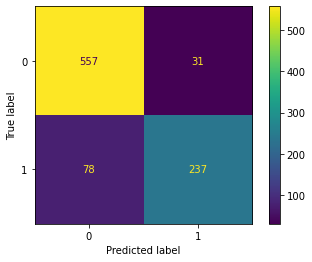

In [9]:
plot_confusion_matrix(model, X_test, y_test) 

## Feature importance

- For each feature, feature importance shows how much the prediction changes if the feature value changes. The bigger the value of the feature importance, the bigger is the change to the prediction value.

- Feature importance values are normalized to [0, 100].

<BarContainer object of 11 artists>

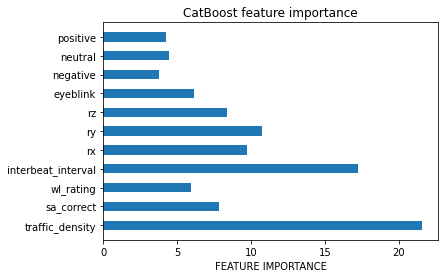

In [10]:
fea_ = model.feature_importances_

fea_name = list(X.columns)
fea_name = [str(j) for j in fea_name]

# plt.figure(figsize=(12, 8))
plt.title('CatBoost feature importance')
plt.xlabel('FEATURE IMPORTANCE')
# plt.ylabel('FEATURE NAMES')
plt.barh(fea_name,fea_,height =0.5)